In [2]:
import numpy as np
import pandas as pd
import catboost as cb
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV  #调参模块

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics


from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

d:\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data = pd.read_csv("C:\\Users\\p'c\\data1.csv", encoding = 'ISO-8859-1', engine = 'python')  # 部分清洗过和转换过变量的数据集。

In [4]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_2ership,annual_inc,...,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,disbursement_method,debt_settlement_flag,target
0,10000,10000,10000.0,0,0.1033,324.23,1,0,0,280000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,2500,2500,2500.0,0,0.1356,84.92,2,10,1,55000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
2,12000,12000,12000.0,1,0.1356,276.49,2,0,0,40000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
3,15000,15000,14975.0,1,0.1447,352.69,2,11,0,30000.0,...,48.8,0.0,15.0,0.0,0.0,NaN,0,1,0,0
4,16000,16000,16000.0,1,0.1797,406.04,3,5,0,51000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0


In [5]:
#计算缺失率

def compute_missing_ratio(df):
    dict_columns = {}
    column_name = [i for i in df.columns]
    for i in column_name:
        missing_rate = (df.shape[0]-df[i].count())*1.0/len(df.index) #计算缺失率
        dict_columns[i] = missing_rate
    return dict_columns

In [6]:
#删除缺失值大于一定比例的列，约等效于df.dropna(axis=1, thresh = int(0.8*len(df)))
#删除行部分，等效于df.dropna(axis = 0, subset = ['col'])

def delete_missing(df, missing_ratio, thresh_loss_ratio):
    key_for_dropped = []
    for key in missing_ratio.keys():
        if missing_ratio[key] > thresh_loss_ratio:
            key_for_dropped.append(key)
    
    print(len(key_for_dropped))
    df2 = df.drop(key_for_dropped, axis = 1, inplace = False)
    #column_name = [i for i in df.columns][0]
    #index_missing = [int(i) for i in df[column_name].index[np.where(np.isnan(df[column_name]))[0]].tolist()]
    #是否繁琐？np.where(...).tolist()即获得有空缺的索引
    #for i in index_missing:
        #df.drop(index = i, axis=0, inplace = True)
    return df2

In [7]:
#删除含有太多相同数据的列，以及太过分散，不利于决策树分裂节点的列（例如emp_title，列值太过分散）
def delete_asymmetrical(df, asym_degree, noise_degree):
    key_for_dropped = []
    for key in df.columns:
        temp = df[key].value_counts()/len(df[key])  # 输出的是每个值和每个值出现的频率
        if (np.max(temp) < asym_degree) or (np.max(temp) > noise_degree):
            key_for_dropped.append(key)

    #print(key_for_dropped)
    df2 = df.drop(key_for_dropped, axis = 1, inplace = False)
    return df2

In [8]:
miss_rate = compute_missing_ratio(data)
miss_rate.keys()

dict_keys(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_2ership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'title', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc

In [9]:
miss_rate # 一个字典类型，里面是所有变量的缺失率

{'loan_amnt': 0.0,
 'funded_amnt': 0.0,
 'funded_amnt_inv': 0.0,
 'term': 0.0,
 'int_rate': 0.0,
 'installment': 0.0,
 'grade': 0.0,
 'emp_length': 0.0,
 'home_2ership': 0.0,
 'annual_inc': 0.0,
 'verification_status': 0.0,
 'pymnt_plan': 0.0,
 'purpose': 0.0,
 'title': 0.0,
 'dti': 0.0018456219044949071,
 'delinq_2yrs': 0.0,
 'inq_last_6mths': 0.0,
 'mths_since_last_delinq': 0.5622215992274865,
 'mths_since_last_record': 0.8796841416690029,
 'open_acc': 0.0,
 'pub_rec': 0.0,
 'revol_bal': 0.0,
 'revol_util': 0.0012148397346042426,
 'total_acc': 0.0,
 'initial_list_status': 0.0,
 'out_prncp': 0.0,
 'out_prncp_inv': 0.0,
 'total_pymnt': 0.0,
 'total_pymnt_inv': 0.0,
 'total_rec_prncp': 0.0,
 'total_rec_int': 0.0,
 'total_rec_late_fee': 0.0,
 'recoveries': 0.0,
 'collection_recovery_fee': 0.0,
 'last_pymnt_amnt': 0.0,
 'collections_12_mths_ex_med': 0.0,
 'mths_since_last_major_derog': 0.7727626701554372,
 'policy_code': 0.0,
 'application_type': 0.0,
 'annual_inc_joint': 0.86931127931968

In [10]:
loan_data = data
loan_data_2 = delete_missing(loan_data, miss_rate, 0.8)
cleaned_data = delete_asymmetrical(loan_data_2, 0.001, 0.999)  # 有些列常理上是不能丢的，比如installment。这里被迫取了非常保守的阈值，事后应该也会有一些被模型本身舍弃掉。
cleaned_data.shape

15


(128412, 83)

In [11]:
# 虽然决策树模型，特别是catboost对于NAN的容忍度是非常高的，但逻辑回归和XGBoost对NAN的容忍度比较低，特别是逻辑回归不能用于含有NAN的数据集上。故这里简单用imputer来补全缺失值。

from sklearn.impute import SimpleImputer

imp_mf = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
impdata = imp_mf.fit_transform(cleaned_data)
impdf = pd.DataFrame(impdata, columns=cleaned_data.columns)
fdata = impdf.astype({'target': 'int64'}, copy=True)
fdata

d:\Anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_2ership,annual_inc,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,target
0,10000.0,10000.0,10000.0,0.0,0.1033,324.23,1.0,0.0,0.0,280000.0,...,0.0,4.0,91.3,28.6,0.0,61364.0,20900.0,54912.0,0.0,0
1,2500.0,2500.0,2500.0,0.0,0.1356,84.92,2.0,10.0,1.0,55000.0,...,0.0,3.0,100.0,0.0,1.0,16901.0,36500.0,18124.0,1.0,0
2,12000.0,12000.0,12000.0,1.0,0.1356,276.49,2.0,0.0,0.0,40000.0,...,0.0,3.0,100.0,60.0,0.0,32462.0,36800.0,9000.0,1.0,0
3,15000.0,15000.0,14975.0,1.0,0.1447,352.69,2.0,11.0,0.0,30000.0,...,0.0,1.0,100.0,50.0,0.0,24507.0,9900.0,14490.0,1.0,0
4,16000.0,16000.0,16000.0,1.0,0.1797,406.04,3.0,5.0,0.0,51000.0,...,0.0,3.0,77.8,0.0,0.0,39339.0,29500.0,38424.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128407,23000.0,23000.0,23000.0,0.0,0.1502,797.53,2.0,10.0,0.0,75000.0,...,0.0,7.0,96.4,14.3,0.0,40614.0,47100.0,21000.0,1.0,1
128408,10000.0,10000.0,10000.0,0.0,0.1502,346.76,2.0,5.0,0.0,38000.0,...,0.0,1.0,73.3,40.0,0.0,9323.0,9100.0,2000.0,1.0,0
128409,5000.0,5000.0,5000.0,0.0,0.1356,169.83,2.0,10.0,0.0,35360.0,...,0.0,3.0,92.9,50.0,0.0,4976.0,3000.0,6028.0,1.0,0
128410,10000.0,10000.0,9750.0,0.0,0.1106,327.68,1.0,11.0,1.0,44400.0,...,0.0,3.0,92.0,0.0,0.0,16440.0,20500.0,10171.0,1.0,0


In [40]:
# 变量分箱：用IV值再筛选一次变量。
# IV的计算需要用到分箱。这里存在等频、等深、kmeans、决策树、卡方等分箱方法。需实验哪一种分箱能带来较高的IV值。
# 后续会补充几种分箱的手写函数，这里简单用toad

import toad

iv_list = toad.quality(fdata, 'target', iv_only=True)  #高维度数据，计算gini和信息熵的耗时太长
columns_to_drop = iv_list[iv_list['iv'] <= 0.02].index # iv大于等于0.02，变量具有弱预测能力。小于0.02表示几乎无预测能力。但也不一定，有些变量或许还可以留下（例如term）
iv_columns = iv_list[iv_list['iv'] > 0.02].index.tolist()
iv_columns.append('target')
fdata_iv = fdata[iv_columns]
fdata_iv

,total_rec_prncp,total_pymnt_inv,total_pymnt,last_pymnt_amnt,total_rec_int,int_rate,grade,total_rec_late_fee,out_prncp,mths_since_recent_inq,...,open_rv_12m,mths_since_recent_bc,mths_since_last_major_derog,mo_sin_rcnt_rev_tl_op,mths_since_recent_revol_delinq,total_acc,num_rev_tl_bal_gt_0,num_op_rev_tl,open_acc_6m,target
0,478.34,639.85,639.85,324.23,161.51,0.1033,1.0,0.0,9521.66,11.0,...,1.0,11.0,45.0,11.0,21.0,23.0,4.0,9.0,1.0,0
1,113.98,167.02,167.02,84.92,53.04,0.1356,2.0,0.0,2386.02,2.0,...,2.0,1.0,45.0,1.0,21.0,34.0,5.0,7.0,2.0,0
2,283.37,539.42,539.42,276.49,256.05,0.1356,2.0,0.0,11716.63,4.0,...,2.0,10.0,45.0,9.0,21.0,9.0,6.0,7.0,1.0,0
3,345.43,686.14,687.29,352.69,341.86,0.1447,2.0,0.0,14654.57,1.0,...,1.0,31.0,45.0,6.0,21.0,30.0,13.0,18.0,1.0,0
4,335.37,788.12,788.12,406.04,452.75,0.1797,3.0,0.0,15664.63,4.0,...,1.0,6.0,52.0,6.0,52.0,27.0,2.0,3.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128407,1025.67,1547.08,1547.08,797.53,521.41,0.1502,2.0,0.0,0.00,4.0,...,4.0,5.0,45.0,4.0,22.0,28.0,5.0,9.0,4.0,1
128408,1136.05,1725.46,1725.46,346.76,589.41,0.1502,2.0,0.0,8863.95,17.0,...,1.0,11.0,45.0,11.0,6.0,16.0,5.0,8.0,0.0,0
128409,579.60,845.38,845.38,169.83,265.78,0.1356,2.0,0.0,4420.40,9.0,...,3.0,10.0,45.0,9.0,21.0,15.0,3.0,6.0,0.0,0
128410,1199.47,1582.46,1623.04,327.68,423.57,0.1106,1.0,0.0,8800.53,1.0,...,2.0,1.0,53.0,1.0,40.0,25.0,4.0,14.0,3.0,0


In [41]:
# 一个更高效的筛选方法
# toad.selection.select(dataframe, target='target', empty=0.9, iv=0.02, corr=0.7, return_drop=False, exclude=None)
# 筛掉缺失率高于0.9，IV小于0.02，相关系数高于0.7的变量

In [53]:
# 考虑到逻辑回归有无法收敛的风险，单独做一个归一化的数据集。

from sklearn.preprocessing import StandardScaler

logit_scalar = StandardScaler()
fdata_logit = fdata_iv.drop(columns='target', inplace=False)
ldata0 = logit_scalar.fit_transform(fdata_logit)
ldata1 = pd.DataFrame(ldata0, columns=fdata_logit.columns)
target_data = pd.DataFrame({'target': fdata_iv['target']})
ldata = pd.concat([ldata1, target_data], axis=1)

### 事前准备（二）：模型评估指数
##### 混淆矩阵分数、accuracy sore, ROC、AUC、f1_score、KS、Gini、PSI、Lift提升度、logloss

In [43]:
### 计算KS值 for Kolmogorov-Smirnoff test
### K-S图反映了模型预测的坏客户和好客户在样本中的分离程度，横坐标是模型预测概率（分数），纵坐标是已预测出的好/坏客户占好坏客户总数的比例。所以它们都会趋向1.
### 因此，K-S图由两条线构成：累计预测为好客户的比例，累计预测为坏客户的比例。K-S值是这两条线垂直方向上距离的最大值。KS值越大，这两条线分得越开，说明模型区分能力越好。

### 例如，好客户线非常贴近左上角，坏客户线非常贴近右下角，意味着预测概率低的都被预测为好客户，预测概率高的都被预测为坏客户，模型这时候区分能力很强。
### 反之，如果模型接近随机预测，好坏客户的预测会混在一起，此时两条线会黏得很紧。

### 注意，K-S模型只反映分割能力，不反映分割正确性。上述例子如果反过来，模型和真实结果的预测刚好反过来，那么K-S值也很高。所以单看KS值不够，还要看AUC。


def KS(df, thescore, target):
    '''
    :param df: 包含目标变量与预测值的数据集
    :param score: 得分或概率
    :param target: 目标变量
    :return: KS值
    '''
    #根据score分数和目标变量，计算每个score总共有几个客户
    total = df.groupby([thescore])[target].count()
    #计算每个分数下预测出了几个坏客户
    bad = df.groupby([thescore])[target].sum()
    all = pd.DataFrame({'total':total, 'bad':bad})
    all['good'] = all['total'] - all['bad']
    all[thescore] = all.index
    all.index = range(len(all))
    all = all.sort_values(by = thescore, ascending = True)

    #坏客户总数
    num_bad = all['bad'].sum()

    #好客户总数
    num_good = all['good'].sum()

    #累计坏客户概率
    all['badCumRate'] = all['bad'].cumsum()/num_bad

    #累计好客户概率
    all['goodCumRate'] = all['good'].cumsum()/num_good

    #坏客户-好客户概率的序列
    ks_array = all.apply(lambda x: abs(x.badCumRate - x.goodCumRate), axis = 1)
    
    #最大值就是ks值。
    ks = max(ks_array)
    return ks

In [44]:
### AUC代表ROC曲线下的面积，表示模型正确分类阳性样本的能力。最理想的模型，AUC=1；最糟糕的模型（随机分类），AUC=0.5。
### 首先，ROC曲线的横坐标是FPR，即假阳率；纵坐标是TPR，即真阳率。ROC曲线上的每一个样本点对应一个预测概率（分数），通过让每一个分数都成为分类器的阈值，我们可以得出每一个阈值的TPR和FPR，进而绘制ROC曲线。
### ROC曲线越“方”越好，这意味着TPR始终显著高于FPR，模型正确分类阳性样本的能力始终很强；但ROC曲线有时会交叉，这种时候只能通过AUC比较。
### AUC相当于对TPR求和，同样也是越大越好。
# 注意，如果模型预测结果和真实结果恰好是相反的，那么这时AUC会非常小：此时应用1-AUC表示其分类能力，意为把模型结果反过来用。

def AUC(y_true, y_scores):
    auc_value = 0
    #通过TPR, FPR计算AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores, pos_label = 1)
    auc_value = auc(fpr, tpr)
    if auc_value < 0.5:
        auc_value = 1 - auc_value
    return auc_value

### 定义上，Gini系数衡量坏账户数在好账户数上的累积分布与随机分布曲线之间的面积，也反映模型区分样本能力的强弱，看上去和K-S比较像。但是，gini和ROC讲的几乎是同一件事。
# 如果一个分类器按照预测分数排序，总是能先分类出绝大多数好客户，再分类出绝大多数坏客户，那么对应的Gini曲线刚好就是ROC按对角线翻转过来的样子，虽然两者坐标不一样。这就是为什么gini可以用AUC近似。
# gini = A+0.5, gini+1 = (A+0.5)/0.5 = AUC/0.5 = 2*AUC, gini = 2*AUC - 1

def Gini(auc):
    gini = 2*auc - 1
    return gini

def Draw_roc(auc_value, y_test, pos_prob_list):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_prob_list, pos_label = 1)
    #画对角线
    plt.plot([0, 1], [0, 1], '--', color = (0.6, 0.6, 0.6), label = 'Diagonal Line')
    plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % auc_value)
    plt.title('ROC curve')
    plt.legend(loc = 'lower right')

In [73]:
### Lift指数：反映使用模型比不使用模型的提高程度
### 计算方法：按预测概率从大到小排序，等频率分箱，计算每个分箱内 坏样本/总坏样本 / 分箱样本/总样本 的比例。Lift曲线的第一个值是Lift值。
### df的格式：score和target = predicted_label

def lift_curve(df, thescore, target, box_num):
    df_sorted = df.sort_values(by='score', ascending=False)
    df_sorted['box_label'] = df_sorted['score']
    box_step = int(df_sorted.shape[0]/box_num)
    for i in range(box_num):
        if(i<box_num-1):
            df_sorted.iloc[(box_step*i):(box_step*(i+1)), 2] = i+1
        else:
            df_sorted.iloc[(box_step*i): , 2] = i+1
    total = df_sorted.groupby(['box_label'])['target'].count()
    bad = df_sorted.groupby(['box_label'])['target'].sum()
    all = pd.DataFrame({'total':total, 'bad':bad})
    all['total%'] = all['total']/len(df_sorted)
    all['bad%'] = all['bad']/sum(df_sorted['target'])
    all['cumtotal%'] = all['total%'].cumsum()
    all['cumbad%'] = all['bad%'].cumsum()
    all['lift'] = all['cumbad%']/all['cumtotal%']  # lift表，含lift值（第一个）和lift曲线的数据

    lift_value = all.iloc[0, -1] # lift值

    # 绘制lift曲线

    all['base'] = np.ones(len(all))

    plt.figure(figsize=[8,4])
    plt.plot(pd.Series(all.index), all['base'],  marker = 'o', linewidth=1, markersize=2)
    plt.plot(pd.Series(all.index), all['lift'],  marker = 'o', linewidth=1, markersize=2)
    plt.title('Lift curve')
    plt.show()
     
    return(lift_value)

In [46]:
### PSI 模型稳定性指标
### 函数输入：x_it, y_it(expect), x_oot, y_oot(actual)。用时间内样本的预测分数和时间外样本的预测分数进行分箱，统计分箱内样本数量分布的差异
### PSI分模型稳定性和特征稳定性。操作方法类似，都是对目标值进行等分，算出每个区间的值的比例，然后求PSI。但在特征稳定性测试中，PSI<0.0001时，特征的取值稳定。

def predict_scores(y, x, model):
    prob_list = model.predict_proba(x)
    pos_prob_list = [i[1] for i in prob_list]
    pos_prob_list.sort()
    pos_prob_list_box = [round(i, 2) for i in pos_prob_list]
    predicted_scores = pd.DataFrame({'pred_prob_box': pos_prob_list_box})
    prob_dist = predicted_scores['pred_prob_box'].value_counts()
    prob_dist = pd.DataFrame({'prob_count': prob_dist})
    #print(prob_dist)
    
    # 有一些概率分数是没有样本的，缺失值会导致时间内/时间外样本的概率分布不等长，需补齐。
    prob_interval = np.arange(0, 1.01, 0.01)
    for i in list(set([round(i, 2) for i in prob_interval]) - set(prob_dist.index)):  # 消除浮点数误差，并把set类型转换为list类型，否则无法索引
        temp_df = pd.DataFrame({'prob_count': 0}, index=[i])
        prob_dist = pd.concat([prob_dist, temp_df])
    
    prob_dist = prob_dist.sort_index(ascending=True)

    prob_dist['prob_count%'] = prob_dist['prob_count']/sum(prob_dist['prob_count'])
    return(prob_dist)


def calc_PSI(x_it, y_it, x_oot, y_oot, model):

    it_score = predict_scores(y_it, x_it)  # 时间内样本预测概率分布
    oot_score = predict_scores(y_oot, x_oot) # 时间外样本预测概率分布

    psi = 0
    if len(it_score)!=len(oot_score):
        print('Samples fail to match')
    else:
        num = len(it_score)
        for i in range(num):
            value = (oot_score.iloc[i, -1] - it_score.iloc[i, -1])*math.log((oot_score.iloc[i, -1]/it_score.iloc[i, -1]), math.e)
            psi += value
    return psi

In [74]:
# 整合一个模型指标输出函数

def model_eval(df, thescore, target, box_num, y_true, y_pred, pos_prob_list):
    # summarize K-S value
    ks = KS(df, thescore, target)

    # summarize ROC/AUC/Gini
    auc = AUC(y_true, pos_prob_list)
    gini = Gini(auc)

    Draw_roc(auc, y_true, pos_prob_list)

    # summarize lift value
    lift = lift_curve(df, thescore, target, box_num)

    # summarize confusion matrix(precision, recall, accuracy, f1 score)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    model_eval_matrix = pd.DataFrame({'precision':precision, 'recall':recall, 'accuracy':accuracy, 'f1_score':f1, 'KS_value':ks, 'AUC':auc, 'Gini':gini, 'Lift':lift}, index=[0])
    return(model_eval_matrix)

In [48]:
# 模型分

#print('accuracy on the train subset:{:.4f}'.format(model.score(train_x, y_train)))
#print('accuracy on the test subset:{:.4f}'.format(model.score(test_x, y_test)))

### 第一部分：使用逻辑回归对数据建模

In [49]:
from sklearn.linear_model import LogisticRegression

In [57]:
Y = ldata['target']
X = ldata.iloc[:,:-1]

In [59]:
#分开训练集和测试集
train_x, test_x, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 0)

In [60]:
clf = LogisticRegression(max_iter=5000)

clf.fit(train_x, y_train)

LogisticRegression(max_iter=5000)

In [61]:
y_pred = clf.predict(test_x)
y_true = y_test

#获取所有x数据的坏客户预测概率
prob_list = clf.predict_proba(test_x)
pos_prob_list = [i[1] for i in prob_list]

clf_df = pd.DataFrame({'score': pos_prob_list, 'target': y_test}) #合成一个数据集，内含预测概率，还有分类器给的值。用于计算ks, lift等指标。

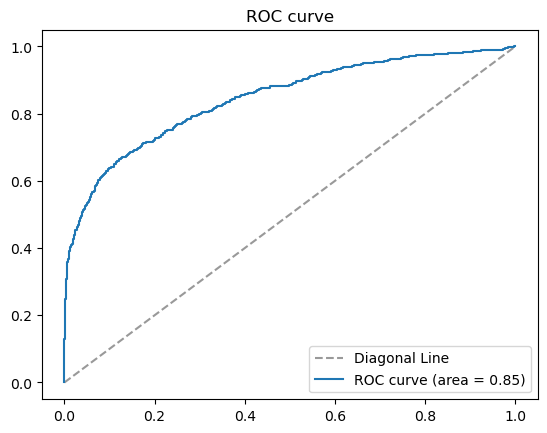

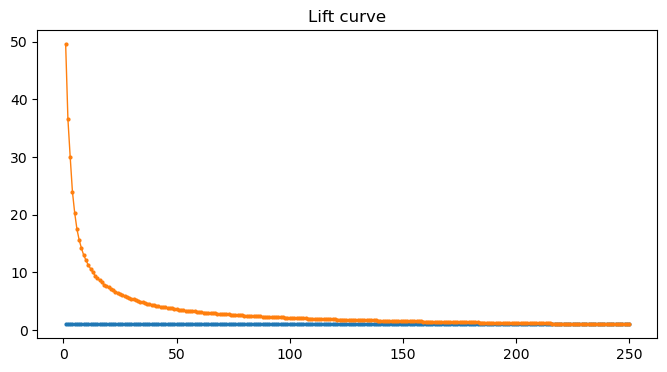

In [75]:
clf_eval = model_eval(clf_df, 'score', 'target', box_num=250, y_true=y_true, y_pred=y_pred, pos_prob_list=pos_prob_list)

In [76]:
clf_eval

,precision,recall,accuracy,f1_score,KS_value,AUC,Gini,Lift
0,0.865854,0.133962,0.9878,0.232026,0.54465,0.845115,0.69023,49.559177


##### 这一次训练的结果是查全率过于低。逻辑回归的参数调优可能需要围绕着正则化和sigmoid函数的取值进行，也可能需要进行过采样，比如SMOTE采样，来缓解positive sample的匮乏程度。

### 第二部分：使用XGBoost, LightGBM, Catboost进行分类建模

In [108]:
import catboost as cb
import lightgbm as lgb

xgb1 = xgb.
cb1 = cb.CatBoostClassifier()


In [109]:
cb1.fit(train_x, y_train)

Learning rate set to 0.070334
0:	learn: 0.5596773	total: 165ms	remaining: 2m 44s
1:	learn: 0.4545558	total: 186ms	remaining: 1m 32s
2:	learn: 0.3717409	total: 208ms	remaining: 1m 9s
3:	learn: 0.3086573	total: 229ms	remaining: 57.1s
4:	learn: 0.2562472	total: 257ms	remaining: 51.1s
5:	learn: 0.2171364	total: 279ms	remaining: 46.3s
6:	learn: 0.1853009	total: 307ms	remaining: 43.5s
7:	learn: 0.1597483	total: 335ms	remaining: 41.6s
8:	learn: 0.1383994	total: 361ms	remaining: 39.8s
9:	learn: 0.1239449	total: 386ms	remaining: 38.2s
10:	learn: 0.1112999	total: 411ms	remaining: 37s
11:	learn: 0.1012458	total: 437ms	remaining: 36s
12:	learn: 0.0936856	total: 458ms	remaining: 34.8s
13:	learn: 0.0866902	total: 483ms	remaining: 34s
14:	learn: 0.0812615	total: 506ms	remaining: 33.3s
15:	learn: 0.0766928	total: 531ms	remaining: 32.7s
16:	learn: 0.0727004	total: 557ms	remaining: 32.2s
17:	learn: 0.0697633	total: 580ms	remaining: 31.6s
18:	learn: 0.0672218	total: 606ms	remaining: 31.3s
19:	learn: 0.06

In [28]:
#交叉验证（先略过）
from sklearn.model_selection import cross_val_score

In [29]:
scores = cross_val_score(cb1, X, Y, cv = 10)

Learning rate set to 0.078301
0:	learn: 0.5451450	total: 23.8ms	remaining: 23.7s
1:	learn: 0.4324980	total: 49.2ms	remaining: 24.6s
2:	learn: 0.3479504	total: 67.8ms	remaining: 22.5s
3:	learn: 0.2792968	total: 90.7ms	remaining: 22.6s
4:	learn: 0.2310352	total: 116ms	remaining: 23s
5:	learn: 0.1941105	total: 137ms	remaining: 22.7s
6:	learn: 0.1617931	total: 159ms	remaining: 22.6s
7:	learn: 0.1400042	total: 181ms	remaining: 22.4s
8:	learn: 0.1230864	total: 207ms	remaining: 22.8s
9:	learn: 0.1115278	total: 229ms	remaining: 22.7s
10:	learn: 0.1000587	total: 253ms	remaining: 22.8s
11:	learn: 0.0908276	total: 276ms	remaining: 22.7s
12:	learn: 0.0835204	total: 301ms	remaining: 22.8s
13:	learn: 0.0773770	total: 329ms	remaining: 23.2s
14:	learn: 0.0728080	total: 353ms	remaining: 23.2s
15:	learn: 0.0691063	total: 380ms	remaining: 23.4s
16:	learn: 0.0660487	total: 410ms	remaining: 23.7s
17:	learn: 0.0634037	total: 434ms	remaining: 23.7s
18:	learn: 0.0612834	total: 459ms	remaining: 23.7s
19:	learn

165:	learn: 0.0395155	total: 4.07s	remaining: 20.4s
166:	learn: 0.0395093	total: 4.09s	remaining: 20.4s
167:	learn: 0.0394997	total: 4.12s	remaining: 20.4s
168:	learn: 0.0394914	total: 4.14s	remaining: 20.4s
169:	learn: 0.0394746	total: 4.16s	remaining: 20.3s
170:	learn: 0.0394657	total: 4.18s	remaining: 20.3s
171:	learn: 0.0394560	total: 4.21s	remaining: 20.3s
172:	learn: 0.0394364	total: 4.23s	remaining: 20.2s
173:	learn: 0.0394285	total: 4.25s	remaining: 20.2s
174:	learn: 0.0393502	total: 4.28s	remaining: 20.2s
175:	learn: 0.0393373	total: 4.3s	remaining: 20.1s
176:	learn: 0.0392783	total: 4.33s	remaining: 20.1s
177:	learn: 0.0392199	total: 4.36s	remaining: 20.1s
178:	learn: 0.0392161	total: 4.38s	remaining: 20.1s
179:	learn: 0.0391643	total: 4.4s	remaining: 20s
180:	learn: 0.0391573	total: 4.43s	remaining: 20s
181:	learn: 0.0391344	total: 4.45s	remaining: 20s
182:	learn: 0.0390924	total: 4.47s	remaining: 20s
183:	learn: 0.0390883	total: 4.5s	remaining: 19.9s
184:	learn: 0.0390814	t

329:	learn: 0.0363969	total: 8.02s	remaining: 16.3s
330:	learn: 0.0363890	total: 8.05s	remaining: 16.3s
331:	learn: 0.0363508	total: 8.08s	remaining: 16.3s
332:	learn: 0.0363343	total: 8.1s	remaining: 16.2s
333:	learn: 0.0363337	total: 8.12s	remaining: 16.2s
334:	learn: 0.0362937	total: 8.15s	remaining: 16.2s
335:	learn: 0.0362758	total: 8.17s	remaining: 16.1s
336:	learn: 0.0362672	total: 8.19s	remaining: 16.1s
337:	learn: 0.0362577	total: 8.21s	remaining: 16.1s
338:	learn: 0.0362291	total: 8.24s	remaining: 16.1s
339:	learn: 0.0362185	total: 8.26s	remaining: 16s
340:	learn: 0.0362064	total: 8.28s	remaining: 16s
341:	learn: 0.0361633	total: 8.31s	remaining: 16s
342:	learn: 0.0361204	total: 8.34s	remaining: 16s
343:	learn: 0.0361150	total: 8.37s	remaining: 16s
344:	learn: 0.0360747	total: 8.39s	remaining: 15.9s
345:	learn: 0.0360659	total: 8.42s	remaining: 15.9s
346:	learn: 0.0360249	total: 8.44s	remaining: 15.9s
347:	learn: 0.0360110	total: 8.47s	remaining: 15.9s
348:	learn: 0.0359968	t

494:	learn: 0.0338357	total: 12.2s	remaining: 12.4s
495:	learn: 0.0338038	total: 12.2s	remaining: 12.4s
496:	learn: 0.0337817	total: 12.2s	remaining: 12.4s
497:	learn: 0.0337736	total: 12.2s	remaining: 12.3s
498:	learn: 0.0337614	total: 12.3s	remaining: 12.3s
499:	learn: 0.0337265	total: 12.3s	remaining: 12.3s
500:	learn: 0.0337037	total: 12.3s	remaining: 12.3s
501:	learn: 0.0337012	total: 12.4s	remaining: 12.3s
502:	learn: 0.0336944	total: 12.4s	remaining: 12.2s
503:	learn: 0.0336669	total: 12.4s	remaining: 12.2s
504:	learn: 0.0336255	total: 12.4s	remaining: 12.2s
505:	learn: 0.0336161	total: 12.5s	remaining: 12.2s
506:	learn: 0.0335852	total: 12.5s	remaining: 12.1s
507:	learn: 0.0335749	total: 12.5s	remaining: 12.1s
508:	learn: 0.0335593	total: 12.5s	remaining: 12.1s
509:	learn: 0.0335261	total: 12.6s	remaining: 12.1s
510:	learn: 0.0335163	total: 12.6s	remaining: 12.1s
511:	learn: 0.0334864	total: 12.6s	remaining: 12s
512:	learn: 0.0334861	total: 12.7s	remaining: 12s
513:	learn: 0.03

659:	learn: 0.0313233	total: 16.3s	remaining: 8.41s
660:	learn: 0.0313226	total: 16.4s	remaining: 8.39s
661:	learn: 0.0312889	total: 16.4s	remaining: 8.36s
662:	learn: 0.0312883	total: 16.4s	remaining: 8.34s
663:	learn: 0.0312802	total: 16.4s	remaining: 8.31s
664:	learn: 0.0312759	total: 16.4s	remaining: 8.29s
665:	learn: 0.0312574	total: 16.5s	remaining: 8.26s
666:	learn: 0.0312537	total: 16.5s	remaining: 8.23s
667:	learn: 0.0312318	total: 16.5s	remaining: 8.21s
668:	learn: 0.0312085	total: 16.6s	remaining: 8.19s
669:	learn: 0.0311981	total: 16.6s	remaining: 8.16s
670:	learn: 0.0311865	total: 16.6s	remaining: 8.14s
671:	learn: 0.0311793	total: 16.6s	remaining: 8.12s
672:	learn: 0.0311747	total: 16.7s	remaining: 8.09s
673:	learn: 0.0311730	total: 16.7s	remaining: 8.06s
674:	learn: 0.0311633	total: 16.7s	remaining: 8.04s
675:	learn: 0.0311630	total: 16.7s	remaining: 8.01s
676:	learn: 0.0311557	total: 16.7s	remaining: 7.99s
677:	learn: 0.0311375	total: 16.8s	remaining: 7.96s
678:	learn: 

822:	learn: 0.0295412	total: 20.2s	remaining: 4.34s
823:	learn: 0.0295338	total: 20.2s	remaining: 4.32s
824:	learn: 0.0295217	total: 20.2s	remaining: 4.29s
825:	learn: 0.0295128	total: 20.3s	remaining: 4.27s
826:	learn: 0.0295041	total: 20.3s	remaining: 4.24s
827:	learn: 0.0295021	total: 20.3s	remaining: 4.22s
828:	learn: 0.0294841	total: 20.3s	remaining: 4.19s
829:	learn: 0.0294747	total: 20.4s	remaining: 4.17s
830:	learn: 0.0294650	total: 20.4s	remaining: 4.14s
831:	learn: 0.0294464	total: 20.4s	remaining: 4.12s
832:	learn: 0.0294333	total: 20.4s	remaining: 4.09s
833:	learn: 0.0294257	total: 20.4s	remaining: 4.07s
834:	learn: 0.0294049	total: 20.5s	remaining: 4.04s
835:	learn: 0.0293946	total: 20.5s	remaining: 4.02s
836:	learn: 0.0293895	total: 20.5s	remaining: 4s
837:	learn: 0.0293800	total: 20.5s	remaining: 3.97s
838:	learn: 0.0293606	total: 20.6s	remaining: 3.95s
839:	learn: 0.0293549	total: 20.6s	remaining: 3.92s
840:	learn: 0.0293211	total: 20.6s	remaining: 3.9s
841:	learn: 0.02

983:	learn: 0.0279142	total: 24.2s	remaining: 394ms
984:	learn: 0.0279029	total: 24.2s	remaining: 369ms
985:	learn: 0.0278982	total: 24.3s	remaining: 344ms
986:	learn: 0.0278873	total: 24.3s	remaining: 320ms
987:	learn: 0.0278818	total: 24.3s	remaining: 295ms
988:	learn: 0.0278686	total: 24.3s	remaining: 271ms
989:	learn: 0.0278617	total: 24.4s	remaining: 246ms
990:	learn: 0.0278421	total: 24.4s	remaining: 222ms
991:	learn: 0.0278351	total: 24.4s	remaining: 197ms
992:	learn: 0.0278261	total: 24.4s	remaining: 172ms
993:	learn: 0.0278181	total: 24.5s	remaining: 148ms
994:	learn: 0.0278108	total: 24.5s	remaining: 123ms
995:	learn: 0.0278014	total: 24.5s	remaining: 98.5ms
996:	learn: 0.0277934	total: 24.5s	remaining: 73.9ms
997:	learn: 0.0277905	total: 24.6s	remaining: 49.2ms
998:	learn: 0.0277845	total: 24.6s	remaining: 24.6ms
999:	learn: 0.0277688	total: 24.6s	remaining: 0us
Learning rate set to 0.078301
0:	learn: 0.5451140	total: 53.9ms	remaining: 53.8s
1:	learn: 0.4323929	total: 80.6ms

146:	learn: 0.0448338	total: 3.82s	remaining: 22.1s
147:	learn: 0.0448222	total: 3.84s	remaining: 22.1s
148:	learn: 0.0447871	total: 3.87s	remaining: 22.1s
149:	learn: 0.0447452	total: 3.89s	remaining: 22.1s
150:	learn: 0.0446952	total: 3.92s	remaining: 22s
151:	learn: 0.0446798	total: 3.94s	remaining: 22s
152:	learn: 0.0446277	total: 3.97s	remaining: 22s
153:	learn: 0.0446198	total: 3.99s	remaining: 21.9s
154:	learn: 0.0446042	total: 4.01s	remaining: 21.9s
155:	learn: 0.0445858	total: 4.04s	remaining: 21.8s
156:	learn: 0.0445358	total: 4.06s	remaining: 21.8s
157:	learn: 0.0445303	total: 4.08s	remaining: 21.8s
158:	learn: 0.0445268	total: 4.1s	remaining: 21.7s
159:	learn: 0.0444897	total: 4.13s	remaining: 21.7s
160:	learn: 0.0444774	total: 4.15s	remaining: 21.6s
161:	learn: 0.0444520	total: 4.17s	remaining: 21.6s
162:	learn: 0.0444386	total: 4.19s	remaining: 21.5s
163:	learn: 0.0444182	total: 4.21s	remaining: 21.5s
164:	learn: 0.0443990	total: 4.24s	remaining: 21.4s
165:	learn: 0.04439

310:	learn: 0.0411166	total: 7.87s	remaining: 17.4s
311:	learn: 0.0411155	total: 7.89s	remaining: 17.4s
312:	learn: 0.0411059	total: 7.91s	remaining: 17.4s
313:	learn: 0.0410941	total: 7.94s	remaining: 17.3s
314:	learn: 0.0410857	total: 7.96s	remaining: 17.3s
315:	learn: 0.0410474	total: 7.99s	remaining: 17.3s
316:	learn: 0.0410285	total: 8.02s	remaining: 17.3s
317:	learn: 0.0410148	total: 8.04s	remaining: 17.2s
318:	learn: 0.0410066	total: 8.07s	remaining: 17.2s
319:	learn: 0.0409962	total: 8.09s	remaining: 17.2s
320:	learn: 0.0409817	total: 8.11s	remaining: 17.2s
321:	learn: 0.0409691	total: 8.14s	remaining: 17.1s
322:	learn: 0.0409659	total: 8.16s	remaining: 17.1s
323:	learn: 0.0409562	total: 8.18s	remaining: 17.1s
324:	learn: 0.0409555	total: 8.2s	remaining: 17s
325:	learn: 0.0409316	total: 8.22s	remaining: 17s
326:	learn: 0.0409248	total: 8.25s	remaining: 17s
327:	learn: 0.0409159	total: 8.27s	remaining: 16.9s
328:	learn: 0.0408916	total: 8.3s	remaining: 16.9s
329:	learn: 0.040891

470:	learn: 0.0384390	total: 11.8s	remaining: 13.2s
471:	learn: 0.0384376	total: 11.8s	remaining: 13.2s
472:	learn: 0.0384354	total: 11.8s	remaining: 13.2s
473:	learn: 0.0384169	total: 11.8s	remaining: 13.1s
474:	learn: 0.0383905	total: 11.9s	remaining: 13.1s
475:	learn: 0.0383684	total: 11.9s	remaining: 13.1s
476:	learn: 0.0383345	total: 11.9s	remaining: 13.1s
477:	learn: 0.0383181	total: 11.9s	remaining: 13s
478:	learn: 0.0382882	total: 12s	remaining: 13s
479:	learn: 0.0382453	total: 12s	remaining: 13s
480:	learn: 0.0382354	total: 12s	remaining: 13s
481:	learn: 0.0382129	total: 12s	remaining: 12.9s
482:	learn: 0.0381959	total: 12.1s	remaining: 12.9s
483:	learn: 0.0381931	total: 12.1s	remaining: 12.9s
484:	learn: 0.0381875	total: 12.1s	remaining: 12.9s
485:	learn: 0.0381539	total: 12.1s	remaining: 12.8s
486:	learn: 0.0381269	total: 12.2s	remaining: 12.8s
487:	learn: 0.0380865	total: 12.2s	remaining: 12.8s
488:	learn: 0.0380826	total: 12.2s	remaining: 12.7s
489:	learn: 0.0380767	total:

632:	learn: 0.0358907	total: 15.8s	remaining: 9.13s
633:	learn: 0.0358509	total: 15.8s	remaining: 9.12s
634:	learn: 0.0358480	total: 15.8s	remaining: 9.09s
635:	learn: 0.0358181	total: 15.9s	remaining: 9.07s
636:	learn: 0.0358122	total: 15.9s	remaining: 9.05s
637:	learn: 0.0357685	total: 15.9s	remaining: 9.03s
638:	learn: 0.0357636	total: 15.9s	remaining: 9s
639:	learn: 0.0357561	total: 16s	remaining: 8.98s
640:	learn: 0.0357289	total: 16s	remaining: 8.96s
641:	learn: 0.0357166	total: 16s	remaining: 8.94s
642:	learn: 0.0357098	total: 16.1s	remaining: 8.91s
643:	learn: 0.0357030	total: 16.1s	remaining: 8.89s
644:	learn: 0.0356709	total: 16.1s	remaining: 8.87s
645:	learn: 0.0356641	total: 16.1s	remaining: 8.84s
646:	learn: 0.0356503	total: 16.2s	remaining: 8.82s
647:	learn: 0.0356263	total: 16.2s	remaining: 8.8s
648:	learn: 0.0356119	total: 16.2s	remaining: 8.77s
649:	learn: 0.0355931	total: 16.2s	remaining: 8.75s
650:	learn: 0.0355767	total: 16.3s	remaining: 8.72s
651:	learn: 0.0355607	

794:	learn: 0.0337319	total: 20.1s	remaining: 5.18s
795:	learn: 0.0337236	total: 20.1s	remaining: 5.15s
796:	learn: 0.0337147	total: 20.1s	remaining: 5.13s
797:	learn: 0.0337094	total: 20.1s	remaining: 5.1s
798:	learn: 0.0337019	total: 20.2s	remaining: 5.08s
799:	learn: 0.0336901	total: 20.2s	remaining: 5.05s
800:	learn: 0.0336628	total: 20.2s	remaining: 5.03s
801:	learn: 0.0336451	total: 20.3s	remaining: 5s
802:	learn: 0.0336417	total: 20.3s	remaining: 4.98s
803:	learn: 0.0336398	total: 20.3s	remaining: 4.96s
804:	learn: 0.0336354	total: 20.4s	remaining: 4.93s
805:	learn: 0.0336316	total: 20.4s	remaining: 4.9s
806:	learn: 0.0335971	total: 20.4s	remaining: 4.88s
807:	learn: 0.0335908	total: 20.4s	remaining: 4.86s
808:	learn: 0.0335866	total: 20.5s	remaining: 4.83s
809:	learn: 0.0335674	total: 20.5s	remaining: 4.81s
810:	learn: 0.0335416	total: 20.5s	remaining: 4.79s
811:	learn: 0.0335285	total: 20.6s	remaining: 4.76s
812:	learn: 0.0335249	total: 20.6s	remaining: 4.74s
813:	learn: 0.033

960:	learn: 0.0317590	total: 24.7s	remaining: 1s
961:	learn: 0.0317516	total: 24.8s	remaining: 979ms
962:	learn: 0.0317454	total: 24.8s	remaining: 953ms
963:	learn: 0.0317421	total: 24.8s	remaining: 927ms
964:	learn: 0.0317376	total: 24.8s	remaining: 901ms
965:	learn: 0.0317089	total: 24.9s	remaining: 875ms
966:	learn: 0.0316983	total: 24.9s	remaining: 850ms
967:	learn: 0.0316934	total: 24.9s	remaining: 824ms
968:	learn: 0.0316722	total: 25s	remaining: 799ms
969:	learn: 0.0316685	total: 25s	remaining: 773ms
970:	learn: 0.0316427	total: 25s	remaining: 747ms
971:	learn: 0.0316222	total: 25s	remaining: 722ms
972:	learn: 0.0316118	total: 25.1s	remaining: 696ms
973:	learn: 0.0315898	total: 25.1s	remaining: 670ms
974:	learn: 0.0315734	total: 25.1s	remaining: 645ms
975:	learn: 0.0315529	total: 25.2s	remaining: 619ms
976:	learn: 0.0315447	total: 25.2s	remaining: 593ms
977:	learn: 0.0315412	total: 25.2s	remaining: 567ms
978:	learn: 0.0315297	total: 25.2s	remaining: 541ms
979:	learn: 0.0315221	t

123:	learn: 0.0443365	total: 3.24s	remaining: 22.9s
124:	learn: 0.0443317	total: 3.27s	remaining: 22.9s
125:	learn: 0.0442990	total: 3.29s	remaining: 22.8s
126:	learn: 0.0442792	total: 3.31s	remaining: 22.8s
127:	learn: 0.0442317	total: 3.34s	remaining: 22.7s
128:	learn: 0.0442197	total: 3.36s	remaining: 22.7s
129:	learn: 0.0441953	total: 3.38s	remaining: 22.7s
130:	learn: 0.0441610	total: 3.41s	remaining: 22.6s
131:	learn: 0.0441541	total: 3.43s	remaining: 22.6s
132:	learn: 0.0441176	total: 3.46s	remaining: 22.6s
133:	learn: 0.0440772	total: 3.49s	remaining: 22.5s
134:	learn: 0.0440155	total: 3.51s	remaining: 22.5s
135:	learn: 0.0439917	total: 3.54s	remaining: 22.5s
136:	learn: 0.0439384	total: 3.56s	remaining: 22.4s
137:	learn: 0.0438957	total: 3.58s	remaining: 22.4s
138:	learn: 0.0438714	total: 3.6s	remaining: 22.3s
139:	learn: 0.0437902	total: 3.64s	remaining: 22.3s
140:	learn: 0.0437733	total: 3.66s	remaining: 22.3s
141:	learn: 0.0437686	total: 3.68s	remaining: 22.2s
142:	learn: 0

288:	learn: 0.0404331	total: 7.33s	remaining: 18s
289:	learn: 0.0404231	total: 7.36s	remaining: 18s
290:	learn: 0.0403764	total: 7.38s	remaining: 18s
291:	learn: 0.0403649	total: 7.41s	remaining: 18s
292:	learn: 0.0403524	total: 7.43s	remaining: 17.9s
293:	learn: 0.0403397	total: 7.46s	remaining: 17.9s
294:	learn: 0.0403332	total: 7.48s	remaining: 17.9s
295:	learn: 0.0402988	total: 7.51s	remaining: 17.9s
296:	learn: 0.0402982	total: 7.53s	remaining: 17.8s
297:	learn: 0.0402959	total: 7.55s	remaining: 17.8s
298:	learn: 0.0402937	total: 7.58s	remaining: 17.8s
299:	learn: 0.0402685	total: 7.6s	remaining: 17.7s
300:	learn: 0.0402560	total: 7.62s	remaining: 17.7s
301:	learn: 0.0402295	total: 7.65s	remaining: 17.7s
302:	learn: 0.0402154	total: 7.67s	remaining: 17.7s
303:	learn: 0.0402092	total: 7.7s	remaining: 17.6s
304:	learn: 0.0401733	total: 7.72s	remaining: 17.6s
305:	learn: 0.0401434	total: 7.75s	remaining: 17.6s
306:	learn: 0.0401271	total: 7.78s	remaining: 17.6s
307:	learn: 0.0401135	

449:	learn: 0.0374299	total: 11.6s	remaining: 14.2s
450:	learn: 0.0374239	total: 11.6s	remaining: 14.2s
451:	learn: 0.0373985	total: 11.7s	remaining: 14.1s
452:	learn: 0.0373652	total: 11.7s	remaining: 14.1s
453:	learn: 0.0373476	total: 11.7s	remaining: 14.1s
454:	learn: 0.0373154	total: 11.7s	remaining: 14.1s
455:	learn: 0.0372893	total: 11.8s	remaining: 14s
456:	learn: 0.0372671	total: 11.8s	remaining: 14s
457:	learn: 0.0372446	total: 11.8s	remaining: 14s
458:	learn: 0.0372047	total: 11.9s	remaining: 14s
459:	learn: 0.0371993	total: 11.9s	remaining: 13.9s
460:	learn: 0.0371762	total: 11.9s	remaining: 13.9s
461:	learn: 0.0371542	total: 11.9s	remaining: 13.9s
462:	learn: 0.0371367	total: 12s	remaining: 13.9s
463:	learn: 0.0371259	total: 12s	remaining: 13.8s
464:	learn: 0.0371048	total: 12s	remaining: 13.8s
465:	learn: 0.0370939	total: 12s	remaining: 13.8s
466:	learn: 0.0370867	total: 12.1s	remaining: 13.8s
467:	learn: 0.0370860	total: 12.1s	remaining: 13.7s
468:	learn: 0.0370618	total:

612:	learn: 0.0349765	total: 16.1s	remaining: 10.2s
613:	learn: 0.0349643	total: 16.1s	remaining: 10.2s
614:	learn: 0.0349534	total: 16.2s	remaining: 10.1s
615:	learn: 0.0349213	total: 16.2s	remaining: 10.1s
616:	learn: 0.0349098	total: 16.2s	remaining: 10.1s
617:	learn: 0.0349026	total: 16.3s	remaining: 10s
618:	learn: 0.0348930	total: 16.3s	remaining: 10s
619:	learn: 0.0348682	total: 16.3s	remaining: 10s
620:	learn: 0.0348533	total: 16.3s	remaining: 9.97s
621:	learn: 0.0348501	total: 16.4s	remaining: 9.94s
622:	learn: 0.0348412	total: 16.4s	remaining: 9.91s
623:	learn: 0.0348374	total: 16.4s	remaining: 9.88s
624:	learn: 0.0348054	total: 16.4s	remaining: 9.86s
625:	learn: 0.0347974	total: 16.5s	remaining: 9.84s
626:	learn: 0.0347870	total: 16.5s	remaining: 9.81s
627:	learn: 0.0347760	total: 16.5s	remaining: 9.78s
628:	learn: 0.0347619	total: 16.5s	remaining: 9.76s
629:	learn: 0.0347489	total: 16.6s	remaining: 9.73s
630:	learn: 0.0347415	total: 16.6s	remaining: 9.7s
631:	learn: 0.03473

774:	learn: 0.0327805	total: 20.4s	remaining: 5.93s
775:	learn: 0.0327754	total: 20.5s	remaining: 5.91s
776:	learn: 0.0327674	total: 20.5s	remaining: 5.88s
777:	learn: 0.0327557	total: 20.5s	remaining: 5.85s
778:	learn: 0.0327397	total: 20.5s	remaining: 5.83s
779:	learn: 0.0327218	total: 20.6s	remaining: 5.8s
780:	learn: 0.0327216	total: 20.6s	remaining: 5.77s
781:	learn: 0.0327201	total: 20.6s	remaining: 5.75s
782:	learn: 0.0326927	total: 20.6s	remaining: 5.72s
783:	learn: 0.0326814	total: 20.7s	remaining: 5.7s
784:	learn: 0.0326668	total: 20.7s	remaining: 5.67s
785:	learn: 0.0326404	total: 20.7s	remaining: 5.64s
786:	learn: 0.0326161	total: 20.8s	remaining: 5.62s
787:	learn: 0.0325902	total: 20.8s	remaining: 5.59s
788:	learn: 0.0325859	total: 20.8s	remaining: 5.57s
789:	learn: 0.0325659	total: 20.8s	remaining: 5.54s
790:	learn: 0.0325530	total: 20.9s	remaining: 5.51s
791:	learn: 0.0325528	total: 20.9s	remaining: 5.49s
792:	learn: 0.0325497	total: 20.9s	remaining: 5.46s
793:	learn: 0.

939:	learn: 0.0306384	total: 24.9s	remaining: 1.59s
940:	learn: 0.0306337	total: 24.9s	remaining: 1.56s
941:	learn: 0.0306182	total: 24.9s	remaining: 1.53s
942:	learn: 0.0306026	total: 25s	remaining: 1.51s
943:	learn: 0.0305950	total: 25s	remaining: 1.48s
944:	learn: 0.0305879	total: 25s	remaining: 1.46s
945:	learn: 0.0305792	total: 25s	remaining: 1.43s
946:	learn: 0.0305761	total: 25.1s	remaining: 1.4s
947:	learn: 0.0305711	total: 25.1s	remaining: 1.38s
948:	learn: 0.0305633	total: 25.1s	remaining: 1.35s
949:	learn: 0.0305492	total: 25.1s	remaining: 1.32s
950:	learn: 0.0305303	total: 25.2s	remaining: 1.3s
951:	learn: 0.0305253	total: 25.2s	remaining: 1.27s
952:	learn: 0.0305038	total: 25.2s	remaining: 1.24s
953:	learn: 0.0304805	total: 25.3s	remaining: 1.22s
954:	learn: 0.0304644	total: 25.3s	remaining: 1.19s
955:	learn: 0.0304603	total: 25.3s	remaining: 1.17s
956:	learn: 0.0304533	total: 25.3s	remaining: 1.14s
957:	learn: 0.0304407	total: 25.4s	remaining: 1.11s
958:	learn: 0.0304339	

105:	learn: 0.0454855	total: 2.87s	remaining: 24.2s
106:	learn: 0.0453854	total: 2.9s	remaining: 24.2s
107:	learn: 0.0452914	total: 2.93s	remaining: 24.2s
108:	learn: 0.0452565	total: 2.96s	remaining: 24.2s
109:	learn: 0.0452491	total: 2.98s	remaining: 24.1s
110:	learn: 0.0452343	total: 3s	remaining: 24.1s
111:	learn: 0.0452263	total: 3.03s	remaining: 24s
112:	learn: 0.0452217	total: 3.06s	remaining: 24s
113:	learn: 0.0451969	total: 3.08s	remaining: 24s
114:	learn: 0.0451643	total: 3.11s	remaining: 24s
115:	learn: 0.0451193	total: 3.14s	remaining: 23.9s
116:	learn: 0.0450563	total: 3.16s	remaining: 23.9s
117:	learn: 0.0450174	total: 3.19s	remaining: 23.8s
118:	learn: 0.0450164	total: 3.21s	remaining: 23.8s
119:	learn: 0.0449940	total: 3.25s	remaining: 23.8s
120:	learn: 0.0449866	total: 3.27s	remaining: 23.8s
121:	learn: 0.0449804	total: 3.29s	remaining: 23.7s
122:	learn: 0.0449774	total: 3.32s	remaining: 23.7s
123:	learn: 0.0449022	total: 3.35s	remaining: 23.6s
124:	learn: 0.0448269	to

266:	learn: 0.0410475	total: 7.05s	remaining: 19.3s
267:	learn: 0.0410352	total: 7.07s	remaining: 19.3s
268:	learn: 0.0410033	total: 7.09s	remaining: 19.3s
269:	learn: 0.0409436	total: 7.12s	remaining: 19.2s
270:	learn: 0.0408821	total: 7.15s	remaining: 19.2s
271:	learn: 0.0408720	total: 7.17s	remaining: 19.2s
272:	learn: 0.0408528	total: 7.19s	remaining: 19.1s
273:	learn: 0.0408401	total: 7.21s	remaining: 19.1s
274:	learn: 0.0408341	total: 7.23s	remaining: 19.1s
275:	learn: 0.0408005	total: 7.26s	remaining: 19s
276:	learn: 0.0407874	total: 7.28s	remaining: 19s
277:	learn: 0.0407850	total: 7.31s	remaining: 19s
278:	learn: 0.0407757	total: 7.33s	remaining: 18.9s
279:	learn: 0.0407423	total: 7.35s	remaining: 18.9s
280:	learn: 0.0407300	total: 7.37s	remaining: 18.9s
281:	learn: 0.0407283	total: 7.4s	remaining: 18.8s
282:	learn: 0.0406828	total: 7.43s	remaining: 18.8s
283:	learn: 0.0406722	total: 7.45s	remaining: 18.8s
284:	learn: 0.0406329	total: 7.48s	remaining: 18.8s
285:	learn: 0.04057

428:	learn: 0.0378074	total: 11.1s	remaining: 14.7s
429:	learn: 0.0377929	total: 11.1s	remaining: 14.7s
430:	learn: 0.0377849	total: 11.1s	remaining: 14.7s
431:	learn: 0.0377585	total: 11.1s	remaining: 14.7s
432:	learn: 0.0377390	total: 11.2s	remaining: 14.6s
433:	learn: 0.0376966	total: 11.2s	remaining: 14.6s
434:	learn: 0.0376733	total: 11.2s	remaining: 14.6s
435:	learn: 0.0376681	total: 11.2s	remaining: 14.5s
436:	learn: 0.0376615	total: 11.3s	remaining: 14.5s
437:	learn: 0.0376436	total: 11.3s	remaining: 14.5s
438:	learn: 0.0376239	total: 11.3s	remaining: 14.5s
439:	learn: 0.0375859	total: 11.3s	remaining: 14.4s
440:	learn: 0.0375766	total: 11.4s	remaining: 14.4s
441:	learn: 0.0375724	total: 11.4s	remaining: 14.4s
442:	learn: 0.0375622	total: 11.4s	remaining: 14.3s
443:	learn: 0.0375525	total: 11.4s	remaining: 14.3s
444:	learn: 0.0375509	total: 11.4s	remaining: 14.3s
445:	learn: 0.0375297	total: 11.5s	remaining: 14.2s
446:	learn: 0.0375016	total: 11.5s	remaining: 14.2s
447:	learn: 

588:	learn: 0.0350925	total: 15.1s	remaining: 10.5s
589:	learn: 0.0350791	total: 15.1s	remaining: 10.5s
590:	learn: 0.0350789	total: 15.1s	remaining: 10.5s
591:	learn: 0.0350760	total: 15.2s	remaining: 10.5s
592:	learn: 0.0350564	total: 15.2s	remaining: 10.4s
593:	learn: 0.0350351	total: 15.2s	remaining: 10.4s
594:	learn: 0.0350152	total: 15.2s	remaining: 10.4s
595:	learn: 0.0350060	total: 15.3s	remaining: 10.4s
596:	learn: 0.0349925	total: 15.3s	remaining: 10.3s
597:	learn: 0.0349732	total: 15.3s	remaining: 10.3s
598:	learn: 0.0349580	total: 15.4s	remaining: 10.3s
599:	learn: 0.0349456	total: 15.4s	remaining: 10.3s
600:	learn: 0.0349255	total: 15.4s	remaining: 10.2s
601:	learn: 0.0349195	total: 15.4s	remaining: 10.2s
602:	learn: 0.0349134	total: 15.5s	remaining: 10.2s
603:	learn: 0.0348819	total: 15.5s	remaining: 10.2s
604:	learn: 0.0348716	total: 15.5s	remaining: 10.1s
605:	learn: 0.0348521	total: 15.5s	remaining: 10.1s
606:	learn: 0.0348442	total: 15.6s	remaining: 10.1s
607:	learn: 

751:	learn: 0.0329074	total: 19.4s	remaining: 6.4s
752:	learn: 0.0328983	total: 19.4s	remaining: 6.38s
753:	learn: 0.0328873	total: 19.5s	remaining: 6.35s
754:	learn: 0.0328822	total: 19.5s	remaining: 6.33s
755:	learn: 0.0328774	total: 19.5s	remaining: 6.3s
756:	learn: 0.0328549	total: 19.5s	remaining: 6.27s
757:	learn: 0.0328529	total: 19.6s	remaining: 6.25s
758:	learn: 0.0328394	total: 19.6s	remaining: 6.22s
759:	learn: 0.0328322	total: 19.6s	remaining: 6.2s
760:	learn: 0.0328217	total: 19.7s	remaining: 6.17s
761:	learn: 0.0328106	total: 19.7s	remaining: 6.15s
762:	learn: 0.0328000	total: 19.7s	remaining: 6.12s
763:	learn: 0.0327948	total: 19.7s	remaining: 6.09s
764:	learn: 0.0327781	total: 19.8s	remaining: 6.07s
765:	learn: 0.0327599	total: 19.8s	remaining: 6.04s
766:	learn: 0.0327405	total: 19.8s	remaining: 6.02s
767:	learn: 0.0327321	total: 19.8s	remaining: 5.99s
768:	learn: 0.0327110	total: 19.9s	remaining: 5.97s
769:	learn: 0.0327042	total: 19.9s	remaining: 5.94s
770:	learn: 0.0

915:	learn: 0.0308072	total: 23.8s	remaining: 2.19s
916:	learn: 0.0307932	total: 23.9s	remaining: 2.16s
917:	learn: 0.0307760	total: 23.9s	remaining: 2.13s
918:	learn: 0.0307704	total: 23.9s	remaining: 2.11s
919:	learn: 0.0307421	total: 24s	remaining: 2.08s
920:	learn: 0.0307378	total: 24s	remaining: 2.06s
921:	learn: 0.0307252	total: 24s	remaining: 2.03s
922:	learn: 0.0307248	total: 24s	remaining: 2s
923:	learn: 0.0307002	total: 24.1s	remaining: 1.98s
924:	learn: 0.0306904	total: 24.1s	remaining: 1.95s
925:	learn: 0.0306577	total: 24.1s	remaining: 1.93s
926:	learn: 0.0306438	total: 24.1s	remaining: 1.9s
927:	learn: 0.0306414	total: 24.2s	remaining: 1.88s
928:	learn: 0.0306382	total: 24.2s	remaining: 1.85s
929:	learn: 0.0306323	total: 24.2s	remaining: 1.82s
930:	learn: 0.0306202	total: 24.2s	remaining: 1.8s
931:	learn: 0.0306161	total: 24.3s	remaining: 1.77s
932:	learn: 0.0306119	total: 24.3s	remaining: 1.75s
933:	learn: 0.0305870	total: 24.3s	remaining: 1.72s
934:	learn: 0.0305802	tot

78:	learn: 0.0473963	total: 2.12s	remaining: 24.7s
79:	learn: 0.0472445	total: 2.15s	remaining: 24.7s
80:	learn: 0.0472283	total: 2.17s	remaining: 24.7s
81:	learn: 0.0471668	total: 2.2s	remaining: 24.6s
82:	learn: 0.0471580	total: 2.22s	remaining: 24.6s
83:	learn: 0.0471426	total: 2.24s	remaining: 24.5s
84:	learn: 0.0470537	total: 2.27s	remaining: 24.5s
85:	learn: 0.0470060	total: 2.3s	remaining: 24.4s
86:	learn: 0.0469617	total: 2.32s	remaining: 24.4s
87:	learn: 0.0468055	total: 2.35s	remaining: 24.3s
88:	learn: 0.0467455	total: 2.37s	remaining: 24.3s
89:	learn: 0.0467381	total: 2.4s	remaining: 24.3s
90:	learn: 0.0467188	total: 2.42s	remaining: 24.2s
91:	learn: 0.0467034	total: 2.45s	remaining: 24.2s
92:	learn: 0.0466240	total: 2.48s	remaining: 24.2s
93:	learn: 0.0466017	total: 2.5s	remaining: 24.1s
94:	learn: 0.0465809	total: 2.53s	remaining: 24.1s
95:	learn: 0.0465170	total: 2.56s	remaining: 24.1s
96:	learn: 0.0464756	total: 2.58s	remaining: 24.1s
97:	learn: 0.0464193	total: 2.61s	r

240:	learn: 0.0424335	total: 6.38s	remaining: 20.1s
241:	learn: 0.0423741	total: 6.41s	remaining: 20.1s
242:	learn: 0.0423651	total: 6.43s	remaining: 20s
243:	learn: 0.0423584	total: 6.46s	remaining: 20s
244:	learn: 0.0423552	total: 6.48s	remaining: 20s
245:	learn: 0.0423517	total: 6.51s	remaining: 20s
246:	learn: 0.0423216	total: 6.54s	remaining: 19.9s
247:	learn: 0.0422613	total: 6.57s	remaining: 19.9s
248:	learn: 0.0422402	total: 6.6s	remaining: 19.9s
249:	learn: 0.0422057	total: 6.62s	remaining: 19.9s
250:	learn: 0.0421445	total: 6.67s	remaining: 19.9s
251:	learn: 0.0421352	total: 6.7s	remaining: 19.9s
252:	learn: 0.0421187	total: 6.76s	remaining: 20s
253:	learn: 0.0420630	total: 6.82s	remaining: 20s
254:	learn: 0.0420058	total: 6.85s	remaining: 20s
255:	learn: 0.0419974	total: 6.88s	remaining: 20s
256:	learn: 0.0419690	total: 6.91s	remaining: 20s
257:	learn: 0.0419314	total: 6.93s	remaining: 19.9s
258:	learn: 0.0418745	total: 6.97s	remaining: 19.9s
259:	learn: 0.0418673	total: 7s	

401:	learn: 0.0388998	total: 10.8s	remaining: 16s
402:	learn: 0.0388925	total: 10.8s	remaining: 16s
403:	learn: 0.0388919	total: 10.8s	remaining: 16s
404:	learn: 0.0388567	total: 10.9s	remaining: 15.9s
405:	learn: 0.0388484	total: 10.9s	remaining: 15.9s
406:	learn: 0.0388117	total: 10.9s	remaining: 15.9s
407:	learn: 0.0388048	total: 10.9s	remaining: 15.9s
408:	learn: 0.0388006	total: 11s	remaining: 15.8s
409:	learn: 0.0387738	total: 11s	remaining: 15.8s
410:	learn: 0.0387692	total: 11s	remaining: 15.8s
411:	learn: 0.0387607	total: 11s	remaining: 15.8s
412:	learn: 0.0387579	total: 11.1s	remaining: 15.7s
413:	learn: 0.0387541	total: 11.1s	remaining: 15.7s
414:	learn: 0.0387117	total: 11.1s	remaining: 15.7s
415:	learn: 0.0386733	total: 11.1s	remaining: 15.6s
416:	learn: 0.0386606	total: 11.2s	remaining: 15.6s
417:	learn: 0.0386514	total: 11.2s	remaining: 15.6s
418:	learn: 0.0386497	total: 11.2s	remaining: 15.6s
419:	learn: 0.0386252	total: 11.2s	remaining: 15.5s
420:	learn: 0.0385894	tota

562:	learn: 0.0362933	total: 15s	remaining: 11.6s
563:	learn: 0.0362824	total: 15s	remaining: 11.6s
564:	learn: 0.0362724	total: 15.1s	remaining: 11.6s
565:	learn: 0.0362612	total: 15.1s	remaining: 11.6s
566:	learn: 0.0362539	total: 15.1s	remaining: 11.5s
567:	learn: 0.0362296	total: 15.1s	remaining: 11.5s
568:	learn: 0.0362241	total: 15.2s	remaining: 11.5s
569:	learn: 0.0361946	total: 15.2s	remaining: 11.5s
570:	learn: 0.0361792	total: 15.2s	remaining: 11.4s
571:	learn: 0.0361734	total: 15.2s	remaining: 11.4s
572:	learn: 0.0361595	total: 15.3s	remaining: 11.4s
573:	learn: 0.0361300	total: 15.3s	remaining: 11.4s
574:	learn: 0.0361231	total: 15.3s	remaining: 11.3s
575:	learn: 0.0360970	total: 15.4s	remaining: 11.3s
576:	learn: 0.0360671	total: 15.4s	remaining: 11.3s
577:	learn: 0.0360603	total: 15.4s	remaining: 11.3s
578:	learn: 0.0360515	total: 15.4s	remaining: 11.2s
579:	learn: 0.0360513	total: 15.5s	remaining: 11.2s
580:	learn: 0.0360445	total: 15.5s	remaining: 11.2s
581:	learn: 0.03

726:	learn: 0.0339505	total: 19.4s	remaining: 7.3s
727:	learn: 0.0339281	total: 19.5s	remaining: 7.28s
728:	learn: 0.0339195	total: 19.5s	remaining: 7.25s
729:	learn: 0.0339121	total: 19.5s	remaining: 7.22s
730:	learn: 0.0339022	total: 19.5s	remaining: 7.19s
731:	learn: 0.0339016	total: 19.6s	remaining: 7.16s
732:	learn: 0.0338782	total: 19.6s	remaining: 7.13s
733:	learn: 0.0338640	total: 19.6s	remaining: 7.11s
734:	learn: 0.0338492	total: 19.6s	remaining: 7.08s
735:	learn: 0.0338354	total: 19.7s	remaining: 7.05s
736:	learn: 0.0338121	total: 19.7s	remaining: 7.03s
737:	learn: 0.0338039	total: 19.7s	remaining: 7s
738:	learn: 0.0337985	total: 19.7s	remaining: 6.97s
739:	learn: 0.0337884	total: 19.8s	remaining: 6.95s
740:	learn: 0.0337767	total: 19.8s	remaining: 6.92s
741:	learn: 0.0337667	total: 19.8s	remaining: 6.89s
742:	learn: 0.0337392	total: 19.8s	remaining: 6.86s
743:	learn: 0.0337327	total: 19.9s	remaining: 6.83s
744:	learn: 0.0337259	total: 19.9s	remaining: 6.81s
745:	learn: 0.03

885:	learn: 0.0319759	total: 23.6s	remaining: 3.04s
886:	learn: 0.0319645	total: 23.7s	remaining: 3.02s
887:	learn: 0.0319579	total: 23.7s	remaining: 2.99s
888:	learn: 0.0319289	total: 23.7s	remaining: 2.96s
889:	learn: 0.0319110	total: 23.8s	remaining: 2.94s
890:	learn: 0.0318864	total: 23.8s	remaining: 2.91s
891:	learn: 0.0318766	total: 23.8s	remaining: 2.88s
892:	learn: 0.0318717	total: 23.8s	remaining: 2.86s
893:	learn: 0.0318684	total: 23.9s	remaining: 2.83s
894:	learn: 0.0318574	total: 23.9s	remaining: 2.8s
895:	learn: 0.0318573	total: 23.9s	remaining: 2.77s
896:	learn: 0.0318494	total: 23.9s	remaining: 2.75s
897:	learn: 0.0318451	total: 24s	remaining: 2.72s
898:	learn: 0.0318179	total: 24s	remaining: 2.69s
899:	learn: 0.0318129	total: 24s	remaining: 2.67s
900:	learn: 0.0318044	total: 24s	remaining: 2.64s
901:	learn: 0.0317633	total: 24.1s	remaining: 2.62s
902:	learn: 0.0317399	total: 24.1s	remaining: 2.59s
903:	learn: 0.0317280	total: 24.1s	remaining: 2.56s
904:	learn: 0.0316993

45:	learn: 0.0488104	total: 1.43s	remaining: 29.8s
46:	learn: 0.0488005	total: 1.46s	remaining: 29.6s
47:	learn: 0.0487886	total: 1.49s	remaining: 29.5s
48:	learn: 0.0487790	total: 1.51s	remaining: 29.3s
49:	learn: 0.0486862	total: 1.54s	remaining: 29.3s
50:	learn: 0.0486776	total: 1.57s	remaining: 29.2s
51:	learn: 0.0486741	total: 1.59s	remaining: 29.1s
52:	learn: 0.0486671	total: 1.62s	remaining: 29s
53:	learn: 0.0486437	total: 1.65s	remaining: 28.9s
54:	learn: 0.0484802	total: 1.67s	remaining: 28.8s
55:	learn: 0.0483075	total: 1.71s	remaining: 28.8s
56:	learn: 0.0483008	total: 1.73s	remaining: 28.7s
57:	learn: 0.0481362	total: 1.77s	remaining: 28.7s
58:	learn: 0.0481221	total: 1.79s	remaining: 28.6s
59:	learn: 0.0479075	total: 1.83s	remaining: 28.7s
60:	learn: 0.0478455	total: 1.86s	remaining: 28.7s
61:	learn: 0.0478420	total: 1.9s	remaining: 28.7s
62:	learn: 0.0478399	total: 1.92s	remaining: 28.5s
63:	learn: 0.0476571	total: 1.95s	remaining: 28.5s
64:	learn: 0.0476491	total: 1.97s	

209:	learn: 0.0422945	total: 5.88s	remaining: 22.1s
210:	learn: 0.0422810	total: 5.91s	remaining: 22.1s
211:	learn: 0.0422149	total: 5.94s	remaining: 22.1s
212:	learn: 0.0422066	total: 5.96s	remaining: 22s
213:	learn: 0.0422050	total: 5.99s	remaining: 22s
214:	learn: 0.0421981	total: 6.01s	remaining: 22s
215:	learn: 0.0421894	total: 6.04s	remaining: 21.9s
216:	learn: 0.0421725	total: 6.06s	remaining: 21.9s
217:	learn: 0.0421640	total: 6.09s	remaining: 21.8s
218:	learn: 0.0421465	total: 6.11s	remaining: 21.8s
219:	learn: 0.0421282	total: 6.14s	remaining: 21.8s
220:	learn: 0.0421201	total: 6.16s	remaining: 21.7s
221:	learn: 0.0421030	total: 6.19s	remaining: 21.7s
222:	learn: 0.0420780	total: 6.21s	remaining: 21.6s
223:	learn: 0.0420518	total: 6.24s	remaining: 21.6s
224:	learn: 0.0419887	total: 6.27s	remaining: 21.6s
225:	learn: 0.0419841	total: 6.3s	remaining: 21.6s
226:	learn: 0.0419759	total: 6.32s	remaining: 21.5s
227:	learn: 0.0419630	total: 6.34s	remaining: 21.5s
228:	learn: 0.04196

374:	learn: 0.0385978	total: 10.2s	remaining: 17.1s
375:	learn: 0.0385790	total: 10.3s	remaining: 17s
376:	learn: 0.0385271	total: 10.3s	remaining: 17s
377:	learn: 0.0385002	total: 10.3s	remaining: 17s
378:	learn: 0.0384848	total: 10.3s	remaining: 17s
379:	learn: 0.0384728	total: 10.4s	remaining: 16.9s
380:	learn: 0.0384706	total: 10.4s	remaining: 16.9s
381:	learn: 0.0384468	total: 10.4s	remaining: 16.9s
382:	learn: 0.0384240	total: 10.5s	remaining: 16.8s
383:	learn: 0.0383717	total: 10.5s	remaining: 16.8s
384:	learn: 0.0383662	total: 10.5s	remaining: 16.8s
385:	learn: 0.0383636	total: 10.5s	remaining: 16.8s
386:	learn: 0.0383108	total: 10.6s	remaining: 16.7s
387:	learn: 0.0382645	total: 10.6s	remaining: 16.7s
388:	learn: 0.0382522	total: 10.6s	remaining: 16.7s
389:	learn: 0.0382076	total: 10.6s	remaining: 16.6s
390:	learn: 0.0381887	total: 10.7s	remaining: 16.6s
391:	learn: 0.0381745	total: 10.7s	remaining: 16.6s
392:	learn: 0.0381702	total: 10.7s	remaining: 16.6s
393:	learn: 0.038165

537:	learn: 0.0359093	total: 14.7s	remaining: 12.6s
538:	learn: 0.0358916	total: 14.7s	remaining: 12.6s
539:	learn: 0.0358780	total: 14.7s	remaining: 12.6s
540:	learn: 0.0358667	total: 14.8s	remaining: 12.5s
541:	learn: 0.0358259	total: 14.8s	remaining: 12.5s
542:	learn: 0.0358003	total: 14.8s	remaining: 12.5s
543:	learn: 0.0357655	total: 14.9s	remaining: 12.5s
544:	learn: 0.0357490	total: 14.9s	remaining: 12.4s
545:	learn: 0.0357440	total: 14.9s	remaining: 12.4s
546:	learn: 0.0357071	total: 15s	remaining: 12.4s
547:	learn: 0.0356792	total: 15s	remaining: 12.4s
548:	learn: 0.0356782	total: 15s	remaining: 12.3s
549:	learn: 0.0356454	total: 15s	remaining: 12.3s
550:	learn: 0.0356448	total: 15.1s	remaining: 12.3s
551:	learn: 0.0356330	total: 15.1s	remaining: 12.2s
552:	learn: 0.0356321	total: 15.1s	remaining: 12.2s
553:	learn: 0.0356287	total: 15.1s	remaining: 12.2s
554:	learn: 0.0356229	total: 15.2s	remaining: 12.2s
555:	learn: 0.0355872	total: 15.2s	remaining: 12.1s
556:	learn: 0.035571

696:	learn: 0.0334954	total: 19s	remaining: 8.26s
697:	learn: 0.0334869	total: 19s	remaining: 8.23s
698:	learn: 0.0334862	total: 19s	remaining: 8.2s
699:	learn: 0.0334659	total: 19.1s	remaining: 8.17s
700:	learn: 0.0334419	total: 19.1s	remaining: 8.15s
701:	learn: 0.0334267	total: 19.1s	remaining: 8.12s
702:	learn: 0.0334260	total: 19.2s	remaining: 8.09s
703:	learn: 0.0334158	total: 19.2s	remaining: 8.06s
704:	learn: 0.0333976	total: 19.2s	remaining: 8.04s
705:	learn: 0.0333909	total: 19.2s	remaining: 8.01s
706:	learn: 0.0333753	total: 19.3s	remaining: 7.98s
707:	learn: 0.0333672	total: 19.3s	remaining: 7.95s
708:	learn: 0.0333580	total: 19.3s	remaining: 7.93s
709:	learn: 0.0333478	total: 19.3s	remaining: 7.9s
710:	learn: 0.0333387	total: 19.4s	remaining: 7.87s
711:	learn: 0.0333204	total: 19.4s	remaining: 7.84s
712:	learn: 0.0333061	total: 19.4s	remaining: 7.82s
713:	learn: 0.0332890	total: 19.4s	remaining: 7.79s
714:	learn: 0.0332449	total: 19.5s	remaining: 7.76s
715:	learn: 0.033218

855:	learn: 0.0314303	total: 23.2s	remaining: 3.91s
856:	learn: 0.0314183	total: 23.3s	remaining: 3.88s
857:	learn: 0.0313972	total: 23.3s	remaining: 3.85s
858:	learn: 0.0313725	total: 23.3s	remaining: 3.83s
859:	learn: 0.0313548	total: 23.3s	remaining: 3.8s
860:	learn: 0.0313514	total: 23.4s	remaining: 3.77s
861:	learn: 0.0313350	total: 23.4s	remaining: 3.74s
862:	learn: 0.0313164	total: 23.4s	remaining: 3.71s
863:	learn: 0.0312941	total: 23.4s	remaining: 3.69s
864:	learn: 0.0312916	total: 23.5s	remaining: 3.66s
865:	learn: 0.0312756	total: 23.5s	remaining: 3.63s
866:	learn: 0.0312685	total: 23.5s	remaining: 3.61s
867:	learn: 0.0312683	total: 23.5s	remaining: 3.58s
868:	learn: 0.0312589	total: 23.6s	remaining: 3.55s
869:	learn: 0.0312455	total: 23.6s	remaining: 3.52s
870:	learn: 0.0312299	total: 23.6s	remaining: 3.5s
871:	learn: 0.0312265	total: 23.6s	remaining: 3.47s
872:	learn: 0.0312004	total: 23.7s	remaining: 3.44s
873:	learn: 0.0311931	total: 23.7s	remaining: 3.41s
874:	learn: 0.

15:	learn: 0.0711365	total: 422ms	remaining: 25.9s
16:	learn: 0.0677097	total: 452ms	remaining: 26.1s
17:	learn: 0.0650063	total: 480ms	remaining: 26.2s
18:	learn: 0.0628300	total: 506ms	remaining: 26.1s
19:	learn: 0.0610120	total: 534ms	remaining: 26.1s
20:	learn: 0.0592897	total: 560ms	remaining: 26.1s
21:	learn: 0.0579139	total: 589ms	remaining: 26.2s
22:	learn: 0.0568471	total: 621ms	remaining: 26.4s
23:	learn: 0.0558970	total: 650ms	remaining: 26.4s
24:	learn: 0.0549686	total: 679ms	remaining: 26.5s
25:	learn: 0.0542280	total: 705ms	remaining: 26.4s
26:	learn: 0.0534825	total: 732ms	remaining: 26.4s
27:	learn: 0.0529625	total: 760ms	remaining: 26.4s
28:	learn: 0.0524138	total: 788ms	remaining: 26.4s
29:	learn: 0.0520131	total: 819ms	remaining: 26.5s
30:	learn: 0.0514757	total: 849ms	remaining: 26.5s
31:	learn: 0.0510261	total: 875ms	remaining: 26.5s
32:	learn: 0.0506896	total: 903ms	remaining: 26.5s
33:	learn: 0.0504439	total: 928ms	remaining: 26.4s
34:	learn: 0.0501965	total: 954

177:	learn: 0.0422376	total: 4.65s	remaining: 21.5s
178:	learn: 0.0422252	total: 4.67s	remaining: 21.4s
179:	learn: 0.0422139	total: 4.69s	remaining: 21.4s
180:	learn: 0.0422090	total: 4.72s	remaining: 21.3s
181:	learn: 0.0421951	total: 4.74s	remaining: 21.3s
182:	learn: 0.0421917	total: 4.76s	remaining: 21.3s
183:	learn: 0.0421799	total: 4.79s	remaining: 21.2s
184:	learn: 0.0421291	total: 4.82s	remaining: 21.2s
185:	learn: 0.0421153	total: 4.84s	remaining: 21.2s
186:	learn: 0.0421114	total: 4.87s	remaining: 21.2s
187:	learn: 0.0420429	total: 4.89s	remaining: 21.1s
188:	learn: 0.0420386	total: 4.92s	remaining: 21.1s
189:	learn: 0.0420283	total: 4.94s	remaining: 21.1s
190:	learn: 0.0419839	total: 4.97s	remaining: 21.1s
191:	learn: 0.0419660	total: 5s	remaining: 21s
192:	learn: 0.0419561	total: 5.02s	remaining: 21s
193:	learn: 0.0419047	total: 5.05s	remaining: 21s
194:	learn: 0.0418980	total: 5.08s	remaining: 21s
195:	learn: 0.0418572	total: 5.11s	remaining: 20.9s
196:	learn: 0.0417779	t

342:	learn: 0.0385464	total: 9.04s	remaining: 17.3s
343:	learn: 0.0385279	total: 9.07s	remaining: 17.3s
344:	learn: 0.0385167	total: 9.09s	remaining: 17.3s
345:	learn: 0.0385074	total: 9.12s	remaining: 17.2s
346:	learn: 0.0384768	total: 9.14s	remaining: 17.2s
347:	learn: 0.0384700	total: 9.17s	remaining: 17.2s
348:	learn: 0.0384485	total: 9.2s	remaining: 17.2s
349:	learn: 0.0384419	total: 9.23s	remaining: 17.1s
350:	learn: 0.0384332	total: 9.26s	remaining: 17.1s
351:	learn: 0.0384042	total: 9.28s	remaining: 17.1s
352:	learn: 0.0383540	total: 9.31s	remaining: 17.1s
353:	learn: 0.0383400	total: 9.34s	remaining: 17s
354:	learn: 0.0383383	total: 9.36s	remaining: 17s
355:	learn: 0.0383247	total: 9.4s	remaining: 17s
356:	learn: 0.0383231	total: 9.43s	remaining: 17s
357:	learn: 0.0383224	total: 9.46s	remaining: 17s
358:	learn: 0.0383218	total: 9.48s	remaining: 16.9s
359:	learn: 0.0383109	total: 9.53s	remaining: 16.9s
360:	learn: 0.0382935	total: 9.56s	remaining: 16.9s
361:	learn: 0.0382845	to

507:	learn: 0.0357866	total: 14s	remaining: 13.6s
508:	learn: 0.0357791	total: 14s	remaining: 13.5s
509:	learn: 0.0357663	total: 14.1s	remaining: 13.5s
510:	learn: 0.0357599	total: 14.1s	remaining: 13.5s
511:	learn: 0.0357382	total: 14.1s	remaining: 13.4s
512:	learn: 0.0357184	total: 14.1s	remaining: 13.4s
513:	learn: 0.0357180	total: 14.2s	remaining: 13.4s
514:	learn: 0.0356838	total: 14.2s	remaining: 13.4s
515:	learn: 0.0356614	total: 14.2s	remaining: 13.3s
516:	learn: 0.0356562	total: 14.2s	remaining: 13.3s
517:	learn: 0.0356442	total: 14.3s	remaining: 13.3s
518:	learn: 0.0356110	total: 14.3s	remaining: 13.3s
519:	learn: 0.0355952	total: 14.3s	remaining: 13.2s
520:	learn: 0.0355880	total: 14.4s	remaining: 13.2s
521:	learn: 0.0355673	total: 14.4s	remaining: 13.2s
522:	learn: 0.0355298	total: 14.4s	remaining: 13.1s
523:	learn: 0.0355243	total: 14.4s	remaining: 13.1s
524:	learn: 0.0355151	total: 14.5s	remaining: 13.1s
525:	learn: 0.0355093	total: 14.5s	remaining: 13.1s
526:	learn: 0.03

672:	learn: 0.0334666	total: 18.6s	remaining: 9.02s
673:	learn: 0.0334574	total: 18.6s	remaining: 8.99s
674:	learn: 0.0334464	total: 18.6s	remaining: 8.97s
675:	learn: 0.0334396	total: 18.7s	remaining: 8.94s
676:	learn: 0.0334357	total: 18.7s	remaining: 8.91s
677:	learn: 0.0334322	total: 18.7s	remaining: 8.88s
678:	learn: 0.0334213	total: 18.7s	remaining: 8.85s
679:	learn: 0.0333969	total: 18.8s	remaining: 8.83s
680:	learn: 0.0333629	total: 18.8s	remaining: 8.8s
681:	learn: 0.0333627	total: 18.8s	remaining: 8.77s
682:	learn: 0.0333561	total: 18.8s	remaining: 8.75s
683:	learn: 0.0333429	total: 18.9s	remaining: 8.72s
684:	learn: 0.0333346	total: 18.9s	remaining: 8.69s
685:	learn: 0.0333249	total: 18.9s	remaining: 8.66s
686:	learn: 0.0333137	total: 19s	remaining: 8.63s
687:	learn: 0.0332960	total: 19s	remaining: 8.61s
688:	learn: 0.0332853	total: 19s	remaining: 8.58s
689:	learn: 0.0332601	total: 19s	remaining: 8.55s
690:	learn: 0.0332402	total: 19.1s	remaining: 8.53s
691:	learn: 0.0332014

838:	learn: 0.0314308	total: 23.2s	remaining: 4.45s
839:	learn: 0.0314127	total: 23.2s	remaining: 4.43s
840:	learn: 0.0314059	total: 23.3s	remaining: 4.4s
841:	learn: 0.0314002	total: 23.3s	remaining: 4.37s
842:	learn: 0.0313840	total: 23.3s	remaining: 4.34s
843:	learn: 0.0313839	total: 23.3s	remaining: 4.31s
844:	learn: 0.0313742	total: 23.4s	remaining: 4.28s
845:	learn: 0.0313572	total: 23.4s	remaining: 4.26s
846:	learn: 0.0313284	total: 23.4s	remaining: 4.23s
847:	learn: 0.0313247	total: 23.4s	remaining: 4.2s
848:	learn: 0.0312919	total: 23.5s	remaining: 4.17s
849:	learn: 0.0312849	total: 23.5s	remaining: 4.14s
850:	learn: 0.0312803	total: 23.5s	remaining: 4.12s
851:	learn: 0.0312687	total: 23.5s	remaining: 4.09s
852:	learn: 0.0312571	total: 23.6s	remaining: 4.06s
853:	learn: 0.0312437	total: 23.6s	remaining: 4.03s
854:	learn: 0.0312162	total: 23.6s	remaining: 4s
855:	learn: 0.0311985	total: 23.6s	remaining: 3.98s
856:	learn: 0.0311829	total: 23.7s	remaining: 3.95s
857:	learn: 0.031

Learning rate set to 0.078302
0:	learn: 0.5452825	total: 35.2ms	remaining: 35.2s
1:	learn: 0.4326237	total: 64.6ms	remaining: 32.3s
2:	learn: 0.3480590	total: 88.3ms	remaining: 29.3s
3:	learn: 0.2793480	total: 117ms	remaining: 29s
4:	learn: 0.2311079	total: 144ms	remaining: 28.7s
5:	learn: 0.1939958	total: 167ms	remaining: 27.6s
6:	learn: 0.1622789	total: 196ms	remaining: 27.8s
7:	learn: 0.1403116	total: 219ms	remaining: 27.1s
8:	learn: 0.1229442	total: 246ms	remaining: 27.1s
9:	learn: 0.1118703	total: 270ms	remaining: 26.7s
10:	learn: 0.0998392	total: 299ms	remaining: 26.9s
11:	learn: 0.0917607	total: 327ms	remaining: 26.9s
12:	learn: 0.0846434	total: 358ms	remaining: 27.1s
13:	learn: 0.0788309	total: 393ms	remaining: 27.7s
14:	learn: 0.0741839	total: 424ms	remaining: 27.8s
15:	learn: 0.0702954	total: 457ms	remaining: 28.1s
16:	learn: 0.0672235	total: 489ms	remaining: 28.3s
17:	learn: 0.0646968	total: 517ms	remaining: 28.2s
18:	learn: 0.0626397	total: 549ms	remaining: 28.3s
19:	learn:

160:	learn: 0.0434786	total: 4.5s	remaining: 23.4s
161:	learn: 0.0434409	total: 4.52s	remaining: 23.4s
162:	learn: 0.0434047	total: 4.55s	remaining: 23.3s
163:	learn: 0.0433634	total: 4.57s	remaining: 23.3s
164:	learn: 0.0433600	total: 4.59s	remaining: 23.2s
165:	learn: 0.0433418	total: 4.62s	remaining: 23.2s
166:	learn: 0.0432622	total: 4.65s	remaining: 23.2s
167:	learn: 0.0432135	total: 4.68s	remaining: 23.2s
168:	learn: 0.0432046	total: 4.7s	remaining: 23.1s
169:	learn: 0.0432026	total: 4.72s	remaining: 23.1s
170:	learn: 0.0431737	total: 4.75s	remaining: 23s
171:	learn: 0.0431352	total: 4.77s	remaining: 23s
172:	learn: 0.0431064	total: 4.8s	remaining: 22.9s
173:	learn: 0.0430623	total: 4.82s	remaining: 22.9s
174:	learn: 0.0429872	total: 4.84s	remaining: 22.8s
175:	learn: 0.0429848	total: 4.87s	remaining: 22.8s
176:	learn: 0.0429588	total: 4.9s	remaining: 22.8s
177:	learn: 0.0429048	total: 4.92s	remaining: 22.7s
178:	learn: 0.0428916	total: 4.95s	remaining: 22.7s
179:	learn: 0.042867

324:	learn: 0.0393515	total: 8.79s	remaining: 18.3s
325:	learn: 0.0393068	total: 8.82s	remaining: 18.2s
326:	learn: 0.0392985	total: 8.84s	remaining: 18.2s
327:	learn: 0.0392894	total: 8.87s	remaining: 18.2s
328:	learn: 0.0392771	total: 8.89s	remaining: 18.1s
329:	learn: 0.0392602	total: 8.92s	remaining: 18.1s
330:	learn: 0.0392473	total: 8.95s	remaining: 18.1s
331:	learn: 0.0392288	total: 8.98s	remaining: 18.1s
332:	learn: 0.0392092	total: 9.01s	remaining: 18s
333:	learn: 0.0392042	total: 9.03s	remaining: 18s
334:	learn: 0.0391957	total: 9.06s	remaining: 18s
335:	learn: 0.0391887	total: 9.08s	remaining: 17.9s
336:	learn: 0.0391884	total: 9.1s	remaining: 17.9s
337:	learn: 0.0391667	total: 9.13s	remaining: 17.9s
338:	learn: 0.0391629	total: 9.15s	remaining: 17.9s
339:	learn: 0.0391241	total: 9.18s	remaining: 17.8s
340:	learn: 0.0390977	total: 9.21s	remaining: 17.8s
341:	learn: 0.0390931	total: 9.23s	remaining: 17.8s
342:	learn: 0.0390818	total: 9.26s	remaining: 17.7s
343:	learn: 0.03907

487:	learn: 0.0365008	total: 13.2s	remaining: 13.8s
488:	learn: 0.0364637	total: 13.2s	remaining: 13.8s
489:	learn: 0.0364620	total: 13.2s	remaining: 13.8s
490:	learn: 0.0364609	total: 13.3s	remaining: 13.7s
491:	learn: 0.0364217	total: 13.3s	remaining: 13.7s
492:	learn: 0.0364171	total: 13.3s	remaining: 13.7s
493:	learn: 0.0363949	total: 13.3s	remaining: 13.7s
494:	learn: 0.0363898	total: 13.4s	remaining: 13.6s
495:	learn: 0.0363447	total: 13.4s	remaining: 13.6s
496:	learn: 0.0363350	total: 13.4s	remaining: 13.6s
497:	learn: 0.0363330	total: 13.4s	remaining: 13.6s
498:	learn: 0.0363256	total: 13.5s	remaining: 13.5s
499:	learn: 0.0362862	total: 13.5s	remaining: 13.5s
500:	learn: 0.0362755	total: 13.5s	remaining: 13.5s
501:	learn: 0.0362745	total: 13.6s	remaining: 13.5s
502:	learn: 0.0362522	total: 13.6s	remaining: 13.4s
503:	learn: 0.0362203	total: 13.6s	remaining: 13.4s
504:	learn: 0.0362124	total: 13.6s	remaining: 13.4s
505:	learn: 0.0362059	total: 13.7s	remaining: 13.3s
506:	learn: 

646:	learn: 0.0340877	total: 17.4s	remaining: 9.51s
647:	learn: 0.0340857	total: 17.5s	remaining: 9.48s
648:	learn: 0.0340786	total: 17.5s	remaining: 9.45s
649:	learn: 0.0340711	total: 17.5s	remaining: 9.43s
650:	learn: 0.0340682	total: 17.5s	remaining: 9.4s
651:	learn: 0.0340578	total: 17.6s	remaining: 9.37s
652:	learn: 0.0340536	total: 17.6s	remaining: 9.34s
653:	learn: 0.0340211	total: 17.6s	remaining: 9.32s
654:	learn: 0.0340151	total: 17.6s	remaining: 9.29s
655:	learn: 0.0340150	total: 17.7s	remaining: 9.26s
656:	learn: 0.0339962	total: 17.7s	remaining: 9.24s
657:	learn: 0.0339942	total: 17.7s	remaining: 9.21s
658:	learn: 0.0339761	total: 17.8s	remaining: 9.19s
659:	learn: 0.0339503	total: 17.8s	remaining: 9.16s
660:	learn: 0.0339480	total: 17.8s	remaining: 9.14s
661:	learn: 0.0339428	total: 17.8s	remaining: 9.11s
662:	learn: 0.0339264	total: 17.9s	remaining: 9.08s
663:	learn: 0.0339006	total: 17.9s	remaining: 9.05s
664:	learn: 0.0338984	total: 17.9s	remaining: 9.02s
665:	learn: 0

811:	learn: 0.0320768	total: 21.9s	remaining: 5.07s
812:	learn: 0.0320666	total: 21.9s	remaining: 5.04s
813:	learn: 0.0320371	total: 21.9s	remaining: 5.01s
814:	learn: 0.0320253	total: 22s	remaining: 4.99s
815:	learn: 0.0320217	total: 22s	remaining: 4.96s
816:	learn: 0.0320154	total: 22s	remaining: 4.94s
817:	learn: 0.0320107	total: 22.1s	remaining: 4.91s
818:	learn: 0.0319988	total: 22.1s	remaining: 4.88s
819:	learn: 0.0319790	total: 22.1s	remaining: 4.86s
820:	learn: 0.0319493	total: 22.1s	remaining: 4.83s
821:	learn: 0.0319469	total: 22.2s	remaining: 4.8s
822:	learn: 0.0319048	total: 22.2s	remaining: 4.77s
823:	learn: 0.0319002	total: 22.2s	remaining: 4.75s
824:	learn: 0.0318762	total: 22.2s	remaining: 4.72s
825:	learn: 0.0318540	total: 22.3s	remaining: 4.69s
826:	learn: 0.0318490	total: 22.3s	remaining: 4.67s
827:	learn: 0.0318454	total: 22.3s	remaining: 4.64s
828:	learn: 0.0318349	total: 22.4s	remaining: 4.61s
829:	learn: 0.0318129	total: 22.4s	remaining: 4.58s
830:	learn: 0.03179

971:	learn: 0.0301375	total: 26.1s	remaining: 753ms
972:	learn: 0.0301222	total: 26.2s	remaining: 726ms
973:	learn: 0.0301121	total: 26.2s	remaining: 699ms
974:	learn: 0.0301085	total: 26.2s	remaining: 672ms
975:	learn: 0.0300885	total: 26.2s	remaining: 645ms
976:	learn: 0.0300840	total: 26.3s	remaining: 618ms
977:	learn: 0.0300803	total: 26.3s	remaining: 591ms
978:	learn: 0.0300586	total: 26.3s	remaining: 564ms
979:	learn: 0.0300472	total: 26.3s	remaining: 538ms
980:	learn: 0.0300445	total: 26.4s	remaining: 511ms
981:	learn: 0.0300400	total: 26.4s	remaining: 484ms
982:	learn: 0.0300302	total: 26.4s	remaining: 457ms
983:	learn: 0.0300289	total: 26.4s	remaining: 430ms
984:	learn: 0.0300177	total: 26.5s	remaining: 403ms
985:	learn: 0.0300041	total: 26.5s	remaining: 376ms
986:	learn: 0.0299977	total: 26.5s	remaining: 349ms
987:	learn: 0.0299841	total: 26.5s	remaining: 322ms
988:	learn: 0.0299807	total: 26.6s	remaining: 295ms
989:	learn: 0.0299728	total: 26.6s	remaining: 269ms
990:	learn: 

131:	learn: 0.0445285	total: 3.52s	remaining: 23.2s
132:	learn: 0.0445226	total: 3.55s	remaining: 23.1s
133:	learn: 0.0444882	total: 3.57s	remaining: 23.1s
134:	learn: 0.0444516	total: 3.6s	remaining: 23.1s
135:	learn: 0.0444456	total: 3.62s	remaining: 23s
136:	learn: 0.0444061	total: 3.65s	remaining: 23s
137:	learn: 0.0443783	total: 3.67s	remaining: 22.9s
138:	learn: 0.0443365	total: 3.7s	remaining: 22.9s
139:	learn: 0.0443305	total: 3.73s	remaining: 22.9s
140:	learn: 0.0443244	total: 3.76s	remaining: 22.9s
141:	learn: 0.0443082	total: 3.79s	remaining: 22.9s
142:	learn: 0.0442514	total: 3.81s	remaining: 22.9s
143:	learn: 0.0442453	total: 3.83s	remaining: 22.8s
144:	learn: 0.0442025	total: 3.86s	remaining: 22.8s
145:	learn: 0.0441936	total: 3.89s	remaining: 22.7s
146:	learn: 0.0440948	total: 3.92s	remaining: 22.7s
147:	learn: 0.0440610	total: 3.94s	remaining: 22.7s
148:	learn: 0.0440013	total: 3.97s	remaining: 22.7s
149:	learn: 0.0439894	total: 3.99s	remaining: 22.6s
150:	learn: 0.0439

294:	learn: 0.0401814	total: 7.8s	remaining: 18.6s
295:	learn: 0.0401335	total: 7.83s	remaining: 18.6s
296:	learn: 0.0400851	total: 7.87s	remaining: 18.6s
297:	learn: 0.0400704	total: 7.89s	remaining: 18.6s
298:	learn: 0.0400472	total: 7.92s	remaining: 18.6s
299:	learn: 0.0400033	total: 7.95s	remaining: 18.5s
300:	learn: 0.0399933	total: 7.97s	remaining: 18.5s
301:	learn: 0.0399904	total: 8s	remaining: 18.5s
302:	learn: 0.0399733	total: 8.02s	remaining: 18.5s
303:	learn: 0.0399473	total: 8.05s	remaining: 18.4s
304:	learn: 0.0399335	total: 8.07s	remaining: 18.4s
305:	learn: 0.0399283	total: 8.1s	remaining: 18.4s
306:	learn: 0.0399165	total: 8.12s	remaining: 18.3s
307:	learn: 0.0399072	total: 8.14s	remaining: 18.3s
308:	learn: 0.0399050	total: 8.17s	remaining: 18.3s
309:	learn: 0.0398741	total: 8.2s	remaining: 18.2s
310:	learn: 0.0398403	total: 8.22s	remaining: 18.2s
311:	learn: 0.0398173	total: 8.25s	remaining: 18.2s
312:	learn: 0.0397873	total: 8.27s	remaining: 18.2s
313:	learn: 0.0397

461:	learn: 0.0371018	total: 12.1s	remaining: 14.1s
462:	learn: 0.0370907	total: 12.1s	remaining: 14s
463:	learn: 0.0370772	total: 12.1s	remaining: 14s
464:	learn: 0.0370633	total: 12.2s	remaining: 14s
465:	learn: 0.0370416	total: 12.2s	remaining: 14s
466:	learn: 0.0370088	total: 12.2s	remaining: 13.9s
467:	learn: 0.0369949	total: 12.2s	remaining: 13.9s
468:	learn: 0.0369890	total: 12.3s	remaining: 13.9s
469:	learn: 0.0369803	total: 12.3s	remaining: 13.8s
470:	learn: 0.0369609	total: 12.3s	remaining: 13.8s
471:	learn: 0.0369532	total: 12.3s	remaining: 13.8s
472:	learn: 0.0369416	total: 12.4s	remaining: 13.8s
473:	learn: 0.0369206	total: 12.4s	remaining: 13.8s
474:	learn: 0.0369139	total: 12.4s	remaining: 13.7s
475:	learn: 0.0369024	total: 12.4s	remaining: 13.7s
476:	learn: 0.0368817	total: 12.5s	remaining: 13.7s
477:	learn: 0.0368639	total: 12.5s	remaining: 13.6s
478:	learn: 0.0368473	total: 12.5s	remaining: 13.6s
479:	learn: 0.0368205	total: 12.5s	remaining: 13.6s
480:	learn: 0.036793

629:	learn: 0.0344728	total: 16.3s	remaining: 9.58s
630:	learn: 0.0344691	total: 16.3s	remaining: 9.56s
631:	learn: 0.0344558	total: 16.4s	remaining: 9.53s
632:	learn: 0.0344491	total: 16.4s	remaining: 9.51s
633:	learn: 0.0344170	total: 16.4s	remaining: 9.48s
634:	learn: 0.0344058	total: 16.5s	remaining: 9.46s
635:	learn: 0.0343959	total: 16.5s	remaining: 9.43s
636:	learn: 0.0343841	total: 16.5s	remaining: 9.4s
637:	learn: 0.0343609	total: 16.5s	remaining: 9.38s
638:	learn: 0.0343445	total: 16.6s	remaining: 9.35s
639:	learn: 0.0343288	total: 16.6s	remaining: 9.32s
640:	learn: 0.0343179	total: 16.6s	remaining: 9.29s
641:	learn: 0.0343076	total: 16.6s	remaining: 9.27s
642:	learn: 0.0342999	total: 16.7s	remaining: 9.25s
643:	learn: 0.0342842	total: 16.7s	remaining: 9.23s
644:	learn: 0.0342711	total: 16.7s	remaining: 9.2s
645:	learn: 0.0342393	total: 16.7s	remaining: 9.17s
646:	learn: 0.0342179	total: 16.8s	remaining: 9.15s
647:	learn: 0.0342071	total: 16.8s	remaining: 9.12s
648:	learn: 0.

792:	learn: 0.0322307	total: 20.5s	remaining: 5.34s
793:	learn: 0.0322244	total: 20.5s	remaining: 5.32s
794:	learn: 0.0322105	total: 20.5s	remaining: 5.29s
795:	learn: 0.0322044	total: 20.5s	remaining: 5.26s
796:	learn: 0.0321873	total: 20.6s	remaining: 5.24s
797:	learn: 0.0321641	total: 20.6s	remaining: 5.21s
798:	learn: 0.0321580	total: 20.6s	remaining: 5.19s
799:	learn: 0.0321465	total: 20.6s	remaining: 5.16s
800:	learn: 0.0321373	total: 20.7s	remaining: 5.14s
801:	learn: 0.0321193	total: 20.7s	remaining: 5.11s
802:	learn: 0.0320968	total: 20.7s	remaining: 5.09s
803:	learn: 0.0320922	total: 20.8s	remaining: 5.06s
804:	learn: 0.0320828	total: 20.8s	remaining: 5.04s
805:	learn: 0.0320634	total: 20.8s	remaining: 5.01s
806:	learn: 0.0320434	total: 20.9s	remaining: 4.99s
807:	learn: 0.0320432	total: 20.9s	remaining: 4.96s
808:	learn: 0.0320246	total: 20.9s	remaining: 4.94s
809:	learn: 0.0319977	total: 21s	remaining: 4.92s
810:	learn: 0.0319869	total: 21s	remaining: 4.89s
811:	learn: 0.03

951:	learn: 0.0302054	total: 24.8s	remaining: 1.25s
952:	learn: 0.0301986	total: 24.8s	remaining: 1.22s
953:	learn: 0.0301939	total: 24.9s	remaining: 1.2s
954:	learn: 0.0301744	total: 24.9s	remaining: 1.17s
955:	learn: 0.0301569	total: 24.9s	remaining: 1.15s
956:	learn: 0.0301437	total: 24.9s	remaining: 1.12s
957:	learn: 0.0301417	total: 24.9s	remaining: 1.09s
958:	learn: 0.0301257	total: 25s	remaining: 1.07s
959:	learn: 0.0301127	total: 25s	remaining: 1.04s
960:	learn: 0.0301057	total: 25s	remaining: 1.01s
961:	learn: 0.0301023	total: 25.1s	remaining: 990ms
962:	learn: 0.0300737	total: 25.1s	remaining: 964ms
963:	learn: 0.0300603	total: 25.1s	remaining: 938ms
964:	learn: 0.0300234	total: 25.1s	remaining: 912ms
965:	learn: 0.0300154	total: 25.2s	remaining: 886ms
966:	learn: 0.0300093	total: 25.2s	remaining: 859ms
967:	learn: 0.0300091	total: 25.2s	remaining: 833ms
968:	learn: 0.0300027	total: 25.2s	remaining: 807ms
969:	learn: 0.0299948	total: 25.3s	remaining: 781ms
970:	learn: 0.02998

114:	learn: 0.0450275	total: 3.23s	remaining: 24.8s
115:	learn: 0.0449352	total: 3.25s	remaining: 24.8s
116:	learn: 0.0448658	total: 3.28s	remaining: 24.8s
117:	learn: 0.0448587	total: 3.31s	remaining: 24.7s
118:	learn: 0.0447957	total: 3.34s	remaining: 24.7s
119:	learn: 0.0447913	total: 3.36s	remaining: 24.7s
120:	learn: 0.0447184	total: 3.39s	remaining: 24.6s
121:	learn: 0.0446498	total: 3.42s	remaining: 24.6s
122:	learn: 0.0446279	total: 3.45s	remaining: 24.6s
123:	learn: 0.0445552	total: 3.48s	remaining: 24.6s
124:	learn: 0.0445324	total: 3.5s	remaining: 24.5s
125:	learn: 0.0444907	total: 3.53s	remaining: 24.5s
126:	learn: 0.0444736	total: 3.55s	remaining: 24.4s
127:	learn: 0.0444136	total: 3.58s	remaining: 24.4s
128:	learn: 0.0444010	total: 3.61s	remaining: 24.4s
129:	learn: 0.0443699	total: 3.64s	remaining: 24.4s
130:	learn: 0.0443544	total: 3.66s	remaining: 24.3s
131:	learn: 0.0443411	total: 3.69s	remaining: 24.2s
132:	learn: 0.0442972	total: 3.71s	remaining: 24.2s
133:	learn: 0

274:	learn: 0.0402254	total: 7.51s	remaining: 19.8s
275:	learn: 0.0402136	total: 7.53s	remaining: 19.8s
276:	learn: 0.0401959	total: 7.56s	remaining: 19.7s
277:	learn: 0.0401786	total: 7.58s	remaining: 19.7s
278:	learn: 0.0401735	total: 7.6s	remaining: 19.7s
279:	learn: 0.0401588	total: 7.63s	remaining: 19.6s
280:	learn: 0.0401268	total: 7.65s	remaining: 19.6s
281:	learn: 0.0400926	total: 7.68s	remaining: 19.6s
282:	learn: 0.0400432	total: 7.71s	remaining: 19.5s
283:	learn: 0.0400243	total: 7.75s	remaining: 19.5s
284:	learn: 0.0400059	total: 7.77s	remaining: 19.5s
285:	learn: 0.0399960	total: 7.79s	remaining: 19.5s
286:	learn: 0.0399798	total: 7.82s	remaining: 19.4s
287:	learn: 0.0399232	total: 7.86s	remaining: 19.4s
288:	learn: 0.0399124	total: 7.88s	remaining: 19.4s
289:	learn: 0.0398928	total: 7.91s	remaining: 19.4s
290:	learn: 0.0398653	total: 7.95s	remaining: 19.4s
291:	learn: 0.0398589	total: 7.97s	remaining: 19.3s
292:	learn: 0.0398229	total: 8s	remaining: 19.3s
293:	learn: 0.03

433:	learn: 0.0371835	total: 11.7s	remaining: 15.3s
434:	learn: 0.0371464	total: 11.7s	remaining: 15.2s
435:	learn: 0.0371329	total: 11.8s	remaining: 15.2s
436:	learn: 0.0371167	total: 11.8s	remaining: 15.2s
437:	learn: 0.0371033	total: 11.8s	remaining: 15.2s
438:	learn: 0.0370879	total: 11.8s	remaining: 15.1s
439:	learn: 0.0370755	total: 11.9s	remaining: 15.1s
440:	learn: 0.0370544	total: 11.9s	remaining: 15.1s
441:	learn: 0.0370408	total: 11.9s	remaining: 15s
442:	learn: 0.0370282	total: 11.9s	remaining: 15s
443:	learn: 0.0369837	total: 12s	remaining: 15s
444:	learn: 0.0369654	total: 12s	remaining: 15s
445:	learn: 0.0369554	total: 12s	remaining: 14.9s
446:	learn: 0.0369296	total: 12.1s	remaining: 14.9s
447:	learn: 0.0369141	total: 12.1s	remaining: 14.9s
448:	learn: 0.0369014	total: 12.1s	remaining: 14.9s
449:	learn: 0.0368460	total: 12.2s	remaining: 14.9s
450:	learn: 0.0368404	total: 12.2s	remaining: 14.8s
451:	learn: 0.0368199	total: 12.2s	remaining: 14.8s
452:	learn: 0.0368104	tota

593:	learn: 0.0344809	total: 16.1s	remaining: 11s
594:	learn: 0.0344575	total: 16.1s	remaining: 11s
595:	learn: 0.0344525	total: 16.1s	remaining: 10.9s
596:	learn: 0.0344468	total: 16.2s	remaining: 10.9s
597:	learn: 0.0344249	total: 16.2s	remaining: 10.9s
598:	learn: 0.0344036	total: 16.2s	remaining: 10.9s
599:	learn: 0.0343848	total: 16.2s	remaining: 10.8s
600:	learn: 0.0343588	total: 16.3s	remaining: 10.8s
601:	learn: 0.0343310	total: 16.3s	remaining: 10.8s
602:	learn: 0.0343278	total: 16.3s	remaining: 10.7s
603:	learn: 0.0343083	total: 16.3s	remaining: 10.7s
604:	learn: 0.0342914	total: 16.4s	remaining: 10.7s
605:	learn: 0.0342794	total: 16.4s	remaining: 10.7s
606:	learn: 0.0342757	total: 16.4s	remaining: 10.6s
607:	learn: 0.0342622	total: 16.5s	remaining: 10.6s
608:	learn: 0.0342384	total: 16.5s	remaining: 10.6s
609:	learn: 0.0342302	total: 16.5s	remaining: 10.6s
610:	learn: 0.0342299	total: 16.5s	remaining: 10.5s
611:	learn: 0.0342183	total: 16.6s	remaining: 10.5s
612:	learn: 0.03

754:	learn: 0.0323455	total: 20.5s	remaining: 6.65s
755:	learn: 0.0323350	total: 20.5s	remaining: 6.62s
756:	learn: 0.0323244	total: 20.5s	remaining: 6.59s
757:	learn: 0.0322950	total: 20.6s	remaining: 6.57s
758:	learn: 0.0322820	total: 20.6s	remaining: 6.54s
759:	learn: 0.0322752	total: 20.6s	remaining: 6.51s
760:	learn: 0.0322495	total: 20.7s	remaining: 6.49s
761:	learn: 0.0322304	total: 20.7s	remaining: 6.46s
762:	learn: 0.0322236	total: 20.7s	remaining: 6.43s
763:	learn: 0.0322115	total: 20.7s	remaining: 6.41s
764:	learn: 0.0322000	total: 20.8s	remaining: 6.38s
765:	learn: 0.0321633	total: 20.8s	remaining: 6.35s
766:	learn: 0.0321564	total: 20.8s	remaining: 6.32s
767:	learn: 0.0321439	total: 20.8s	remaining: 6.3s
768:	learn: 0.0321200	total: 20.9s	remaining: 6.27s
769:	learn: 0.0320988	total: 20.9s	remaining: 6.24s
770:	learn: 0.0320758	total: 20.9s	remaining: 6.21s
771:	learn: 0.0320383	total: 21s	remaining: 6.19s
772:	learn: 0.0320292	total: 21s	remaining: 6.16s
773:	learn: 0.032

919:	learn: 0.0303086	total: 24.7s	remaining: 2.15s
920:	learn: 0.0303006	total: 24.8s	remaining: 2.12s
921:	learn: 0.0302956	total: 24.8s	remaining: 2.1s
922:	learn: 0.0302890	total: 24.8s	remaining: 2.07s
923:	learn: 0.0302805	total: 24.9s	remaining: 2.04s
924:	learn: 0.0302667	total: 24.9s	remaining: 2.02s
925:	learn: 0.0302596	total: 24.9s	remaining: 1.99s
926:	learn: 0.0302447	total: 24.9s	remaining: 1.96s
927:	learn: 0.0302419	total: 24.9s	remaining: 1.94s
928:	learn: 0.0302299	total: 25s	remaining: 1.91s
929:	learn: 0.0302106	total: 25s	remaining: 1.88s
930:	learn: 0.0302017	total: 25s	remaining: 1.85s
931:	learn: 0.0301801	total: 25.1s	remaining: 1.83s
932:	learn: 0.0301716	total: 25.1s	remaining: 1.8s
933:	learn: 0.0301711	total: 25.1s	remaining: 1.77s
934:	learn: 0.0301624	total: 25.1s	remaining: 1.75s
935:	learn: 0.0301599	total: 25.2s	remaining: 1.72s
936:	learn: 0.0301505	total: 25.2s	remaining: 1.69s
937:	learn: 0.0301470	total: 25.2s	remaining: 1.67s
938:	learn: 0.030142

In [30]:
scores.mean()

0.9799557345206932

<font face="微软雅黑" size=3 color=#A52A2A > 衡量模型优劣的指标：ROC, AUC, Gini，f1 score等

In [24]:
print(result)

{'accuracy:': 0.9899543141937494, 'precision:': 0.949685534591195, 'recall': 0.2849056603773585, 'f1 score:': 0.43831640058055144}


In [36]:
#不用10折交叉，重新训练一次模型
model_2 = cb1.fit(train_x, y_train)

Learning rate set to 0.070334
0:	learn: 0.5594593	total: 24.2ms	remaining: 24.1s
1:	learn: 0.4548639	total: 41.1ms	remaining: 20.5s
2:	learn: 0.3732740	total: 56.9ms	remaining: 18.9s
3:	learn: 0.3101518	total: 72.2ms	remaining: 18s
4:	learn: 0.2599541	total: 89.2ms	remaining: 17.7s
5:	learn: 0.2199079	total: 109ms	remaining: 18s
6:	learn: 0.1883139	total: 125ms	remaining: 17.8s
7:	learn: 0.1628895	total: 141ms	remaining: 17.5s
8:	learn: 0.1420296	total: 161ms	remaining: 17.7s
9:	learn: 0.1253428	total: 179ms	remaining: 17.7s
10:	learn: 0.1135769	total: 198ms	remaining: 17.8s
11:	learn: 0.1024081	total: 217ms	remaining: 17.9s
12:	learn: 0.0942838	total: 236ms	remaining: 17.9s
13:	learn: 0.0874153	total: 255ms	remaining: 17.9s
14:	learn: 0.0814530	total: 275ms	remaining: 18.1s
15:	learn: 0.0772672	total: 295ms	remaining: 18.2s
16:	learn: 0.0734133	total: 314ms	remaining: 18.1s
17:	learn: 0.0700984	total: 333ms	remaining: 18.2s
18:	learn: 0.0678601	total: 350ms	remaining: 18.1s
19:	learn:

160:	learn: 0.0434252	total: 3.17s	remaining: 16.5s
161:	learn: 0.0434194	total: 3.19s	remaining: 16.5s
162:	learn: 0.0433318	total: 3.22s	remaining: 16.5s
163:	learn: 0.0432754	total: 3.23s	remaining: 16.5s
164:	learn: 0.0431847	total: 3.25s	remaining: 16.5s
165:	learn: 0.0431695	total: 3.27s	remaining: 16.4s
166:	learn: 0.0430987	total: 3.29s	remaining: 16.4s
167:	learn: 0.0430799	total: 3.31s	remaining: 16.4s
168:	learn: 0.0430748	total: 3.33s	remaining: 16.4s
169:	learn: 0.0430572	total: 3.35s	remaining: 16.3s
170:	learn: 0.0430475	total: 3.37s	remaining: 16.3s
171:	learn: 0.0430271	total: 3.38s	remaining: 16.3s
172:	learn: 0.0430239	total: 3.4s	remaining: 16.3s
173:	learn: 0.0429659	total: 3.42s	remaining: 16.2s
174:	learn: 0.0429599	total: 3.44s	remaining: 16.2s
175:	learn: 0.0429555	total: 3.45s	remaining: 16.2s
176:	learn: 0.0429408	total: 3.47s	remaining: 16.1s
177:	learn: 0.0429230	total: 3.49s	remaining: 16.1s
178:	learn: 0.0429129	total: 3.51s	remaining: 16.1s
179:	learn: 0

321:	learn: 0.0392618	total: 6.34s	remaining: 13.4s
322:	learn: 0.0392544	total: 6.36s	remaining: 13.3s
323:	learn: 0.0392306	total: 6.38s	remaining: 13.3s
324:	learn: 0.0392186	total: 6.4s	remaining: 13.3s
325:	learn: 0.0391887	total: 6.42s	remaining: 13.3s
326:	learn: 0.0391317	total: 6.44s	remaining: 13.2s
327:	learn: 0.0391246	total: 6.45s	remaining: 13.2s
328:	learn: 0.0390968	total: 6.47s	remaining: 13.2s
329:	learn: 0.0390627	total: 6.49s	remaining: 13.2s
330:	learn: 0.0390154	total: 6.51s	remaining: 13.2s
331:	learn: 0.0389917	total: 6.54s	remaining: 13.1s
332:	learn: 0.0389710	total: 6.55s	remaining: 13.1s
333:	learn: 0.0389446	total: 6.58s	remaining: 13.1s
334:	learn: 0.0389385	total: 6.59s	remaining: 13.1s
335:	learn: 0.0389287	total: 6.61s	remaining: 13.1s
336:	learn: 0.0389281	total: 6.63s	remaining: 13s
337:	learn: 0.0389072	total: 6.65s	remaining: 13s
338:	learn: 0.0388960	total: 6.66s	remaining: 13s
339:	learn: 0.0388814	total: 6.68s	remaining: 13s
340:	learn: 0.0388721

486:	learn: 0.0358393	total: 9.7s	remaining: 10.2s
487:	learn: 0.0358184	total: 9.72s	remaining: 10.2s
488:	learn: 0.0358101	total: 9.73s	remaining: 10.2s
489:	learn: 0.0357852	total: 9.76s	remaining: 10.2s
490:	learn: 0.0357842	total: 9.78s	remaining: 10.1s
491:	learn: 0.0357775	total: 9.79s	remaining: 10.1s
492:	learn: 0.0357541	total: 9.81s	remaining: 10.1s
493:	learn: 0.0357471	total: 9.83s	remaining: 10.1s
494:	learn: 0.0357384	total: 9.85s	remaining: 10s
495:	learn: 0.0357273	total: 9.87s	remaining: 10s
496:	learn: 0.0357174	total: 9.89s	remaining: 10s
497:	learn: 0.0356823	total: 9.9s	remaining: 9.98s
498:	learn: 0.0356662	total: 9.93s	remaining: 9.96s
499:	learn: 0.0356546	total: 9.94s	remaining: 9.94s
500:	learn: 0.0356449	total: 9.96s	remaining: 9.92s
501:	learn: 0.0356403	total: 9.98s	remaining: 9.9s
502:	learn: 0.0356126	total: 10s	remaining: 9.88s
503:	learn: 0.0355607	total: 10s	remaining: 9.86s
504:	learn: 0.0355537	total: 10s	remaining: 9.84s
505:	learn: 0.0355307	total

652:	learn: 0.0333312	total: 12.9s	remaining: 6.85s
653:	learn: 0.0333046	total: 12.9s	remaining: 6.83s
654:	learn: 0.0332903	total: 12.9s	remaining: 6.81s
655:	learn: 0.0332849	total: 12.9s	remaining: 6.79s
656:	learn: 0.0332799	total: 13s	remaining: 6.76s
657:	learn: 0.0332720	total: 13s	remaining: 6.74s
658:	learn: 0.0332666	total: 13s	remaining: 6.72s
659:	learn: 0.0332597	total: 13s	remaining: 6.7s
660:	learn: 0.0332490	total: 13s	remaining: 6.68s
661:	learn: 0.0332360	total: 13s	remaining: 6.66s
662:	learn: 0.0332063	total: 13.1s	remaining: 6.64s
663:	learn: 0.0331995	total: 13.1s	remaining: 6.62s
664:	learn: 0.0331909	total: 13.1s	remaining: 6.6s
665:	learn: 0.0331818	total: 13.1s	remaining: 6.58s
666:	learn: 0.0331760	total: 13.1s	remaining: 6.56s
667:	learn: 0.0331606	total: 13.2s	remaining: 6.54s
668:	learn: 0.0331458	total: 13.2s	remaining: 6.52s
669:	learn: 0.0331388	total: 13.2s	remaining: 6.5s
670:	learn: 0.0331234	total: 13.2s	remaining: 6.48s
671:	learn: 0.0330913	total

817:	learn: 0.0312283	total: 16.1s	remaining: 3.59s
818:	learn: 0.0312091	total: 16.1s	remaining: 3.57s
819:	learn: 0.0311936	total: 16.2s	remaining: 3.55s
820:	learn: 0.0311826	total: 16.2s	remaining: 3.53s
821:	learn: 0.0311649	total: 16.2s	remaining: 3.51s
822:	learn: 0.0311381	total: 16.2s	remaining: 3.49s
823:	learn: 0.0311175	total: 16.2s	remaining: 3.47s
824:	learn: 0.0311116	total: 16.3s	remaining: 3.45s
825:	learn: 0.0311113	total: 16.3s	remaining: 3.43s
826:	learn: 0.0311010	total: 16.3s	remaining: 3.41s
827:	learn: 0.0310940	total: 16.3s	remaining: 3.39s
828:	learn: 0.0310507	total: 16.4s	remaining: 3.37s
829:	learn: 0.0310357	total: 16.4s	remaining: 3.35s
830:	learn: 0.0310326	total: 16.4s	remaining: 3.33s
831:	learn: 0.0310199	total: 16.4s	remaining: 3.31s
832:	learn: 0.0309941	total: 16.4s	remaining: 3.29s
833:	learn: 0.0309890	total: 16.5s	remaining: 3.27s
834:	learn: 0.0309629	total: 16.5s	remaining: 3.26s
835:	learn: 0.0309454	total: 16.5s	remaining: 3.24s
836:	learn: 

977:	learn: 0.0290544	total: 19.3s	remaining: 435ms
978:	learn: 0.0290422	total: 19.3s	remaining: 415ms
979:	learn: 0.0290369	total: 19.4s	remaining: 395ms
980:	learn: 0.0290345	total: 19.4s	remaining: 375ms
981:	learn: 0.0290318	total: 19.4s	remaining: 356ms
982:	learn: 0.0290300	total: 19.4s	remaining: 336ms
983:	learn: 0.0290280	total: 19.4s	remaining: 316ms
984:	learn: 0.0290268	total: 19.5s	remaining: 296ms
985:	learn: 0.0290003	total: 19.5s	remaining: 277ms
986:	learn: 0.0289708	total: 19.5s	remaining: 257ms
987:	learn: 0.0289628	total: 19.5s	remaining: 237ms
988:	learn: 0.0289565	total: 19.5s	remaining: 217ms
989:	learn: 0.0289428	total: 19.6s	remaining: 198ms
990:	learn: 0.0289248	total: 19.6s	remaining: 178ms
991:	learn: 0.0288931	total: 19.6s	remaining: 158ms
992:	learn: 0.0288808	total: 19.6s	remaining: 138ms
993:	learn: 0.0288777	total: 19.6s	remaining: 119ms
994:	learn: 0.0288729	total: 19.7s	remaining: 98.8ms
995:	learn: 0.0288554	total: 19.7s	remaining: 79ms
996:	learn: 

In [36]:
AUC(y_true, pos_prob_list)

0.8712096547518426

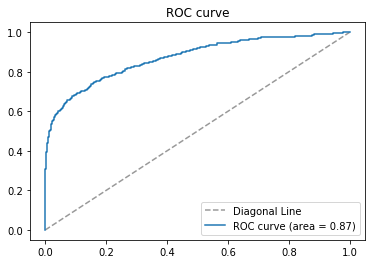

In [37]:
Draw_roc(AUC(y_true, pos_prob_list))

In [39]:
Gini(AUC(y_true, pos_prob_list))

0.7424193095036853

In [40]:
import pickle

In [42]:
#保存训练好的模型
save_classifier = open('catboost5.pickle', 'wb')
pickle.dump(cb1, save_classifier)
save_classifier.close()

In [43]:
classifier_f = open('catboost5.pickle', 'rb')
classifier = pickle.load(classifier_f)
classifier_f.close()

<font face="微软雅黑" size=3 color=#A52A2A > PSI分析案例：2018年Q3与Q4数据

In [46]:
#用筛选后的数据（11个特征）做2018年Q3和Q4的模型稳定性分析（PSI）

data = pd.read_excel('data_Q4_filter.xlsx')

In [48]:
data

,installment,total_rec_prncp,last_pymnt_amnt,total_pymnt,total_pymnt_inv,int_rate,total_rec_int,out_prncp_inv,grade,mo_sin_old_rev_tl_op,target
0,324.23,478.34,324.23,639.85,639.85,0.1033,161.51,9521.66,1,275,0
1,84.92,113.98,84.92,167.02,167.02,0.1356,53.04,2386.02,2,212,0
2,276.49,283.37,276.49,539.42,539.42,0.1356,256.05,11716.63,2,149,0
3,352.69,345.43,352.69,687.29,686.14,0.1447,341.86,14630.15,2,230,0
4,406.04,335.37,406.04,788.12,788.12,0.1797,452.75,15664.63,3,158,0
...,...,...,...,...,...,...,...,...,...,...,...
128407,797.53,1025.67,797.53,1547.08,1547.08,0.1502,521.41,0.00,2,397,1
128408,346.76,1136.05,346.76,1725.46,1725.46,0.1502,589.41,8863.95,2,434,0
128409,169.83,579.60,169.83,845.38,845.38,0.1356,265.78,4420.40,2,85,0
128410,327.68,1199.47,327.68,1623.04,1582.46,0.1106,423.57,8580.51,1,119,0


In [50]:
X = data.loc[:, 'installment':'mo_sin_old_rev_tl_op']
y = data.loc[:, 'target']

In [51]:
train_x, test_x, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [53]:
cb2 = cb.CatBoostClassifier()

In [54]:
cb2.fit(train_x, y_train)

Learning rate set to 0.070334
0:	learn: 0.5519170	total: 20.5ms	remaining: 20.5s
1:	learn: 0.4426978	total: 30.6ms	remaining: 15.3s
2:	learn: 0.3556179	total: 41.2ms	remaining: 13.7s
3:	learn: 0.2880283	total: 50.7ms	remaining: 12.6s
4:	learn: 0.2403228	total: 60.7ms	remaining: 12.1s
5:	learn: 0.2022267	total: 70.5ms	remaining: 11.7s
6:	learn: 0.1714852	total: 80.6ms	remaining: 11.4s
7:	learn: 0.1488954	total: 92ms	remaining: 11.4s
8:	learn: 0.1313442	total: 103ms	remaining: 11.3s
9:	learn: 0.1169044	total: 113ms	remaining: 11.1s
10:	learn: 0.1056648	total: 122ms	remaining: 11s
11:	learn: 0.0966685	total: 133ms	remaining: 10.9s
12:	learn: 0.0895204	total: 142ms	remaining: 10.8s
13:	learn: 0.0832948	total: 154ms	remaining: 10.8s
14:	learn: 0.0785367	total: 162ms	remaining: 10.7s
15:	learn: 0.0748348	total: 172ms	remaining: 10.6s
16:	learn: 0.0717545	total: 183ms	remaining: 10.6s
17:	learn: 0.0692629	total: 192ms	remaining: 10.5s
18:	learn: 0.0667780	total: 202ms	remaining: 10.4s
19:	lea

171:	learn: 0.0442020	total: 1.79s	remaining: 8.61s
172:	learn: 0.0441618	total: 1.8s	remaining: 8.61s
173:	learn: 0.0441358	total: 1.81s	remaining: 8.59s
174:	learn: 0.0441138	total: 1.82s	remaining: 8.57s
175:	learn: 0.0440791	total: 1.83s	remaining: 8.55s
176:	learn: 0.0440628	total: 1.83s	remaining: 8.53s
177:	learn: 0.0440153	total: 1.84s	remaining: 8.52s
178:	learn: 0.0439939	total: 1.85s	remaining: 8.49s
179:	learn: 0.0439856	total: 1.86s	remaining: 8.48s
180:	learn: 0.0439571	total: 1.87s	remaining: 8.46s
181:	learn: 0.0439446	total: 1.88s	remaining: 8.44s
182:	learn: 0.0439163	total: 1.89s	remaining: 8.42s
183:	learn: 0.0438961	total: 1.9s	remaining: 8.4s
184:	learn: 0.0438835	total: 1.9s	remaining: 8.38s
185:	learn: 0.0438482	total: 1.91s	remaining: 8.37s
186:	learn: 0.0438145	total: 1.92s	remaining: 8.35s
187:	learn: 0.0437982	total: 1.93s	remaining: 8.33s
188:	learn: 0.0437865	total: 1.94s	remaining: 8.31s
189:	learn: 0.0437515	total: 1.95s	remaining: 8.3s
190:	learn: 0.043

330:	learn: 0.0407623	total: 3.4s	remaining: 6.87s
331:	learn: 0.0407468	total: 3.41s	remaining: 6.87s
332:	learn: 0.0407179	total: 3.42s	remaining: 6.86s
333:	learn: 0.0407043	total: 3.44s	remaining: 6.85s
334:	learn: 0.0406858	total: 3.44s	remaining: 6.84s
335:	learn: 0.0406695	total: 3.46s	remaining: 6.83s
336:	learn: 0.0406493	total: 3.46s	remaining: 6.82s
337:	learn: 0.0406135	total: 3.48s	remaining: 6.81s
338:	learn: 0.0406019	total: 3.48s	remaining: 6.79s
339:	learn: 0.0405747	total: 3.49s	remaining: 6.78s
340:	learn: 0.0405614	total: 3.5s	remaining: 6.77s
341:	learn: 0.0405435	total: 3.51s	remaining: 6.76s
342:	learn: 0.0405221	total: 3.52s	remaining: 6.75s
343:	learn: 0.0405172	total: 3.53s	remaining: 6.74s
344:	learn: 0.0405034	total: 3.54s	remaining: 6.72s
345:	learn: 0.0404901	total: 3.55s	remaining: 6.71s
346:	learn: 0.0404788	total: 3.56s	remaining: 6.7s
347:	learn: 0.0404717	total: 3.57s	remaining: 6.69s
348:	learn: 0.0404612	total: 3.58s	remaining: 6.69s
349:	learn: 0.0

492:	learn: 0.0382105	total: 5.01s	remaining: 5.15s
493:	learn: 0.0381850	total: 5.03s	remaining: 5.15s
494:	learn: 0.0381679	total: 5.05s	remaining: 5.15s
495:	learn: 0.0381615	total: 5.06s	remaining: 5.14s
496:	learn: 0.0381332	total: 5.08s	remaining: 5.14s
497:	learn: 0.0381260	total: 5.09s	remaining: 5.13s
498:	learn: 0.0381074	total: 5.09s	remaining: 5.12s
499:	learn: 0.0380983	total: 5.1s	remaining: 5.1s
500:	learn: 0.0380896	total: 5.11s	remaining: 5.09s
501:	learn: 0.0380824	total: 5.12s	remaining: 5.08s
502:	learn: 0.0380706	total: 5.13s	remaining: 5.07s
503:	learn: 0.0380595	total: 5.14s	remaining: 5.06s
504:	learn: 0.0380444	total: 5.15s	remaining: 5.05s
505:	learn: 0.0380380	total: 5.16s	remaining: 5.04s
506:	learn: 0.0380254	total: 5.17s	remaining: 5.02s
507:	learn: 0.0379861	total: 5.18s	remaining: 5.01s
508:	learn: 0.0379725	total: 5.19s	remaining: 5s
509:	learn: 0.0379562	total: 5.2s	remaining: 4.99s
510:	learn: 0.0379465	total: 5.21s	remaining: 4.98s
511:	learn: 0.0379

668:	learn: 0.0358589	total: 6.79s	remaining: 3.36s
669:	learn: 0.0358425	total: 6.8s	remaining: 3.35s
670:	learn: 0.0358260	total: 6.81s	remaining: 3.34s
671:	learn: 0.0358120	total: 6.82s	remaining: 3.33s
672:	learn: 0.0358046	total: 6.83s	remaining: 3.32s
673:	learn: 0.0357934	total: 6.84s	remaining: 3.31s
674:	learn: 0.0357806	total: 6.85s	remaining: 3.3s
675:	learn: 0.0357686	total: 6.86s	remaining: 3.29s
676:	learn: 0.0357590	total: 6.87s	remaining: 3.28s
677:	learn: 0.0357504	total: 6.88s	remaining: 3.27s
678:	learn: 0.0357323	total: 6.89s	remaining: 3.26s
679:	learn: 0.0357141	total: 6.9s	remaining: 3.25s
680:	learn: 0.0356990	total: 6.91s	remaining: 3.24s
681:	learn: 0.0356949	total: 6.92s	remaining: 3.23s
682:	learn: 0.0356570	total: 6.93s	remaining: 3.22s
683:	learn: 0.0356451	total: 6.94s	remaining: 3.21s
684:	learn: 0.0356412	total: 6.95s	remaining: 3.2s
685:	learn: 0.0356312	total: 6.96s	remaining: 3.19s
686:	learn: 0.0356244	total: 6.97s	remaining: 3.18s
687:	learn: 0.03

827:	learn: 0.0341124	total: 8.39s	remaining: 1.74s
828:	learn: 0.0340922	total: 8.4s	remaining: 1.73s
829:	learn: 0.0340720	total: 8.41s	remaining: 1.72s
830:	learn: 0.0340512	total: 8.43s	remaining: 1.71s
831:	learn: 0.0340446	total: 8.44s	remaining: 1.7s
832:	learn: 0.0340335	total: 8.45s	remaining: 1.69s
833:	learn: 0.0340265	total: 8.46s	remaining: 1.68s
834:	learn: 0.0340047	total: 8.46s	remaining: 1.67s
835:	learn: 0.0339952	total: 8.47s	remaining: 1.66s
836:	learn: 0.0339859	total: 8.48s	remaining: 1.65s
837:	learn: 0.0339730	total: 8.49s	remaining: 1.64s
838:	learn: 0.0339706	total: 8.5s	remaining: 1.63s
839:	learn: 0.0339592	total: 8.51s	remaining: 1.62s
840:	learn: 0.0339512	total: 8.52s	remaining: 1.61s
841:	learn: 0.0339472	total: 8.53s	remaining: 1.6s
842:	learn: 0.0339311	total: 8.54s	remaining: 1.59s
843:	learn: 0.0339275	total: 8.55s	remaining: 1.58s
844:	learn: 0.0339088	total: 8.56s	remaining: 1.57s
845:	learn: 0.0338897	total: 8.57s	remaining: 1.56s
846:	learn: 0.03

991:	learn: 0.0324481	total: 10s	remaining: 80.6ms
992:	learn: 0.0324369	total: 10s	remaining: 70.5ms
993:	learn: 0.0324325	total: 10s	remaining: 60.5ms
994:	learn: 0.0324210	total: 10s	remaining: 50.4ms
995:	learn: 0.0324063	total: 10s	remaining: 40.3ms
996:	learn: 0.0323895	total: 10s	remaining: 30.2ms
997:	learn: 0.0323840	total: 10.1s	remaining: 20.2ms
998:	learn: 0.0323749	total: 10.1s	remaining: 10.1ms
999:	learn: 0.0323721	total: 10.1s	remaining: 0us


<font face="微软雅黑" size=3 color=#A52A2A > 数据降维（非PCA）与特征权重的计算

In [151]:
#数据清洗后的降维操作(以110个变量为例)
filename = 'data1.csv'
data_x = pd.read_csv(filename)
data_x

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_2ership,annual_inc,...,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,disbursement_method,debt_settlement_flag,target
0,10000,10000,10000.0,0,0.1033,324.23,1,0,0,280000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,2500,2500,2500.0,0,0.1356,84.92,2,10,1,55000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
2,12000,12000,12000.0,1,0.1356,276.49,2,0,0,40000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
3,15000,15000,14975.0,1,0.1447,352.69,2,11,0,30000.0,...,48.8,0.0,15.0,0.0,0.0,NaN,0,1,0,0
4,16000,16000,16000.0,1,0.1797,406.04,3,5,0,51000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128407,23000,23000,23000.0,0,0.1502,797.53,2,10,0,75000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1
128408,10000,10000,10000.0,0,0.1502,346.76,2,5,0,38000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
128409,5000,5000,5000.0,0,0.1356,169.83,2,10,0,35360.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
128410,10000,10000,9750.0,0,0.1106,327.68,1,11,1,44400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0


In [153]:
feature_importances = cb1.feature_importances_
names = data_x.columns
list_feature_importances = list(zip(feature_importances, names))
df_feature_importances = pd.DataFrame(list_feature_importances)
df_feature_importances.to_excel('catboost_110变量信息增益.xlsx')  #在excel中

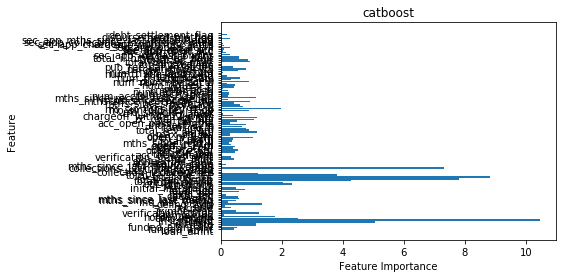

In [160]:
n_features=data_x.shape[1] - 1 #target列省略
plt.barh(range(n_features), feature_importances, align='center')
plt.yticks(np.arange(n_features), data_x.columns)
plt.title('catboost')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
#这个语句不跑，懒得再挑新变量
#cb.fit(train_x, y_train, cat_features = [9, 10, 11, 12，13]) 以第9个到第13个数值型变量为categorical variables
#上述语句适用于字符型变量。catboost接受nan，但不接受空值，所有空值都需用nan替换。在训练结果上，字符型作数值型处理的f1_score, AUC等指标较好。

<font face="微软雅黑" size=3 color=#A52A2A > GridSearchCV 网格调参模块

In [164]:
#调参

params = {'depth': [4, 7, 10],
        'learning_rate': [0.03, 0.1, 0.15],
        'l2_leaf_reg': [1, 4, 9],
        'iterations': [300]}
cb_model = GridSearchCV(cb1, params, scoring='roc_auc')

In [165]:
cb_model.fit(train_x, y_train)

0:	learn: 0.6323205	total: 25ms	remaining: 7.48s
1:	learn: 0.5726550	total: 32.3ms	remaining: 4.82s
2:	learn: 0.5222673	total: 40.3ms	remaining: 3.98s
3:	learn: 0.4739013	total: 47.6ms	remaining: 3.52s
4:	learn: 0.4333692	total: 55.8ms	remaining: 3.29s
5:	learn: 0.3952784	total: 63.8ms	remaining: 3.12s
6:	learn: 0.3613165	total: 71.2ms	remaining: 2.98s
7:	learn: 0.3327796	total: 78.9ms	remaining: 2.88s
8:	learn: 0.3067314	total: 86.7ms	remaining: 2.8s
9:	learn: 0.2821381	total: 93.8ms	remaining: 2.72s
10:	learn: 0.2613615	total: 102ms	remaining: 2.68s
11:	learn: 0.2414597	total: 109ms	remaining: 2.61s
12:	learn: 0.2243059	total: 117ms	remaining: 2.58s
13:	learn: 0.2087136	total: 124ms	remaining: 2.52s
14:	learn: 0.1949186	total: 131ms	remaining: 2.49s
15:	learn: 0.1828076	total: 138ms	remaining: 2.44s
16:	learn: 0.1720047	total: 146ms	remaining: 2.42s
17:	learn: 0.1619214	total: 152ms	remaining: 2.38s
18:	learn: 0.1532508	total: 159ms	remaining: 2.35s
19:	learn: 0.1449666	total: 166ms	

178:	learn: 0.0501869	total: 1.43s	remaining: 968ms
179:	learn: 0.0501548	total: 1.44s	remaining: 960ms
180:	learn: 0.0501192	total: 1.45s	remaining: 952ms
181:	learn: 0.0500916	total: 1.47s	remaining: 952ms
182:	learn: 0.0500407	total: 1.48s	remaining: 945ms
183:	learn: 0.0500147	total: 1.49s	remaining: 936ms
184:	learn: 0.0499814	total: 1.49s	remaining: 929ms
185:	learn: 0.0499519	total: 1.5s	remaining: 920ms
186:	learn: 0.0499200	total: 1.51s	remaining: 912ms
187:	learn: 0.0498843	total: 1.52s	remaining: 904ms
188:	learn: 0.0498720	total: 1.52s	remaining: 896ms
189:	learn: 0.0498426	total: 1.53s	remaining: 887ms
190:	learn: 0.0498095	total: 1.54s	remaining: 879ms
191:	learn: 0.0497599	total: 1.55s	remaining: 870ms
192:	learn: 0.0497353	total: 1.55s	remaining: 862ms
193:	learn: 0.0497207	total: 1.56s	remaining: 854ms
194:	learn: 0.0496962	total: 1.57s	remaining: 845ms
195:	learn: 0.0496538	total: 1.58s	remaining: 837ms
196:	learn: 0.0496119	total: 1.59s	remaining: 829ms
197:	learn: 0

46:	learn: 0.0684301	total: 374ms	remaining: 2.01s
47:	learn: 0.0675739	total: 385ms	remaining: 2.02s
48:	learn: 0.0667364	total: 395ms	remaining: 2.02s
49:	learn: 0.0660164	total: 404ms	remaining: 2.02s
50:	learn: 0.0654021	total: 413ms	remaining: 2.02s
51:	learn: 0.0647726	total: 421ms	remaining: 2.01s
52:	learn: 0.0642821	total: 431ms	remaining: 2.01s
53:	learn: 0.0636740	total: 438ms	remaining: 2s
54:	learn: 0.0632280	total: 448ms	remaining: 1.99s
55:	learn: 0.0626946	total: 456ms	remaining: 1.99s
56:	learn: 0.0621654	total: 465ms	remaining: 1.98s
57:	learn: 0.0617713	total: 475ms	remaining: 1.98s
58:	learn: 0.0613924	total: 483ms	remaining: 1.97s
59:	learn: 0.0611005	total: 493ms	remaining: 1.97s
60:	learn: 0.0608325	total: 500ms	remaining: 1.96s
61:	learn: 0.0605507	total: 509ms	remaining: 1.96s
62:	learn: 0.0602084	total: 517ms	remaining: 1.95s
63:	learn: 0.0599503	total: 527ms	remaining: 1.94s
64:	learn: 0.0596236	total: 535ms	remaining: 1.93s
65:	learn: 0.0593590	total: 544ms	

217:	learn: 0.0486955	total: 1.79s	remaining: 675ms
218:	learn: 0.0486707	total: 1.81s	remaining: 668ms
219:	learn: 0.0486472	total: 1.81s	remaining: 660ms
220:	learn: 0.0486207	total: 1.82s	remaining: 652ms
221:	learn: 0.0485802	total: 1.83s	remaining: 644ms
222:	learn: 0.0485647	total: 1.84s	remaining: 636ms
223:	learn: 0.0485411	total: 1.85s	remaining: 627ms
224:	learn: 0.0485175	total: 1.86s	remaining: 619ms
225:	learn: 0.0484726	total: 1.87s	remaining: 611ms
226:	learn: 0.0484506	total: 1.87s	remaining: 603ms
227:	learn: 0.0484361	total: 1.88s	remaining: 595ms
228:	learn: 0.0484217	total: 1.89s	remaining: 586ms
229:	learn: 0.0483917	total: 1.9s	remaining: 578ms
230:	learn: 0.0483720	total: 1.91s	remaining: 570ms
231:	learn: 0.0483528	total: 1.92s	remaining: 561ms
232:	learn: 0.0483306	total: 1.92s	remaining: 553ms
233:	learn: 0.0483112	total: 1.93s	remaining: 545ms
234:	learn: 0.0482938	total: 1.94s	remaining: 537ms
235:	learn: 0.0482732	total: 1.95s	remaining: 528ms
236:	learn: 0

88:	learn: 0.0548292	total: 1.13s	remaining: 2.67s
89:	learn: 0.0547111	total: 1.14s	remaining: 2.66s
90:	learn: 0.0546264	total: 1.15s	remaining: 2.65s
91:	learn: 0.0545112	total: 1.16s	remaining: 2.63s
92:	learn: 0.0544848	total: 1.18s	remaining: 2.62s
93:	learn: 0.0543410	total: 1.19s	remaining: 2.61s
94:	learn: 0.0542593	total: 1.2s	remaining: 2.59s
95:	learn: 0.0540778	total: 1.21s	remaining: 2.58s
96:	learn: 0.0539529	total: 1.23s	remaining: 2.57s
97:	learn: 0.0538381	total: 1.24s	remaining: 2.56s
98:	learn: 0.0537340	total: 1.25s	remaining: 2.55s
99:	learn: 0.0536259	total: 1.26s	remaining: 2.53s
100:	learn: 0.0535292	total: 1.28s	remaining: 2.52s
101:	learn: 0.0534338	total: 1.29s	remaining: 2.51s
102:	learn: 0.0533455	total: 1.3s	remaining: 2.49s
103:	learn: 0.0532418	total: 1.32s	remaining: 2.48s
104:	learn: 0.0531685	total: 1.33s	remaining: 2.47s
105:	learn: 0.0530522	total: 1.34s	remaining: 2.46s
106:	learn: 0.0529641	total: 1.35s	remaining: 2.44s
107:	learn: 0.0528805	tota

251:	learn: 0.0474239	total: 3.32s	remaining: 633ms
252:	learn: 0.0474130	total: 3.34s	remaining: 620ms
253:	learn: 0.0474004	total: 3.35s	remaining: 606ms
254:	learn: 0.0473843	total: 3.36s	remaining: 593ms
255:	learn: 0.0473513	total: 3.37s	remaining: 580ms
256:	learn: 0.0473315	total: 3.39s	remaining: 567ms
257:	learn: 0.0473111	total: 3.4s	remaining: 554ms
258:	learn: 0.0472930	total: 3.42s	remaining: 541ms
259:	learn: 0.0472691	total: 3.43s	remaining: 527ms
260:	learn: 0.0472476	total: 3.44s	remaining: 514ms
261:	learn: 0.0472348	total: 3.45s	remaining: 501ms
262:	learn: 0.0472303	total: 3.46s	remaining: 488ms
263:	learn: 0.0472119	total: 3.48s	remaining: 474ms
264:	learn: 0.0472054	total: 3.49s	remaining: 461ms
265:	learn: 0.0471888	total: 3.5s	remaining: 448ms
266:	learn: 0.0471784	total: 3.51s	remaining: 434ms
267:	learn: 0.0471657	total: 3.52s	remaining: 421ms
268:	learn: 0.0471478	total: 3.54s	remaining: 408ms
269:	learn: 0.0471314	total: 3.55s	remaining: 394ms
270:	learn: 0.

111:	learn: 0.0537771	total: 1.48s	remaining: 2.48s
112:	learn: 0.0537296	total: 1.49s	remaining: 2.47s
113:	learn: 0.0536779	total: 1.5s	remaining: 2.45s
114:	learn: 0.0535780	total: 1.52s	remaining: 2.44s
115:	learn: 0.0535159	total: 1.53s	remaining: 2.42s
116:	learn: 0.0534625	total: 1.54s	remaining: 2.41s
117:	learn: 0.0533906	total: 1.55s	remaining: 2.39s
118:	learn: 0.0533532	total: 1.56s	remaining: 2.38s
119:	learn: 0.0532808	total: 1.58s	remaining: 2.36s
120:	learn: 0.0532004	total: 1.59s	remaining: 2.35s
121:	learn: 0.0531701	total: 1.6s	remaining: 2.33s
122:	learn: 0.0531037	total: 1.61s	remaining: 2.32s
123:	learn: 0.0530753	total: 1.63s	remaining: 2.31s
124:	learn: 0.0530490	total: 1.64s	remaining: 2.29s
125:	learn: 0.0529304	total: 1.65s	remaining: 2.28s
126:	learn: 0.0528830	total: 1.66s	remaining: 2.26s
127:	learn: 0.0528553	total: 1.67s	remaining: 2.25s
128:	learn: 0.0528238	total: 1.69s	remaining: 2.23s
129:	learn: 0.0527854	total: 1.7s	remaining: 2.22s
130:	learn: 0.0

273:	learn: 0.0483214	total: 3.44s	remaining: 327ms
274:	learn: 0.0483026	total: 3.46s	remaining: 314ms
275:	learn: 0.0482888	total: 3.47s	remaining: 301ms
276:	learn: 0.0482711	total: 3.48s	remaining: 289ms
277:	learn: 0.0482482	total: 3.49s	remaining: 276ms
278:	learn: 0.0482259	total: 3.5s	remaining: 264ms
279:	learn: 0.0482041	total: 3.51s	remaining: 251ms
280:	learn: 0.0481939	total: 3.52s	remaining: 238ms
281:	learn: 0.0481809	total: 3.54s	remaining: 226ms
282:	learn: 0.0481647	total: 3.55s	remaining: 213ms
283:	learn: 0.0481357	total: 3.56s	remaining: 200ms
284:	learn: 0.0481110	total: 3.57s	remaining: 188ms
285:	learn: 0.0481060	total: 3.58s	remaining: 175ms
286:	learn: 0.0480994	total: 3.59s	remaining: 163ms
287:	learn: 0.0480748	total: 3.6s	remaining: 150ms
288:	learn: 0.0480622	total: 3.62s	remaining: 138ms
289:	learn: 0.0480409	total: 3.63s	remaining: 125ms
290:	learn: 0.0479879	total: 3.64s	remaining: 113ms
291:	learn: 0.0479655	total: 3.65s	remaining: 100ms
292:	learn: 0.

136:	learn: 0.0516804	total: 1.65s	remaining: 1.96s
137:	learn: 0.0516550	total: 1.66s	remaining: 1.95s
138:	learn: 0.0515879	total: 1.67s	remaining: 1.94s
139:	learn: 0.0515390	total: 1.68s	remaining: 1.92s
140:	learn: 0.0514587	total: 1.7s	remaining: 1.91s
141:	learn: 0.0514149	total: 1.71s	remaining: 1.9s
142:	learn: 0.0513712	total: 1.72s	remaining: 1.89s
143:	learn: 0.0513228	total: 1.73s	remaining: 1.87s
144:	learn: 0.0512880	total: 1.74s	remaining: 1.86s
145:	learn: 0.0512455	total: 1.75s	remaining: 1.85s
146:	learn: 0.0512202	total: 1.76s	remaining: 1.83s
147:	learn: 0.0511767	total: 1.77s	remaining: 1.82s
148:	learn: 0.0511197	total: 1.78s	remaining: 1.81s
149:	learn: 0.0510771	total: 1.79s	remaining: 1.79s
150:	learn: 0.0510387	total: 1.8s	remaining: 1.78s
151:	learn: 0.0509902	total: 1.82s	remaining: 1.77s
152:	learn: 0.0509469	total: 1.83s	remaining: 1.75s
153:	learn: 0.0509016	total: 1.84s	remaining: 1.74s
154:	learn: 0.0508752	total: 1.84s	remaining: 1.73s
155:	learn: 0.0

0:	learn: 0.5068472	total: 11.2ms	remaining: 3.35s
1:	learn: 0.3662873	total: 21.2ms	remaining: 3.15s
2:	learn: 0.2739420	total: 30.9ms	remaining: 3.06s
3:	learn: 0.2091088	total: 41.6ms	remaining: 3.08s
4:	learn: 0.1662089	total: 50.9ms	remaining: 3s
5:	learn: 0.1365342	total: 61.3ms	remaining: 3s
6:	learn: 0.1164713	total: 71.1ms	remaining: 2.98s
7:	learn: 0.1029080	total: 80.2ms	remaining: 2.93s
8:	learn: 0.0921476	total: 90.6ms	remaining: 2.93s
9:	learn: 0.0837854	total: 100ms	remaining: 2.91s
10:	learn: 0.0780714	total: 114ms	remaining: 2.98s
11:	learn: 0.0737975	total: 124ms	remaining: 2.97s
12:	learn: 0.0698683	total: 134ms	remaining: 2.96s
13:	learn: 0.0675145	total: 143ms	remaining: 2.92s
14:	learn: 0.0657417	total: 156ms	remaining: 2.97s
15:	learn: 0.0640000	total: 166ms	remaining: 2.94s
16:	learn: 0.0622901	total: 175ms	remaining: 2.91s
17:	learn: 0.0609075	total: 186ms	remaining: 2.91s
18:	learn: 0.0599235	total: 197ms	remaining: 2.91s
19:	learn: 0.0589838	total: 206ms	rema

172:	learn: 0.0446239	total: 1.8s	remaining: 1.32s
173:	learn: 0.0446016	total: 1.81s	remaining: 1.31s
174:	learn: 0.0445719	total: 1.82s	remaining: 1.3s
175:	learn: 0.0445496	total: 1.83s	remaining: 1.29s
176:	learn: 0.0445262	total: 1.83s	remaining: 1.27s
177:	learn: 0.0444964	total: 1.85s	remaining: 1.26s
178:	learn: 0.0444738	total: 1.85s	remaining: 1.25s
179:	learn: 0.0444435	total: 1.86s	remaining: 1.24s
180:	learn: 0.0444260	total: 1.87s	remaining: 1.23s
181:	learn: 0.0444002	total: 1.88s	remaining: 1.22s
182:	learn: 0.0443689	total: 1.89s	remaining: 1.21s
183:	learn: 0.0443585	total: 1.9s	remaining: 1.2s
184:	learn: 0.0443267	total: 1.91s	remaining: 1.19s
185:	learn: 0.0443042	total: 1.92s	remaining: 1.18s
186:	learn: 0.0442890	total: 1.93s	remaining: 1.17s
187:	learn: 0.0442341	total: 1.94s	remaining: 1.16s
188:	learn: 0.0441908	total: 1.95s	remaining: 1.15s
189:	learn: 0.0441568	total: 1.96s	remaining: 1.14s
190:	learn: 0.0441318	total: 1.97s	remaining: 1.13s
191:	learn: 0.04

39:	learn: 0.0516432	total: 391ms	remaining: 2.54s
40:	learn: 0.0515428	total: 403ms	remaining: 2.54s
41:	learn: 0.0513180	total: 413ms	remaining: 2.54s
42:	learn: 0.0511577	total: 424ms	remaining: 2.53s
43:	learn: 0.0509849	total: 434ms	remaining: 2.52s
44:	learn: 0.0508337	total: 444ms	remaining: 2.51s
45:	learn: 0.0507199	total: 453ms	remaining: 2.5s
46:	learn: 0.0505860	total: 464ms	remaining: 2.5s
47:	learn: 0.0504596	total: 474ms	remaining: 2.49s
48:	learn: 0.0503644	total: 484ms	remaining: 2.48s
49:	learn: 0.0502563	total: 495ms	remaining: 2.47s
50:	learn: 0.0501673	total: 505ms	remaining: 2.46s
51:	learn: 0.0501093	total: 514ms	remaining: 2.45s
52:	learn: 0.0500584	total: 525ms	remaining: 2.45s
53:	learn: 0.0499396	total: 536ms	remaining: 2.44s
54:	learn: 0.0498419	total: 546ms	remaining: 2.43s
55:	learn: 0.0497137	total: 556ms	remaining: 2.42s
56:	learn: 0.0495596	total: 567ms	remaining: 2.42s
57:	learn: 0.0494615	total: 578ms	remaining: 2.41s
58:	learn: 0.0493721	total: 588ms

215:	learn: 0.0437233	total: 2.16s	remaining: 841ms
216:	learn: 0.0436946	total: 2.17s	remaining: 831ms
217:	learn: 0.0436744	total: 2.18s	remaining: 821ms
218:	learn: 0.0436401	total: 2.19s	remaining: 812ms
219:	learn: 0.0436172	total: 2.21s	remaining: 802ms
220:	learn: 0.0436032	total: 2.21s	remaining: 792ms
221:	learn: 0.0435791	total: 2.23s	remaining: 782ms
222:	learn: 0.0435494	total: 2.23s	remaining: 772ms
223:	learn: 0.0435374	total: 2.24s	remaining: 761ms
224:	learn: 0.0435085	total: 2.25s	remaining: 751ms
225:	learn: 0.0434939	total: 2.26s	remaining: 741ms
226:	learn: 0.0434779	total: 2.27s	remaining: 731ms
227:	learn: 0.0434515	total: 2.28s	remaining: 721ms
228:	learn: 0.0433928	total: 2.29s	remaining: 711ms
229:	learn: 0.0433720	total: 2.3s	remaining: 701ms
230:	learn: 0.0433533	total: 2.31s	remaining: 691ms
231:	learn: 0.0433276	total: 2.32s	remaining: 681ms
232:	learn: 0.0433134	total: 2.33s	remaining: 672ms
233:	learn: 0.0432876	total: 2.35s	remaining: 662ms
234:	learn: 0

91:	learn: 0.0465677	total: 908ms	remaining: 2.05s
92:	learn: 0.0464972	total: 919ms	remaining: 2.04s
93:	learn: 0.0464543	total: 929ms	remaining: 2.04s
94:	learn: 0.0464031	total: 938ms	remaining: 2.02s
95:	learn: 0.0463767	total: 947ms	remaining: 2.01s
96:	learn: 0.0463183	total: 957ms	remaining: 2s
97:	learn: 0.0462692	total: 966ms	remaining: 1.99s
98:	learn: 0.0462361	total: 976ms	remaining: 1.98s
99:	learn: 0.0461948	total: 986ms	remaining: 1.97s
100:	learn: 0.0461469	total: 995ms	remaining: 1.96s
101:	learn: 0.0460949	total: 1s	remaining: 1.95s
102:	learn: 0.0460529	total: 1.01s	remaining: 1.94s
103:	learn: 0.0460349	total: 1.02s	remaining: 1.93s
104:	learn: 0.0460181	total: 1.03s	remaining: 1.92s
105:	learn: 0.0459784	total: 1.04s	remaining: 1.91s
106:	learn: 0.0459291	total: 1.05s	remaining: 1.9s
107:	learn: 0.0458840	total: 1.06s	remaining: 1.89s
108:	learn: 0.0458487	total: 1.07s	remaining: 1.88s
109:	learn: 0.0458142	total: 1.08s	remaining: 1.87s
110:	learn: 0.0457404	total:

256:	learn: 0.0419339	total: 2.52s	remaining: 422ms
257:	learn: 0.0419160	total: 2.54s	remaining: 413ms
258:	learn: 0.0418928	total: 2.54s	remaining: 403ms
259:	learn: 0.0418756	total: 2.55s	remaining: 393ms
260:	learn: 0.0418593	total: 2.56s	remaining: 383ms
261:	learn: 0.0418564	total: 2.57s	remaining: 373ms
262:	learn: 0.0418372	total: 2.58s	remaining: 363ms
263:	learn: 0.0418217	total: 2.59s	remaining: 353ms
264:	learn: 0.0418048	total: 2.6s	remaining: 343ms
265:	learn: 0.0417718	total: 2.61s	remaining: 333ms
266:	learn: 0.0417496	total: 2.62s	remaining: 324ms
267:	learn: 0.0417314	total: 2.63s	remaining: 314ms
268:	learn: 0.0416921	total: 2.64s	remaining: 304ms
269:	learn: 0.0416815	total: 2.65s	remaining: 294ms
270:	learn: 0.0416499	total: 2.65s	remaining: 284ms
271:	learn: 0.0416272	total: 2.66s	remaining: 274ms
272:	learn: 0.0416186	total: 2.67s	remaining: 264ms
273:	learn: 0.0416037	total: 2.68s	remaining: 254ms
274:	learn: 0.0415888	total: 2.69s	remaining: 244ms
275:	learn: 0

129:	learn: 0.0462029	total: 1.3s	remaining: 1.71s
130:	learn: 0.0461734	total: 1.32s	remaining: 1.7s
131:	learn: 0.0461315	total: 1.33s	remaining: 1.69s
132:	learn: 0.0460874	total: 1.34s	remaining: 1.68s
133:	learn: 0.0460430	total: 1.35s	remaining: 1.67s
134:	learn: 0.0460241	total: 1.36s	remaining: 1.66s
135:	learn: 0.0459705	total: 1.37s	remaining: 1.65s
136:	learn: 0.0459147	total: 1.38s	remaining: 1.64s
137:	learn: 0.0458815	total: 1.39s	remaining: 1.63s
138:	learn: 0.0458290	total: 1.4s	remaining: 1.63s
139:	learn: 0.0458025	total: 1.41s	remaining: 1.61s
140:	learn: 0.0457698	total: 1.42s	remaining: 1.61s
141:	learn: 0.0457413	total: 1.44s	remaining: 1.6s
142:	learn: 0.0457195	total: 1.44s	remaining: 1.59s
143:	learn: 0.0456692	total: 1.46s	remaining: 1.58s
144:	learn: 0.0456279	total: 1.47s	remaining: 1.57s
145:	learn: 0.0455857	total: 1.48s	remaining: 1.56s
146:	learn: 0.0455685	total: 1.49s	remaining: 1.55s
147:	learn: 0.0455170	total: 1.5s	remaining: 1.54s
148:	learn: 0.045

0:	learn: 0.5066276	total: 12.7ms	remaining: 3.8s
1:	learn: 0.3661076	total: 24.2ms	remaining: 3.61s
2:	learn: 0.2734902	total: 34.3ms	remaining: 3.4s
3:	learn: 0.2085986	total: 44ms	remaining: 3.25s
4:	learn: 0.1657063	total: 54.7ms	remaining: 3.23s
5:	learn: 0.1358821	total: 64.4ms	remaining: 3.15s
6:	learn: 0.1157657	total: 73.8ms	remaining: 3.09s
7:	learn: 0.1022822	total: 84ms	remaining: 3.07s
8:	learn: 0.0914754	total: 92.9ms	remaining: 3s
9:	learn: 0.0832525	total: 106ms	remaining: 3.07s
10:	learn: 0.0778961	total: 117ms	remaining: 3.07s
11:	learn: 0.0736697	total: 127ms	remaining: 3.04s
12:	learn: 0.0698194	total: 137ms	remaining: 3.02s
13:	learn: 0.0671100	total: 148ms	remaining: 3.02s
14:	learn: 0.0653847	total: 156ms	remaining: 2.97s
15:	learn: 0.0635999	total: 166ms	remaining: 2.95s
16:	learn: 0.0619140	total: 176ms	remaining: 2.94s
17:	learn: 0.0605562	total: 186ms	remaining: 2.91s
18:	learn: 0.0597309	total: 195ms	remaining: 2.89s
19:	learn: 0.0589648	total: 204ms	remaini

174:	learn: 0.0447422	total: 1.91s	remaining: 1.36s
175:	learn: 0.0447290	total: 1.93s	remaining: 1.36s
176:	learn: 0.0446763	total: 1.94s	remaining: 1.35s
177:	learn: 0.0446478	total: 1.95s	remaining: 1.33s
178:	learn: 0.0446211	total: 1.96s	remaining: 1.32s
179:	learn: 0.0446046	total: 1.97s	remaining: 1.31s
180:	learn: 0.0445742	total: 1.98s	remaining: 1.3s
181:	learn: 0.0445421	total: 1.99s	remaining: 1.29s
182:	learn: 0.0445201	total: 2s	remaining: 1.28s
183:	learn: 0.0445067	total: 2.01s	remaining: 1.27s
184:	learn: 0.0444817	total: 2.02s	remaining: 1.25s
185:	learn: 0.0444683	total: 2.03s	remaining: 1.24s
186:	learn: 0.0444230	total: 2.04s	remaining: 1.23s
187:	learn: 0.0444094	total: 2.05s	remaining: 1.22s
188:	learn: 0.0443918	total: 2.06s	remaining: 1.21s
189:	learn: 0.0443707	total: 2.07s	remaining: 1.2s
190:	learn: 0.0443618	total: 2.08s	remaining: 1.19s
191:	learn: 0.0443409	total: 2.09s	remaining: 1.18s
192:	learn: 0.0443071	total: 2.1s	remaining: 1.17s
193:	learn: 0.0442

33:	learn: 0.0506068	total: 383ms	remaining: 3s
34:	learn: 0.0504987	total: 396ms	remaining: 3s
35:	learn: 0.0503470	total: 409ms	remaining: 3s
36:	learn: 0.0501973	total: 420ms	remaining: 2.99s
37:	learn: 0.0500502	total: 431ms	remaining: 2.97s
38:	learn: 0.0499639	total: 444ms	remaining: 2.97s
39:	learn: 0.0497966	total: 456ms	remaining: 2.96s
40:	learn: 0.0496187	total: 468ms	remaining: 2.96s
41:	learn: 0.0494576	total: 480ms	remaining: 2.95s
42:	learn: 0.0493955	total: 492ms	remaining: 2.94s
43:	learn: 0.0492197	total: 505ms	remaining: 2.94s
44:	learn: 0.0491396	total: 517ms	remaining: 2.93s
45:	learn: 0.0490298	total: 528ms	remaining: 2.91s
46:	learn: 0.0489073	total: 538ms	remaining: 2.9s
47:	learn: 0.0487964	total: 549ms	remaining: 2.88s
48:	learn: 0.0487379	total: 558ms	remaining: 2.86s
49:	learn: 0.0486699	total: 569ms	remaining: 2.85s
50:	learn: 0.0484724	total: 580ms	remaining: 2.83s
51:	learn: 0.0484066	total: 592ms	remaining: 2.82s
52:	learn: 0.0483677	total: 601ms	remaini

199:	learn: 0.0416412	total: 2.16s	remaining: 1.08s
200:	learn: 0.0416328	total: 2.17s	remaining: 1.07s
201:	learn: 0.0416100	total: 2.18s	remaining: 1.06s
202:	learn: 0.0415838	total: 2.19s	remaining: 1.05s
203:	learn: 0.0415726	total: 2.2s	remaining: 1.04s
204:	learn: 0.0415518	total: 2.21s	remaining: 1.02s
205:	learn: 0.0415296	total: 2.22s	remaining: 1.01s
206:	learn: 0.0415111	total: 2.23s	remaining: 1s
207:	learn: 0.0414702	total: 2.24s	remaining: 992ms
208:	learn: 0.0414397	total: 2.25s	remaining: 980ms
209:	learn: 0.0414150	total: 2.26s	remaining: 969ms
210:	learn: 0.0413673	total: 2.27s	remaining: 958ms
211:	learn: 0.0413377	total: 2.28s	remaining: 946ms
212:	learn: 0.0413180	total: 2.29s	remaining: 935ms
213:	learn: 0.0412459	total: 2.3s	remaining: 923ms
214:	learn: 0.0412375	total: 2.31s	remaining: 912ms
215:	learn: 0.0412204	total: 2.32s	remaining: 901ms
216:	learn: 0.0411779	total: 2.33s	remaining: 890ms
217:	learn: 0.0411379	total: 2.33s	remaining: 879ms
218:	learn: 0.041

71:	learn: 0.0465625	total: 725ms	remaining: 2.29s
72:	learn: 0.0465091	total: 737ms	remaining: 2.29s
73:	learn: 0.0464221	total: 749ms	remaining: 2.29s
74:	learn: 0.0463552	total: 760ms	remaining: 2.28s
75:	learn: 0.0463344	total: 773ms	remaining: 2.28s
76:	learn: 0.0462619	total: 785ms	remaining: 2.27s
77:	learn: 0.0462141	total: 797ms	remaining: 2.27s
78:	learn: 0.0461718	total: 806ms	remaining: 2.25s
79:	learn: 0.0461122	total: 817ms	remaining: 2.25s
80:	learn: 0.0460748	total: 827ms	remaining: 2.23s
81:	learn: 0.0460371	total: 836ms	remaining: 2.22s
82:	learn: 0.0459684	total: 847ms	remaining: 2.21s
83:	learn: 0.0459090	total: 856ms	remaining: 2.2s
84:	learn: 0.0458792	total: 866ms	remaining: 2.19s
85:	learn: 0.0458412	total: 877ms	remaining: 2.18s
86:	learn: 0.0457628	total: 887ms	remaining: 2.17s
87:	learn: 0.0457487	total: 897ms	remaining: 2.16s
88:	learn: 0.0457063	total: 909ms	remaining: 2.15s
89:	learn: 0.0456725	total: 918ms	remaining: 2.14s
90:	learn: 0.0456319	total: 928m

241:	learn: 0.0407890	total: 2.52s	remaining: 604ms
242:	learn: 0.0407595	total: 2.53s	remaining: 594ms
243:	learn: 0.0407340	total: 2.55s	remaining: 584ms
244:	learn: 0.0406744	total: 2.56s	remaining: 574ms
245:	learn: 0.0406291	total: 2.57s	remaining: 565ms
246:	learn: 0.0406071	total: 2.58s	remaining: 554ms
247:	learn: 0.0405788	total: 2.59s	remaining: 544ms
248:	learn: 0.0405599	total: 2.61s	remaining: 534ms
249:	learn: 0.0405175	total: 2.62s	remaining: 524ms
250:	learn: 0.0404513	total: 2.63s	remaining: 514ms
251:	learn: 0.0404416	total: 2.64s	remaining: 504ms
252:	learn: 0.0403792	total: 2.65s	remaining: 493ms
253:	learn: 0.0403615	total: 2.67s	remaining: 483ms
254:	learn: 0.0403412	total: 2.68s	remaining: 473ms
255:	learn: 0.0403302	total: 2.69s	remaining: 462ms
256:	learn: 0.0402873	total: 2.7s	remaining: 452ms
257:	learn: 0.0402668	total: 2.71s	remaining: 441ms
258:	learn: 0.0402520	total: 2.72s	remaining: 431ms
259:	learn: 0.0402292	total: 2.73s	remaining: 420ms
260:	learn: 0

113:	learn: 0.0439520	total: 1.28s	remaining: 2.08s
114:	learn: 0.0438945	total: 1.29s	remaining: 2.07s
115:	learn: 0.0438712	total: 1.3s	remaining: 2.06s
116:	learn: 0.0438371	total: 1.31s	remaining: 2.05s
117:	learn: 0.0437979	total: 1.32s	remaining: 2.04s
118:	learn: 0.0437329	total: 1.33s	remaining: 2.03s
119:	learn: 0.0437169	total: 1.34s	remaining: 2.02s
120:	learn: 0.0437006	total: 1.35s	remaining: 2s
121:	learn: 0.0436607	total: 1.36s	remaining: 1.99s
122:	learn: 0.0436223	total: 1.4s	remaining: 2.02s
123:	learn: 0.0435562	total: 1.42s	remaining: 2.01s
124:	learn: 0.0435181	total: 1.43s	remaining: 2s
125:	learn: 0.0434944	total: 1.44s	remaining: 1.99s
126:	learn: 0.0434748	total: 1.45s	remaining: 1.98s
127:	learn: 0.0434524	total: 1.46s	remaining: 1.96s
128:	learn: 0.0434046	total: 1.47s	remaining: 1.95s
129:	learn: 0.0433651	total: 1.49s	remaining: 1.94s
130:	learn: 0.0433167	total: 1.49s	remaining: 1.93s
131:	learn: 0.0432774	total: 1.5s	remaining: 1.92s
132:	learn: 0.0432653

277:	learn: 0.0392865	total: 3.07s	remaining: 243ms
278:	learn: 0.0392634	total: 3.08s	remaining: 232ms
279:	learn: 0.0392257	total: 3.09s	remaining: 221ms
280:	learn: 0.0392052	total: 3.1s	remaining: 210ms
281:	learn: 0.0391798	total: 3.11s	remaining: 199ms
282:	learn: 0.0391652	total: 3.12s	remaining: 188ms
283:	learn: 0.0391532	total: 3.13s	remaining: 176ms
284:	learn: 0.0391325	total: 3.14s	remaining: 165ms
285:	learn: 0.0391165	total: 3.15s	remaining: 154ms
286:	learn: 0.0390894	total: 3.16s	remaining: 143ms
287:	learn: 0.0390501	total: 3.17s	remaining: 132ms
288:	learn: 0.0390295	total: 3.18s	remaining: 121ms
289:	learn: 0.0390009	total: 3.19s	remaining: 110ms
290:	learn: 0.0389824	total: 3.2s	remaining: 99.1ms
291:	learn: 0.0389490	total: 3.21s	remaining: 88.1ms
292:	learn: 0.0389339	total: 3.22s	remaining: 77ms
293:	learn: 0.0389107	total: 3.23s	remaining: 66ms
294:	learn: 0.0388875	total: 3.25s	remaining: 55ms
295:	learn: 0.0388575	total: 3.26s	remaining: 44ms
296:	learn: 0.03

141:	learn: 0.0437486	total: 1.47s	remaining: 1.64s
142:	learn: 0.0436783	total: 1.49s	remaining: 1.63s
143:	learn: 0.0436379	total: 1.5s	remaining: 1.62s
144:	learn: 0.0436205	total: 1.51s	remaining: 1.61s
145:	learn: 0.0435849	total: 1.51s	remaining: 1.6s
146:	learn: 0.0435656	total: 1.52s	remaining: 1.59s
147:	learn: 0.0435352	total: 1.53s	remaining: 1.57s
148:	learn: 0.0434832	total: 1.54s	remaining: 1.56s
149:	learn: 0.0434409	total: 1.55s	remaining: 1.55s
150:	learn: 0.0433977	total: 1.56s	remaining: 1.54s
151:	learn: 0.0433679	total: 1.57s	remaining: 1.53s
152:	learn: 0.0433528	total: 1.58s	remaining: 1.52s
153:	learn: 0.0433331	total: 1.59s	remaining: 1.51s
154:	learn: 0.0433139	total: 1.6s	remaining: 1.5s
155:	learn: 0.0432720	total: 1.61s	remaining: 1.49s
156:	learn: 0.0432484	total: 1.62s	remaining: 1.48s
157:	learn: 0.0432140	total: 1.63s	remaining: 1.46s
158:	learn: 0.0431768	total: 1.64s	remaining: 1.45s
159:	learn: 0.0431599	total: 1.65s	remaining: 1.44s
160:	learn: 0.04

1:	learn: 0.2689312	total: 34.2ms	remaining: 5.09s
2:	learn: 0.1832101	total: 46ms	remaining: 4.55s
3:	learn: 0.1331882	total: 55.5ms	remaining: 4.11s
4:	learn: 0.1060247	total: 65.6ms	remaining: 3.87s
5:	learn: 0.0894478	total: 76.9ms	remaining: 3.77s
6:	learn: 0.0784634	total: 85.4ms	remaining: 3.57s
7:	learn: 0.0714738	total: 95.7ms	remaining: 3.49s
8:	learn: 0.0669668	total: 105ms	remaining: 3.4s
9:	learn: 0.0635602	total: 115ms	remaining: 3.34s
10:	learn: 0.0615214	total: 125ms	remaining: 3.29s
11:	learn: 0.0601228	total: 134ms	remaining: 3.22s
12:	learn: 0.0589264	total: 144ms	remaining: 3.18s
13:	learn: 0.0579507	total: 155ms	remaining: 3.17s
14:	learn: 0.0574140	total: 164ms	remaining: 3.12s
15:	learn: 0.0567320	total: 174ms	remaining: 3.08s
16:	learn: 0.0559102	total: 183ms	remaining: 3.05s
17:	learn: 0.0554006	total: 194ms	remaining: 3.03s
18:	learn: 0.0549568	total: 203ms	remaining: 3.01s
19:	learn: 0.0543190	total: 212ms	remaining: 2.97s
20:	learn: 0.0539539	total: 224ms	re

176:	learn: 0.0428439	total: 1.82s	remaining: 1.27s
177:	learn: 0.0428351	total: 1.83s	remaining: 1.26s
178:	learn: 0.0427989	total: 1.85s	remaining: 1.25s
179:	learn: 0.0427816	total: 1.85s	remaining: 1.24s
180:	learn: 0.0427234	total: 1.86s	remaining: 1.23s
181:	learn: 0.0427032	total: 1.87s	remaining: 1.21s
182:	learn: 0.0426773	total: 1.88s	remaining: 1.2s
183:	learn: 0.0426439	total: 1.89s	remaining: 1.19s
184:	learn: 0.0426194	total: 1.9s	remaining: 1.18s
185:	learn: 0.0425949	total: 1.91s	remaining: 1.17s
186:	learn: 0.0425771	total: 1.92s	remaining: 1.16s
187:	learn: 0.0425314	total: 1.93s	remaining: 1.15s
188:	learn: 0.0425029	total: 1.94s	remaining: 1.14s
189:	learn: 0.0424776	total: 1.95s	remaining: 1.13s
190:	learn: 0.0424540	total: 1.96s	remaining: 1.12s
191:	learn: 0.0424358	total: 1.97s	remaining: 1.1s
192:	learn: 0.0424149	total: 1.97s	remaining: 1.09s
193:	learn: 0.0423786	total: 1.98s	remaining: 1.08s
194:	learn: 0.0423593	total: 1.99s	remaining: 1.07s
195:	learn: 0.0

43:	learn: 0.0709418	total: 469ms	remaining: 2.73s
44:	learn: 0.0701208	total: 479ms	remaining: 2.71s
45:	learn: 0.0693143	total: 489ms	remaining: 2.7s
46:	learn: 0.0684918	total: 501ms	remaining: 2.7s
47:	learn: 0.0677657	total: 511ms	remaining: 2.68s
48:	learn: 0.0669245	total: 522ms	remaining: 2.67s
49:	learn: 0.0664078	total: 531ms	remaining: 2.65s
50:	learn: 0.0658060	total: 541ms	remaining: 2.64s
51:	learn: 0.0650894	total: 552ms	remaining: 2.63s
52:	learn: 0.0645230	total: 560ms	remaining: 2.61s
53:	learn: 0.0640657	total: 570ms	remaining: 2.6s
54:	learn: 0.0635753	total: 581ms	remaining: 2.59s
55:	learn: 0.0630269	total: 590ms	remaining: 2.57s
56:	learn: 0.0626132	total: 600ms	remaining: 2.56s
57:	learn: 0.0622053	total: 611ms	remaining: 2.55s
58:	learn: 0.0618326	total: 622ms	remaining: 2.54s
59:	learn: 0.0614965	total: 633ms	remaining: 2.53s
60:	learn: 0.0611709	total: 645ms	remaining: 2.53s
61:	learn: 0.0607724	total: 655ms	remaining: 2.52s
62:	learn: 0.0604354	total: 666ms	

215:	learn: 0.0495555	total: 2.28s	remaining: 886ms
216:	learn: 0.0495251	total: 2.29s	remaining: 876ms
217:	learn: 0.0494969	total: 2.3s	remaining: 866ms
218:	learn: 0.0494714	total: 2.31s	remaining: 855ms
219:	learn: 0.0494462	total: 2.32s	remaining: 844ms
220:	learn: 0.0494262	total: 2.33s	remaining: 833ms
221:	learn: 0.0494088	total: 2.34s	remaining: 823ms
222:	learn: 0.0493835	total: 2.35s	remaining: 812ms
223:	learn: 0.0493611	total: 2.36s	remaining: 801ms
224:	learn: 0.0493294	total: 2.37s	remaining: 791ms
225:	learn: 0.0493160	total: 2.38s	remaining: 780ms
226:	learn: 0.0493075	total: 2.39s	remaining: 769ms
227:	learn: 0.0492987	total: 2.4s	remaining: 759ms
228:	learn: 0.0492867	total: 2.41s	remaining: 748ms
229:	learn: 0.0492816	total: 2.42s	remaining: 738ms
230:	learn: 0.0492743	total: 2.44s	remaining: 727ms
231:	learn: 0.0492547	total: 2.44s	remaining: 717ms
232:	learn: 0.0492463	total: 2.46s	remaining: 707ms
233:	learn: 0.0492132	total: 2.47s	remaining: 696ms
234:	learn: 0.

85:	learn: 0.0559458	total: 921ms	remaining: 2.29s
86:	learn: 0.0558248	total: 933ms	remaining: 2.28s
87:	learn: 0.0556604	total: 943ms	remaining: 2.27s
88:	learn: 0.0555197	total: 954ms	remaining: 2.26s
89:	learn: 0.0553768	total: 965ms	remaining: 2.25s
90:	learn: 0.0552453	total: 974ms	remaining: 2.24s
91:	learn: 0.0551106	total: 985ms	remaining: 2.23s
92:	learn: 0.0549969	total: 995ms	remaining: 2.21s
93:	learn: 0.0548902	total: 1s	remaining: 2.2s
94:	learn: 0.0547929	total: 1.01s	remaining: 2.19s
95:	learn: 0.0546930	total: 1.02s	remaining: 2.18s
96:	learn: 0.0545634	total: 1.03s	remaining: 2.16s
97:	learn: 0.0544801	total: 1.04s	remaining: 2.15s
98:	learn: 0.0544298	total: 1.05s	remaining: 2.14s
99:	learn: 0.0543212	total: 1.06s	remaining: 2.13s
100:	learn: 0.0542388	total: 1.07s	remaining: 2.12s
101:	learn: 0.0541142	total: 1.08s	remaining: 2.11s
102:	learn: 0.0540538	total: 1.09s	remaining: 2.1s
103:	learn: 0.0539542	total: 1.11s	remaining: 2.09s
104:	learn: 0.0538695	total: 1.1

248:	learn: 0.0484412	total: 2.53s	remaining: 518ms
249:	learn: 0.0484272	total: 2.54s	remaining: 507ms
250:	learn: 0.0484089	total: 2.55s	remaining: 497ms
251:	learn: 0.0483940	total: 2.56s	remaining: 487ms
252:	learn: 0.0483837	total: 2.57s	remaining: 477ms
253:	learn: 0.0483615	total: 2.58s	remaining: 467ms
254:	learn: 0.0483497	total: 2.59s	remaining: 457ms
255:	learn: 0.0483263	total: 2.6s	remaining: 446ms
256:	learn: 0.0483129	total: 2.61s	remaining: 436ms
257:	learn: 0.0482942	total: 2.62s	remaining: 426ms
258:	learn: 0.0482828	total: 2.62s	remaining: 415ms
259:	learn: 0.0482616	total: 2.63s	remaining: 405ms
260:	learn: 0.0482438	total: 2.64s	remaining: 395ms
261:	learn: 0.0482343	total: 2.65s	remaining: 385ms
262:	learn: 0.0482287	total: 2.66s	remaining: 374ms
263:	learn: 0.0482033	total: 2.67s	remaining: 364ms
264:	learn: 0.0481786	total: 2.68s	remaining: 354ms
265:	learn: 0.0481599	total: 2.69s	remaining: 343ms
266:	learn: 0.0481361	total: 2.69s	remaining: 333ms
267:	learn: 0

116:	learn: 0.0524976	total: 1.28s	remaining: 2s
117:	learn: 0.0524213	total: 1.29s	remaining: 1.99s
118:	learn: 0.0523452	total: 1.3s	remaining: 1.98s
119:	learn: 0.0522720	total: 1.31s	remaining: 1.96s
120:	learn: 0.0522005	total: 1.32s	remaining: 1.95s
121:	learn: 0.0521403	total: 1.33s	remaining: 1.94s
122:	learn: 0.0520740	total: 1.34s	remaining: 1.93s
123:	learn: 0.0520204	total: 1.35s	remaining: 1.91s
124:	learn: 0.0519611	total: 1.36s	remaining: 1.9s
125:	learn: 0.0518923	total: 1.37s	remaining: 1.89s
126:	learn: 0.0518252	total: 1.38s	remaining: 1.88s
127:	learn: 0.0517846	total: 1.39s	remaining: 1.86s
128:	learn: 0.0517367	total: 1.39s	remaining: 1.85s
129:	learn: 0.0516811	total: 1.4s	remaining: 1.83s
130:	learn: 0.0516175	total: 1.41s	remaining: 1.82s
131:	learn: 0.0515434	total: 1.42s	remaining: 1.81s
132:	learn: 0.0514734	total: 1.43s	remaining: 1.8s
133:	learn: 0.0514167	total: 1.44s	remaining: 1.78s
134:	learn: 0.0513623	total: 1.45s	remaining: 1.77s
135:	learn: 0.05133

286:	learn: 0.0472726	total: 2.88s	remaining: 131ms
287:	learn: 0.0472683	total: 2.89s	remaining: 121ms
288:	learn: 0.0472487	total: 2.9s	remaining: 111ms
289:	learn: 0.0472346	total: 2.91s	remaining: 100ms
290:	learn: 0.0472159	total: 2.92s	remaining: 90.4ms
291:	learn: 0.0471944	total: 2.93s	remaining: 80.3ms
292:	learn: 0.0471851	total: 2.94s	remaining: 70.3ms
293:	learn: 0.0471712	total: 2.95s	remaining: 60.2ms
294:	learn: 0.0471552	total: 2.96s	remaining: 50.2ms
295:	learn: 0.0471456	total: 2.97s	remaining: 40.1ms
296:	learn: 0.0471227	total: 2.98s	remaining: 30.1ms
297:	learn: 0.0471082	total: 2.99s	remaining: 20ms
298:	learn: 0.0471017	total: 3s	remaining: 10ms
299:	learn: 0.0470849	total: 3.01s	remaining: 0us
0:	learn: 0.6321441	total: 16.2ms	remaining: 4.83s
1:	learn: 0.5727291	total: 27.9ms	remaining: 4.16s
2:	learn: 0.5221787	total: 41.7ms	remaining: 4.13s
3:	learn: 0.4739122	total: 53.7ms	remaining: 3.97s
4:	learn: 0.4332490	total: 65ms	remaining: 3.84s
5:	learn: 0.3952361	

164:	learn: 0.0513451	total: 1.64s	remaining: 1.34s
165:	learn: 0.0513241	total: 1.65s	remaining: 1.33s
166:	learn: 0.0512857	total: 1.66s	remaining: 1.32s
167:	learn: 0.0512451	total: 1.67s	remaining: 1.31s
168:	learn: 0.0512037	total: 1.68s	remaining: 1.3s
169:	learn: 0.0511611	total: 1.69s	remaining: 1.29s
170:	learn: 0.0511112	total: 1.7s	remaining: 1.28s
171:	learn: 0.0510610	total: 1.71s	remaining: 1.27s
172:	learn: 0.0510230	total: 1.72s	remaining: 1.26s
173:	learn: 0.0510043	total: 1.73s	remaining: 1.25s
174:	learn: 0.0509844	total: 1.74s	remaining: 1.24s
175:	learn: 0.0509637	total: 1.75s	remaining: 1.23s
176:	learn: 0.0509210	total: 1.76s	remaining: 1.22s
177:	learn: 0.0508925	total: 1.76s	remaining: 1.21s
178:	learn: 0.0508575	total: 1.78s	remaining: 1.2s
179:	learn: 0.0508151	total: 1.79s	remaining: 1.19s
180:	learn: 0.0507774	total: 1.8s	remaining: 1.18s
181:	learn: 0.0507431	total: 1.81s	remaining: 1.17s
182:	learn: 0.0507170	total: 1.82s	remaining: 1.16s
183:	learn: 0.05

25:	learn: 0.1091837	total: 249ms	remaining: 2.63s
26:	learn: 0.1050979	total: 260ms	remaining: 2.63s
27:	learn: 0.1015341	total: 269ms	remaining: 2.62s
28:	learn: 0.0979923	total: 280ms	remaining: 2.61s
29:	learn: 0.0948789	total: 289ms	remaining: 2.6s
30:	learn: 0.0919666	total: 298ms	remaining: 2.58s
31:	learn: 0.0894808	total: 307ms	remaining: 2.57s
32:	learn: 0.0870881	total: 316ms	remaining: 2.56s
33:	learn: 0.0847983	total: 326ms	remaining: 2.55s
34:	learn: 0.0829035	total: 336ms	remaining: 2.54s
35:	learn: 0.0812315	total: 346ms	remaining: 2.54s
36:	learn: 0.0797340	total: 356ms	remaining: 2.53s
37:	learn: 0.0782422	total: 365ms	remaining: 2.52s
38:	learn: 0.0767456	total: 375ms	remaining: 2.51s
39:	learn: 0.0754463	total: 384ms	remaining: 2.5s
40:	learn: 0.0742556	total: 394ms	remaining: 2.49s
41:	learn: 0.0731117	total: 404ms	remaining: 2.48s
42:	learn: 0.0721131	total: 415ms	remaining: 2.48s
43:	learn: 0.0711337	total: 427ms	remaining: 2.48s
44:	learn: 0.0702916	total: 439ms

191:	learn: 0.0499373	total: 2.21s	remaining: 1.25s
192:	learn: 0.0499180	total: 2.23s	remaining: 1.23s
193:	learn: 0.0498814	total: 2.24s	remaining: 1.22s
194:	learn: 0.0498675	total: 2.25s	remaining: 1.21s
195:	learn: 0.0498381	total: 2.26s	remaining: 1.2s
196:	learn: 0.0498219	total: 2.27s	remaining: 1.19s
197:	learn: 0.0497982	total: 2.28s	remaining: 1.18s
198:	learn: 0.0497580	total: 2.3s	remaining: 1.17s
199:	learn: 0.0497299	total: 2.31s	remaining: 1.15s
200:	learn: 0.0497051	total: 2.32s	remaining: 1.14s
201:	learn: 0.0496860	total: 2.33s	remaining: 1.13s
202:	learn: 0.0496561	total: 2.34s	remaining: 1.12s
203:	learn: 0.0496326	total: 2.35s	remaining: 1.1s
204:	learn: 0.0495982	total: 2.36s	remaining: 1.09s
205:	learn: 0.0495856	total: 2.37s	remaining: 1.08s
206:	learn: 0.0495629	total: 2.38s	remaining: 1.07s
207:	learn: 0.0495501	total: 2.39s	remaining: 1.06s
208:	learn: 0.0495382	total: 2.4s	remaining: 1.05s
209:	learn: 0.0495272	total: 2.42s	remaining: 1.03s
210:	learn: 0.04

51:	learn: 0.0509365	total: 552ms	remaining: 2.63s
52:	learn: 0.0508893	total: 563ms	remaining: 2.62s
53:	learn: 0.0507199	total: 574ms	remaining: 2.62s
54:	learn: 0.0505749	total: 587ms	remaining: 2.61s
55:	learn: 0.0504334	total: 598ms	remaining: 2.61s
56:	learn: 0.0503098	total: 610ms	remaining: 2.6s
57:	learn: 0.0502384	total: 622ms	remaining: 2.6s
58:	learn: 0.0501670	total: 633ms	remaining: 2.58s
59:	learn: 0.0500380	total: 643ms	remaining: 2.57s
60:	learn: 0.0499610	total: 654ms	remaining: 2.56s
61:	learn: 0.0499087	total: 665ms	remaining: 2.55s
62:	learn: 0.0498209	total: 674ms	remaining: 2.54s
63:	learn: 0.0497928	total: 686ms	remaining: 2.53s
64:	learn: 0.0496331	total: 696ms	remaining: 2.52s
65:	learn: 0.0495708	total: 706ms	remaining: 2.5s
66:	learn: 0.0494208	total: 717ms	remaining: 2.49s
67:	learn: 0.0493034	total: 730ms	remaining: 2.49s
68:	learn: 0.0492705	total: 741ms	remaining: 2.48s
69:	learn: 0.0491853	total: 750ms	remaining: 2.46s
70:	learn: 0.0491014	total: 762ms	

225:	learn: 0.0441186	total: 2.34s	remaining: 767ms
226:	learn: 0.0441027	total: 2.35s	remaining: 757ms
227:	learn: 0.0440781	total: 2.36s	remaining: 746ms
228:	learn: 0.0440567	total: 2.38s	remaining: 736ms
229:	learn: 0.0440325	total: 2.39s	remaining: 726ms
230:	learn: 0.0440254	total: 2.4s	remaining: 716ms
231:	learn: 0.0440110	total: 2.4s	remaining: 705ms
232:	learn: 0.0440073	total: 2.42s	remaining: 695ms
233:	learn: 0.0439937	total: 2.42s	remaining: 684ms
234:	learn: 0.0439802	total: 2.44s	remaining: 674ms
235:	learn: 0.0439663	total: 2.45s	remaining: 664ms
236:	learn: 0.0439326	total: 2.46s	remaining: 653ms
237:	learn: 0.0439021	total: 2.47s	remaining: 643ms
238:	learn: 0.0438834	total: 2.48s	remaining: 632ms
239:	learn: 0.0438795	total: 2.49s	remaining: 622ms
240:	learn: 0.0438642	total: 2.5s	remaining: 612ms
241:	learn: 0.0438393	total: 2.51s	remaining: 601ms
242:	learn: 0.0438254	total: 2.52s	remaining: 591ms
243:	learn: 0.0438197	total: 2.53s	remaining: 581ms
244:	learn: 0.0

92:	learn: 0.0474607	total: 974ms	remaining: 2.17s
93:	learn: 0.0474093	total: 1s	remaining: 2.19s
94:	learn: 0.0473636	total: 1.01s	remaining: 2.19s
95:	learn: 0.0473524	total: 1.03s	remaining: 2.18s
96:	learn: 0.0473111	total: 1.04s	remaining: 2.17s
97:	learn: 0.0472601	total: 1.05s	remaining: 2.16s
98:	learn: 0.0472302	total: 1.06s	remaining: 2.15s
99:	learn: 0.0472004	total: 1.07s	remaining: 2.13s
100:	learn: 0.0471676	total: 1.08s	remaining: 2.12s
101:	learn: 0.0471570	total: 1.09s	remaining: 2.11s
102:	learn: 0.0471353	total: 1.1s	remaining: 2.1s
103:	learn: 0.0471080	total: 1.11s	remaining: 2.09s
104:	learn: 0.0470986	total: 1.12s	remaining: 2.08s
105:	learn: 0.0470553	total: 1.13s	remaining: 2.07s
106:	learn: 0.0469997	total: 1.14s	remaining: 2.06s
107:	learn: 0.0469528	total: 1.15s	remaining: 2.04s
108:	learn: 0.0469071	total: 1.16s	remaining: 2.04s
109:	learn: 0.0468783	total: 1.17s	remaining: 2.03s
110:	learn: 0.0468496	total: 1.18s	remaining: 2.02s
111:	learn: 0.0468130	tot

262:	learn: 0.0434851	total: 2.76s	remaining: 389ms
263:	learn: 0.0434616	total: 2.77s	remaining: 379ms
264:	learn: 0.0434495	total: 2.79s	remaining: 368ms
265:	learn: 0.0434208	total: 2.8s	remaining: 358ms
266:	learn: 0.0434053	total: 2.81s	remaining: 347ms
267:	learn: 0.0433762	total: 2.82s	remaining: 337ms
268:	learn: 0.0433655	total: 2.83s	remaining: 327ms
269:	learn: 0.0433568	total: 2.84s	remaining: 316ms
270:	learn: 0.0433302	total: 2.85s	remaining: 305ms
271:	learn: 0.0433140	total: 2.87s	remaining: 295ms
272:	learn: 0.0433035	total: 2.88s	remaining: 284ms
273:	learn: 0.0432881	total: 2.89s	remaining: 274ms
274:	learn: 0.0432773	total: 2.9s	remaining: 264ms
275:	learn: 0.0432741	total: 2.91s	remaining: 253ms
276:	learn: 0.0432395	total: 2.92s	remaining: 242ms
277:	learn: 0.0432150	total: 2.93s	remaining: 232ms
278:	learn: 0.0431988	total: 2.95s	remaining: 222ms
279:	learn: 0.0431933	total: 2.96s	remaining: 211ms
280:	learn: 0.0431748	total: 2.97s	remaining: 201ms
281:	learn: 0.

124:	learn: 0.0456973	total: 1.32s	remaining: 1.85s
125:	learn: 0.0456880	total: 1.33s	remaining: 1.84s
126:	learn: 0.0456775	total: 1.34s	remaining: 1.82s
127:	learn: 0.0456669	total: 1.35s	remaining: 1.81s
128:	learn: 0.0456396	total: 1.36s	remaining: 1.8s
129:	learn: 0.0456232	total: 1.37s	remaining: 1.79s
130:	learn: 0.0456149	total: 1.38s	remaining: 1.78s
131:	learn: 0.0455884	total: 1.39s	remaining: 1.77s
132:	learn: 0.0455411	total: 1.4s	remaining: 1.76s
133:	learn: 0.0455118	total: 1.41s	remaining: 1.75s
134:	learn: 0.0454522	total: 1.42s	remaining: 1.73s
135:	learn: 0.0454288	total: 1.43s	remaining: 1.72s
136:	learn: 0.0453903	total: 1.44s	remaining: 1.71s
137:	learn: 0.0453396	total: 1.45s	remaining: 1.7s
138:	learn: 0.0453029	total: 1.46s	remaining: 1.69s
139:	learn: 0.0452716	total: 1.47s	remaining: 1.68s
140:	learn: 0.0452209	total: 1.48s	remaining: 1.67s
141:	learn: 0.0451853	total: 1.49s	remaining: 1.66s
142:	learn: 0.0451615	total: 1.5s	remaining: 1.65s
143:	learn: 0.04

296:	learn: 0.0421309	total: 3.09s	remaining: 31.2ms
297:	learn: 0.0421263	total: 3.1s	remaining: 20.8ms
298:	learn: 0.0421116	total: 3.11s	remaining: 10.4ms
299:	learn: 0.0420978	total: 3.12s	remaining: 0us
0:	learn: 0.5063691	total: 27.4ms	remaining: 8.19s
1:	learn: 0.3663892	total: 38.1ms	remaining: 5.68s
2:	learn: 0.2733035	total: 47.4ms	remaining: 4.7s
3:	learn: 0.2088517	total: 58.2ms	remaining: 4.31s
4:	learn: 0.1659303	total: 70.3ms	remaining: 4.15s
5:	learn: 0.1363758	total: 80.7ms	remaining: 3.95s
6:	learn: 0.1161676	total: 91ms	remaining: 3.81s
7:	learn: 0.1027612	total: 104ms	remaining: 3.78s
8:	learn: 0.0920843	total: 113ms	remaining: 3.65s
9:	learn: 0.0844905	total: 123ms	remaining: 3.57s
10:	learn: 0.0788753	total: 133ms	remaining: 3.5s
11:	learn: 0.0748330	total: 142ms	remaining: 3.42s
12:	learn: 0.0709232	total: 153ms	remaining: 3.38s
13:	learn: 0.0681246	total: 166ms	remaining: 3.39s
14:	learn: 0.0663966	total: 175ms	remaining: 3.33s
15:	learn: 0.0646739	total: 187ms	

161:	learn: 0.0458128	total: 1.71s	remaining: 1.45s
162:	learn: 0.0457789	total: 1.72s	remaining: 1.44s
163:	learn: 0.0457226	total: 1.73s	remaining: 1.43s
164:	learn: 0.0457093	total: 1.74s	remaining: 1.42s
165:	learn: 0.0456915	total: 1.75s	remaining: 1.41s
166:	learn: 0.0456740	total: 1.76s	remaining: 1.4s
167:	learn: 0.0456372	total: 1.77s	remaining: 1.39s
168:	learn: 0.0456324	total: 1.77s	remaining: 1.38s
169:	learn: 0.0455970	total: 1.79s	remaining: 1.36s
170:	learn: 0.0455831	total: 1.8s	remaining: 1.36s
171:	learn: 0.0455572	total: 1.81s	remaining: 1.34s
172:	learn: 0.0455215	total: 1.82s	remaining: 1.33s
173:	learn: 0.0454918	total: 1.83s	remaining: 1.32s
174:	learn: 0.0454832	total: 1.84s	remaining: 1.31s
175:	learn: 0.0454719	total: 1.85s	remaining: 1.3s
176:	learn: 0.0454322	total: 1.86s	remaining: 1.29s
177:	learn: 0.0454132	total: 1.87s	remaining: 1.28s
178:	learn: 0.0453828	total: 1.88s	remaining: 1.27s
179:	learn: 0.0453658	total: 1.89s	remaining: 1.26s
180:	learn: 0.0

28:	learn: 0.0542008	total: 298ms	remaining: 2.78s
29:	learn: 0.0539371	total: 309ms	remaining: 2.78s
30:	learn: 0.0537320	total: 319ms	remaining: 2.77s
31:	learn: 0.0535530	total: 330ms	remaining: 2.77s
32:	learn: 0.0533400	total: 340ms	remaining: 2.75s
33:	learn: 0.0531754	total: 350ms	remaining: 2.74s
34:	learn: 0.0529062	total: 361ms	remaining: 2.73s
35:	learn: 0.0526366	total: 370ms	remaining: 2.71s
36:	learn: 0.0523911	total: 381ms	remaining: 2.71s
37:	learn: 0.0522463	total: 391ms	remaining: 2.69s
38:	learn: 0.0520826	total: 400ms	remaining: 2.68s
39:	learn: 0.0519498	total: 411ms	remaining: 2.67s
40:	learn: 0.0518481	total: 421ms	remaining: 2.66s
41:	learn: 0.0517428	total: 431ms	remaining: 2.65s
42:	learn: 0.0516389	total: 441ms	remaining: 2.64s
43:	learn: 0.0514993	total: 451ms	remaining: 2.62s
44:	learn: 0.0513987	total: 461ms	remaining: 2.61s
45:	learn: 0.0512603	total: 473ms	remaining: 2.61s
46:	learn: 0.0511311	total: 483ms	remaining: 2.6s
47:	learn: 0.0509992	total: 493m

199:	learn: 0.0448111	total: 2.07s	remaining: 1.04s
200:	learn: 0.0448033	total: 2.08s	remaining: 1.03s
201:	learn: 0.0447736	total: 2.1s	remaining: 1.02s
202:	learn: 0.0447430	total: 2.1s	remaining: 1.01s
203:	learn: 0.0447227	total: 2.12s	remaining: 996ms
204:	learn: 0.0447151	total: 2.13s	remaining: 986ms
205:	learn: 0.0446940	total: 2.14s	remaining: 975ms
206:	learn: 0.0446632	total: 2.15s	remaining: 965ms
207:	learn: 0.0446433	total: 2.16s	remaining: 954ms
208:	learn: 0.0446341	total: 2.17s	remaining: 944ms
209:	learn: 0.0446158	total: 2.18s	remaining: 934ms
210:	learn: 0.0445935	total: 2.19s	remaining: 923ms
211:	learn: 0.0445723	total: 2.2s	remaining: 913ms
212:	learn: 0.0445461	total: 2.21s	remaining: 902ms
213:	learn: 0.0445426	total: 2.22s	remaining: 892ms
214:	learn: 0.0445204	total: 2.23s	remaining: 881ms
215:	learn: 0.0444949	total: 2.24s	remaining: 871ms
216:	learn: 0.0444790	total: 2.25s	remaining: 861ms
217:	learn: 0.0444469	total: 2.26s	remaining: 851ms
218:	learn: 0.0

71:	learn: 0.0474341	total: 745ms	remaining: 2.36s
72:	learn: 0.0473676	total: 757ms	remaining: 2.35s
73:	learn: 0.0473004	total: 767ms	remaining: 2.34s
74:	learn: 0.0472238	total: 777ms	remaining: 2.33s
75:	learn: 0.0471784	total: 786ms	remaining: 2.32s
76:	learn: 0.0471364	total: 795ms	remaining: 2.3s
77:	learn: 0.0469860	total: 805ms	remaining: 2.29s
78:	learn: 0.0469591	total: 816ms	remaining: 2.28s
79:	learn: 0.0468817	total: 825ms	remaining: 2.27s
80:	learn: 0.0468358	total: 835ms	remaining: 2.26s
81:	learn: 0.0468241	total: 844ms	remaining: 2.24s
82:	learn: 0.0467712	total: 854ms	remaining: 2.23s
83:	learn: 0.0467111	total: 864ms	remaining: 2.22s
84:	learn: 0.0466579	total: 873ms	remaining: 2.21s
85:	learn: 0.0466381	total: 884ms	remaining: 2.2s
86:	learn: 0.0465768	total: 894ms	remaining: 2.19s
87:	learn: 0.0465277	total: 903ms	remaining: 2.17s
88:	learn: 0.0464738	total: 913ms	remaining: 2.17s
89:	learn: 0.0464491	total: 924ms	remaining: 2.16s
90:	learn: 0.0463758	total: 936ms

239:	learn: 0.0418491	total: 2.35s	remaining: 588ms
240:	learn: 0.0418285	total: 2.37s	remaining: 579ms
241:	learn: 0.0418101	total: 2.38s	remaining: 569ms
242:	learn: 0.0417809	total: 2.38s	remaining: 559ms
243:	learn: 0.0417320	total: 2.39s	remaining: 549ms
244:	learn: 0.0417225	total: 2.4s	remaining: 539ms
245:	learn: 0.0417049	total: 2.41s	remaining: 530ms
246:	learn: 0.0416830	total: 2.42s	remaining: 520ms
247:	learn: 0.0416468	total: 2.43s	remaining: 510ms
248:	learn: 0.0416254	total: 2.44s	remaining: 500ms
249:	learn: 0.0415856	total: 2.45s	remaining: 490ms
250:	learn: 0.0415695	total: 2.46s	remaining: 480ms
251:	learn: 0.0415623	total: 2.47s	remaining: 470ms
252:	learn: 0.0415573	total: 2.48s	remaining: 460ms
253:	learn: 0.0415494	total: 2.49s	remaining: 450ms
254:	learn: 0.0415274	total: 2.5s	remaining: 440ms
255:	learn: 0.0414776	total: 2.5s	remaining: 431ms
256:	learn: 0.0414490	total: 2.51s	remaining: 421ms
257:	learn: 0.0414263	total: 2.52s	remaining: 411ms
258:	learn: 0.0

110:	learn: 0.0452663	total: 1.17s	remaining: 1.99s
111:	learn: 0.0452507	total: 1.18s	remaining: 1.98s
112:	learn: 0.0451875	total: 1.19s	remaining: 1.96s
113:	learn: 0.0451522	total: 1.2s	remaining: 1.95s
114:	learn: 0.0451311	total: 1.21s	remaining: 1.94s
115:	learn: 0.0450844	total: 1.22s	remaining: 1.93s
116:	learn: 0.0450578	total: 1.23s	remaining: 1.92s
117:	learn: 0.0450386	total: 1.23s	remaining: 1.9s
118:	learn: 0.0449911	total: 1.24s	remaining: 1.89s
119:	learn: 0.0449714	total: 1.25s	remaining: 1.88s
120:	learn: 0.0449179	total: 1.26s	remaining: 1.87s
121:	learn: 0.0448984	total: 1.27s	remaining: 1.86s
122:	learn: 0.0448752	total: 1.28s	remaining: 1.84s
123:	learn: 0.0448300	total: 1.29s	remaining: 1.83s
124:	learn: 0.0448115	total: 1.31s	remaining: 1.83s
125:	learn: 0.0447729	total: 1.31s	remaining: 1.82s
126:	learn: 0.0447290	total: 1.32s	remaining: 1.8s
127:	learn: 0.0446938	total: 1.33s	remaining: 1.79s
128:	learn: 0.0446702	total: 1.34s	remaining: 1.78s
129:	learn: 0.0

273:	learn: 0.0413716	total: 2.78s	remaining: 264ms
274:	learn: 0.0413658	total: 2.79s	remaining: 254ms
275:	learn: 0.0413432	total: 2.81s	remaining: 244ms
276:	learn: 0.0413237	total: 2.81s	remaining: 234ms
277:	learn: 0.0413076	total: 2.83s	remaining: 224ms
278:	learn: 0.0412866	total: 2.84s	remaining: 213ms
279:	learn: 0.0412710	total: 2.85s	remaining: 203ms
280:	learn: 0.0412498	total: 2.86s	remaining: 193ms
281:	learn: 0.0412445	total: 2.87s	remaining: 183ms
282:	learn: 0.0412239	total: 2.88s	remaining: 173ms
283:	learn: 0.0411985	total: 2.89s	remaining: 163ms
284:	learn: 0.0411805	total: 2.9s	remaining: 153ms
285:	learn: 0.0411601	total: 2.91s	remaining: 142ms
286:	learn: 0.0411507	total: 2.92s	remaining: 132ms
287:	learn: 0.0411191	total: 2.93s	remaining: 122ms
288:	learn: 0.0410974	total: 2.94s	remaining: 112ms
289:	learn: 0.0410882	total: 2.96s	remaining: 102ms
290:	learn: 0.0410794	total: 2.97s	remaining: 91.8ms
291:	learn: 0.0410744	total: 2.98s	remaining: 81.6ms
292:	learn:

134:	learn: 0.0437425	total: 1.28s	remaining: 1.57s
135:	learn: 0.0437313	total: 1.29s	remaining: 1.56s
136:	learn: 0.0436971	total: 1.31s	remaining: 1.56s
137:	learn: 0.0436693	total: 1.32s	remaining: 1.55s
138:	learn: 0.0436466	total: 1.33s	remaining: 1.54s
139:	learn: 0.0436096	total: 1.34s	remaining: 1.53s
140:	learn: 0.0435787	total: 1.35s	remaining: 1.53s
141:	learn: 0.0435300	total: 1.36s	remaining: 1.52s
142:	learn: 0.0435042	total: 1.38s	remaining: 1.51s
143:	learn: 0.0434691	total: 1.39s	remaining: 1.5s
144:	learn: 0.0434645	total: 1.4s	remaining: 1.5s
145:	learn: 0.0434436	total: 1.41s	remaining: 1.49s
146:	learn: 0.0433877	total: 1.42s	remaining: 1.48s
147:	learn: 0.0433417	total: 1.43s	remaining: 1.47s
148:	learn: 0.0433261	total: 1.44s	remaining: 1.46s
149:	learn: 0.0432878	total: 1.45s	remaining: 1.45s
150:	learn: 0.0432646	total: 1.46s	remaining: 1.44s
151:	learn: 0.0432566	total: 1.47s	remaining: 1.44s
152:	learn: 0.0432367	total: 1.49s	remaining: 1.43s
153:	learn: 0.0

0:	learn: 0.4301133	total: 14.7ms	remaining: 4.4s
1:	learn: 0.2693046	total: 25.2ms	remaining: 3.76s
2:	learn: 0.1867687	total: 34.4ms	remaining: 3.41s
3:	learn: 0.1361361	total: 44.2ms	remaining: 3.27s
4:	learn: 0.1074910	total: 54.5ms	remaining: 3.21s
5:	learn: 0.0907379	total: 64.2ms	remaining: 3.15s
6:	learn: 0.0797725	total: 73.5ms	remaining: 3.08s
7:	learn: 0.0728999	total: 83.5ms	remaining: 3.05s
8:	learn: 0.0681472	total: 93.9ms	remaining: 3.03s
9:	learn: 0.0649101	total: 103ms	remaining: 2.98s
10:	learn: 0.0629828	total: 111ms	remaining: 2.91s
11:	learn: 0.0614589	total: 120ms	remaining: 2.87s
12:	learn: 0.0602676	total: 128ms	remaining: 2.83s
13:	learn: 0.0592290	total: 137ms	remaining: 2.8s
14:	learn: 0.0583259	total: 146ms	remaining: 2.77s
15:	learn: 0.0575829	total: 155ms	remaining: 2.75s
16:	learn: 0.0567519	total: 164ms	remaining: 2.74s
17:	learn: 0.0560537	total: 174ms	remaining: 2.72s
18:	learn: 0.0555362	total: 183ms	remaining: 2.7s
19:	learn: 0.0550511	total: 193ms	r

169:	learn: 0.0440147	total: 1.63s	remaining: 1.25s
170:	learn: 0.0439998	total: 1.64s	remaining: 1.24s
171:	learn: 0.0439764	total: 1.65s	remaining: 1.23s
172:	learn: 0.0439479	total: 1.66s	remaining: 1.22s
173:	learn: 0.0439029	total: 1.67s	remaining: 1.21s
174:	learn: 0.0438796	total: 1.68s	remaining: 1.2s
175:	learn: 0.0438544	total: 1.69s	remaining: 1.19s
176:	learn: 0.0438378	total: 1.7s	remaining: 1.18s
177:	learn: 0.0438042	total: 1.71s	remaining: 1.17s
178:	learn: 0.0437848	total: 1.72s	remaining: 1.16s
179:	learn: 0.0437489	total: 1.73s	remaining: 1.15s
180:	learn: 0.0437326	total: 1.74s	remaining: 1.14s
181:	learn: 0.0437209	total: 1.75s	remaining: 1.13s
182:	learn: 0.0436898	total: 1.75s	remaining: 1.12s
183:	learn: 0.0436695	total: 1.76s	remaining: 1.11s
184:	learn: 0.0436531	total: 1.77s	remaining: 1.1s
185:	learn: 0.0436319	total: 1.78s	remaining: 1.09s
186:	learn: 0.0436244	total: 1.79s	remaining: 1.08s
187:	learn: 0.0436147	total: 1.8s	remaining: 1.07s
188:	learn: 0.04

44:	learn: 0.0494083	total: 440ms	remaining: 2.49s
45:	learn: 0.0493103	total: 451ms	remaining: 2.49s
46:	learn: 0.0491583	total: 460ms	remaining: 2.48s
47:	learn: 0.0490669	total: 469ms	remaining: 2.46s
48:	learn: 0.0489705	total: 477ms	remaining: 2.44s
49:	learn: 0.0488385	total: 486ms	remaining: 2.43s
50:	learn: 0.0487365	total: 494ms	remaining: 2.41s
51:	learn: 0.0486753	total: 503ms	remaining: 2.4s
52:	learn: 0.0486043	total: 512ms	remaining: 2.38s
53:	learn: 0.0484972	total: 520ms	remaining: 2.37s
54:	learn: 0.0484095	total: 529ms	remaining: 2.36s
55:	learn: 0.0482986	total: 538ms	remaining: 2.34s
56:	learn: 0.0481840	total: 547ms	remaining: 2.33s
57:	learn: 0.0480652	total: 555ms	remaining: 2.31s
58:	learn: 0.0479631	total: 564ms	remaining: 2.3s
59:	learn: 0.0478922	total: 573ms	remaining: 2.29s
60:	learn: 0.0478660	total: 582ms	remaining: 2.28s
61:	learn: 0.0477717	total: 591ms	remaining: 2.27s
62:	learn: 0.0477461	total: 601ms	remaining: 2.26s
63:	learn: 0.0477164	total: 611ms

216:	learn: 0.0428483	total: 2.05s	remaining: 785ms
217:	learn: 0.0428182	total: 2.06s	remaining: 776ms
218:	learn: 0.0428077	total: 2.07s	remaining: 766ms
219:	learn: 0.0427996	total: 2.08s	remaining: 756ms
220:	learn: 0.0427657	total: 2.09s	remaining: 747ms
221:	learn: 0.0427444	total: 2.1s	remaining: 737ms
222:	learn: 0.0427192	total: 2.11s	remaining: 728ms
223:	learn: 0.0427133	total: 2.12s	remaining: 718ms
224:	learn: 0.0427025	total: 2.12s	remaining: 708ms
225:	learn: 0.0426669	total: 2.13s	remaining: 699ms
226:	learn: 0.0426543	total: 2.14s	remaining: 689ms
227:	learn: 0.0426358	total: 2.15s	remaining: 679ms
228:	learn: 0.0426272	total: 2.16s	remaining: 670ms
229:	learn: 0.0426114	total: 2.17s	remaining: 660ms
230:	learn: 0.0425946	total: 2.18s	remaining: 650ms
231:	learn: 0.0425872	total: 2.19s	remaining: 641ms
232:	learn: 0.0425697	total: 2.19s	remaining: 631ms
233:	learn: 0.0425252	total: 2.2s	remaining: 621ms
234:	learn: 0.0425171	total: 2.21s	remaining: 612ms
235:	learn: 0.

82:	learn: 0.0569754	total: 811ms	remaining: 2.12s
83:	learn: 0.0568516	total: 821ms	remaining: 2.11s
84:	learn: 0.0567597	total: 832ms	remaining: 2.1s
85:	learn: 0.0566129	total: 843ms	remaining: 2.1s
86:	learn: 0.0564574	total: 853ms	remaining: 2.09s
87:	learn: 0.0563008	total: 863ms	remaining: 2.08s
88:	learn: 0.0561548	total: 873ms	remaining: 2.07s
89:	learn: 0.0560079	total: 883ms	remaining: 2.06s
90:	learn: 0.0558888	total: 892ms	remaining: 2.05s
91:	learn: 0.0557782	total: 902ms	remaining: 2.04s
92:	learn: 0.0556596	total: 911ms	remaining: 2.03s
93:	learn: 0.0555325	total: 926ms	remaining: 2.03s
94:	learn: 0.0554146	total: 937ms	remaining: 2.02s
95:	learn: 0.0553143	total: 946ms	remaining: 2.01s
96:	learn: 0.0551817	total: 955ms	remaining: 2s
97:	learn: 0.0551016	total: 964ms	remaining: 1.99s
98:	learn: 0.0550426	total: 973ms	remaining: 1.97s
99:	learn: 0.0549793	total: 986ms	remaining: 1.97s
100:	learn: 0.0548961	total: 997ms	remaining: 1.96s
101:	learn: 0.0547979	total: 1.01s	

244:	learn: 0.0492306	total: 2.41s	remaining: 542ms
245:	learn: 0.0492030	total: 2.42s	remaining: 532ms
246:	learn: 0.0491787	total: 2.43s	remaining: 522ms
247:	learn: 0.0491556	total: 2.44s	remaining: 512ms
248:	learn: 0.0491352	total: 2.45s	remaining: 502ms
249:	learn: 0.0491227	total: 2.46s	remaining: 492ms
250:	learn: 0.0491163	total: 2.47s	remaining: 482ms
251:	learn: 0.0490822	total: 2.48s	remaining: 472ms
252:	learn: 0.0490630	total: 2.49s	remaining: 462ms
253:	learn: 0.0490446	total: 2.5s	remaining: 452ms
254:	learn: 0.0490367	total: 2.51s	remaining: 442ms
255:	learn: 0.0490213	total: 2.52s	remaining: 432ms
256:	learn: 0.0490182	total: 2.52s	remaining: 422ms
257:	learn: 0.0489958	total: 2.53s	remaining: 413ms
258:	learn: 0.0489822	total: 2.54s	remaining: 403ms
259:	learn: 0.0489593	total: 2.55s	remaining: 393ms
260:	learn: 0.0489379	total: 2.56s	remaining: 383ms
261:	learn: 0.0489218	total: 2.57s	remaining: 373ms
262:	learn: 0.0489115	total: 2.58s	remaining: 363ms
263:	learn: 0

110:	learn: 0.0536878	total: 1.17s	remaining: 1.99s
111:	learn: 0.0536447	total: 1.18s	remaining: 1.98s
112:	learn: 0.0536053	total: 1.19s	remaining: 1.97s
113:	learn: 0.0535685	total: 1.2s	remaining: 1.95s
114:	learn: 0.0534735	total: 1.21s	remaining: 1.94s
115:	learn: 0.0534475	total: 1.22s	remaining: 1.93s
116:	learn: 0.0534044	total: 1.23s	remaining: 1.92s
117:	learn: 0.0533638	total: 1.24s	remaining: 1.91s
118:	learn: 0.0532796	total: 1.25s	remaining: 1.89s
119:	learn: 0.0532121	total: 1.25s	remaining: 1.88s
120:	learn: 0.0531805	total: 1.26s	remaining: 1.87s
121:	learn: 0.0531319	total: 1.27s	remaining: 1.86s
122:	learn: 0.0530932	total: 1.28s	remaining: 1.85s
123:	learn: 0.0530272	total: 1.29s	remaining: 1.83s
124:	learn: 0.0529644	total: 1.3s	remaining: 1.82s
125:	learn: 0.0529098	total: 1.31s	remaining: 1.81s
126:	learn: 0.0528546	total: 1.32s	remaining: 1.8s
127:	learn: 0.0528190	total: 1.33s	remaining: 1.79s
128:	learn: 0.0527752	total: 1.34s	remaining: 1.78s
129:	learn: 0.0

269:	learn: 0.0484541	total: 2.77s	remaining: 307ms
270:	learn: 0.0484391	total: 2.78s	remaining: 297ms
271:	learn: 0.0484195	total: 2.79s	remaining: 287ms
272:	learn: 0.0484010	total: 2.8s	remaining: 277ms
273:	learn: 0.0483829	total: 2.81s	remaining: 267ms
274:	learn: 0.0483635	total: 2.82s	remaining: 256ms
275:	learn: 0.0483550	total: 2.83s	remaining: 246ms
276:	learn: 0.0483435	total: 2.84s	remaining: 236ms
277:	learn: 0.0483225	total: 2.85s	remaining: 225ms
278:	learn: 0.0483125	total: 2.86s	remaining: 215ms
279:	learn: 0.0482942	total: 2.87s	remaining: 205ms
280:	learn: 0.0482830	total: 2.88s	remaining: 195ms
281:	learn: 0.0482681	total: 2.89s	remaining: 184ms
282:	learn: 0.0482655	total: 2.9s	remaining: 174ms
283:	learn: 0.0482433	total: 2.9s	remaining: 164ms
284:	learn: 0.0482254	total: 2.92s	remaining: 153ms
285:	learn: 0.0482112	total: 2.92s	remaining: 143ms
286:	learn: 0.0482016	total: 2.93s	remaining: 133ms
287:	learn: 0.0481849	total: 2.94s	remaining: 123ms
288:	learn: 0.0

137:	learn: 0.0516541	total: 1.44s	remaining: 1.69s
138:	learn: 0.0516034	total: 1.45s	remaining: 1.68s
139:	learn: 0.0515443	total: 1.47s	remaining: 1.67s
140:	learn: 0.0514765	total: 1.48s	remaining: 1.67s
141:	learn: 0.0513999	total: 1.49s	remaining: 1.65s
142:	learn: 0.0513527	total: 1.5s	remaining: 1.64s
143:	learn: 0.0512971	total: 1.51s	remaining: 1.63s
144:	learn: 0.0512479	total: 1.52s	remaining: 1.62s
145:	learn: 0.0512188	total: 1.53s	remaining: 1.61s
146:	learn: 0.0512103	total: 1.54s	remaining: 1.6s
147:	learn: 0.0511757	total: 1.55s	remaining: 1.59s
148:	learn: 0.0511553	total: 1.55s	remaining: 1.58s
149:	learn: 0.0511244	total: 1.56s	remaining: 1.56s
150:	learn: 0.0510776	total: 1.57s	remaining: 1.55s
151:	learn: 0.0510564	total: 1.58s	remaining: 1.54s
152:	learn: 0.0510031	total: 1.59s	remaining: 1.53s
153:	learn: 0.0509562	total: 1.6s	remaining: 1.52s
154:	learn: 0.0509151	total: 1.61s	remaining: 1.51s
155:	learn: 0.0508614	total: 1.62s	remaining: 1.5s
156:	learn: 0.05

2:	learn: 0.5225045	total: 37.3ms	remaining: 3.69s
3:	learn: 0.4742289	total: 49ms	remaining: 3.63s
4:	learn: 0.4335533	total: 59.4ms	remaining: 3.51s
5:	learn: 0.3955167	total: 69ms	remaining: 3.38s
6:	learn: 0.3618462	total: 79.2ms	remaining: 3.32s
7:	learn: 0.3334004	total: 89.9ms	remaining: 3.28s
8:	learn: 0.3075351	total: 100ms	remaining: 3.24s
9:	learn: 0.2831900	total: 110ms	remaining: 3.2s
10:	learn: 0.2622455	total: 120ms	remaining: 3.16s
11:	learn: 0.2428321	total: 132ms	remaining: 3.16s
12:	learn: 0.2252538	total: 142ms	remaining: 3.12s
13:	learn: 0.2103664	total: 151ms	remaining: 3.09s
14:	learn: 0.1967727	total: 162ms	remaining: 3.07s
15:	learn: 0.1842285	total: 172ms	remaining: 3.06s
16:	learn: 0.1731283	total: 183ms	remaining: 3.04s
17:	learn: 0.1627850	total: 196ms	remaining: 3.07s
18:	learn: 0.1538354	total: 208ms	remaining: 3.07s
19:	learn: 0.1457077	total: 219ms	remaining: 3.06s
20:	learn: 0.1381121	total: 228ms	remaining: 3.03s
21:	learn: 0.1316933	total: 238ms	rema

177:	learn: 0.0512980	total: 1.82s	remaining: 1.25s
178:	learn: 0.0512617	total: 1.83s	remaining: 1.24s
179:	learn: 0.0512224	total: 1.84s	remaining: 1.23s
180:	learn: 0.0511894	total: 1.85s	remaining: 1.22s
181:	learn: 0.0511483	total: 1.86s	remaining: 1.21s
182:	learn: 0.0511340	total: 1.87s	remaining: 1.2s
183:	learn: 0.0511052	total: 1.88s	remaining: 1.19s
184:	learn: 0.0510884	total: 1.89s	remaining: 1.18s
185:	learn: 0.0510600	total: 1.9s	remaining: 1.17s
186:	learn: 0.0510199	total: 1.91s	remaining: 1.16s
187:	learn: 0.0509972	total: 1.92s	remaining: 1.15s
188:	learn: 0.0509625	total: 1.93s	remaining: 1.14s
189:	learn: 0.0509149	total: 1.95s	remaining: 1.13s
190:	learn: 0.0508949	total: 1.96s	remaining: 1.11s
191:	learn: 0.0508605	total: 1.96s	remaining: 1.1s
192:	learn: 0.0508458	total: 1.98s	remaining: 1.09s
193:	learn: 0.0508074	total: 1.99s	remaining: 1.08s
194:	learn: 0.0507939	total: 2s	remaining: 1.07s
195:	learn: 0.0507693	total: 2.01s	remaining: 1.06s
196:	learn: 0.0507

43:	learn: 0.0715530	total: 428ms	remaining: 2.49s
44:	learn: 0.0706990	total: 439ms	remaining: 2.49s
45:	learn: 0.0698305	total: 449ms	remaining: 2.48s
46:	learn: 0.0690240	total: 459ms	remaining: 2.47s
47:	learn: 0.0682892	total: 468ms	remaining: 2.45s
48:	learn: 0.0674375	total: 478ms	remaining: 2.45s
49:	learn: 0.0668084	total: 488ms	remaining: 2.44s
50:	learn: 0.0663253	total: 497ms	remaining: 2.42s
51:	learn: 0.0656419	total: 507ms	remaining: 2.42s
52:	learn: 0.0651293	total: 516ms	remaining: 2.4s
53:	learn: 0.0645320	total: 526ms	remaining: 2.4s
54:	learn: 0.0641873	total: 535ms	remaining: 2.38s
55:	learn: 0.0636570	total: 545ms	remaining: 2.37s
56:	learn: 0.0631303	total: 555ms	remaining: 2.37s
57:	learn: 0.0627111	total: 564ms	remaining: 2.35s
58:	learn: 0.0623327	total: 574ms	remaining: 2.34s
59:	learn: 0.0619741	total: 584ms	remaining: 2.33s
60:	learn: 0.0617660	total: 592ms	remaining: 2.32s
61:	learn: 0.0613448	total: 602ms	remaining: 2.31s
62:	learn: 0.0611022	total: 615ms

218:	learn: 0.0496924	total: 2.41s	remaining: 891ms
219:	learn: 0.0496629	total: 2.42s	remaining: 880ms
220:	learn: 0.0496506	total: 2.43s	remaining: 869ms
221:	learn: 0.0496335	total: 2.44s	remaining: 858ms
222:	learn: 0.0496029	total: 2.45s	remaining: 847ms
223:	learn: 0.0495863	total: 2.46s	remaining: 835ms
224:	learn: 0.0495596	total: 2.47s	remaining: 824ms
225:	learn: 0.0495523	total: 2.48s	remaining: 812ms
226:	learn: 0.0495259	total: 2.49s	remaining: 801ms
227:	learn: 0.0494955	total: 2.5s	remaining: 789ms
228:	learn: 0.0494848	total: 2.51s	remaining: 777ms
229:	learn: 0.0494748	total: 2.52s	remaining: 766ms
230:	learn: 0.0494727	total: 2.52s	remaining: 754ms
231:	learn: 0.0494511	total: 2.53s	remaining: 743ms
232:	learn: 0.0494284	total: 2.54s	remaining: 732ms
233:	learn: 0.0494050	total: 2.55s	remaining: 721ms
234:	learn: 0.0493818	total: 2.56s	remaining: 709ms
235:	learn: 0.0493670	total: 2.57s	remaining: 698ms
236:	learn: 0.0493392	total: 2.58s	remaining: 687ms
237:	learn: 0

90:	learn: 0.0482828	total: 908ms	remaining: 2.08s
91:	learn: 0.0482478	total: 921ms	remaining: 2.08s
92:	learn: 0.0482021	total: 931ms	remaining: 2.07s
93:	learn: 0.0481607	total: 941ms	remaining: 2.06s
94:	learn: 0.0480621	total: 952ms	remaining: 2.05s
95:	learn: 0.0480103	total: 963ms	remaining: 2.05s
96:	learn: 0.0479651	total: 972ms	remaining: 2.03s
97:	learn: 0.0479011	total: 983ms	remaining: 2.02s
98:	learn: 0.0478818	total: 993ms	remaining: 2.02s
99:	learn: 0.0478404	total: 1s	remaining: 2s
100:	learn: 0.0477874	total: 1.01s	remaining: 2s
101:	learn: 0.0477373	total: 1.02s	remaining: 1.99s
102:	learn: 0.0477209	total: 1.03s	remaining: 1.98s
103:	learn: 0.0476900	total: 1.05s	remaining: 1.98s
104:	learn: 0.0476457	total: 1.07s	remaining: 1.98s
105:	learn: 0.0476180	total: 1.08s	remaining: 1.98s
106:	learn: 0.0475781	total: 1.09s	remaining: 1.98s
107:	learn: 0.0475650	total: 1.1s	remaining: 1.97s
108:	learn: 0.0474942	total: 1.11s	remaining: 1.95s
109:	learn: 0.0474541	total: 1.1

265:	learn: 0.0444040	total: 2.7s	remaining: 345ms
266:	learn: 0.0443909	total: 2.71s	remaining: 335ms
267:	learn: 0.0443877	total: 2.72s	remaining: 325ms
268:	learn: 0.0443827	total: 2.73s	remaining: 315ms
269:	learn: 0.0443675	total: 2.74s	remaining: 304ms
270:	learn: 0.0443416	total: 2.75s	remaining: 294ms
271:	learn: 0.0443355	total: 2.76s	remaining: 284ms
272:	learn: 0.0443298	total: 2.77s	remaining: 274ms
273:	learn: 0.0442960	total: 2.78s	remaining: 264ms
274:	learn: 0.0442947	total: 2.79s	remaining: 253ms
275:	learn: 0.0442824	total: 2.79s	remaining: 243ms
276:	learn: 0.0442461	total: 2.8s	remaining: 233ms
277:	learn: 0.0442422	total: 2.81s	remaining: 223ms
278:	learn: 0.0442364	total: 2.82s	remaining: 213ms
279:	learn: 0.0442171	total: 2.83s	remaining: 202ms
280:	learn: 0.0442158	total: 2.84s	remaining: 192ms
281:	learn: 0.0442145	total: 2.85s	remaining: 182ms
282:	learn: 0.0442133	total: 2.86s	remaining: 172ms
283:	learn: 0.0442026	total: 2.87s	remaining: 162ms
284:	learn: 0.

141:	learn: 0.0464044	total: 1.5s	remaining: 1.66s
142:	learn: 0.0463742	total: 1.51s	remaining: 1.66s
143:	learn: 0.0463679	total: 1.53s	remaining: 1.66s
144:	learn: 0.0463528	total: 1.54s	remaining: 1.64s
145:	learn: 0.0463102	total: 1.56s	remaining: 1.64s
146:	learn: 0.0462725	total: 1.57s	remaining: 1.63s
147:	learn: 0.0462661	total: 1.58s	remaining: 1.62s
148:	learn: 0.0462401	total: 1.59s	remaining: 1.61s
149:	learn: 0.0461991	total: 1.6s	remaining: 1.6s
150:	learn: 0.0461821	total: 1.61s	remaining: 1.59s
151:	learn: 0.0461516	total: 1.62s	remaining: 1.58s
152:	learn: 0.0461027	total: 1.63s	remaining: 1.57s
153:	learn: 0.0460689	total: 1.64s	remaining: 1.55s
154:	learn: 0.0460617	total: 1.65s	remaining: 1.54s
155:	learn: 0.0460473	total: 1.66s	remaining: 1.53s
156:	learn: 0.0460116	total: 1.67s	remaining: 1.52s
157:	learn: 0.0459785	total: 1.68s	remaining: 1.51s
158:	learn: 0.0459509	total: 1.69s	remaining: 1.5s
159:	learn: 0.0459227	total: 1.7s	remaining: 1.49s
160:	learn: 0.045

0:	learn: 0.5064840	total: 18ms	remaining: 5.39s
1:	learn: 0.3659121	total: 30.4ms	remaining: 4.52s
2:	learn: 0.2732371	total: 39.7ms	remaining: 3.93s
3:	learn: 0.2083408	total: 49.3ms	remaining: 3.65s
4:	learn: 0.1653809	total: 59.3ms	remaining: 3.5s
5:	learn: 0.1358887	total: 68.5ms	remaining: 3.35s
6:	learn: 0.1160665	total: 78.4ms	remaining: 3.28s
7:	learn: 0.1029583	total: 88.1ms	remaining: 3.21s
8:	learn: 0.0924363	total: 98.2ms	remaining: 3.17s
9:	learn: 0.0843823	total: 108ms	remaining: 3.12s
10:	learn: 0.0784859	total: 117ms	remaining: 3.06s
11:	learn: 0.0738844	total: 127ms	remaining: 3.04s
12:	learn: 0.0701881	total: 136ms	remaining: 3.01s
13:	learn: 0.0675038	total: 146ms	remaining: 2.98s
14:	learn: 0.0658204	total: 155ms	remaining: 2.95s
15:	learn: 0.0640553	total: 164ms	remaining: 2.92s
16:	learn: 0.0623986	total: 174ms	remaining: 2.9s
17:	learn: 0.0612988	total: 183ms	remaining: 2.87s
18:	learn: 0.0600978	total: 193ms	remaining: 2.85s
19:	learn: 0.0592504	total: 204ms	re

165:	learn: 0.0449939	total: 1.63s	remaining: 1.31s
166:	learn: 0.0449640	total: 1.64s	remaining: 1.31s
167:	learn: 0.0449307	total: 1.65s	remaining: 1.3s
168:	learn: 0.0448895	total: 1.66s	remaining: 1.29s
169:	learn: 0.0448865	total: 1.67s	remaining: 1.28s
170:	learn: 0.0448259	total: 1.68s	remaining: 1.27s
171:	learn: 0.0448106	total: 1.69s	remaining: 1.26s
172:	learn: 0.0447743	total: 1.7s	remaining: 1.25s
173:	learn: 0.0447642	total: 1.71s	remaining: 1.24s
174:	learn: 0.0447614	total: 1.72s	remaining: 1.23s
175:	learn: 0.0447545	total: 1.73s	remaining: 1.22s
176:	learn: 0.0447410	total: 1.74s	remaining: 1.21s
177:	learn: 0.0447286	total: 1.75s	remaining: 1.2s
178:	learn: 0.0446944	total: 1.76s	remaining: 1.19s
179:	learn: 0.0446756	total: 1.77s	remaining: 1.18s
180:	learn: 0.0446607	total: 1.8s	remaining: 1.18s
181:	learn: 0.0446310	total: 1.81s	remaining: 1.17s
182:	learn: 0.0445869	total: 1.82s	remaining: 1.16s
183:	learn: 0.0445588	total: 1.83s	remaining: 1.16s
184:	learn: 0.04

37:	learn: 0.0537134	total: 368ms	remaining: 2.54s
38:	learn: 0.0534955	total: 379ms	remaining: 2.54s
39:	learn: 0.0534003	total: 389ms	remaining: 2.53s
40:	learn: 0.0531389	total: 399ms	remaining: 2.52s
41:	learn: 0.0529389	total: 409ms	remaining: 2.51s
42:	learn: 0.0528460	total: 418ms	remaining: 2.5s
43:	learn: 0.0526544	total: 428ms	remaining: 2.49s
44:	learn: 0.0525209	total: 438ms	remaining: 2.48s
45:	learn: 0.0523920	total: 447ms	remaining: 2.47s
46:	learn: 0.0521832	total: 458ms	remaining: 2.46s
47:	learn: 0.0519340	total: 468ms	remaining: 2.46s
48:	learn: 0.0518336	total: 477ms	remaining: 2.44s
49:	learn: 0.0517071	total: 487ms	remaining: 2.43s
50:	learn: 0.0515760	total: 496ms	remaining: 2.42s
51:	learn: 0.0513942	total: 506ms	remaining: 2.41s
52:	learn: 0.0512732	total: 516ms	remaining: 2.4s
53:	learn: 0.0511646	total: 525ms	remaining: 2.39s
54:	learn: 0.0510306	total: 535ms	remaining: 2.38s
55:	learn: 0.0508859	total: 547ms	remaining: 2.38s
56:	learn: 0.0507309	total: 558ms

203:	learn: 0.0454706	total: 1.97s	remaining: 927ms
204:	learn: 0.0454606	total: 1.98s	remaining: 917ms
205:	learn: 0.0454221	total: 1.99s	remaining: 907ms
206:	learn: 0.0454121	total: 2s	remaining: 897ms
207:	learn: 0.0453854	total: 2.01s	remaining: 888ms
208:	learn: 0.0453834	total: 2.02s	remaining: 879ms
209:	learn: 0.0453621	total: 2.03s	remaining: 869ms
210:	learn: 0.0453482	total: 2.04s	remaining: 860ms
211:	learn: 0.0453319	total: 2.05s	remaining: 850ms
212:	learn: 0.0453106	total: 2.06s	remaining: 840ms
213:	learn: 0.0452848	total: 2.07s	remaining: 830ms
214:	learn: 0.0452596	total: 2.08s	remaining: 821ms
215:	learn: 0.0452332	total: 2.09s	remaining: 812ms
216:	learn: 0.0452270	total: 2.1s	remaining: 802ms
217:	learn: 0.0452053	total: 2.11s	remaining: 792ms
218:	learn: 0.0451707	total: 2.12s	remaining: 783ms
219:	learn: 0.0451366	total: 2.13s	remaining: 773ms
220:	learn: 0.0451218	total: 2.13s	remaining: 763ms
221:	learn: 0.0451139	total: 2.15s	remaining: 754ms
222:	learn: 0.04

76:	learn: 0.0488155	total: 733ms	remaining: 2.12s
77:	learn: 0.0487900	total: 745ms	remaining: 2.12s
78:	learn: 0.0487340	total: 754ms	remaining: 2.11s
79:	learn: 0.0486721	total: 764ms	remaining: 2.1s
80:	learn: 0.0486362	total: 776ms	remaining: 2.1s
81:	learn: 0.0485946	total: 787ms	remaining: 2.09s
82:	learn: 0.0485391	total: 798ms	remaining: 2.09s
83:	learn: 0.0485115	total: 809ms	remaining: 2.08s
84:	learn: 0.0484842	total: 820ms	remaining: 2.08s
85:	learn: 0.0484132	total: 831ms	remaining: 2.07s
86:	learn: 0.0483723	total: 843ms	remaining: 2.06s
87:	learn: 0.0483223	total: 854ms	remaining: 2.06s
88:	learn: 0.0482758	total: 865ms	remaining: 2.05s
89:	learn: 0.0482400	total: 876ms	remaining: 2.04s
90:	learn: 0.0481983	total: 886ms	remaining: 2.03s
91:	learn: 0.0481561	total: 897ms	remaining: 2.03s
92:	learn: 0.0481199	total: 908ms	remaining: 2.02s
93:	learn: 0.0480863	total: 920ms	remaining: 2.02s
94:	learn: 0.0480423	total: 930ms	remaining: 2.01s
95:	learn: 0.0480079	total: 940ms

247:	learn: 0.0446962	total: 2.33s	remaining: 488ms
248:	learn: 0.0446810	total: 2.34s	remaining: 479ms
249:	learn: 0.0446772	total: 2.35s	remaining: 469ms
250:	learn: 0.0446630	total: 2.35s	remaining: 460ms
251:	learn: 0.0446594	total: 2.36s	remaining: 450ms
252:	learn: 0.0446463	total: 2.37s	remaining: 441ms
253:	learn: 0.0446451	total: 2.38s	remaining: 431ms
254:	learn: 0.0446317	total: 2.39s	remaining: 422ms
255:	learn: 0.0446142	total: 2.4s	remaining: 412ms
256:	learn: 0.0446110	total: 2.41s	remaining: 403ms
257:	learn: 0.0445896	total: 2.42s	remaining: 393ms
258:	learn: 0.0445884	total: 2.42s	remaining: 384ms
259:	learn: 0.0445850	total: 2.43s	remaining: 374ms
260:	learn: 0.0445775	total: 2.44s	remaining: 365ms
261:	learn: 0.0445764	total: 2.45s	remaining: 356ms
262:	learn: 0.0445544	total: 2.46s	remaining: 346ms
263:	learn: 0.0445502	total: 2.47s	remaining: 337ms
264:	learn: 0.0445316	total: 2.48s	remaining: 327ms
265:	learn: 0.0445255	total: 2.49s	remaining: 318ms
266:	learn: 0

112:	learn: 0.0458242	total: 1.11s	remaining: 1.84s
113:	learn: 0.0457941	total: 1.12s	remaining: 1.83s
114:	learn: 0.0457552	total: 1.13s	remaining: 1.82s
115:	learn: 0.0457498	total: 1.14s	remaining: 1.8s
116:	learn: 0.0457248	total: 1.15s	remaining: 1.79s
117:	learn: 0.0457207	total: 1.16s	remaining: 1.78s
118:	learn: 0.0457029	total: 1.16s	remaining: 1.77s
119:	learn: 0.0456914	total: 1.17s	remaining: 1.76s
120:	learn: 0.0456426	total: 1.18s	remaining: 1.75s
121:	learn: 0.0456082	total: 1.19s	remaining: 1.74s
122:	learn: 0.0455799	total: 1.2s	remaining: 1.73s
123:	learn: 0.0455699	total: 1.21s	remaining: 1.71s
124:	learn: 0.0455337	total: 1.22s	remaining: 1.7s
125:	learn: 0.0454934	total: 1.23s	remaining: 1.7s
126:	learn: 0.0454725	total: 1.24s	remaining: 1.69s
127:	learn: 0.0454670	total: 1.25s	remaining: 1.68s
128:	learn: 0.0454108	total: 1.25s	remaining: 1.66s
129:	learn: 0.0453797	total: 1.26s	remaining: 1.65s
130:	learn: 0.0453744	total: 1.27s	remaining: 1.64s
131:	learn: 0.04

291:	learn: 0.0421005	total: 2.76s	remaining: 75.5ms
292:	learn: 0.0420828	total: 2.77s	remaining: 66.1ms
293:	learn: 0.0420796	total: 2.78s	remaining: 56.7ms
294:	learn: 0.0420530	total: 2.79s	remaining: 47.2ms
295:	learn: 0.0420247	total: 2.79s	remaining: 37.8ms
296:	learn: 0.0420063	total: 2.8s	remaining: 28.3ms
297:	learn: 0.0419970	total: 2.81s	remaining: 18.9ms
298:	learn: 0.0419709	total: 2.82s	remaining: 9.43ms
299:	learn: 0.0419645	total: 2.83s	remaining: 0us
0:	learn: 0.4305090	total: 17.7ms	remaining: 5.3s
1:	learn: 0.2689552	total: 27.9ms	remaining: 4.15s
2:	learn: 0.1865920	total: 37.5ms	remaining: 3.71s
3:	learn: 0.1362614	total: 45.6ms	remaining: 3.38s
4:	learn: 0.1084820	total: 54.1ms	remaining: 3.19s
5:	learn: 0.0910643	total: 62.6ms	remaining: 3.07s
6:	learn: 0.0802741	total: 70.7ms	remaining: 2.96s
7:	learn: 0.0727262	total: 78.6ms	remaining: 2.87s
8:	learn: 0.0684667	total: 86.7ms	remaining: 2.8s
9:	learn: 0.0653127	total: 94ms	remaining: 2.73s
10:	learn: 0.0631407	

166:	learn: 0.0444027	total: 1.64s	remaining: 1.31s
167:	learn: 0.0443628	total: 1.66s	remaining: 1.3s
168:	learn: 0.0443386	total: 1.67s	remaining: 1.29s
169:	learn: 0.0443250	total: 1.68s	remaining: 1.28s
170:	learn: 0.0442835	total: 1.69s	remaining: 1.27s
171:	learn: 0.0442495	total: 1.7s	remaining: 1.26s
172:	learn: 0.0442085	total: 1.71s	remaining: 1.25s
173:	learn: 0.0441839	total: 1.72s	remaining: 1.24s
174:	learn: 0.0441825	total: 1.73s	remaining: 1.23s
175:	learn: 0.0441748	total: 1.73s	remaining: 1.22s
176:	learn: 0.0441604	total: 1.74s	remaining: 1.21s
177:	learn: 0.0441151	total: 1.75s	remaining: 1.2s
178:	learn: 0.0440803	total: 1.76s	remaining: 1.19s
179:	learn: 0.0440631	total: 1.77s	remaining: 1.18s
180:	learn: 0.0440569	total: 1.79s	remaining: 1.17s
181:	learn: 0.0440440	total: 1.8s	remaining: 1.17s
182:	learn: 0.0440207	total: 1.81s	remaining: 1.16s
183:	learn: 0.0440137	total: 1.82s	remaining: 1.15s
184:	learn: 0.0439887	total: 1.83s	remaining: 1.14s
185:	learn: 0.04

37:	learn: 0.0498667	total: 381ms	remaining: 2.63s
38:	learn: 0.0496644	total: 394ms	remaining: 2.64s
39:	learn: 0.0495943	total: 404ms	remaining: 2.62s
40:	learn: 0.0494563	total: 414ms	remaining: 2.61s
41:	learn: 0.0493309	total: 422ms	remaining: 2.59s
42:	learn: 0.0491674	total: 433ms	remaining: 2.58s
43:	learn: 0.0491188	total: 442ms	remaining: 2.57s
44:	learn: 0.0489926	total: 451ms	remaining: 2.55s
45:	learn: 0.0488823	total: 461ms	remaining: 2.54s
46:	learn: 0.0487719	total: 469ms	remaining: 2.53s
47:	learn: 0.0485982	total: 479ms	remaining: 2.52s
48:	learn: 0.0484889	total: 488ms	remaining: 2.5s
49:	learn: 0.0484368	total: 497ms	remaining: 2.48s
50:	learn: 0.0483171	total: 508ms	remaining: 2.48s
51:	learn: 0.0481761	total: 516ms	remaining: 2.46s
52:	learn: 0.0481591	total: 526ms	remaining: 2.45s
53:	learn: 0.0480673	total: 536ms	remaining: 2.44s
54:	learn: 0.0479750	total: 546ms	remaining: 2.43s
55:	learn: 0.0478528	total: 557ms	remaining: 2.43s
56:	learn: 0.0477588	total: 569m

201:	learn: 0.0429811	total: 1.97s	remaining: 957ms
202:	learn: 0.0429531	total: 1.98s	remaining: 948ms
203:	learn: 0.0429475	total: 1.99s	remaining: 938ms
204:	learn: 0.0429398	total: 2s	remaining: 928ms
205:	learn: 0.0429125	total: 2.01s	remaining: 918ms
206:	learn: 0.0429077	total: 2.02s	remaining: 908ms
207:	learn: 0.0428778	total: 2.03s	remaining: 899ms
208:	learn: 0.0428643	total: 2.04s	remaining: 889ms
209:	learn: 0.0428410	total: 2.05s	remaining: 879ms
210:	learn: 0.0428225	total: 2.06s	remaining: 869ms
211:	learn: 0.0428181	total: 2.07s	remaining: 859ms
212:	learn: 0.0428164	total: 2.08s	remaining: 849ms
213:	learn: 0.0428095	total: 2.09s	remaining: 839ms
214:	learn: 0.0427888	total: 2.1s	remaining: 829ms
215:	learn: 0.0427698	total: 2.1s	remaining: 819ms
216:	learn: 0.0427609	total: 2.11s	remaining: 809ms
217:	learn: 0.0427219	total: 2.12s	remaining: 799ms
218:	learn: 0.0427044	total: 2.13s	remaining: 789ms
219:	learn: 0.0426918	total: 2.14s	remaining: 779ms
220:	learn: 0.042

72:	learn: 0.0475531	total: 737ms	remaining: 2.29s
73:	learn: 0.0475238	total: 748ms	remaining: 2.28s
74:	learn: 0.0474669	total: 758ms	remaining: 2.27s
75:	learn: 0.0474283	total: 767ms	remaining: 2.26s
76:	learn: 0.0473626	total: 778ms	remaining: 2.25s
77:	learn: 0.0473363	total: 786ms	remaining: 2.24s
78:	learn: 0.0472857	total: 796ms	remaining: 2.23s
79:	learn: 0.0472523	total: 805ms	remaining: 2.21s
80:	learn: 0.0472329	total: 813ms	remaining: 2.2s
81:	learn: 0.0472170	total: 823ms	remaining: 2.19s
82:	learn: 0.0471677	total: 832ms	remaining: 2.17s
83:	learn: 0.0471253	total: 844ms	remaining: 2.17s
84:	learn: 0.0471088	total: 854ms	remaining: 2.16s
85:	learn: 0.0470514	total: 863ms	remaining: 2.15s
86:	learn: 0.0469839	total: 874ms	remaining: 2.14s
87:	learn: 0.0469736	total: 885ms	remaining: 2.13s
88:	learn: 0.0469667	total: 893ms	remaining: 2.12s
89:	learn: 0.0468876	total: 904ms	remaining: 2.11s
90:	learn: 0.0468347	total: 916ms	remaining: 2.1s
91:	learn: 0.0467571	total: 926ms

247:	learn: 0.0433100	total: 2.53s	remaining: 530ms
248:	learn: 0.0432979	total: 2.54s	remaining: 520ms
249:	learn: 0.0432781	total: 2.55s	remaining: 509ms
250:	learn: 0.0432660	total: 2.56s	remaining: 499ms
251:	learn: 0.0432301	total: 2.56s	remaining: 488ms
252:	learn: 0.0432271	total: 2.57s	remaining: 478ms
253:	learn: 0.0432115	total: 2.58s	remaining: 468ms
254:	learn: 0.0432016	total: 2.59s	remaining: 457ms
255:	learn: 0.0431804	total: 2.6s	remaining: 447ms
256:	learn: 0.0431659	total: 2.61s	remaining: 437ms
257:	learn: 0.0431428	total: 2.62s	remaining: 426ms
258:	learn: 0.0431370	total: 2.63s	remaining: 416ms
259:	learn: 0.0431102	total: 2.64s	remaining: 406ms
260:	learn: 0.0431052	total: 2.65s	remaining: 395ms
261:	learn: 0.0430599	total: 2.66s	remaining: 385ms
262:	learn: 0.0430253	total: 2.66s	remaining: 375ms
263:	learn: 0.0430129	total: 2.67s	remaining: 365ms
264:	learn: 0.0429901	total: 2.68s	remaining: 354ms
265:	learn: 0.0429804	total: 2.69s	remaining: 344ms
266:	learn: 0

109:	learn: 0.0459735	total: 1.09s	remaining: 1.88s
110:	learn: 0.0459300	total: 1.1s	remaining: 1.87s
111:	learn: 0.0458918	total: 1.11s	remaining: 1.86s
112:	learn: 0.0458854	total: 1.12s	remaining: 1.85s
113:	learn: 0.0458355	total: 1.13s	remaining: 1.85s
114:	learn: 0.0457798	total: 1.14s	remaining: 1.84s
115:	learn: 0.0457622	total: 1.15s	remaining: 1.83s
116:	learn: 0.0457309	total: 1.16s	remaining: 1.82s
117:	learn: 0.0457096	total: 1.17s	remaining: 1.81s
118:	learn: 0.0456869	total: 1.18s	remaining: 1.8s
119:	learn: 0.0456721	total: 1.19s	remaining: 1.79s
120:	learn: 0.0456372	total: 1.2s	remaining: 1.78s
121:	learn: 0.0455971	total: 1.21s	remaining: 1.76s
122:	learn: 0.0455518	total: 1.22s	remaining: 1.76s
123:	learn: 0.0455441	total: 1.23s	remaining: 1.75s
124:	learn: 0.0454821	total: 1.24s	remaining: 1.73s
125:	learn: 0.0454499	total: 1.25s	remaining: 1.73s
126:	learn: 0.0454089	total: 1.26s	remaining: 1.72s
127:	learn: 0.0453819	total: 1.27s	remaining: 1.71s
128:	learn: 0.0

283:	learn: 0.0424658	total: 2.87s	remaining: 162ms
284:	learn: 0.0424495	total: 2.88s	remaining: 152ms
285:	learn: 0.0424467	total: 2.89s	remaining: 142ms
286:	learn: 0.0424311	total: 2.9s	remaining: 132ms
287:	learn: 0.0424089	total: 2.91s	remaining: 121ms
288:	learn: 0.0423963	total: 2.92s	remaining: 111ms
289:	learn: 0.0423754	total: 2.93s	remaining: 101ms
290:	learn: 0.0423658	total: 2.94s	remaining: 91.1ms
291:	learn: 0.0423607	total: 2.95s	remaining: 80.9ms
292:	learn: 0.0423492	total: 2.96s	remaining: 70.8ms
293:	learn: 0.0423207	total: 2.97s	remaining: 60.7ms
294:	learn: 0.0422964	total: 2.98s	remaining: 50.6ms
295:	learn: 0.0422731	total: 2.99s	remaining: 40.4ms
296:	learn: 0.0422511	total: 3s	remaining: 30.3ms
297:	learn: 0.0422467	total: 3.01s	remaining: 20.2ms
298:	learn: 0.0422199	total: 3.02s	remaining: 10.1ms
299:	learn: 0.0422033	total: 3.03s	remaining: 0us
0:	learn: 0.6274830	total: 21.7ms	remaining: 6.5s
1:	learn: 0.5703848	total: 36.4ms	remaining: 5.43s
2:	learn: 0.

150:	learn: 0.0470037	total: 2.12s	remaining: 2.09s
151:	learn: 0.0469664	total: 2.13s	remaining: 2.08s
152:	learn: 0.0469446	total: 2.14s	remaining: 2.06s
153:	learn: 0.0469106	total: 2.16s	remaining: 2.04s
154:	learn: 0.0468945	total: 2.17s	remaining: 2.03s
155:	learn: 0.0468408	total: 2.18s	remaining: 2.01s
156:	learn: 0.0467973	total: 2.2s	remaining: 2s
157:	learn: 0.0467694	total: 2.21s	remaining: 1.99s
158:	learn: 0.0467334	total: 2.23s	remaining: 1.98s
159:	learn: 0.0467006	total: 2.24s	remaining: 1.96s
160:	learn: 0.0466716	total: 2.25s	remaining: 1.95s
161:	learn: 0.0466549	total: 2.27s	remaining: 1.93s
162:	learn: 0.0466191	total: 2.28s	remaining: 1.92s
163:	learn: 0.0465763	total: 2.3s	remaining: 1.91s
164:	learn: 0.0465326	total: 2.31s	remaining: 1.89s
165:	learn: 0.0465155	total: 2.33s	remaining: 1.88s
166:	learn: 0.0464599	total: 2.35s	remaining: 1.87s
167:	learn: 0.0464269	total: 2.36s	remaining: 1.85s
168:	learn: 0.0464020	total: 2.37s	remaining: 1.84s
169:	learn: 0.046

14:	learn: 0.1867554	total: 214ms	remaining: 4.07s
15:	learn: 0.1740285	total: 230ms	remaining: 4.09s
16:	learn: 0.1633409	total: 242ms	remaining: 4.04s
17:	learn: 0.1533168	total: 257ms	remaining: 4.02s
18:	learn: 0.1442846	total: 272ms	remaining: 4.03s
19:	learn: 0.1361277	total: 287ms	remaining: 4.02s
20:	learn: 0.1288949	total: 302ms	remaining: 4.01s
21:	learn: 0.1222624	total: 316ms	remaining: 4s
22:	learn: 0.1165412	total: 331ms	remaining: 3.99s
23:	learn: 0.1110490	total: 345ms	remaining: 3.97s
24:	learn: 0.1063572	total: 359ms	remaining: 3.95s
25:	learn: 0.1018413	total: 372ms	remaining: 3.92s
26:	learn: 0.0982738	total: 385ms	remaining: 3.89s
27:	learn: 0.0945930	total: 399ms	remaining: 3.88s
28:	learn: 0.0912063	total: 417ms	remaining: 3.89s
29:	learn: 0.0881709	total: 431ms	remaining: 3.88s
30:	learn: 0.0855235	total: 445ms	remaining: 3.86s
31:	learn: 0.0830257	total: 459ms	remaining: 3.84s
32:	learn: 0.0805840	total: 473ms	remaining: 3.82s
33:	learn: 0.0784164	total: 486ms	

182:	learn: 0.0458849	total: 2.6s	remaining: 1.66s
183:	learn: 0.0458553	total: 2.62s	remaining: 1.65s
184:	learn: 0.0458247	total: 2.63s	remaining: 1.64s
185:	learn: 0.0458064	total: 2.65s	remaining: 1.62s
186:	learn: 0.0457660	total: 2.66s	remaining: 1.61s
187:	learn: 0.0457324	total: 2.68s	remaining: 1.59s
188:	learn: 0.0456917	total: 2.69s	remaining: 1.58s
189:	learn: 0.0456677	total: 2.71s	remaining: 1.57s
190:	learn: 0.0456337	total: 2.72s	remaining: 1.55s
191:	learn: 0.0456053	total: 2.74s	remaining: 1.54s
192:	learn: 0.0455710	total: 2.75s	remaining: 1.53s
193:	learn: 0.0455576	total: 2.77s	remaining: 1.51s
194:	learn: 0.0455218	total: 2.79s	remaining: 1.5s
195:	learn: 0.0454916	total: 2.8s	remaining: 1.49s
196:	learn: 0.0454488	total: 2.82s	remaining: 1.47s
197:	learn: 0.0454260	total: 2.83s	remaining: 1.46s
198:	learn: 0.0454063	total: 2.85s	remaining: 1.44s
199:	learn: 0.0453717	total: 2.86s	remaining: 1.43s
200:	learn: 0.0453538	total: 2.87s	remaining: 1.42s
201:	learn: 0.0

43:	learn: 0.0644980	total: 631ms	remaining: 3.67s
44:	learn: 0.0636839	total: 646ms	remaining: 3.66s
45:	learn: 0.0628361	total: 661ms	remaining: 3.65s
46:	learn: 0.0620192	total: 675ms	remaining: 3.63s
47:	learn: 0.0611829	total: 689ms	remaining: 3.62s
48:	learn: 0.0604929	total: 702ms	remaining: 3.6s
49:	learn: 0.0599104	total: 716ms	remaining: 3.58s
50:	learn: 0.0592987	total: 729ms	remaining: 3.56s
51:	learn: 0.0587727	total: 743ms	remaining: 3.54s
52:	learn: 0.0582738	total: 758ms	remaining: 3.53s
53:	learn: 0.0577864	total: 772ms	remaining: 3.52s
54:	learn: 0.0573153	total: 785ms	remaining: 3.5s
55:	learn: 0.0568341	total: 801ms	remaining: 3.49s
56:	learn: 0.0564224	total: 815ms	remaining: 3.48s
57:	learn: 0.0559430	total: 829ms	remaining: 3.46s
58:	learn: 0.0555409	total: 843ms	remaining: 3.44s
59:	learn: 0.0551981	total: 857ms	remaining: 3.43s
60:	learn: 0.0548808	total: 872ms	remaining: 3.42s
61:	learn: 0.0546049	total: 886ms	remaining: 3.4s
62:	learn: 0.0543146	total: 900ms	

212:	learn: 0.0441859	total: 2.98s	remaining: 1.22s
213:	learn: 0.0441669	total: 3s	remaining: 1.2s
214:	learn: 0.0441456	total: 3.01s	remaining: 1.19s
215:	learn: 0.0441121	total: 3.02s	remaining: 1.17s
216:	learn: 0.0440844	total: 3.03s	remaining: 1.16s
217:	learn: 0.0440571	total: 3.05s	remaining: 1.15s
218:	learn: 0.0440274	total: 3.06s	remaining: 1.13s
219:	learn: 0.0440114	total: 3.07s	remaining: 1.12s
220:	learn: 0.0440025	total: 3.09s	remaining: 1.1s
221:	learn: 0.0439800	total: 3.1s	remaining: 1.09s
222:	learn: 0.0439577	total: 3.11s	remaining: 1.07s
223:	learn: 0.0439358	total: 3.13s	remaining: 1.06s
224:	learn: 0.0439190	total: 3.14s	remaining: 1.05s
225:	learn: 0.0438871	total: 3.16s	remaining: 1.03s
226:	learn: 0.0438694	total: 3.17s	remaining: 1.02s
227:	learn: 0.0438454	total: 3.18s	remaining: 1s
228:	learn: 0.0438255	total: 3.19s	remaining: 990ms
229:	learn: 0.0437886	total: 3.21s	remaining: 976ms
230:	learn: 0.0437678	total: 3.22s	remaining: 962ms
231:	learn: 0.0437489

77:	learn: 0.0522284	total: 1.14s	remaining: 3.26s
78:	learn: 0.0521280	total: 1.16s	remaining: 3.24s
79:	learn: 0.0519593	total: 1.17s	remaining: 3.23s
80:	learn: 0.0518202	total: 1.19s	remaining: 3.21s
81:	learn: 0.0516838	total: 1.2s	remaining: 3.19s
82:	learn: 0.0515510	total: 1.21s	remaining: 3.17s
83:	learn: 0.0514309	total: 1.23s	remaining: 3.16s
84:	learn: 0.0512915	total: 1.24s	remaining: 3.14s
85:	learn: 0.0511598	total: 1.26s	remaining: 3.13s
86:	learn: 0.0510326	total: 1.27s	remaining: 3.11s
87:	learn: 0.0509324	total: 1.28s	remaining: 3.09s
88:	learn: 0.0508399	total: 1.29s	remaining: 3.07s
89:	learn: 0.0507361	total: 1.31s	remaining: 3.06s
90:	learn: 0.0506514	total: 1.33s	remaining: 3.05s
91:	learn: 0.0505672	total: 1.34s	remaining: 3.03s
92:	learn: 0.0505024	total: 1.36s	remaining: 3.02s
93:	learn: 0.0504297	total: 1.37s	remaining: 3s
94:	learn: 0.0503568	total: 1.38s	remaining: 2.99s
95:	learn: 0.0502489	total: 1.4s	remaining: 2.97s
96:	learn: 0.0501898	total: 1.41s	re

237:	learn: 0.0446604	total: 3.33s	remaining: 868ms
238:	learn: 0.0446346	total: 3.35s	remaining: 854ms
239:	learn: 0.0446146	total: 3.36s	remaining: 840ms
240:	learn: 0.0446010	total: 3.37s	remaining: 826ms
241:	learn: 0.0445782	total: 3.38s	remaining: 811ms
242:	learn: 0.0445672	total: 3.4s	remaining: 797ms
243:	learn: 0.0445430	total: 3.41s	remaining: 783ms
244:	learn: 0.0445236	total: 3.42s	remaining: 768ms
245:	learn: 0.0445105	total: 3.43s	remaining: 754ms
246:	learn: 0.0444956	total: 3.45s	remaining: 740ms
247:	learn: 0.0444762	total: 3.46s	remaining: 725ms
248:	learn: 0.0444579	total: 3.47s	remaining: 711ms
249:	learn: 0.0444360	total: 3.48s	remaining: 697ms
250:	learn: 0.0444072	total: 3.5s	remaining: 683ms
251:	learn: 0.0443917	total: 3.51s	remaining: 669ms
252:	learn: 0.0443712	total: 3.52s	remaining: 655ms
253:	learn: 0.0443578	total: 3.54s	remaining: 641ms
254:	learn: 0.0443339	total: 3.55s	remaining: 627ms
255:	learn: 0.0443152	total: 3.56s	remaining: 613ms
256:	learn: 0.

106:	learn: 0.0491311	total: 1.35s	remaining: 2.43s
107:	learn: 0.0490729	total: 1.36s	remaining: 2.42s
108:	learn: 0.0490184	total: 1.38s	remaining: 2.41s
109:	learn: 0.0489601	total: 1.39s	remaining: 2.4s
110:	learn: 0.0488955	total: 1.4s	remaining: 2.39s
111:	learn: 0.0488192	total: 1.41s	remaining: 2.38s
112:	learn: 0.0487325	total: 1.43s	remaining: 2.36s
113:	learn: 0.0486891	total: 1.44s	remaining: 2.35s
114:	learn: 0.0486418	total: 1.45s	remaining: 2.33s
115:	learn: 0.0485852	total: 1.46s	remaining: 2.32s
116:	learn: 0.0485179	total: 1.48s	remaining: 2.31s
117:	learn: 0.0484725	total: 1.49s	remaining: 2.29s
118:	learn: 0.0484201	total: 1.5s	remaining: 2.28s
119:	learn: 0.0483519	total: 1.51s	remaining: 2.27s
120:	learn: 0.0482976	total: 1.53s	remaining: 2.26s
121:	learn: 0.0482268	total: 1.54s	remaining: 2.25s
122:	learn: 0.0481803	total: 1.55s	remaining: 2.24s
123:	learn: 0.0481322	total: 1.57s	remaining: 2.22s
124:	learn: 0.0480934	total: 1.58s	remaining: 2.21s
125:	learn: 0.0

266:	learn: 0.0436691	total: 3.41s	remaining: 422ms
267:	learn: 0.0436501	total: 3.44s	remaining: 411ms
268:	learn: 0.0436233	total: 3.46s	remaining: 398ms
269:	learn: 0.0435954	total: 3.47s	remaining: 386ms
270:	learn: 0.0435747	total: 3.48s	remaining: 373ms
271:	learn: 0.0435545	total: 3.5s	remaining: 360ms
272:	learn: 0.0435239	total: 3.51s	remaining: 347ms
273:	learn: 0.0434930	total: 3.52s	remaining: 334ms
274:	learn: 0.0434811	total: 3.53s	remaining: 321ms
275:	learn: 0.0434640	total: 3.55s	remaining: 309ms
276:	learn: 0.0434368	total: 3.56s	remaining: 296ms
277:	learn: 0.0434250	total: 3.57s	remaining: 283ms
278:	learn: 0.0434171	total: 3.58s	remaining: 270ms
279:	learn: 0.0433936	total: 3.6s	remaining: 257ms
280:	learn: 0.0433696	total: 3.61s	remaining: 244ms
281:	learn: 0.0433507	total: 3.63s	remaining: 231ms
282:	learn: 0.0433391	total: 3.64s	remaining: 219ms
283:	learn: 0.0433139	total: 3.65s	remaining: 206ms
284:	learn: 0.0432999	total: 3.66s	remaining: 193ms
285:	learn: 0.

140:	learn: 0.0402508	total: 1.86s	remaining: 2.1s
141:	learn: 0.0402215	total: 1.87s	remaining: 2.08s
142:	learn: 0.0401890	total: 1.89s	remaining: 2.07s
143:	learn: 0.0401318	total: 1.9s	remaining: 2.06s
144:	learn: 0.0400673	total: 1.91s	remaining: 2.05s
145:	learn: 0.0399979	total: 1.93s	remaining: 2.03s
146:	learn: 0.0399328	total: 1.94s	remaining: 2.02s
147:	learn: 0.0398748	total: 1.96s	remaining: 2.01s
148:	learn: 0.0398447	total: 1.97s	remaining: 1.99s
149:	learn: 0.0397982	total: 1.98s	remaining: 1.98s
150:	learn: 0.0397403	total: 1.99s	remaining: 1.97s
151:	learn: 0.0396909	total: 2.01s	remaining: 1.96s
152:	learn: 0.0396253	total: 2.02s	remaining: 1.94s
153:	learn: 0.0395792	total: 2.03s	remaining: 1.93s
154:	learn: 0.0395272	total: 2.05s	remaining: 1.92s
155:	learn: 0.0394641	total: 2.06s	remaining: 1.91s
156:	learn: 0.0393882	total: 2.08s	remaining: 1.89s
157:	learn: 0.0393144	total: 2.09s	remaining: 1.88s
158:	learn: 0.0392683	total: 2.1s	remaining: 1.86s
159:	learn: 0.0

3:	learn: 0.2008616	total: 65.6ms	remaining: 4.85s
4:	learn: 0.1579231	total: 80ms	remaining: 4.72s
5:	learn: 0.1302019	total: 93.2ms	remaining: 4.57s
6:	learn: 0.1096370	total: 107ms	remaining: 4.48s
7:	learn: 0.0951061	total: 119ms	remaining: 4.34s
8:	learn: 0.0849966	total: 131ms	remaining: 4.25s
9:	learn: 0.0773452	total: 145ms	remaining: 4.2s
10:	learn: 0.0720000	total: 158ms	remaining: 4.16s
11:	learn: 0.0676293	total: 171ms	remaining: 4.11s
12:	learn: 0.0646583	total: 183ms	remaining: 4.05s
13:	learn: 0.0621205	total: 196ms	remaining: 4.01s
14:	learn: 0.0599565	total: 210ms	remaining: 3.99s
15:	learn: 0.0579260	total: 224ms	remaining: 3.97s
16:	learn: 0.0563893	total: 237ms	remaining: 3.95s
17:	learn: 0.0553008	total: 253ms	remaining: 3.97s
18:	learn: 0.0543241	total: 268ms	remaining: 3.96s
19:	learn: 0.0534987	total: 281ms	remaining: 3.94s
20:	learn: 0.0528691	total: 296ms	remaining: 3.93s
21:	learn: 0.0523820	total: 309ms	remaining: 3.9s
22:	learn: 0.0518957	total: 323ms	remai

174:	learn: 0.0386254	total: 2.46s	remaining: 1.76s
175:	learn: 0.0385590	total: 2.48s	remaining: 1.75s
176:	learn: 0.0385316	total: 2.49s	remaining: 1.73s
177:	learn: 0.0384879	total: 2.5s	remaining: 1.72s
178:	learn: 0.0384419	total: 2.52s	remaining: 1.7s
179:	learn: 0.0384099	total: 2.53s	remaining: 1.69s
180:	learn: 0.0383571	total: 2.54s	remaining: 1.67s
181:	learn: 0.0383220	total: 2.56s	remaining: 1.66s
182:	learn: 0.0382946	total: 2.57s	remaining: 1.64s
183:	learn: 0.0382594	total: 2.59s	remaining: 1.63s
184:	learn: 0.0382139	total: 2.6s	remaining: 1.62s
185:	learn: 0.0381629	total: 2.61s	remaining: 1.6s
186:	learn: 0.0381301	total: 2.63s	remaining: 1.59s
187:	learn: 0.0380665	total: 2.64s	remaining: 1.57s
188:	learn: 0.0380302	total: 2.66s	remaining: 1.56s
189:	learn: 0.0379955	total: 2.67s	remaining: 1.55s
190:	learn: 0.0379450	total: 2.69s	remaining: 1.53s
191:	learn: 0.0378517	total: 2.7s	remaining: 1.52s
192:	learn: 0.0378087	total: 2.71s	remaining: 1.5s
193:	learn: 0.0377

39:	learn: 0.0467857	total: 580ms	remaining: 3.77s
40:	learn: 0.0466366	total: 595ms	remaining: 3.76s
41:	learn: 0.0464750	total: 609ms	remaining: 3.74s
42:	learn: 0.0463391	total: 623ms	remaining: 3.72s
43:	learn: 0.0462575	total: 636ms	remaining: 3.7s
44:	learn: 0.0460978	total: 649ms	remaining: 3.67s
45:	learn: 0.0459583	total: 661ms	remaining: 3.65s
46:	learn: 0.0458041	total: 675ms	remaining: 3.63s
47:	learn: 0.0456770	total: 689ms	remaining: 3.62s
48:	learn: 0.0455314	total: 703ms	remaining: 3.6s
49:	learn: 0.0454158	total: 717ms	remaining: 3.58s
50:	learn: 0.0453135	total: 729ms	remaining: 3.56s
51:	learn: 0.0452347	total: 742ms	remaining: 3.54s
52:	learn: 0.0451770	total: 758ms	remaining: 3.53s
53:	learn: 0.0450684	total: 772ms	remaining: 3.52s
54:	learn: 0.0449995	total: 786ms	remaining: 3.5s
55:	learn: 0.0448888	total: 800ms	remaining: 3.48s
56:	learn: 0.0448031	total: 813ms	remaining: 3.47s
57:	learn: 0.0447124	total: 829ms	remaining: 3.46s
58:	learn: 0.0445925	total: 841ms	

200:	learn: 0.0368104	total: 2.86s	remaining: 1.41s
201:	learn: 0.0367492	total: 2.88s	remaining: 1.4s
202:	learn: 0.0366924	total: 2.89s	remaining: 1.38s
203:	learn: 0.0366318	total: 2.91s	remaining: 1.37s
204:	learn: 0.0366031	total: 2.92s	remaining: 1.35s
205:	learn: 0.0365649	total: 2.93s	remaining: 1.34s
206:	learn: 0.0365307	total: 2.95s	remaining: 1.32s
207:	learn: 0.0364922	total: 2.96s	remaining: 1.31s
208:	learn: 0.0364318	total: 2.97s	remaining: 1.29s
209:	learn: 0.0363944	total: 2.98s	remaining: 1.28s
210:	learn: 0.0363347	total: 3s	remaining: 1.26s
211:	learn: 0.0362722	total: 3.01s	remaining: 1.25s
212:	learn: 0.0362301	total: 3.03s	remaining: 1.24s
213:	learn: 0.0362028	total: 3.04s	remaining: 1.22s
214:	learn: 0.0361801	total: 3.06s	remaining: 1.21s
215:	learn: 0.0361364	total: 3.08s	remaining: 1.2s
216:	learn: 0.0361135	total: 3.09s	remaining: 1.18s
217:	learn: 0.0360655	total: 3.11s	remaining: 1.17s
218:	learn: 0.0360415	total: 3.12s	remaining: 1.15s
219:	learn: 0.035

67:	learn: 0.0450442	total: 966ms	remaining: 3.3s
68:	learn: 0.0449613	total: 982ms	remaining: 3.29s
69:	learn: 0.0448971	total: 996ms	remaining: 3.27s
70:	learn: 0.0448164	total: 1.01s	remaining: 3.26s
71:	learn: 0.0447598	total: 1.02s	remaining: 3.24s
72:	learn: 0.0446510	total: 1.04s	remaining: 3.23s
73:	learn: 0.0445439	total: 1.05s	remaining: 3.21s
74:	learn: 0.0444864	total: 1.06s	remaining: 3.2s
75:	learn: 0.0444540	total: 1.08s	remaining: 3.18s
76:	learn: 0.0443778	total: 1.09s	remaining: 3.16s
77:	learn: 0.0442460	total: 1.11s	remaining: 3.15s
78:	learn: 0.0441636	total: 1.12s	remaining: 3.13s
79:	learn: 0.0440687	total: 1.13s	remaining: 3.12s
80:	learn: 0.0439972	total: 1.15s	remaining: 3.1s
81:	learn: 0.0439457	total: 1.16s	remaining: 3.09s
82:	learn: 0.0438673	total: 1.18s	remaining: 3.08s
83:	learn: 0.0437844	total: 1.19s	remaining: 3.06s
84:	learn: 0.0437005	total: 1.21s	remaining: 3.05s
85:	learn: 0.0436224	total: 1.22s	remaining: 3.04s
86:	learn: 0.0435247	total: 1.23s	

237:	learn: 0.0356978	total: 3.34s	remaining: 870ms
238:	learn: 0.0356661	total: 3.35s	remaining: 856ms
239:	learn: 0.0355980	total: 3.37s	remaining: 843ms
240:	learn: 0.0355710	total: 3.39s	remaining: 829ms
241:	learn: 0.0355127	total: 3.4s	remaining: 816ms
242:	learn: 0.0354567	total: 3.42s	remaining: 802ms
243:	learn: 0.0354057	total: 3.43s	remaining: 788ms
244:	learn: 0.0353475	total: 3.44s	remaining: 774ms
245:	learn: 0.0353016	total: 3.46s	remaining: 760ms
246:	learn: 0.0352681	total: 3.47s	remaining: 745ms
247:	learn: 0.0352421	total: 3.49s	remaining: 731ms
248:	learn: 0.0352031	total: 3.5s	remaining: 717ms
249:	learn: 0.0351480	total: 3.52s	remaining: 703ms
250:	learn: 0.0350988	total: 3.53s	remaining: 689ms
251:	learn: 0.0350495	total: 3.54s	remaining: 675ms
252:	learn: 0.0350075	total: 3.56s	remaining: 661ms
253:	learn: 0.0349684	total: 3.57s	remaining: 647ms
254:	learn: 0.0349440	total: 3.58s	remaining: 632ms
255:	learn: 0.0349102	total: 3.6s	remaining: 618ms
256:	learn: 0.0

107:	learn: 0.0419116	total: 1.52s	remaining: 2.7s
108:	learn: 0.0418168	total: 1.53s	remaining: 2.69s
109:	learn: 0.0417705	total: 1.55s	remaining: 2.67s
110:	learn: 0.0417328	total: 1.56s	remaining: 2.66s
111:	learn: 0.0416429	total: 1.57s	remaining: 2.64s
112:	learn: 0.0415727	total: 1.59s	remaining: 2.63s
113:	learn: 0.0415003	total: 1.6s	remaining: 2.62s
114:	learn: 0.0414569	total: 1.62s	remaining: 2.6s
115:	learn: 0.0414091	total: 1.63s	remaining: 2.59s
116:	learn: 0.0413691	total: 1.64s	remaining: 2.57s
117:	learn: 0.0413297	total: 1.66s	remaining: 2.56s
118:	learn: 0.0412947	total: 1.68s	remaining: 2.55s
119:	learn: 0.0412634	total: 1.69s	remaining: 2.53s
120:	learn: 0.0412219	total: 1.7s	remaining: 2.52s
121:	learn: 0.0411670	total: 1.72s	remaining: 2.51s
122:	learn: 0.0411344	total: 1.73s	remaining: 2.49s
123:	learn: 0.0410834	total: 1.75s	remaining: 2.48s
124:	learn: 0.0410034	total: 1.76s	remaining: 2.47s
125:	learn: 0.0409365	total: 1.78s	remaining: 2.45s
126:	learn: 0.04

276:	learn: 0.0339677	total: 3.94s	remaining: 327ms
277:	learn: 0.0339209	total: 3.95s	remaining: 313ms
278:	learn: 0.0338943	total: 3.97s	remaining: 299ms
279:	learn: 0.0338537	total: 3.98s	remaining: 284ms
280:	learn: 0.0337967	total: 3.99s	remaining: 270ms
281:	learn: 0.0337628	total: 4.01s	remaining: 256ms
282:	learn: 0.0337086	total: 4.02s	remaining: 241ms
283:	learn: 0.0336591	total: 4.03s	remaining: 227ms
284:	learn: 0.0336142	total: 4.04s	remaining: 213ms
285:	learn: 0.0335962	total: 4.06s	remaining: 199ms
286:	learn: 0.0335499	total: 4.07s	remaining: 184ms
287:	learn: 0.0335099	total: 4.08s	remaining: 170ms
288:	learn: 0.0334868	total: 4.1s	remaining: 156ms
289:	learn: 0.0334542	total: 4.11s	remaining: 142ms
290:	learn: 0.0334340	total: 4.13s	remaining: 128ms
291:	learn: 0.0333836	total: 4.14s	remaining: 113ms
292:	learn: 0.0333420	total: 4.16s	remaining: 99.4ms
293:	learn: 0.0333249	total: 4.17s	remaining: 85.1ms
294:	learn: 0.0332759	total: 4.18s	remaining: 70.9ms
295:	learn

141:	learn: 0.0370414	total: 2.04s	remaining: 2.27s
142:	learn: 0.0369900	total: 2.06s	remaining: 2.26s
143:	learn: 0.0369398	total: 2.07s	remaining: 2.24s
144:	learn: 0.0369131	total: 2.08s	remaining: 2.23s
145:	learn: 0.0368654	total: 2.1s	remaining: 2.21s
146:	learn: 0.0367858	total: 2.11s	remaining: 2.2s
147:	learn: 0.0367655	total: 2.12s	remaining: 2.18s
148:	learn: 0.0366167	total: 2.14s	remaining: 2.17s
149:	learn: 0.0365502	total: 2.15s	remaining: 2.15s
150:	learn: 0.0364604	total: 2.17s	remaining: 2.14s
151:	learn: 0.0363705	total: 2.18s	remaining: 2.12s
152:	learn: 0.0362035	total: 2.2s	remaining: 2.11s
153:	learn: 0.0361200	total: 2.21s	remaining: 2.1s
154:	learn: 0.0360561	total: 2.23s	remaining: 2.08s
155:	learn: 0.0359169	total: 2.24s	remaining: 2.07s
156:	learn: 0.0358543	total: 2.26s	remaining: 2.06s
157:	learn: 0.0358026	total: 2.27s	remaining: 2.04s
158:	learn: 0.0357160	total: 2.29s	remaining: 2.03s
159:	learn: 0.0356333	total: 2.3s	remaining: 2.01s
160:	learn: 0.035

4:	learn: 0.1008637	total: 77.8ms	remaining: 4.59s
5:	learn: 0.0843211	total: 93.2ms	remaining: 4.57s
6:	learn: 0.0740165	total: 107ms	remaining: 4.48s
7:	learn: 0.0676940	total: 120ms	remaining: 4.37s
8:	learn: 0.0625840	total: 133ms	remaining: 4.29s
9:	learn: 0.0589119	total: 146ms	remaining: 4.23s
10:	learn: 0.0567987	total: 159ms	remaining: 4.18s
11:	learn: 0.0549860	total: 174ms	remaining: 4.17s
12:	learn: 0.0538408	total: 187ms	remaining: 4.13s
13:	learn: 0.0530528	total: 199ms	remaining: 4.07s
14:	learn: 0.0522422	total: 212ms	remaining: 4.02s
15:	learn: 0.0516442	total: 225ms	remaining: 3.99s
16:	learn: 0.0511522	total: 239ms	remaining: 3.97s
17:	learn: 0.0506274	total: 254ms	remaining: 3.98s
18:	learn: 0.0502672	total: 269ms	remaining: 3.98s
19:	learn: 0.0499014	total: 283ms	remaining: 3.96s
20:	learn: 0.0495884	total: 296ms	remaining: 3.93s
21:	learn: 0.0491257	total: 308ms	remaining: 3.89s
22:	learn: 0.0488636	total: 321ms	remaining: 3.87s
23:	learn: 0.0484751	total: 335ms	r

173:	learn: 0.0347681	total: 2.45s	remaining: 1.77s
174:	learn: 0.0346779	total: 2.46s	remaining: 1.76s
175:	learn: 0.0345938	total: 2.48s	remaining: 1.75s
176:	learn: 0.0345414	total: 2.49s	remaining: 1.73s
177:	learn: 0.0344668	total: 2.5s	remaining: 1.72s
178:	learn: 0.0344129	total: 2.52s	remaining: 1.7s
179:	learn: 0.0343119	total: 2.53s	remaining: 1.69s
180:	learn: 0.0342667	total: 2.54s	remaining: 1.67s
181:	learn: 0.0342066	total: 2.56s	remaining: 1.66s
182:	learn: 0.0341585	total: 2.57s	remaining: 1.64s
183:	learn: 0.0340948	total: 2.58s	remaining: 1.63s
184:	learn: 0.0339969	total: 2.6s	remaining: 1.61s
185:	learn: 0.0339317	total: 2.61s	remaining: 1.6s
186:	learn: 0.0338554	total: 2.63s	remaining: 1.59s
187:	learn: 0.0337484	total: 2.64s	remaining: 1.57s
188:	learn: 0.0336945	total: 2.66s	remaining: 1.56s
189:	learn: 0.0336410	total: 2.67s	remaining: 1.54s
190:	learn: 0.0335937	total: 2.68s	remaining: 1.53s
191:	learn: 0.0335282	total: 2.7s	remaining: 1.52s
192:	learn: 0.033

46:	learn: 0.0438793	total: 613ms	remaining: 3.3s
47:	learn: 0.0437981	total: 640ms	remaining: 3.36s
48:	learn: 0.0436071	total: 654ms	remaining: 3.35s
49:	learn: 0.0434820	total: 666ms	remaining: 3.33s
50:	learn: 0.0433436	total: 678ms	remaining: 3.31s
51:	learn: 0.0432853	total: 690ms	remaining: 3.29s
52:	learn: 0.0431595	total: 702ms	remaining: 3.27s
53:	learn: 0.0430079	total: 714ms	remaining: 3.25s
54:	learn: 0.0429118	total: 726ms	remaining: 3.23s
55:	learn: 0.0428328	total: 738ms	remaining: 3.21s
56:	learn: 0.0427478	total: 750ms	remaining: 3.2s
57:	learn: 0.0426119	total: 762ms	remaining: 3.18s
58:	learn: 0.0425027	total: 774ms	remaining: 3.16s
59:	learn: 0.0423980	total: 788ms	remaining: 3.15s
60:	learn: 0.0423108	total: 801ms	remaining: 3.14s
61:	learn: 0.0422309	total: 813ms	remaining: 3.12s
62:	learn: 0.0420810	total: 826ms	remaining: 3.11s
63:	learn: 0.0419989	total: 838ms	remaining: 3.09s
64:	learn: 0.0419321	total: 850ms	remaining: 3.07s
65:	learn: 0.0418936	total: 862ms

218:	learn: 0.0314791	total: 2.84s	remaining: 1.05s
219:	learn: 0.0314296	total: 2.85s	remaining: 1.04s
220:	learn: 0.0313879	total: 2.87s	remaining: 1.02s
221:	learn: 0.0313221	total: 2.88s	remaining: 1.01s
222:	learn: 0.0312816	total: 2.89s	remaining: 998ms
223:	learn: 0.0311986	total: 2.9s	remaining: 985ms
224:	learn: 0.0311319	total: 2.92s	remaining: 972ms
225:	learn: 0.0310542	total: 2.93s	remaining: 960ms
226:	learn: 0.0309975	total: 2.94s	remaining: 947ms
227:	learn: 0.0309485	total: 2.96s	remaining: 933ms
228:	learn: 0.0309109	total: 2.97s	remaining: 920ms
229:	learn: 0.0308144	total: 2.98s	remaining: 907ms
230:	learn: 0.0307740	total: 2.99s	remaining: 894ms
231:	learn: 0.0307299	total: 3.01s	remaining: 881ms
232:	learn: 0.0306720	total: 3.02s	remaining: 868ms
233:	learn: 0.0306187	total: 3.03s	remaining: 855ms
234:	learn: 0.0305871	total: 3.05s	remaining: 843ms
235:	learn: 0.0305335	total: 3.06s	remaining: 831ms
236:	learn: 0.0304689	total: 3.08s	remaining: 819ms
237:	learn: 0

88:	learn: 0.0410655	total: 1.13s	remaining: 2.68s
89:	learn: 0.0409672	total: 1.15s	remaining: 2.67s
90:	learn: 0.0408820	total: 1.16s	remaining: 2.67s
91:	learn: 0.0407435	total: 1.18s	remaining: 2.66s
92:	learn: 0.0406696	total: 1.19s	remaining: 2.65s
93:	learn: 0.0405290	total: 1.2s	remaining: 2.63s
94:	learn: 0.0404902	total: 1.22s	remaining: 2.62s
95:	learn: 0.0403805	total: 1.23s	remaining: 2.61s
96:	learn: 0.0402534	total: 1.24s	remaining: 2.6s
97:	learn: 0.0401978	total: 1.25s	remaining: 2.58s
98:	learn: 0.0401261	total: 1.27s	remaining: 2.57s
99:	learn: 0.0400778	total: 1.28s	remaining: 2.56s
100:	learn: 0.0400244	total: 1.29s	remaining: 2.54s
101:	learn: 0.0398935	total: 1.31s	remaining: 2.54s
102:	learn: 0.0398142	total: 1.32s	remaining: 2.54s
103:	learn: 0.0397320	total: 1.34s	remaining: 2.53s
104:	learn: 0.0396605	total: 1.36s	remaining: 2.52s
105:	learn: 0.0395734	total: 1.37s	remaining: 2.51s
106:	learn: 0.0395049	total: 1.38s	remaining: 2.5s
107:	learn: 0.0394020	total

259:	learn: 0.0299036	total: 3.49s	remaining: 538ms
260:	learn: 0.0298754	total: 3.51s	remaining: 524ms
261:	learn: 0.0298402	total: 3.52s	remaining: 511ms
262:	learn: 0.0297939	total: 3.53s	remaining: 497ms
263:	learn: 0.0297498	total: 3.55s	remaining: 484ms
264:	learn: 0.0297121	total: 3.56s	remaining: 470ms
265:	learn: 0.0296550	total: 3.57s	remaining: 457ms
266:	learn: 0.0296220	total: 3.58s	remaining: 443ms
267:	learn: 0.0295803	total: 3.6s	remaining: 430ms
268:	learn: 0.0295529	total: 3.61s	remaining: 416ms
269:	learn: 0.0295050	total: 3.63s	remaining: 403ms
270:	learn: 0.0294692	total: 3.64s	remaining: 389ms
271:	learn: 0.0294288	total: 3.65s	remaining: 376ms
272:	learn: 0.0293857	total: 3.66s	remaining: 362ms
273:	learn: 0.0293522	total: 3.68s	remaining: 349ms
274:	learn: 0.0293132	total: 3.69s	remaining: 336ms
275:	learn: 0.0292731	total: 3.71s	remaining: 323ms
276:	learn: 0.0292045	total: 3.73s	remaining: 309ms
277:	learn: 0.0291622	total: 3.74s	remaining: 296ms
278:	learn: 0

121:	learn: 0.0381265	total: 1.72s	remaining: 2.51s
122:	learn: 0.0380770	total: 1.74s	remaining: 2.5s
123:	learn: 0.0379601	total: 1.75s	remaining: 2.48s
124:	learn: 0.0378451	total: 1.76s	remaining: 2.47s
125:	learn: 0.0377939	total: 1.77s	remaining: 2.45s
126:	learn: 0.0376983	total: 1.79s	remaining: 2.44s
127:	learn: 0.0376467	total: 1.8s	remaining: 2.42s
128:	learn: 0.0376076	total: 1.81s	remaining: 2.4s
129:	learn: 0.0375366	total: 1.83s	remaining: 2.39s
130:	learn: 0.0374690	total: 1.84s	remaining: 2.37s
131:	learn: 0.0374131	total: 1.85s	remaining: 2.36s
132:	learn: 0.0373503	total: 1.87s	remaining: 2.34s
133:	learn: 0.0372783	total: 1.88s	remaining: 2.33s
134:	learn: 0.0372121	total: 1.89s	remaining: 2.31s
135:	learn: 0.0371260	total: 1.91s	remaining: 2.3s
136:	learn: 0.0370517	total: 1.92s	remaining: 2.29s
137:	learn: 0.0369912	total: 1.93s	remaining: 2.27s
138:	learn: 0.0369157	total: 1.95s	remaining: 2.25s
139:	learn: 0.0368850	total: 1.96s	remaining: 2.24s
140:	learn: 0.03

287:	learn: 0.0282240	total: 4.09s	remaining: 171ms
288:	learn: 0.0281794	total: 4.11s	remaining: 157ms
289:	learn: 0.0281117	total: 4.13s	remaining: 142ms
290:	learn: 0.0280545	total: 4.14s	remaining: 128ms
291:	learn: 0.0280377	total: 4.16s	remaining: 114ms
292:	learn: 0.0280001	total: 4.17s	remaining: 99.6ms
293:	learn: 0.0279548	total: 4.18s	remaining: 85.4ms
294:	learn: 0.0278951	total: 4.2s	remaining: 71.1ms
295:	learn: 0.0278199	total: 4.21s	remaining: 56.9ms
296:	learn: 0.0277713	total: 4.23s	remaining: 42.8ms
297:	learn: 0.0277423	total: 4.25s	remaining: 28.5ms
298:	learn: 0.0277143	total: 4.26s	remaining: 14.2ms
299:	learn: 0.0276662	total: 4.27s	remaining: 0us
0:	learn: 0.6276412	total: 27ms	remaining: 8.08s
1:	learn: 0.5707536	total: 42.4ms	remaining: 6.32s
2:	learn: 0.5167881	total: 58.8ms	remaining: 5.82s
3:	learn: 0.4685325	total: 73.2ms	remaining: 5.42s
4:	learn: 0.4265146	total: 86.9ms	remaining: 5.13s
5:	learn: 0.3904777	total: 100ms	remaining: 4.91s
6:	learn: 0.35563

157:	learn: 0.0475939	total: 2.22s	remaining: 1.99s
158:	learn: 0.0475556	total: 2.23s	remaining: 1.98s
159:	learn: 0.0475197	total: 2.25s	remaining: 1.96s
160:	learn: 0.0474977	total: 2.26s	remaining: 1.95s
161:	learn: 0.0474818	total: 2.27s	remaining: 1.93s
162:	learn: 0.0474437	total: 2.28s	remaining: 1.92s
163:	learn: 0.0474097	total: 2.3s	remaining: 1.91s
164:	learn: 0.0473671	total: 2.31s	remaining: 1.89s
165:	learn: 0.0473400	total: 2.32s	remaining: 1.88s
166:	learn: 0.0472953	total: 2.34s	remaining: 1.86s
167:	learn: 0.0472656	total: 2.35s	remaining: 1.85s
168:	learn: 0.0472374	total: 2.36s	remaining: 1.83s
169:	learn: 0.0471909	total: 2.38s	remaining: 1.82s
170:	learn: 0.0471669	total: 2.39s	remaining: 1.8s
171:	learn: 0.0471255	total: 2.41s	remaining: 1.79s
172:	learn: 0.0470804	total: 2.42s	remaining: 1.78s
173:	learn: 0.0470326	total: 2.44s	remaining: 1.77s
174:	learn: 0.0470028	total: 2.46s	remaining: 1.75s
175:	learn: 0.0469545	total: 2.47s	remaining: 1.74s
176:	learn: 0.

27:	learn: 0.0951228	total: 404ms	remaining: 3.93s
28:	learn: 0.0917429	total: 420ms	remaining: 3.92s
29:	learn: 0.0887194	total: 434ms	remaining: 3.9s
30:	learn: 0.0860773	total: 448ms	remaining: 3.89s
31:	learn: 0.0836171	total: 462ms	remaining: 3.87s
32:	learn: 0.0814366	total: 475ms	remaining: 3.84s
33:	learn: 0.0792085	total: 489ms	remaining: 3.83s
34:	learn: 0.0771548	total: 502ms	remaining: 3.8s
35:	learn: 0.0754543	total: 516ms	remaining: 3.78s
36:	learn: 0.0738323	total: 530ms	remaining: 3.77s
37:	learn: 0.0722474	total: 544ms	remaining: 3.75s
38:	learn: 0.0708413	total: 558ms	remaining: 3.73s
39:	learn: 0.0695958	total: 571ms	remaining: 3.71s
40:	learn: 0.0683236	total: 588ms	remaining: 3.71s
41:	learn: 0.0673474	total: 602ms	remaining: 3.7s
42:	learn: 0.0663960	total: 614ms	remaining: 3.67s
43:	learn: 0.0654364	total: 628ms	remaining: 3.65s
44:	learn: 0.0645816	total: 645ms	remaining: 3.65s
45:	learn: 0.0637507	total: 659ms	remaining: 3.64s
46:	learn: 0.0629202	total: 674ms	

196:	learn: 0.0462958	total: 2.81s	remaining: 1.47s
197:	learn: 0.0462664	total: 2.82s	remaining: 1.45s
198:	learn: 0.0462515	total: 2.84s	remaining: 1.44s
199:	learn: 0.0462219	total: 2.85s	remaining: 1.43s
200:	learn: 0.0462052	total: 2.86s	remaining: 1.41s
201:	learn: 0.0461767	total: 2.88s	remaining: 1.4s
202:	learn: 0.0461331	total: 2.89s	remaining: 1.38s
203:	learn: 0.0461115	total: 2.91s	remaining: 1.37s
204:	learn: 0.0460954	total: 2.92s	remaining: 1.35s
205:	learn: 0.0460730	total: 2.93s	remaining: 1.34s
206:	learn: 0.0460468	total: 2.95s	remaining: 1.32s
207:	learn: 0.0460205	total: 2.96s	remaining: 1.31s
208:	learn: 0.0460031	total: 2.97s	remaining: 1.29s
209:	learn: 0.0459759	total: 2.99s	remaining: 1.28s
210:	learn: 0.0459525	total: 3s	remaining: 1.27s
211:	learn: 0.0459351	total: 3.02s	remaining: 1.25s
212:	learn: 0.0458993	total: 3.03s	remaining: 1.24s
213:	learn: 0.0458840	total: 3.05s	remaining: 1.22s
214:	learn: 0.0458718	total: 3.06s	remaining: 1.21s
215:	learn: 0.04

58:	learn: 0.0560927	total: 838ms	remaining: 3.42s
59:	learn: 0.0557692	total: 854ms	remaining: 3.41s
60:	learn: 0.0554344	total: 866ms	remaining: 3.39s
61:	learn: 0.0551378	total: 879ms	remaining: 3.37s
62:	learn: 0.0548688	total: 891ms	remaining: 3.35s
63:	learn: 0.0545811	total: 905ms	remaining: 3.34s
64:	learn: 0.0542867	total: 919ms	remaining: 3.32s
65:	learn: 0.0540959	total: 932ms	remaining: 3.3s
66:	learn: 0.0539010	total: 945ms	remaining: 3.29s
67:	learn: 0.0537122	total: 956ms	remaining: 3.26s
68:	learn: 0.0534806	total: 969ms	remaining: 3.24s
69:	learn: 0.0533041	total: 982ms	remaining: 3.23s
70:	learn: 0.0530368	total: 995ms	remaining: 3.21s
71:	learn: 0.0528728	total: 1.01s	remaining: 3.2s
72:	learn: 0.0526510	total: 1.02s	remaining: 3.18s
73:	learn: 0.0524389	total: 1.04s	remaining: 3.17s
74:	learn: 0.0522526	total: 1.05s	remaining: 3.15s
75:	learn: 0.0520921	total: 1.06s	remaining: 3.14s
76:	learn: 0.0519285	total: 1.08s	remaining: 3.13s
77:	learn: 0.0518050	total: 1.09s

226:	learn: 0.0448101	total: 3.19s	remaining: 1.02s
227:	learn: 0.0447891	total: 3.21s	remaining: 1.01s
228:	learn: 0.0447734	total: 3.22s	remaining: 998ms
229:	learn: 0.0447461	total: 3.23s	remaining: 984ms
230:	learn: 0.0447285	total: 3.24s	remaining: 969ms
231:	learn: 0.0447042	total: 3.26s	remaining: 955ms
232:	learn: 0.0446820	total: 3.27s	remaining: 941ms
233:	learn: 0.0446599	total: 3.29s	remaining: 927ms
234:	learn: 0.0446342	total: 3.3s	remaining: 913ms
235:	learn: 0.0446164	total: 3.31s	remaining: 899ms
236:	learn: 0.0445840	total: 3.33s	remaining: 886ms
237:	learn: 0.0445739	total: 3.35s	remaining: 872ms
238:	learn: 0.0445432	total: 3.36s	remaining: 858ms
239:	learn: 0.0445299	total: 3.38s	remaining: 845ms
240:	learn: 0.0445183	total: 3.39s	remaining: 831ms
241:	learn: 0.0444982	total: 3.4s	remaining: 816ms
242:	learn: 0.0444806	total: 3.42s	remaining: 802ms
243:	learn: 0.0444602	total: 3.43s	remaining: 788ms
244:	learn: 0.0444487	total: 3.44s	remaining: 773ms
245:	learn: 0.

93:	learn: 0.0510230	total: 1.3s	remaining: 2.84s
94:	learn: 0.0509555	total: 1.31s	remaining: 2.83s
95:	learn: 0.0508328	total: 1.33s	remaining: 2.82s
96:	learn: 0.0507616	total: 1.34s	remaining: 2.81s
97:	learn: 0.0506647	total: 1.35s	remaining: 2.79s
98:	learn: 0.0505773	total: 1.37s	remaining: 2.78s
99:	learn: 0.0504990	total: 1.39s	remaining: 2.77s
100:	learn: 0.0504543	total: 1.4s	remaining: 2.76s
101:	learn: 0.0503757	total: 1.42s	remaining: 2.75s
102:	learn: 0.0503096	total: 1.43s	remaining: 2.73s
103:	learn: 0.0502283	total: 1.44s	remaining: 2.72s
104:	learn: 0.0501720	total: 1.46s	remaining: 2.71s
105:	learn: 0.0501024	total: 1.47s	remaining: 2.7s
106:	learn: 0.0500431	total: 1.49s	remaining: 2.69s
107:	learn: 0.0499630	total: 1.5s	remaining: 2.67s
108:	learn: 0.0498842	total: 1.52s	remaining: 2.66s
109:	learn: 0.0498248	total: 1.53s	remaining: 2.64s
110:	learn: 0.0497743	total: 1.54s	remaining: 2.63s
111:	learn: 0.0497255	total: 1.56s	remaining: 2.61s
112:	learn: 0.0496672	t

262:	learn: 0.0450728	total: 3.68s	remaining: 518ms
263:	learn: 0.0450506	total: 3.7s	remaining: 505ms
264:	learn: 0.0450253	total: 3.71s	remaining: 490ms
265:	learn: 0.0450122	total: 3.73s	remaining: 476ms
266:	learn: 0.0449989	total: 3.74s	remaining: 462ms
267:	learn: 0.0449848	total: 3.75s	remaining: 448ms
268:	learn: 0.0449570	total: 3.77s	remaining: 434ms
269:	learn: 0.0449284	total: 3.78s	remaining: 420ms
270:	learn: 0.0449083	total: 3.79s	remaining: 406ms
271:	learn: 0.0448937	total: 3.81s	remaining: 392ms
272:	learn: 0.0448838	total: 3.82s	remaining: 378ms
273:	learn: 0.0448641	total: 3.83s	remaining: 364ms
274:	learn: 0.0448473	total: 3.85s	remaining: 350ms
275:	learn: 0.0448297	total: 3.86s	remaining: 336ms
276:	learn: 0.0448200	total: 3.88s	remaining: 322ms
277:	learn: 0.0447923	total: 3.89s	remaining: 308ms
278:	learn: 0.0447773	total: 3.9s	remaining: 294ms
279:	learn: 0.0447619	total: 3.91s	remaining: 280ms
280:	learn: 0.0447341	total: 3.93s	remaining: 266ms
281:	learn: 0.

134:	learn: 0.0482632	total: 2.04s	remaining: 2.49s
135:	learn: 0.0482204	total: 2.05s	remaining: 2.48s
136:	learn: 0.0481834	total: 2.07s	remaining: 2.46s
137:	learn: 0.0481458	total: 2.08s	remaining: 2.44s
138:	learn: 0.0481101	total: 2.09s	remaining: 2.42s
139:	learn: 0.0480672	total: 2.11s	remaining: 2.41s
140:	learn: 0.0480343	total: 2.12s	remaining: 2.4s
141:	learn: 0.0479899	total: 2.14s	remaining: 2.38s
142:	learn: 0.0479607	total: 2.15s	remaining: 2.37s
143:	learn: 0.0479188	total: 2.17s	remaining: 2.35s
144:	learn: 0.0478913	total: 2.18s	remaining: 2.33s
145:	learn: 0.0478620	total: 2.2s	remaining: 2.32s
146:	learn: 0.0478133	total: 2.21s	remaining: 2.31s
147:	learn: 0.0477588	total: 2.23s	remaining: 2.29s
148:	learn: 0.0477206	total: 2.25s	remaining: 2.27s
149:	learn: 0.0476915	total: 2.26s	remaining: 2.26s
150:	learn: 0.0476659	total: 2.27s	remaining: 2.24s
151:	learn: 0.0476214	total: 2.29s	remaining: 2.23s
152:	learn: 0.0475891	total: 2.3s	remaining: 2.21s
153:	learn: 0.0

0:	learn: 0.4941277	total: 38.9ms	remaining: 11.6s
1:	learn: 0.3629668	total: 52.8ms	remaining: 7.87s
2:	learn: 0.2679942	total: 67ms	remaining: 6.63s
3:	learn: 0.2044091	total: 80ms	remaining: 5.92s
4:	learn: 0.1629659	total: 92.4ms	remaining: 5.45s
5:	learn: 0.1335281	total: 105ms	remaining: 5.13s
6:	learn: 0.1120220	total: 117ms	remaining: 4.91s
7:	learn: 0.0976155	total: 130ms	remaining: 4.75s
8:	learn: 0.0874982	total: 142ms	remaining: 4.59s
9:	learn: 0.0793997	total: 155ms	remaining: 4.49s
10:	learn: 0.0734267	total: 167ms	remaining: 4.39s
11:	learn: 0.0691583	total: 179ms	remaining: 4.29s
12:	learn: 0.0660992	total: 190ms	remaining: 4.2s
13:	learn: 0.0630330	total: 203ms	remaining: 4.14s
14:	learn: 0.0608226	total: 216ms	remaining: 4.1s
15:	learn: 0.0591026	total: 231ms	remaining: 4.1s
16:	learn: 0.0576026	total: 245ms	remaining: 4.08s
17:	learn: 0.0565212	total: 258ms	remaining: 4.03s
18:	learn: 0.0555349	total: 268ms	remaining: 3.97s
19:	learn: 0.0545814	total: 280ms	remaining

171:	learn: 0.0408044	total: 2.29s	remaining: 1.7s
172:	learn: 0.0407474	total: 2.3s	remaining: 1.69s
173:	learn: 0.0407237	total: 2.31s	remaining: 1.68s
174:	learn: 0.0407080	total: 2.33s	remaining: 1.66s
175:	learn: 0.0406702	total: 2.34s	remaining: 1.65s
176:	learn: 0.0406194	total: 2.35s	remaining: 1.63s
177:	learn: 0.0406081	total: 2.36s	remaining: 1.62s
178:	learn: 0.0405579	total: 2.38s	remaining: 1.61s
179:	learn: 0.0405175	total: 2.39s	remaining: 1.59s
180:	learn: 0.0404895	total: 2.4s	remaining: 1.58s
181:	learn: 0.0404709	total: 2.41s	remaining: 1.56s
182:	learn: 0.0404568	total: 2.42s	remaining: 1.55s
183:	learn: 0.0404417	total: 2.44s	remaining: 1.54s
184:	learn: 0.0403961	total: 2.45s	remaining: 1.52s
185:	learn: 0.0403557	total: 2.46s	remaining: 1.51s
186:	learn: 0.0403254	total: 2.48s	remaining: 1.5s
187:	learn: 0.0402929	total: 2.49s	remaining: 1.48s
188:	learn: 0.0402652	total: 2.5s	remaining: 1.47s
189:	learn: 0.0402436	total: 2.52s	remaining: 1.46s
190:	learn: 0.040

35:	learn: 0.0488069	total: 476ms	remaining: 3.49s
36:	learn: 0.0486369	total: 490ms	remaining: 3.48s
37:	learn: 0.0485173	total: 503ms	remaining: 3.47s
38:	learn: 0.0483078	total: 518ms	remaining: 3.46s
39:	learn: 0.0481814	total: 532ms	remaining: 3.46s
40:	learn: 0.0480486	total: 546ms	remaining: 3.45s
41:	learn: 0.0479154	total: 558ms	remaining: 3.43s
42:	learn: 0.0477639	total: 571ms	remaining: 3.41s
43:	learn: 0.0476584	total: 582ms	remaining: 3.39s
44:	learn: 0.0475217	total: 595ms	remaining: 3.37s
45:	learn: 0.0474351	total: 608ms	remaining: 3.36s
46:	learn: 0.0473064	total: 620ms	remaining: 3.34s
47:	learn: 0.0472114	total: 633ms	remaining: 3.33s
48:	learn: 0.0470989	total: 649ms	remaining: 3.32s
49:	learn: 0.0469810	total: 668ms	remaining: 3.34s
50:	learn: 0.0468640	total: 680ms	remaining: 3.32s
51:	learn: 0.0467503	total: 693ms	remaining: 3.31s
52:	learn: 0.0466593	total: 705ms	remaining: 3.29s
53:	learn: 0.0465536	total: 718ms	remaining: 3.27s
54:	learn: 0.0464532	total: 730

205:	learn: 0.0397283	total: 2.65s	remaining: 1.21s
206:	learn: 0.0396718	total: 2.67s	remaining: 1.2s
207:	learn: 0.0396687	total: 2.68s	remaining: 1.19s
208:	learn: 0.0396533	total: 2.69s	remaining: 1.17s
209:	learn: 0.0395999	total: 2.71s	remaining: 1.16s
210:	learn: 0.0395799	total: 2.72s	remaining: 1.15s
211:	learn: 0.0395296	total: 2.73s	remaining: 1.13s
212:	learn: 0.0395054	total: 2.74s	remaining: 1.12s
213:	learn: 0.0394684	total: 2.75s	remaining: 1.11s
214:	learn: 0.0394393	total: 2.77s	remaining: 1.09s
215:	learn: 0.0394258	total: 2.78s	remaining: 1.08s
216:	learn: 0.0393758	total: 2.79s	remaining: 1.07s
217:	learn: 0.0393572	total: 2.8s	remaining: 1.05s
218:	learn: 0.0393007	total: 2.81s	remaining: 1.04s
219:	learn: 0.0392559	total: 2.83s	remaining: 1.03s
220:	learn: 0.0391992	total: 2.84s	remaining: 1.02s
221:	learn: 0.0391550	total: 2.85s	remaining: 1s
222:	learn: 0.0391240	total: 2.87s	remaining: 990ms
223:	learn: 0.0390971	total: 2.88s	remaining: 977ms
224:	learn: 0.039

70:	learn: 0.0446525	total: 1.01s	remaining: 3.26s
71:	learn: 0.0445948	total: 1.03s	remaining: 3.26s
72:	learn: 0.0445393	total: 1.04s	remaining: 3.24s
73:	learn: 0.0444918	total: 1.05s	remaining: 3.22s
74:	learn: 0.0444619	total: 1.07s	remaining: 3.21s
75:	learn: 0.0444060	total: 1.08s	remaining: 3.2s
76:	learn: 0.0443277	total: 1.1s	remaining: 3.19s
77:	learn: 0.0442918	total: 1.12s	remaining: 3.18s
78:	learn: 0.0442287	total: 1.14s	remaining: 3.17s
79:	learn: 0.0441217	total: 1.15s	remaining: 3.17s
80:	learn: 0.0440545	total: 1.17s	remaining: 3.16s
81:	learn: 0.0439904	total: 1.19s	remaining: 3.15s
82:	learn: 0.0439456	total: 1.2s	remaining: 3.14s
83:	learn: 0.0439026	total: 1.22s	remaining: 3.13s
84:	learn: 0.0438740	total: 1.23s	remaining: 3.12s
85:	learn: 0.0437910	total: 1.25s	remaining: 3.11s
86:	learn: 0.0437555	total: 1.26s	remaining: 3.1s
87:	learn: 0.0437001	total: 1.28s	remaining: 3.08s
88:	learn: 0.0436397	total: 1.29s	remaining: 3.07s
89:	learn: 0.0435923	total: 1.31s	r

240:	learn: 0.0379337	total: 3.4s	remaining: 834ms
241:	learn: 0.0378947	total: 3.42s	remaining: 820ms
242:	learn: 0.0378910	total: 3.43s	remaining: 805ms
243:	learn: 0.0378422	total: 3.45s	remaining: 791ms
244:	learn: 0.0378183	total: 3.46s	remaining: 778ms
245:	learn: 0.0377982	total: 3.48s	remaining: 763ms
246:	learn: 0.0377769	total: 3.49s	remaining: 749ms
247:	learn: 0.0377734	total: 3.5s	remaining: 735ms
248:	learn: 0.0377318	total: 3.52s	remaining: 721ms
249:	learn: 0.0376668	total: 3.53s	remaining: 706ms
250:	learn: 0.0376403	total: 3.55s	remaining: 692ms
251:	learn: 0.0376221	total: 3.56s	remaining: 678ms
252:	learn: 0.0375948	total: 3.58s	remaining: 664ms
253:	learn: 0.0375566	total: 3.59s	remaining: 650ms
254:	learn: 0.0375274	total: 3.6s	remaining: 636ms
255:	learn: 0.0375047	total: 3.62s	remaining: 622ms
256:	learn: 0.0374997	total: 3.63s	remaining: 607ms
257:	learn: 0.0374467	total: 3.65s	remaining: 593ms
258:	learn: 0.0374279	total: 3.66s	remaining: 579ms
259:	learn: 0.0

107:	learn: 0.0433774	total: 1.51s	remaining: 2.69s
108:	learn: 0.0433347	total: 1.54s	remaining: 2.71s
109:	learn: 0.0432899	total: 1.56s	remaining: 2.69s
110:	learn: 0.0432501	total: 1.57s	remaining: 2.68s
111:	learn: 0.0432069	total: 1.59s	remaining: 2.66s
112:	learn: 0.0431651	total: 1.6s	remaining: 2.65s
113:	learn: 0.0431354	total: 1.61s	remaining: 2.63s
114:	learn: 0.0430903	total: 1.63s	remaining: 2.62s
115:	learn: 0.0430697	total: 1.64s	remaining: 2.6s
116:	learn: 0.0430476	total: 1.65s	remaining: 2.59s
117:	learn: 0.0429796	total: 1.67s	remaining: 2.57s
118:	learn: 0.0429562	total: 1.68s	remaining: 2.55s
119:	learn: 0.0429208	total: 1.7s	remaining: 2.54s
120:	learn: 0.0428744	total: 1.71s	remaining: 2.53s
121:	learn: 0.0428098	total: 1.72s	remaining: 2.52s
122:	learn: 0.0427912	total: 1.74s	remaining: 2.5s
123:	learn: 0.0427713	total: 1.75s	remaining: 2.49s
124:	learn: 0.0427204	total: 1.77s	remaining: 2.47s
125:	learn: 0.0426711	total: 1.78s	remaining: 2.46s
126:	learn: 0.04

276:	learn: 0.0375560	total: 3.92s	remaining: 325ms
277:	learn: 0.0375352	total: 3.93s	remaining: 311ms
278:	learn: 0.0375115	total: 3.95s	remaining: 297ms
279:	learn: 0.0374998	total: 3.96s	remaining: 283ms
280:	learn: 0.0374759	total: 3.98s	remaining: 269ms
281:	learn: 0.0374675	total: 3.99s	remaining: 255ms
282:	learn: 0.0374148	total: 4.01s	remaining: 241ms
283:	learn: 0.0373913	total: 4.02s	remaining: 227ms
284:	learn: 0.0373280	total: 4.03s	remaining: 212ms
285:	learn: 0.0373137	total: 4.05s	remaining: 198ms
286:	learn: 0.0373021	total: 4.06s	remaining: 184ms
287:	learn: 0.0372777	total: 4.08s	remaining: 170ms
288:	learn: 0.0372554	total: 4.09s	remaining: 156ms
289:	learn: 0.0372161	total: 4.11s	remaining: 142ms
290:	learn: 0.0371857	total: 4.12s	remaining: 128ms
291:	learn: 0.0371610	total: 4.14s	remaining: 113ms
292:	learn: 0.0371169	total: 4.15s	remaining: 99.2ms
293:	learn: 0.0370937	total: 4.16s	remaining: 85ms
294:	learn: 0.0370606	total: 4.18s	remaining: 70.8ms
295:	learn:

142:	learn: 0.0415796	total: 2.05s	remaining: 2.25s
143:	learn: 0.0415204	total: 2.07s	remaining: 2.24s
144:	learn: 0.0414402	total: 2.08s	remaining: 2.22s
145:	learn: 0.0414014	total: 2.1s	remaining: 2.21s
146:	learn: 0.0413442	total: 2.11s	remaining: 2.19s
147:	learn: 0.0413215	total: 2.12s	remaining: 2.18s
148:	learn: 0.0412756	total: 2.14s	remaining: 2.17s
149:	learn: 0.0412324	total: 2.15s	remaining: 2.15s
150:	learn: 0.0412158	total: 2.16s	remaining: 2.13s
151:	learn: 0.0411665	total: 2.18s	remaining: 2.12s
152:	learn: 0.0411192	total: 2.19s	remaining: 2.11s
153:	learn: 0.0410961	total: 2.21s	remaining: 2.09s
154:	learn: 0.0410574	total: 2.22s	remaining: 2.08s
155:	learn: 0.0410370	total: 2.24s	remaining: 2.07s
156:	learn: 0.0410318	total: 2.25s	remaining: 2.05s
157:	learn: 0.0409640	total: 2.27s	remaining: 2.04s
158:	learn: 0.0409136	total: 2.28s	remaining: 2.02s
159:	learn: 0.0409018	total: 2.3s	remaining: 2.01s
160:	learn: 0.0408972	total: 2.31s	remaining: 1.99s
161:	learn: 0.

4:	learn: 0.1007790	total: 71.4ms	remaining: 4.21s
5:	learn: 0.0845531	total: 86ms	remaining: 4.21s
6:	learn: 0.0739821	total: 100ms	remaining: 4.2s
7:	learn: 0.0675963	total: 114ms	remaining: 4.15s
8:	learn: 0.0627659	total: 127ms	remaining: 4.12s
9:	learn: 0.0595894	total: 140ms	remaining: 4.07s
10:	learn: 0.0574766	total: 155ms	remaining: 4.07s
11:	learn: 0.0554567	total: 167ms	remaining: 4.01s
12:	learn: 0.0541895	total: 180ms	remaining: 3.98s
13:	learn: 0.0533786	total: 193ms	remaining: 3.95s
14:	learn: 0.0526705	total: 206ms	remaining: 3.91s
15:	learn: 0.0518097	total: 220ms	remaining: 3.9s
16:	learn: 0.0512621	total: 231ms	remaining: 3.84s
17:	learn: 0.0507729	total: 247ms	remaining: 3.87s
18:	learn: 0.0503858	total: 261ms	remaining: 3.86s
19:	learn: 0.0499835	total: 274ms	remaining: 3.83s
20:	learn: 0.0496339	total: 287ms	remaining: 3.81s
21:	learn: 0.0494147	total: 300ms	remaining: 3.78s
22:	learn: 0.0490890	total: 311ms	remaining: 3.74s
23:	learn: 0.0488231	total: 324ms	remai

176:	learn: 0.0375561	total: 2.42s	remaining: 1.68s
177:	learn: 0.0375289	total: 2.44s	remaining: 1.67s
178:	learn: 0.0374656	total: 2.45s	remaining: 1.66s
179:	learn: 0.0374438	total: 2.46s	remaining: 1.64s
180:	learn: 0.0374211	total: 2.48s	remaining: 1.63s
181:	learn: 0.0373905	total: 2.49s	remaining: 1.62s
182:	learn: 0.0373787	total: 2.5s	remaining: 1.6s
183:	learn: 0.0373723	total: 2.52s	remaining: 1.58s
184:	learn: 0.0373389	total: 2.53s	remaining: 1.57s
185:	learn: 0.0373035	total: 2.54s	remaining: 1.56s
186:	learn: 0.0372882	total: 2.56s	remaining: 1.54s
187:	learn: 0.0372690	total: 2.57s	remaining: 1.53s
188:	learn: 0.0372616	total: 2.58s	remaining: 1.51s
189:	learn: 0.0372145	total: 2.59s	remaining: 1.5s
190:	learn: 0.0371933	total: 2.61s	remaining: 1.49s
191:	learn: 0.0371541	total: 2.63s	remaining: 1.48s
192:	learn: 0.0371436	total: 2.64s	remaining: 1.46s
193:	learn: 0.0371261	total: 2.65s	remaining: 1.45s
194:	learn: 0.0370879	total: 2.67s	remaining: 1.44s
195:	learn: 0.0

40:	learn: 0.0461611	total: 563ms	remaining: 3.56s
41:	learn: 0.0459987	total: 578ms	remaining: 3.55s
42:	learn: 0.0458760	total: 592ms	remaining: 3.54s
43:	learn: 0.0457979	total: 606ms	remaining: 3.53s
44:	learn: 0.0456914	total: 620ms	remaining: 3.52s
45:	learn: 0.0455807	total: 634ms	remaining: 3.5s
46:	learn: 0.0455039	total: 648ms	remaining: 3.49s
47:	learn: 0.0454011	total: 661ms	remaining: 3.47s
48:	learn: 0.0453212	total: 673ms	remaining: 3.45s
49:	learn: 0.0452152	total: 687ms	remaining: 3.44s
50:	learn: 0.0450498	total: 702ms	remaining: 3.43s
51:	learn: 0.0449951	total: 715ms	remaining: 3.41s
52:	learn: 0.0449058	total: 728ms	remaining: 3.39s
53:	learn: 0.0447798	total: 744ms	remaining: 3.39s
54:	learn: 0.0446847	total: 760ms	remaining: 3.38s
55:	learn: 0.0445976	total: 772ms	remaining: 3.36s
56:	learn: 0.0444924	total: 786ms	remaining: 3.35s
57:	learn: 0.0443354	total: 801ms	remaining: 3.34s
58:	learn: 0.0442509	total: 814ms	remaining: 3.33s
59:	learn: 0.0441376	total: 828m

200:	learn: 0.0370709	total: 2.74s	remaining: 1.35s
201:	learn: 0.0370518	total: 2.75s	remaining: 1.34s
202:	learn: 0.0369993	total: 2.77s	remaining: 1.32s
203:	learn: 0.0369735	total: 2.78s	remaining: 1.31s
204:	learn: 0.0369466	total: 2.79s	remaining: 1.29s
205:	learn: 0.0369097	total: 2.81s	remaining: 1.28s
206:	learn: 0.0368661	total: 2.82s	remaining: 1.27s
207:	learn: 0.0368586	total: 2.83s	remaining: 1.25s
208:	learn: 0.0368393	total: 2.85s	remaining: 1.24s
209:	learn: 0.0367834	total: 2.86s	remaining: 1.23s
210:	learn: 0.0367432	total: 2.87s	remaining: 1.21s
211:	learn: 0.0366426	total: 2.89s	remaining: 1.2s
212:	learn: 0.0366283	total: 2.9s	remaining: 1.18s
213:	learn: 0.0365485	total: 2.92s	remaining: 1.17s
214:	learn: 0.0364678	total: 2.93s	remaining: 1.16s
215:	learn: 0.0364240	total: 2.95s	remaining: 1.15s
216:	learn: 0.0363742	total: 2.96s	remaining: 1.13s
217:	learn: 0.0363201	total: 2.98s	remaining: 1.12s
218:	learn: 0.0362762	total: 2.99s	remaining: 1.11s
219:	learn: 0.

71:	learn: 0.0427224	total: 1.01s	remaining: 3.22s
72:	learn: 0.0426586	total: 1.03s	remaining: 3.21s
73:	learn: 0.0425328	total: 1.05s	remaining: 3.19s
74:	learn: 0.0424298	total: 1.06s	remaining: 3.18s
75:	learn: 0.0423702	total: 1.07s	remaining: 3.16s
76:	learn: 0.0423343	total: 1.08s	remaining: 3.14s
77:	learn: 0.0423148	total: 1.1s	remaining: 3.12s
78:	learn: 0.0422320	total: 1.11s	remaining: 3.11s
79:	learn: 0.0421563	total: 1.13s	remaining: 3.1s
80:	learn: 0.0420999	total: 1.14s	remaining: 3.08s
81:	learn: 0.0419735	total: 1.15s	remaining: 3.06s
82:	learn: 0.0419087	total: 1.17s	remaining: 3.05s
83:	learn: 0.0418693	total: 1.18s	remaining: 3.03s
84:	learn: 0.0418503	total: 1.19s	remaining: 3.02s
85:	learn: 0.0418053	total: 1.21s	remaining: 3.01s
86:	learn: 0.0417698	total: 1.22s	remaining: 2.99s
87:	learn: 0.0417222	total: 1.24s	remaining: 2.98s
88:	learn: 0.0416213	total: 1.25s	remaining: 2.96s
89:	learn: 0.0416049	total: 1.26s	remaining: 2.94s
90:	learn: 0.0415397	total: 1.28s

241:	learn: 0.0343297	total: 3.39s	remaining: 812ms
242:	learn: 0.0343273	total: 3.4s	remaining: 798ms
243:	learn: 0.0343026	total: 3.42s	remaining: 784ms
244:	learn: 0.0342884	total: 3.43s	remaining: 770ms
245:	learn: 0.0342710	total: 3.44s	remaining: 756ms
246:	learn: 0.0342032	total: 3.46s	remaining: 742ms
247:	learn: 0.0341598	total: 3.47s	remaining: 728ms
248:	learn: 0.0341577	total: 3.48s	remaining: 713ms
249:	learn: 0.0341383	total: 3.5s	remaining: 699ms
250:	learn: 0.0341110	total: 3.51s	remaining: 685ms
251:	learn: 0.0340929	total: 3.52s	remaining: 671ms
252:	learn: 0.0340618	total: 3.53s	remaining: 657ms
253:	learn: 0.0340375	total: 3.55s	remaining: 642ms
254:	learn: 0.0340146	total: 3.56s	remaining: 629ms
255:	learn: 0.0339435	total: 3.58s	remaining: 615ms
256:	learn: 0.0339302	total: 3.59s	remaining: 601ms
257:	learn: 0.0338792	total: 3.61s	remaining: 587ms
258:	learn: 0.0338542	total: 3.62s	remaining: 573ms
259:	learn: 0.0337852	total: 3.63s	remaining: 559ms
260:	learn: 0.

107:	learn: 0.0415848	total: 1.5s	remaining: 2.66s
108:	learn: 0.0415461	total: 1.51s	remaining: 2.65s
109:	learn: 0.0414979	total: 1.52s	remaining: 2.63s
110:	learn: 0.0414806	total: 1.53s	remaining: 2.61s
111:	learn: 0.0414409	total: 1.54s	remaining: 2.59s
112:	learn: 0.0413913	total: 1.56s	remaining: 2.58s
113:	learn: 0.0413513	total: 1.57s	remaining: 2.56s
114:	learn: 0.0412342	total: 1.58s	remaining: 2.55s
115:	learn: 0.0411516	total: 1.59s	remaining: 2.53s
116:	learn: 0.0411214	total: 1.61s	remaining: 2.51s
117:	learn: 0.0410908	total: 1.62s	remaining: 2.5s
118:	learn: 0.0409975	total: 1.63s	remaining: 2.48s
119:	learn: 0.0409697	total: 1.64s	remaining: 2.46s
120:	learn: 0.0408738	total: 1.66s	remaining: 2.45s
121:	learn: 0.0407510	total: 1.67s	remaining: 2.44s
122:	learn: 0.0407109	total: 1.68s	remaining: 2.42s
123:	learn: 0.0406912	total: 1.69s	remaining: 2.4s
124:	learn: 0.0406349	total: 1.71s	remaining: 2.39s
125:	learn: 0.0405882	total: 1.72s	remaining: 2.37s
126:	learn: 0.0

266:	learn: 0.0343513	total: 3.56s	remaining: 441ms
267:	learn: 0.0343074	total: 3.58s	remaining: 427ms
268:	learn: 0.0342500	total: 3.59s	remaining: 414ms
269:	learn: 0.0342319	total: 3.6s	remaining: 400ms
270:	learn: 0.0341903	total: 3.61s	remaining: 387ms
271:	learn: 0.0341591	total: 3.63s	remaining: 373ms
272:	learn: 0.0341433	total: 3.64s	remaining: 360ms
273:	learn: 0.0341210	total: 3.65s	remaining: 346ms
274:	learn: 0.0340386	total: 3.66s	remaining: 333ms
275:	learn: 0.0340182	total: 3.67s	remaining: 319ms
276:	learn: 0.0339859	total: 3.68s	remaining: 306ms
277:	learn: 0.0339516	total: 3.7s	remaining: 293ms
278:	learn: 0.0339349	total: 3.71s	remaining: 279ms
279:	learn: 0.0339045	total: 3.72s	remaining: 266ms
280:	learn: 0.0338974	total: 3.73s	remaining: 252ms
281:	learn: 0.0338535	total: 3.74s	remaining: 239ms
282:	learn: 0.0338152	total: 3.76s	remaining: 226ms
283:	learn: 0.0337853	total: 3.77s	remaining: 212ms
284:	learn: 0.0337164	total: 3.78s	remaining: 199ms
285:	learn: 0.

127:	learn: 0.0399403	total: 1.68s	remaining: 2.26s
128:	learn: 0.0398648	total: 1.7s	remaining: 2.26s
129:	learn: 0.0397748	total: 1.72s	remaining: 2.25s
130:	learn: 0.0397464	total: 1.73s	remaining: 2.24s
131:	learn: 0.0397056	total: 1.75s	remaining: 2.23s
132:	learn: 0.0395974	total: 1.76s	remaining: 2.22s
133:	learn: 0.0395787	total: 1.78s	remaining: 2.2s
134:	learn: 0.0394767	total: 1.79s	remaining: 2.19s
135:	learn: 0.0394582	total: 1.81s	remaining: 2.18s
136:	learn: 0.0394425	total: 1.82s	remaining: 2.17s
137:	learn: 0.0394279	total: 1.83s	remaining: 2.15s
138:	learn: 0.0393962	total: 1.85s	remaining: 2.14s
139:	learn: 0.0393458	total: 1.87s	remaining: 2.13s
140:	learn: 0.0393033	total: 1.88s	remaining: 2.12s
141:	learn: 0.0392568	total: 1.9s	remaining: 2.11s
142:	learn: 0.0391494	total: 1.91s	remaining: 2.1s
143:	learn: 0.0390438	total: 1.92s	remaining: 2.08s
144:	learn: 0.0389945	total: 1.94s	remaining: 2.07s
145:	learn: 0.0389609	total: 1.95s	remaining: 2.06s
146:	learn: 0.03

291:	learn: 0.0332091	total: 3.84s	remaining: 105ms
292:	learn: 0.0331664	total: 3.85s	remaining: 92ms
293:	learn: 0.0331585	total: 3.86s	remaining: 78.9ms
294:	learn: 0.0330951	total: 3.88s	remaining: 65.7ms
295:	learn: 0.0330599	total: 3.89s	remaining: 52.5ms
296:	learn: 0.0330327	total: 3.9s	remaining: 39.4ms
297:	learn: 0.0330293	total: 3.91s	remaining: 26.3ms
298:	learn: 0.0329629	total: 3.92s	remaining: 13.1ms
299:	learn: 0.0329170	total: 3.94s	remaining: 0us
0:	learn: 0.6278624	total: 22.8ms	remaining: 6.82s
1:	learn: 0.5711956	total: 37.4ms	remaining: 5.57s
2:	learn: 0.5175297	total: 50.5ms	remaining: 4.99s
3:	learn: 0.4692832	total: 63ms	remaining: 4.66s
4:	learn: 0.4273655	total: 76.6ms	remaining: 4.52s
5:	learn: 0.3914742	total: 89.4ms	remaining: 4.38s
6:	learn: 0.3566388	total: 102ms	remaining: 4.28s
7:	learn: 0.3277857	total: 115ms	remaining: 4.19s
8:	learn: 0.3011434	total: 126ms	remaining: 4.08s
9:	learn: 0.2770137	total: 141ms	remaining: 4.08s
10:	learn: 0.2557079	total

154:	learn: 0.0481068	total: 2.21s	remaining: 2.06s
155:	learn: 0.0480706	total: 2.22s	remaining: 2.05s
156:	learn: 0.0480340	total: 2.24s	remaining: 2.04s
157:	learn: 0.0479947	total: 2.25s	remaining: 2.02s
158:	learn: 0.0479597	total: 2.27s	remaining: 2.01s
159:	learn: 0.0479271	total: 2.28s	remaining: 2s
160:	learn: 0.0478985	total: 2.29s	remaining: 1.98s
161:	learn: 0.0478711	total: 2.31s	remaining: 1.97s
162:	learn: 0.0478267	total: 2.32s	remaining: 1.95s
163:	learn: 0.0478069	total: 2.34s	remaining: 1.94s
164:	learn: 0.0477843	total: 2.35s	remaining: 1.92s
165:	learn: 0.0477499	total: 2.37s	remaining: 1.91s
166:	learn: 0.0477133	total: 2.38s	remaining: 1.9s
167:	learn: 0.0476905	total: 2.4s	remaining: 1.88s
168:	learn: 0.0476569	total: 2.41s	remaining: 1.87s
169:	learn: 0.0476260	total: 2.42s	remaining: 1.85s
170:	learn: 0.0475962	total: 2.44s	remaining: 1.84s
171:	learn: 0.0475778	total: 2.45s	remaining: 1.82s
172:	learn: 0.0475465	total: 2.46s	remaining: 1.81s
173:	learn: 0.047

14:	learn: 0.1885172	total: 223ms	remaining: 4.24s
15:	learn: 0.1758422	total: 242ms	remaining: 4.29s
16:	learn: 0.1648810	total: 257ms	remaining: 4.28s
17:	learn: 0.1548329	total: 273ms	remaining: 4.27s
18:	learn: 0.1457226	total: 289ms	remaining: 4.28s
19:	learn: 0.1374475	total: 304ms	remaining: 4.26s
20:	learn: 0.1301387	total: 319ms	remaining: 4.24s
21:	learn: 0.1232477	total: 334ms	remaining: 4.22s
22:	learn: 0.1176680	total: 348ms	remaining: 4.2s
23:	learn: 0.1122974	total: 364ms	remaining: 4.18s
24:	learn: 0.1077200	total: 378ms	remaining: 4.15s
25:	learn: 0.1033656	total: 391ms	remaining: 4.12s
26:	learn: 0.0996827	total: 408ms	remaining: 4.12s
27:	learn: 0.0961243	total: 421ms	remaining: 4.09s
28:	learn: 0.0927239	total: 434ms	remaining: 4.06s
29:	learn: 0.0895607	total: 448ms	remaining: 4.03s
30:	learn: 0.0868992	total: 476ms	remaining: 4.13s
31:	learn: 0.0846011	total: 489ms	remaining: 4.09s
32:	learn: 0.0821766	total: 501ms	remaining: 4.05s
33:	learn: 0.0799479	total: 513m

183:	learn: 0.0472135	total: 2.6s	remaining: 1.64s
184:	learn: 0.0471867	total: 2.62s	remaining: 1.63s
185:	learn: 0.0471664	total: 2.64s	remaining: 1.61s
186:	learn: 0.0471320	total: 2.65s	remaining: 1.6s
187:	learn: 0.0471201	total: 2.66s	remaining: 1.58s
188:	learn: 0.0470981	total: 2.67s	remaining: 1.57s
189:	learn: 0.0470773	total: 2.69s	remaining: 1.56s
190:	learn: 0.0470459	total: 2.7s	remaining: 1.54s
191:	learn: 0.0470358	total: 2.72s	remaining: 1.53s
192:	learn: 0.0470201	total: 2.73s	remaining: 1.51s
193:	learn: 0.0469917	total: 2.74s	remaining: 1.5s
194:	learn: 0.0469701	total: 2.75s	remaining: 1.48s
195:	learn: 0.0469382	total: 2.77s	remaining: 1.47s
196:	learn: 0.0469146	total: 2.79s	remaining: 1.46s
197:	learn: 0.0468911	total: 2.8s	remaining: 1.44s
198:	learn: 0.0468790	total: 2.81s	remaining: 1.43s
199:	learn: 0.0468565	total: 2.83s	remaining: 1.41s
200:	learn: 0.0468308	total: 2.84s	remaining: 1.4s
201:	learn: 0.0468082	total: 2.86s	remaining: 1.39s
202:	learn: 0.0467

43:	learn: 0.0657309	total: 627ms	remaining: 3.65s
44:	learn: 0.0648188	total: 644ms	remaining: 3.65s
45:	learn: 0.0639517	total: 659ms	remaining: 3.64s
46:	learn: 0.0631939	total: 671ms	remaining: 3.61s
47:	learn: 0.0625529	total: 684ms	remaining: 3.59s
48:	learn: 0.0619143	total: 702ms	remaining: 3.59s
49:	learn: 0.0614892	total: 709ms	remaining: 3.54s
50:	learn: 0.0609313	total: 721ms	remaining: 3.52s
51:	learn: 0.0604496	total: 734ms	remaining: 3.5s
52:	learn: 0.0598516	total: 748ms	remaining: 3.49s
53:	learn: 0.0592579	total: 762ms	remaining: 3.47s
54:	learn: 0.0587735	total: 777ms	remaining: 3.46s
55:	learn: 0.0583387	total: 790ms	remaining: 3.44s
56:	learn: 0.0578857	total: 806ms	remaining: 3.44s
57:	learn: 0.0575678	total: 820ms	remaining: 3.42s
58:	learn: 0.0572369	total: 833ms	remaining: 3.4s
59:	learn: 0.0568145	total: 847ms	remaining: 3.39s
60:	learn: 0.0564301	total: 861ms	remaining: 3.37s
61:	learn: 0.0561140	total: 875ms	remaining: 3.36s
62:	learn: 0.0557746	total: 892ms

210:	learn: 0.0458993	total: 3.03s	remaining: 1.28s
211:	learn: 0.0458696	total: 3.05s	remaining: 1.26s
212:	learn: 0.0458383	total: 3.06s	remaining: 1.25s
213:	learn: 0.0458219	total: 3.08s	remaining: 1.24s
214:	learn: 0.0458065	total: 3.09s	remaining: 1.22s
215:	learn: 0.0457785	total: 3.1s	remaining: 1.21s
216:	learn: 0.0457599	total: 3.12s	remaining: 1.19s
217:	learn: 0.0457361	total: 3.13s	remaining: 1.18s
218:	learn: 0.0457172	total: 3.15s	remaining: 1.16s
219:	learn: 0.0456913	total: 3.16s	remaining: 1.15s
220:	learn: 0.0456763	total: 3.17s	remaining: 1.14s
221:	learn: 0.0456503	total: 3.19s	remaining: 1.12s
222:	learn: 0.0456258	total: 3.2s	remaining: 1.1s
223:	learn: 0.0456134	total: 3.22s	remaining: 1.09s
224:	learn: 0.0455881	total: 3.23s	remaining: 1.08s
225:	learn: 0.0455713	total: 3.25s	remaining: 1.06s
226:	learn: 0.0455523	total: 3.26s	remaining: 1.05s
227:	learn: 0.0455323	total: 3.28s	remaining: 1.03s
228:	learn: 0.0455066	total: 3.29s	remaining: 1.02s
229:	learn: 0.0

78:	learn: 0.0531342	total: 1.13s	remaining: 3.17s
79:	learn: 0.0530960	total: 1.14s	remaining: 3.14s
80:	learn: 0.0529690	total: 1.16s	remaining: 3.13s
81:	learn: 0.0528365	total: 1.17s	remaining: 3.11s
82:	learn: 0.0526712	total: 1.2s	remaining: 3.14s
83:	learn: 0.0525376	total: 1.21s	remaining: 3.12s
84:	learn: 0.0523843	total: 1.23s	remaining: 3.11s
85:	learn: 0.0522795	total: 1.24s	remaining: 3.09s
86:	learn: 0.0521959	total: 1.25s	remaining: 3.07s
87:	learn: 0.0520975	total: 1.26s	remaining: 3.05s
88:	learn: 0.0519776	total: 1.28s	remaining: 3.03s
89:	learn: 0.0518877	total: 1.29s	remaining: 3.02s
90:	learn: 0.0518101	total: 1.31s	remaining: 3s
91:	learn: 0.0517156	total: 1.32s	remaining: 2.99s
92:	learn: 0.0516654	total: 1.33s	remaining: 2.97s
93:	learn: 0.0515607	total: 1.35s	remaining: 2.96s
94:	learn: 0.0514951	total: 1.36s	remaining: 2.94s
95:	learn: 0.0514006	total: 1.38s	remaining: 2.92s
96:	learn: 0.0513055	total: 1.39s	remaining: 2.91s
97:	learn: 0.0512141	total: 1.4s	re

242:	learn: 0.0461272	total: 3.52s	remaining: 827ms
243:	learn: 0.0461084	total: 3.54s	remaining: 812ms
244:	learn: 0.0460928	total: 3.55s	remaining: 798ms
245:	learn: 0.0460690	total: 3.57s	remaining: 783ms
246:	learn: 0.0460607	total: 3.58s	remaining: 768ms
247:	learn: 0.0460464	total: 3.59s	remaining: 754ms
248:	learn: 0.0460385	total: 3.61s	remaining: 739ms
249:	learn: 0.0460308	total: 3.62s	remaining: 725ms
250:	learn: 0.0460126	total: 3.64s	remaining: 710ms
251:	learn: 0.0459984	total: 3.65s	remaining: 696ms
252:	learn: 0.0459727	total: 3.67s	remaining: 681ms
253:	learn: 0.0459567	total: 3.68s	remaining: 666ms
254:	learn: 0.0459364	total: 3.7s	remaining: 652ms
255:	learn: 0.0459109	total: 3.71s	remaining: 638ms
256:	learn: 0.0458876	total: 3.72s	remaining: 623ms
257:	learn: 0.0458709	total: 3.74s	remaining: 608ms
258:	learn: 0.0458505	total: 3.75s	remaining: 594ms
259:	learn: 0.0458429	total: 3.76s	remaining: 579ms
260:	learn: 0.0458227	total: 3.78s	remaining: 565ms
261:	learn: 0

103:	learn: 0.0504917	total: 1.51s	remaining: 2.84s
104:	learn: 0.0504471	total: 1.52s	remaining: 2.83s
105:	learn: 0.0503694	total: 1.53s	remaining: 2.81s
106:	learn: 0.0502962	total: 1.55s	remaining: 2.79s
107:	learn: 0.0502139	total: 1.56s	remaining: 2.78s
108:	learn: 0.0501488	total: 1.57s	remaining: 2.76s
109:	learn: 0.0500885	total: 1.59s	remaining: 2.74s
110:	learn: 0.0500190	total: 1.6s	remaining: 2.73s
111:	learn: 0.0499498	total: 1.62s	remaining: 2.72s
112:	learn: 0.0498935	total: 1.63s	remaining: 2.7s
113:	learn: 0.0498564	total: 1.64s	remaining: 2.68s
114:	learn: 0.0497986	total: 1.66s	remaining: 2.67s
115:	learn: 0.0497736	total: 1.67s	remaining: 2.65s
116:	learn: 0.0496979	total: 1.69s	remaining: 2.64s
117:	learn: 0.0496433	total: 1.7s	remaining: 2.63s
118:	learn: 0.0495811	total: 1.72s	remaining: 2.61s
119:	learn: 0.0495384	total: 1.73s	remaining: 2.6s
120:	learn: 0.0495037	total: 1.74s	remaining: 2.58s
121:	learn: 0.0494389	total: 1.76s	remaining: 2.56s
122:	learn: 0.04

273:	learn: 0.0453972	total: 3.91s	remaining: 371ms
274:	learn: 0.0453817	total: 3.92s	remaining: 357ms
275:	learn: 0.0453710	total: 3.94s	remaining: 342ms
276:	learn: 0.0453563	total: 3.95s	remaining: 328ms
277:	learn: 0.0453424	total: 3.97s	remaining: 314ms
278:	learn: 0.0453148	total: 3.98s	remaining: 300ms
279:	learn: 0.0453020	total: 3.99s	remaining: 285ms
280:	learn: 0.0452875	total: 4.01s	remaining: 271ms
281:	learn: 0.0452679	total: 4.02s	remaining: 257ms
282:	learn: 0.0452455	total: 4.04s	remaining: 242ms
283:	learn: 0.0452336	total: 4.05s	remaining: 228ms
284:	learn: 0.0452188	total: 4.06s	remaining: 214ms
285:	learn: 0.0452098	total: 4.08s	remaining: 200ms
286:	learn: 0.0451974	total: 4.09s	remaining: 185ms
287:	learn: 0.0451930	total: 4.11s	remaining: 171ms
288:	learn: 0.0451828	total: 4.12s	remaining: 157ms
289:	learn: 0.0451658	total: 4.13s	remaining: 143ms
290:	learn: 0.0451478	total: 4.15s	remaining: 128ms
291:	learn: 0.0451351	total: 4.16s	remaining: 114ms
292:	learn: 

140:	learn: 0.0435827	total: 1.96s	remaining: 2.21s
141:	learn: 0.0435776	total: 1.97s	remaining: 2.19s
142:	learn: 0.0435629	total: 1.99s	remaining: 2.18s
143:	learn: 0.0435383	total: 2s	remaining: 2.17s
144:	learn: 0.0435247	total: 2.02s	remaining: 2.15s
145:	learn: 0.0434976	total: 2.03s	remaining: 2.14s
146:	learn: 0.0434314	total: 2.04s	remaining: 2.13s
147:	learn: 0.0434238	total: 2.06s	remaining: 2.12s
148:	learn: 0.0433875	total: 2.07s	remaining: 2.1s
149:	learn: 0.0433749	total: 2.08s	remaining: 2.08s
150:	learn: 0.0433120	total: 2.1s	remaining: 2.07s
151:	learn: 0.0432701	total: 2.11s	remaining: 2.06s
152:	learn: 0.0432357	total: 2.13s	remaining: 2.04s
153:	learn: 0.0432311	total: 2.14s	remaining: 2.03s
154:	learn: 0.0431994	total: 2.16s	remaining: 2.02s
155:	learn: 0.0431395	total: 2.17s	remaining: 2.01s
156:	learn: 0.0431378	total: 2.19s	remaining: 1.99s
157:	learn: 0.0430976	total: 2.2s	remaining: 1.98s
158:	learn: 0.0430516	total: 2.21s	remaining: 1.96s
159:	learn: 0.0430

2:	learn: 0.2681182	total: 56.4ms	remaining: 5.58s
3:	learn: 0.2036441	total: 72.4ms	remaining: 5.36s
4:	learn: 0.1604857	total: 86.1ms	remaining: 5.08s
5:	learn: 0.1319569	total: 100ms	remaining: 4.92s
6:	learn: 0.1112878	total: 115ms	remaining: 4.82s
7:	learn: 0.0973190	total: 128ms	remaining: 4.69s
8:	learn: 0.0867689	total: 142ms	remaining: 4.61s
9:	learn: 0.0792580	total: 157ms	remaining: 4.54s
10:	learn: 0.0737795	total: 169ms	remaining: 4.45s
11:	learn: 0.0692963	total: 184ms	remaining: 4.41s
12:	learn: 0.0657023	total: 198ms	remaining: 4.37s
13:	learn: 0.0634952	total: 212ms	remaining: 4.33s
14:	learn: 0.0614455	total: 227ms	remaining: 4.3s
15:	learn: 0.0595179	total: 243ms	remaining: 4.31s
16:	learn: 0.0580467	total: 258ms	remaining: 4.29s
17:	learn: 0.0568485	total: 273ms	remaining: 4.27s
18:	learn: 0.0560217	total: 285ms	remaining: 4.22s
19:	learn: 0.0551137	total: 297ms	remaining: 4.16s
20:	learn: 0.0544419	total: 312ms	remaining: 4.14s
21:	learn: 0.0539188	total: 326ms	rem

176:	learn: 0.0426779	total: 2.4s	remaining: 1.67s
177:	learn: 0.0426301	total: 2.42s	remaining: 1.66s
178:	learn: 0.0426165	total: 2.43s	remaining: 1.64s
179:	learn: 0.0425984	total: 2.44s	remaining: 1.63s
180:	learn: 0.0425412	total: 2.46s	remaining: 1.61s
181:	learn: 0.0424866	total: 2.47s	remaining: 1.6s
182:	learn: 0.0424659	total: 2.48s	remaining: 1.59s
183:	learn: 0.0424272	total: 2.49s	remaining: 1.57s
184:	learn: 0.0423724	total: 2.51s	remaining: 1.56s
185:	learn: 0.0423695	total: 2.52s	remaining: 1.54s
186:	learn: 0.0423515	total: 2.53s	remaining: 1.53s
187:	learn: 0.0422892	total: 2.54s	remaining: 1.51s
188:	learn: 0.0422567	total: 2.56s	remaining: 1.5s
189:	learn: 0.0422239	total: 2.57s	remaining: 1.49s
190:	learn: 0.0421934	total: 2.58s	remaining: 1.47s
191:	learn: 0.0421767	total: 2.6s	remaining: 1.46s
192:	learn: 0.0421692	total: 2.61s	remaining: 1.45s
193:	learn: 0.0421229	total: 2.62s	remaining: 1.43s
194:	learn: 0.0421028	total: 2.63s	remaining: 1.42s
195:	learn: 0.04

35:	learn: 0.0487282	total: 456ms	remaining: 3.34s
36:	learn: 0.0485685	total: 470ms	remaining: 3.34s
37:	learn: 0.0484193	total: 482ms	remaining: 3.32s
38:	learn: 0.0482453	total: 498ms	remaining: 3.33s
39:	learn: 0.0480776	total: 509ms	remaining: 3.31s
40:	learn: 0.0479464	total: 521ms	remaining: 3.29s
41:	learn: 0.0478619	total: 537ms	remaining: 3.3s
42:	learn: 0.0477888	total: 549ms	remaining: 3.28s
43:	learn: 0.0476623	total: 560ms	remaining: 3.25s
44:	learn: 0.0475475	total: 572ms	remaining: 3.24s
45:	learn: 0.0474379	total: 584ms	remaining: 3.23s
46:	learn: 0.0472862	total: 596ms	remaining: 3.21s
47:	learn: 0.0471777	total: 608ms	remaining: 3.19s
48:	learn: 0.0470808	total: 620ms	remaining: 3.18s
49:	learn: 0.0469647	total: 635ms	remaining: 3.18s
50:	learn: 0.0468630	total: 648ms	remaining: 3.17s
51:	learn: 0.0467966	total: 660ms	remaining: 3.15s
52:	learn: 0.0467271	total: 671ms	remaining: 3.13s
53:	learn: 0.0466040	total: 684ms	remaining: 3.11s
54:	learn: 0.0464980	total: 696m

203:	learn: 0.0411661	total: 2.68s	remaining: 1.26s
204:	learn: 0.0411359	total: 2.7s	remaining: 1.25s
205:	learn: 0.0410805	total: 2.72s	remaining: 1.24s
206:	learn: 0.0410304	total: 2.74s	remaining: 1.23s
207:	learn: 0.0409892	total: 2.76s	remaining: 1.22s
208:	learn: 0.0409785	total: 2.78s	remaining: 1.21s
209:	learn: 0.0409756	total: 2.8s	remaining: 1.2s
210:	learn: 0.0409552	total: 2.82s	remaining: 1.19s
211:	learn: 0.0409524	total: 2.83s	remaining: 1.18s
212:	learn: 0.0409376	total: 2.87s	remaining: 1.17s
213:	learn: 0.0408690	total: 2.88s	remaining: 1.16s
214:	learn: 0.0408558	total: 2.9s	remaining: 1.15s
215:	learn: 0.0408179	total: 2.92s	remaining: 1.13s
216:	learn: 0.0407895	total: 2.94s	remaining: 1.12s
217:	learn: 0.0407253	total: 2.95s	remaining: 1.11s
218:	learn: 0.0407246	total: 2.97s	remaining: 1.1s
219:	learn: 0.0406843	total: 2.99s	remaining: 1.09s
220:	learn: 0.0406408	total: 3s	remaining: 1.07s
221:	learn: 0.0406238	total: 3.02s	remaining: 1.06s
222:	learn: 0.040595

68:	learn: 0.0464448	total: 948ms	remaining: 3.17s
69:	learn: 0.0463819	total: 965ms	remaining: 3.17s
70:	learn: 0.0463139	total: 982ms	remaining: 3.17s
71:	learn: 0.0462585	total: 999ms	remaining: 3.16s
72:	learn: 0.0461865	total: 1.01s	remaining: 3.16s
73:	learn: 0.0461349	total: 1.03s	remaining: 3.15s
74:	learn: 0.0460696	total: 1.05s	remaining: 3.14s
75:	learn: 0.0459918	total: 1.06s	remaining: 3.13s
76:	learn: 0.0459095	total: 1.08s	remaining: 3.12s
77:	learn: 0.0458547	total: 1.09s	remaining: 3.11s
78:	learn: 0.0458103	total: 1.11s	remaining: 3.1s
79:	learn: 0.0457399	total: 1.13s	remaining: 3.1s
80:	learn: 0.0456727	total: 1.15s	remaining: 3.1s
81:	learn: 0.0456254	total: 1.16s	remaining: 3.09s
82:	learn: 0.0455477	total: 1.18s	remaining: 3.08s
83:	learn: 0.0454672	total: 1.19s	remaining: 3.06s
84:	learn: 0.0453807	total: 1.21s	remaining: 3.05s
85:	learn: 0.0453234	total: 1.22s	remaining: 3.04s
86:	learn: 0.0452877	total: 1.23s	remaining: 3.02s
87:	learn: 0.0452506	total: 1.25s	

234:	learn: 0.0407790	total: 3.33s	remaining: 921ms
235:	learn: 0.0407416	total: 3.35s	remaining: 908ms
236:	learn: 0.0406755	total: 3.36s	remaining: 893ms
237:	learn: 0.0406229	total: 3.38s	remaining: 880ms
238:	learn: 0.0405853	total: 3.39s	remaining: 865ms
239:	learn: 0.0405618	total: 3.4s	remaining: 851ms
240:	learn: 0.0405358	total: 3.42s	remaining: 837ms
241:	learn: 0.0404807	total: 3.43s	remaining: 823ms
242:	learn: 0.0404627	total: 3.45s	remaining: 809ms
243:	learn: 0.0404453	total: 3.46s	remaining: 795ms
244:	learn: 0.0404265	total: 3.48s	remaining: 780ms
245:	learn: 0.0403836	total: 3.49s	remaining: 766ms
246:	learn: 0.0403664	total: 3.5s	remaining: 751ms
247:	learn: 0.0403389	total: 3.52s	remaining: 737ms
248:	learn: 0.0403278	total: 3.53s	remaining: 723ms
249:	learn: 0.0403145	total: 3.54s	remaining: 709ms
250:	learn: 0.0403044	total: 3.56s	remaining: 695ms
251:	learn: 0.0402918	total: 3.57s	remaining: 680ms
252:	learn: 0.0402699	total: 3.58s	remaining: 666ms
253:	learn: 0.

97:	learn: 0.0446780	total: 1.38s	remaining: 2.85s
98:	learn: 0.0446444	total: 1.4s	remaining: 2.84s
99:	learn: 0.0446046	total: 1.41s	remaining: 2.83s
100:	learn: 0.0445943	total: 1.43s	remaining: 2.81s
101:	learn: 0.0445837	total: 1.44s	remaining: 2.79s
102:	learn: 0.0445233	total: 1.45s	remaining: 2.77s
103:	learn: 0.0444798	total: 1.46s	remaining: 2.76s
104:	learn: 0.0444636	total: 1.48s	remaining: 2.74s
105:	learn: 0.0444324	total: 1.49s	remaining: 2.73s
106:	learn: 0.0443980	total: 1.5s	remaining: 2.71s
107:	learn: 0.0443740	total: 1.52s	remaining: 2.69s
108:	learn: 0.0443115	total: 1.53s	remaining: 2.68s
109:	learn: 0.0442847	total: 1.54s	remaining: 2.66s
110:	learn: 0.0442547	total: 1.56s	remaining: 2.66s
111:	learn: 0.0442318	total: 1.58s	remaining: 2.65s
112:	learn: 0.0441906	total: 1.59s	remaining: 2.63s
113:	learn: 0.0441491	total: 1.6s	remaining: 2.62s
114:	learn: 0.0441241	total: 1.62s	remaining: 2.6s
115:	learn: 0.0440874	total: 1.63s	remaining: 2.59s
116:	learn: 0.04404

263:	learn: 0.0400980	total: 3.72s	remaining: 507ms
264:	learn: 0.0400941	total: 3.73s	remaining: 493ms
265:	learn: 0.0400580	total: 3.75s	remaining: 479ms
266:	learn: 0.0400560	total: 3.76s	remaining: 465ms
267:	learn: 0.0400499	total: 3.77s	remaining: 451ms
268:	learn: 0.0400486	total: 3.79s	remaining: 436ms
269:	learn: 0.0400387	total: 3.8s	remaining: 422ms
270:	learn: 0.0400114	total: 3.81s	remaining: 408ms
271:	learn: 0.0399846	total: 3.83s	remaining: 394ms
272:	learn: 0.0399552	total: 3.84s	remaining: 380ms
273:	learn: 0.0399503	total: 3.85s	remaining: 366ms
274:	learn: 0.0399143	total: 3.87s	remaining: 352ms
275:	learn: 0.0399040	total: 3.88s	remaining: 338ms
276:	learn: 0.0398957	total: 3.89s	remaining: 323ms
277:	learn: 0.0398649	total: 3.91s	remaining: 309ms
278:	learn: 0.0398507	total: 3.92s	remaining: 295ms
279:	learn: 0.0398267	total: 3.94s	remaining: 281ms
280:	learn: 0.0398225	total: 3.95s	remaining: 267ms
281:	learn: 0.0398193	total: 3.96s	remaining: 253ms
282:	learn: 0

131:	learn: 0.0414395	total: 1.87s	remaining: 2.38s
132:	learn: 0.0414015	total: 1.89s	remaining: 2.37s
133:	learn: 0.0413645	total: 1.9s	remaining: 2.36s
134:	learn: 0.0413250	total: 1.92s	remaining: 2.35s
135:	learn: 0.0412971	total: 1.93s	remaining: 2.33s
136:	learn: 0.0412315	total: 1.95s	remaining: 2.31s
137:	learn: 0.0412279	total: 1.96s	remaining: 2.3s
138:	learn: 0.0412260	total: 1.97s	remaining: 2.28s
139:	learn: 0.0412056	total: 1.98s	remaining: 2.27s
140:	learn: 0.0412040	total: 1.99s	remaining: 2.25s
141:	learn: 0.0411739	total: 2.01s	remaining: 2.23s
142:	learn: 0.0411723	total: 2.02s	remaining: 2.22s
143:	learn: 0.0411228	total: 2.03s	remaining: 2.2s
144:	learn: 0.0410871	total: 2.05s	remaining: 2.19s
145:	learn: 0.0410177	total: 2.06s	remaining: 2.18s
146:	learn: 0.0409960	total: 2.08s	remaining: 2.16s
147:	learn: 0.0409625	total: 2.09s	remaining: 2.15s
148:	learn: 0.0409372	total: 2.1s	remaining: 2.13s
149:	learn: 0.0408862	total: 2.12s	remaining: 2.12s
150:	learn: 0.04

292:	learn: 0.0364622	total: 4.09s	remaining: 97.7ms
293:	learn: 0.0364343	total: 4.1s	remaining: 83.7ms
294:	learn: 0.0364120	total: 4.12s	remaining: 69.8ms
295:	learn: 0.0363693	total: 4.13s	remaining: 55.8ms
296:	learn: 0.0363269	total: 4.14s	remaining: 41.9ms
297:	learn: 0.0362743	total: 4.16s	remaining: 27.9ms
298:	learn: 0.0362333	total: 4.17s	remaining: 13.9ms
299:	learn: 0.0362061	total: 4.18s	remaining: 0us
0:	learn: 0.4156854	total: 23.2ms	remaining: 6.94s
1:	learn: 0.2650922	total: 39.8ms	remaining: 5.93s
2:	learn: 0.1798321	total: 55.3ms	remaining: 5.48s
3:	learn: 0.1292925	total: 70.1ms	remaining: 5.19s
4:	learn: 0.1026898	total: 83.6ms	remaining: 4.93s
5:	learn: 0.0863664	total: 97.4ms	remaining: 4.77s
6:	learn: 0.0757413	total: 111ms	remaining: 4.65s
7:	learn: 0.0693351	total: 124ms	remaining: 4.53s
8:	learn: 0.0638696	total: 137ms	remaining: 4.42s
9:	learn: 0.0606148	total: 150ms	remaining: 4.34s
10:	learn: 0.0584101	total: 163ms	remaining: 4.29s
11:	learn: 0.0563600	to

156:	learn: 0.0409340	total: 2.21s	remaining: 2.01s
157:	learn: 0.0408708	total: 2.23s	remaining: 2s
158:	learn: 0.0408201	total: 2.24s	remaining: 1.99s
159:	learn: 0.0408020	total: 2.25s	remaining: 1.97s
160:	learn: 0.0407398	total: 2.27s	remaining: 1.96s
161:	learn: 0.0407010	total: 2.28s	remaining: 1.94s
162:	learn: 0.0406986	total: 2.29s	remaining: 1.93s
163:	learn: 0.0406237	total: 2.31s	remaining: 1.91s
164:	learn: 0.0405521	total: 2.32s	remaining: 1.9s
165:	learn: 0.0404861	total: 2.33s	remaining: 1.88s
166:	learn: 0.0404093	total: 2.35s	remaining: 1.87s
167:	learn: 0.0403283	total: 2.36s	remaining: 1.85s
168:	learn: 0.0402945	total: 2.37s	remaining: 1.84s
169:	learn: 0.0401966	total: 2.39s	remaining: 1.83s
170:	learn: 0.0401862	total: 2.4s	remaining: 1.81s
171:	learn: 0.0401819	total: 2.42s	remaining: 1.8s
172:	learn: 0.0401572	total: 2.43s	remaining: 1.78s
173:	learn: 0.0401145	total: 2.45s	remaining: 1.77s
174:	learn: 0.0400954	total: 2.46s	remaining: 1.76s
175:	learn: 0.0400

20:	learn: 0.0497887	total: 292ms	remaining: 3.88s
21:	learn: 0.0494801	total: 307ms	remaining: 3.88s
22:	learn: 0.0491623	total: 321ms	remaining: 3.87s
23:	learn: 0.0488787	total: 336ms	remaining: 3.87s
24:	learn: 0.0485469	total: 353ms	remaining: 3.88s
25:	learn: 0.0483503	total: 367ms	remaining: 3.86s
26:	learn: 0.0481696	total: 379ms	remaining: 3.84s
27:	learn: 0.0479900	total: 393ms	remaining: 3.82s
28:	learn: 0.0478346	total: 407ms	remaining: 3.8s
29:	learn: 0.0476073	total: 420ms	remaining: 3.78s
30:	learn: 0.0474270	total: 434ms	remaining: 3.76s
31:	learn: 0.0473120	total: 446ms	remaining: 3.74s
32:	learn: 0.0471051	total: 459ms	remaining: 3.71s
33:	learn: 0.0469905	total: 476ms	remaining: 3.72s
34:	learn: 0.0468752	total: 493ms	remaining: 3.73s
35:	learn: 0.0467386	total: 508ms	remaining: 3.72s
36:	learn: 0.0465760	total: 521ms	remaining: 3.71s
37:	learn: 0.0464400	total: 536ms	remaining: 3.69s
38:	learn: 0.0462717	total: 551ms	remaining: 3.68s
39:	learn: 0.0461592	total: 565m

187:	learn: 0.0390749	total: 2.63s	remaining: 1.57s
188:	learn: 0.0390512	total: 2.65s	remaining: 1.55s
189:	learn: 0.0390311	total: 2.66s	remaining: 1.54s
190:	learn: 0.0390045	total: 2.67s	remaining: 1.53s
191:	learn: 0.0389432	total: 2.69s	remaining: 1.51s
192:	learn: 0.0389369	total: 2.7s	remaining: 1.5s
193:	learn: 0.0389199	total: 2.71s	remaining: 1.48s
194:	learn: 0.0389149	total: 2.73s	remaining: 1.47s
195:	learn: 0.0388843	total: 2.74s	remaining: 1.45s
196:	learn: 0.0388209	total: 2.75s	remaining: 1.44s
197:	learn: 0.0387979	total: 2.77s	remaining: 1.43s
198:	learn: 0.0387624	total: 2.78s	remaining: 1.41s
199:	learn: 0.0387320	total: 2.79s	remaining: 1.4s
200:	learn: 0.0387129	total: 2.81s	remaining: 1.38s
201:	learn: 0.0386504	total: 2.83s	remaining: 1.37s
202:	learn: 0.0386314	total: 2.84s	remaining: 1.36s
203:	learn: 0.0386027	total: 2.85s	remaining: 1.34s
204:	learn: 0.0385561	total: 2.87s	remaining: 1.33s
205:	learn: 0.0385473	total: 2.88s	remaining: 1.31s
206:	learn: 0.0

52:	learn: 0.0459045	total: 753ms	remaining: 3.51s
53:	learn: 0.0458030	total: 770ms	remaining: 3.51s
54:	learn: 0.0457245	total: 784ms	remaining: 3.49s
55:	learn: 0.0456278	total: 798ms	remaining: 3.48s
56:	learn: 0.0455601	total: 811ms	remaining: 3.46s
57:	learn: 0.0454061	total: 825ms	remaining: 3.44s
58:	learn: 0.0453432	total: 838ms	remaining: 3.42s
59:	learn: 0.0452749	total: 851ms	remaining: 3.4s
60:	learn: 0.0452059	total: 865ms	remaining: 3.39s
61:	learn: 0.0451565	total: 878ms	remaining: 3.37s
62:	learn: 0.0450897	total: 891ms	remaining: 3.35s
63:	learn: 0.0450204	total: 906ms	remaining: 3.34s
64:	learn: 0.0449496	total: 921ms	remaining: 3.33s
65:	learn: 0.0449082	total: 937ms	remaining: 3.32s
66:	learn: 0.0448265	total: 951ms	remaining: 3.31s
67:	learn: 0.0447663	total: 964ms	remaining: 3.29s
68:	learn: 0.0447088	total: 978ms	remaining: 3.27s
69:	learn: 0.0446304	total: 991ms	remaining: 3.26s
70:	learn: 0.0445629	total: 1s	remaining: 3.24s
71:	learn: 0.0444813	total: 1.02s	r

218:	learn: 0.0389251	total: 3.15s	remaining: 1.16s
219:	learn: 0.0388892	total: 3.16s	remaining: 1.15s
220:	learn: 0.0388670	total: 3.17s	remaining: 1.14s
221:	learn: 0.0388207	total: 3.19s	remaining: 1.12s
222:	learn: 0.0388100	total: 3.2s	remaining: 1.11s
223:	learn: 0.0387524	total: 3.22s	remaining: 1.09s
224:	learn: 0.0387220	total: 3.23s	remaining: 1.08s
225:	learn: 0.0387072	total: 3.24s	remaining: 1.06s
226:	learn: 0.0386986	total: 3.26s	remaining: 1.05s
227:	learn: 0.0386860	total: 3.27s	remaining: 1.03s
228:	learn: 0.0386568	total: 3.28s	remaining: 1.02s
229:	learn: 0.0386043	total: 3.3s	remaining: 1s
230:	learn: 0.0385703	total: 3.31s	remaining: 989ms
231:	learn: 0.0385680	total: 3.33s	remaining: 975ms
232:	learn: 0.0385103	total: 3.34s	remaining: 961ms
233:	learn: 0.0384886	total: 3.36s	remaining: 947ms
234:	learn: 0.0384664	total: 3.37s	remaining: 933ms
235:	learn: 0.0384602	total: 3.39s	remaining: 918ms
236:	learn: 0.0384582	total: 3.4s	remaining: 904ms
237:	learn: 0.0384

81:	learn: 0.0438083	total: 1.13s	remaining: 3s
82:	learn: 0.0437449	total: 1.14s	remaining: 2.99s
83:	learn: 0.0437051	total: 1.16s	remaining: 2.98s
84:	learn: 0.0436770	total: 1.17s	remaining: 2.96s
85:	learn: 0.0436523	total: 1.18s	remaining: 2.94s
86:	learn: 0.0436025	total: 1.19s	remaining: 2.92s
87:	learn: 0.0435755	total: 1.21s	remaining: 2.91s
88:	learn: 0.0434680	total: 1.22s	remaining: 2.9s
89:	learn: 0.0434045	total: 1.24s	remaining: 2.88s
90:	learn: 0.0433774	total: 1.25s	remaining: 2.87s
91:	learn: 0.0432816	total: 1.26s	remaining: 2.85s
92:	learn: 0.0432205	total: 1.27s	remaining: 2.84s
93:	learn: 0.0431863	total: 1.29s	remaining: 2.82s
94:	learn: 0.0431455	total: 1.3s	remaining: 2.81s
95:	learn: 0.0430762	total: 1.31s	remaining: 2.79s
96:	learn: 0.0430179	total: 1.33s	remaining: 2.78s
97:	learn: 0.0428927	total: 1.34s	remaining: 2.77s
98:	learn: 0.0428316	total: 1.36s	remaining: 2.75s
99:	learn: 0.0428107	total: 1.37s	remaining: 2.74s
100:	learn: 0.0427874	total: 1.39s	r

249:	learn: 0.0374709	total: 3.37s	remaining: 674ms
250:	learn: 0.0374403	total: 3.38s	remaining: 661ms
251:	learn: 0.0374030	total: 3.4s	remaining: 647ms
252:	learn: 0.0373715	total: 3.41s	remaining: 634ms
253:	learn: 0.0373454	total: 3.42s	remaining: 620ms
254:	learn: 0.0373117	total: 3.43s	remaining: 606ms
255:	learn: 0.0372380	total: 3.45s	remaining: 592ms
256:	learn: 0.0372137	total: 3.46s	remaining: 579ms
257:	learn: 0.0371728	total: 3.47s	remaining: 565ms
258:	learn: 0.0371384	total: 3.48s	remaining: 551ms
259:	learn: 0.0370840	total: 3.49s	remaining: 537ms
260:	learn: 0.0370524	total: 3.5s	remaining: 524ms
261:	learn: 0.0370318	total: 3.52s	remaining: 510ms
262:	learn: 0.0370221	total: 3.53s	remaining: 496ms
263:	learn: 0.0370101	total: 3.54s	remaining: 483ms
264:	learn: 0.0369988	total: 3.56s	remaining: 470ms
265:	learn: 0.0369906	total: 3.57s	remaining: 456ms
266:	learn: 0.0369851	total: 3.58s	remaining: 442ms
267:	learn: 0.0369658	total: 3.59s	remaining: 429ms
268:	learn: 0.

113:	learn: 0.0454830	total: 4.4s	remaining: 7.18s
114:	learn: 0.0454237	total: 4.44s	remaining: 7.14s
115:	learn: 0.0453549	total: 4.48s	remaining: 7.11s
116:	learn: 0.0452980	total: 4.52s	remaining: 7.07s
117:	learn: 0.0452327	total: 4.56s	remaining: 7.03s
118:	learn: 0.0451765	total: 4.59s	remaining: 6.99s
119:	learn: 0.0451226	total: 4.64s	remaining: 6.96s
120:	learn: 0.0450696	total: 4.68s	remaining: 6.92s
121:	learn: 0.0450129	total: 4.72s	remaining: 6.88s
122:	learn: 0.0449207	total: 4.75s	remaining: 6.84s
123:	learn: 0.0448490	total: 4.79s	remaining: 6.8s
124:	learn: 0.0447873	total: 4.83s	remaining: 6.76s
125:	learn: 0.0447165	total: 4.88s	remaining: 6.73s
126:	learn: 0.0446552	total: 4.91s	remaining: 6.7s
127:	learn: 0.0445983	total: 4.95s	remaining: 6.66s
128:	learn: 0.0445311	total: 4.99s	remaining: 6.62s
129:	learn: 0.0444781	total: 5.03s	remaining: 6.58s
130:	learn: 0.0444372	total: 5.07s	remaining: 6.54s
131:	learn: 0.0443965	total: 5.1s	remaining: 6.5s
132:	learn: 0.044

274:	learn: 0.0384343	total: 11.2s	remaining: 1.02s
275:	learn: 0.0384037	total: 11.3s	remaining: 980ms
276:	learn: 0.0383767	total: 11.3s	remaining: 939ms
277:	learn: 0.0383535	total: 11.3s	remaining: 898ms
278:	learn: 0.0383358	total: 11.4s	remaining: 857ms
279:	learn: 0.0383089	total: 11.4s	remaining: 816ms
280:	learn: 0.0382929	total: 11.5s	remaining: 775ms
281:	learn: 0.0382775	total: 11.5s	remaining: 734ms
282:	learn: 0.0382321	total: 11.5s	remaining: 693ms
283:	learn: 0.0381951	total: 11.6s	remaining: 652ms
284:	learn: 0.0381648	total: 11.6s	remaining: 611ms
285:	learn: 0.0381387	total: 11.7s	remaining: 571ms
286:	learn: 0.0381056	total: 11.7s	remaining: 530ms
287:	learn: 0.0380664	total: 11.7s	remaining: 489ms
288:	learn: 0.0380398	total: 11.8s	remaining: 448ms
289:	learn: 0.0380090	total: 11.8s	remaining: 407ms
290:	learn: 0.0379891	total: 11.9s	remaining: 367ms
291:	learn: 0.0379707	total: 11.9s	remaining: 326ms
292:	learn: 0.0379441	total: 11.9s	remaining: 285ms
293:	learn: 

138:	learn: 0.0441310	total: 5.83s	remaining: 6.76s
139:	learn: 0.0440533	total: 5.88s	remaining: 6.72s
140:	learn: 0.0439912	total: 5.93s	remaining: 6.68s
141:	learn: 0.0439353	total: 5.97s	remaining: 6.64s
142:	learn: 0.0439053	total: 6.01s	remaining: 6.6s
143:	learn: 0.0438790	total: 6.06s	remaining: 6.56s
144:	learn: 0.0438356	total: 6.1s	remaining: 6.52s
145:	learn: 0.0437963	total: 6.14s	remaining: 6.48s
146:	learn: 0.0437476	total: 6.19s	remaining: 6.44s
147:	learn: 0.0437051	total: 6.23s	remaining: 6.4s
148:	learn: 0.0436458	total: 6.27s	remaining: 6.36s
149:	learn: 0.0436110	total: 6.32s	remaining: 6.32s
150:	learn: 0.0435852	total: 6.36s	remaining: 6.27s
151:	learn: 0.0435183	total: 6.41s	remaining: 6.24s
152:	learn: 0.0434563	total: 6.45s	remaining: 6.2s
153:	learn: 0.0434073	total: 6.5s	remaining: 6.16s
154:	learn: 0.0433352	total: 6.54s	remaining: 6.12s
155:	learn: 0.0432977	total: 6.58s	remaining: 6.07s
156:	learn: 0.0432381	total: 6.62s	remaining: 6.03s
157:	learn: 0.043

0:	learn: 0.6235601	total: 40.6ms	remaining: 12.1s
1:	learn: 0.5622885	total: 78ms	remaining: 11.6s
2:	learn: 0.5082753	total: 116ms	remaining: 11.5s
3:	learn: 0.4588731	total: 153ms	remaining: 11.3s
4:	learn: 0.4173286	total: 190ms	remaining: 11.2s
5:	learn: 0.3793271	total: 228ms	remaining: 11.2s
6:	learn: 0.3447069	total: 271ms	remaining: 11.3s
7:	learn: 0.3137776	total: 309ms	remaining: 11.3s
8:	learn: 0.2869338	total: 349ms	remaining: 11.3s
9:	learn: 0.2624825	total: 386ms	remaining: 11.2s
10:	learn: 0.2413040	total: 425ms	remaining: 11.2s
11:	learn: 0.2217266	total: 468ms	remaining: 11.2s
12:	learn: 0.2052204	total: 511ms	remaining: 11.3s
13:	learn: 0.1900223	total: 550ms	remaining: 11.2s
14:	learn: 0.1764346	total: 587ms	remaining: 11.2s
15:	learn: 0.1645268	total: 627ms	remaining: 11.1s
16:	learn: 0.1535899	total: 675ms	remaining: 11.2s
17:	learn: 0.1443433	total: 719ms	remaining: 11.3s
18:	learn: 0.1360718	total: 760ms	remaining: 11.2s
19:	learn: 0.1282123	total: 806ms	remaini

164:	learn: 0.0421282	total: 6.92s	remaining: 5.66s
165:	learn: 0.0420756	total: 6.96s	remaining: 5.62s
166:	learn: 0.0420340	total: 7s	remaining: 5.58s
167:	learn: 0.0419852	total: 7.05s	remaining: 5.54s
168:	learn: 0.0419172	total: 7.09s	remaining: 5.5s
169:	learn: 0.0418765	total: 7.14s	remaining: 5.46s
170:	learn: 0.0418386	total: 7.18s	remaining: 5.42s
171:	learn: 0.0417913	total: 7.23s	remaining: 5.38s
172:	learn: 0.0417281	total: 7.27s	remaining: 5.33s
173:	learn: 0.0416732	total: 7.31s	remaining: 5.29s
174:	learn: 0.0416380	total: 7.34s	remaining: 5.25s
175:	learn: 0.0415942	total: 7.39s	remaining: 5.2s
176:	learn: 0.0415262	total: 7.43s	remaining: 5.16s
177:	learn: 0.0414783	total: 7.47s	remaining: 5.12s
178:	learn: 0.0414383	total: 7.51s	remaining: 5.07s
179:	learn: 0.0413995	total: 7.55s	remaining: 5.03s
180:	learn: 0.0413667	total: 7.59s	remaining: 4.99s
181:	learn: 0.0413267	total: 7.64s	remaining: 4.95s
182:	learn: 0.0412767	total: 7.68s	remaining: 4.91s
183:	learn: 0.041

26:	learn: 0.0931873	total: 1.03s	remaining: 10.5s
27:	learn: 0.0894791	total: 1.09s	remaining: 10.6s
28:	learn: 0.0862170	total: 1.13s	remaining: 10.6s
29:	learn: 0.0836023	total: 1.17s	remaining: 10.5s
30:	learn: 0.0811033	total: 1.21s	remaining: 10.5s
31:	learn: 0.0787008	total: 1.24s	remaining: 10.4s
32:	learn: 0.0764213	total: 1.28s	remaining: 10.4s
33:	learn: 0.0743344	total: 1.32s	remaining: 10.3s
34:	learn: 0.0725867	total: 1.35s	remaining: 10.3s
35:	learn: 0.0709280	total: 1.4s	remaining: 10.2s
36:	learn: 0.0693284	total: 1.44s	remaining: 10.2s
37:	learn: 0.0679032	total: 1.49s	remaining: 10.3s
38:	learn: 0.0666093	total: 1.52s	remaining: 10.2s
39:	learn: 0.0654219	total: 1.55s	remaining: 10.1s
40:	learn: 0.0642888	total: 1.59s	remaining: 10.1s
41:	learn: 0.0632083	total: 1.63s	remaining: 10s
42:	learn: 0.0622187	total: 1.67s	remaining: 9.97s
43:	learn: 0.0613230	total: 1.7s	remaining: 9.91s
44:	learn: 0.0603973	total: 1.74s	remaining: 9.85s
45:	learn: 0.0596396	total: 1.78s	r

190:	learn: 0.0417402	total: 7.64s	remaining: 4.36s
191:	learn: 0.0416694	total: 7.68s	remaining: 4.32s
192:	learn: 0.0416143	total: 7.72s	remaining: 4.28s
193:	learn: 0.0415750	total: 7.76s	remaining: 4.24s
194:	learn: 0.0415423	total: 7.8s	remaining: 4.2s
195:	learn: 0.0414934	total: 7.85s	remaining: 4.16s
196:	learn: 0.0414430	total: 7.89s	remaining: 4.12s
197:	learn: 0.0414001	total: 7.93s	remaining: 4.08s
198:	learn: 0.0413554	total: 7.97s	remaining: 4.05s
199:	learn: 0.0412927	total: 8.02s	remaining: 4.01s
200:	learn: 0.0412520	total: 8.06s	remaining: 3.97s
201:	learn: 0.0412177	total: 8.11s	remaining: 3.93s
202:	learn: 0.0411779	total: 8.16s	remaining: 3.9s
203:	learn: 0.0411402	total: 8.21s	remaining: 3.86s
204:	learn: 0.0411134	total: 8.25s	remaining: 3.82s
205:	learn: 0.0410886	total: 8.3s	remaining: 3.79s
206:	learn: 0.0410098	total: 8.35s	remaining: 3.75s
207:	learn: 0.0409669	total: 8.39s	remaining: 3.71s
208:	learn: 0.0409138	total: 8.43s	remaining: 3.67s
209:	learn: 0.04

52:	learn: 0.0552791	total: 2.21s	remaining: 10.3s
53:	learn: 0.0548762	total: 2.25s	remaining: 10.3s
54:	learn: 0.0544278	total: 2.29s	remaining: 10.2s
55:	learn: 0.0540267	total: 2.33s	remaining: 10.1s
56:	learn: 0.0536480	total: 2.37s	remaining: 10.1s
57:	learn: 0.0533001	total: 2.42s	remaining: 10.1s
58:	learn: 0.0529525	total: 2.46s	remaining: 10.1s
59:	learn: 0.0526398	total: 2.51s	remaining: 10s
60:	learn: 0.0522969	total: 2.55s	remaining: 9.99s
61:	learn: 0.0519967	total: 2.6s	remaining: 9.98s
62:	learn: 0.0517048	total: 2.64s	remaining: 9.94s
63:	learn: 0.0514161	total: 2.68s	remaining: 9.9s
64:	learn: 0.0511327	total: 2.73s	remaining: 9.88s
65:	learn: 0.0509099	total: 2.77s	remaining: 9.82s
66:	learn: 0.0506977	total: 2.83s	remaining: 9.85s
67:	learn: 0.0504768	total: 2.89s	remaining: 9.85s
68:	learn: 0.0502631	total: 2.93s	remaining: 9.82s
69:	learn: 0.0500443	total: 2.98s	remaining: 9.78s
70:	learn: 0.0498850	total: 3.02s	remaining: 9.74s
71:	learn: 0.0496831	total: 3.07s	r

216:	learn: 0.0402245	total: 9.21s	remaining: 3.52s
217:	learn: 0.0401773	total: 9.25s	remaining: 3.48s
218:	learn: 0.0401478	total: 9.29s	remaining: 3.44s
219:	learn: 0.0401267	total: 9.33s	remaining: 3.39s
220:	learn: 0.0400788	total: 9.37s	remaining: 3.35s
221:	learn: 0.0400498	total: 9.42s	remaining: 3.31s
222:	learn: 0.0399998	total: 9.46s	remaining: 3.27s
223:	learn: 0.0399728	total: 9.51s	remaining: 3.23s
224:	learn: 0.0399224	total: 9.55s	remaining: 3.18s
225:	learn: 0.0398786	total: 9.59s	remaining: 3.14s
226:	learn: 0.0398400	total: 9.63s	remaining: 3.1s
227:	learn: 0.0398196	total: 9.67s	remaining: 3.05s
228:	learn: 0.0397769	total: 9.71s	remaining: 3.01s
229:	learn: 0.0397319	total: 9.76s	remaining: 2.97s
230:	learn: 0.0396995	total: 9.8s	remaining: 2.93s
231:	learn: 0.0396618	total: 9.84s	remaining: 2.88s
232:	learn: 0.0396334	total: 9.88s	remaining: 2.84s
233:	learn: 0.0396104	total: 9.92s	remaining: 2.8s
234:	learn: 0.0395681	total: 9.96s	remaining: 2.75s
235:	learn: 0.0

76:	learn: 0.0399176	total: 3.28s	remaining: 9.49s
77:	learn: 0.0398141	total: 3.31s	remaining: 9.44s
78:	learn: 0.0396372	total: 3.35s	remaining: 9.39s
79:	learn: 0.0395134	total: 3.4s	remaining: 9.34s
80:	learn: 0.0393926	total: 3.44s	remaining: 9.29s
81:	learn: 0.0392761	total: 3.48s	remaining: 9.27s
82:	learn: 0.0392334	total: 3.53s	remaining: 9.22s
83:	learn: 0.0391373	total: 3.57s	remaining: 9.19s
84:	learn: 0.0390037	total: 3.62s	remaining: 9.14s
85:	learn: 0.0388690	total: 3.67s	remaining: 9.12s
86:	learn: 0.0387787	total: 3.71s	remaining: 9.08s
87:	learn: 0.0386734	total: 3.75s	remaining: 9.03s
88:	learn: 0.0385691	total: 3.79s	remaining: 8.99s
89:	learn: 0.0384989	total: 3.83s	remaining: 8.94s
90:	learn: 0.0384295	total: 3.88s	remaining: 8.91s
91:	learn: 0.0383386	total: 3.92s	remaining: 8.87s
92:	learn: 0.0382723	total: 3.96s	remaining: 8.82s
93:	learn: 0.0382057	total: 4s	remaining: 8.78s
94:	learn: 0.0381085	total: 4.04s	remaining: 8.72s
95:	learn: 0.0380042	total: 4.09s	r

239:	learn: 0.0263520	total: 9.88s	remaining: 2.47s
240:	learn: 0.0263068	total: 9.92s	remaining: 2.43s
241:	learn: 0.0262020	total: 9.96s	remaining: 2.39s
242:	learn: 0.0261283	total: 10s	remaining: 2.34s
243:	learn: 0.0260348	total: 10s	remaining: 2.3s
244:	learn: 0.0259919	total: 10.1s	remaining: 2.26s
245:	learn: 0.0259658	total: 10.1s	remaining: 2.22s
246:	learn: 0.0259060	total: 10.2s	remaining: 2.18s
247:	learn: 0.0258768	total: 10.2s	remaining: 2.13s
248:	learn: 0.0258594	total: 10.2s	remaining: 2.09s
249:	learn: 0.0258124	total: 10.3s	remaining: 2.05s
250:	learn: 0.0257561	total: 10.3s	remaining: 2.01s
251:	learn: 0.0256732	total: 10.3s	remaining: 1.97s
252:	learn: 0.0256058	total: 10.4s	remaining: 1.93s
253:	learn: 0.0255621	total: 10.4s	remaining: 1.89s
254:	learn: 0.0255071	total: 10.5s	remaining: 1.84s
255:	learn: 0.0254480	total: 10.5s	remaining: 1.8s
256:	learn: 0.0253725	total: 10.5s	remaining: 1.76s
257:	learn: 0.0253207	total: 10.6s	remaining: 1.72s
258:	learn: 0.0252

102:	learn: 0.0370260	total: 4.15s	remaining: 7.94s
103:	learn: 0.0369221	total: 4.18s	remaining: 7.89s
104:	learn: 0.0368328	total: 4.22s	remaining: 7.84s
105:	learn: 0.0367536	total: 4.26s	remaining: 7.8s
106:	learn: 0.0365840	total: 4.3s	remaining: 7.75s
107:	learn: 0.0364689	total: 4.34s	remaining: 7.71s
108:	learn: 0.0363314	total: 4.37s	remaining: 7.67s
109:	learn: 0.0362972	total: 4.41s	remaining: 7.62s
110:	learn: 0.0362269	total: 4.45s	remaining: 7.57s
111:	learn: 0.0361522	total: 4.48s	remaining: 7.52s
112:	learn: 0.0360283	total: 4.52s	remaining: 7.49s
113:	learn: 0.0359422	total: 4.56s	remaining: 7.44s
114:	learn: 0.0358956	total: 4.6s	remaining: 7.4s
115:	learn: 0.0357682	total: 4.64s	remaining: 7.36s
116:	learn: 0.0356443	total: 4.68s	remaining: 7.33s
117:	learn: 0.0355310	total: 4.73s	remaining: 7.29s
118:	learn: 0.0354230	total: 4.77s	remaining: 7.25s
119:	learn: 0.0353482	total: 4.81s	remaining: 7.22s
120:	learn: 0.0352100	total: 4.85s	remaining: 7.18s
121:	learn: 0.03

265:	learn: 0.0248212	total: 11.1s	remaining: 1.41s
266:	learn: 0.0247672	total: 11.1s	remaining: 1.37s
267:	learn: 0.0246913	total: 11.1s	remaining: 1.33s
268:	learn: 0.0246307	total: 11.2s	remaining: 1.29s
269:	learn: 0.0245781	total: 11.2s	remaining: 1.25s
270:	learn: 0.0245265	total: 11.3s	remaining: 1.21s
271:	learn: 0.0244598	total: 11.3s	remaining: 1.17s
272:	learn: 0.0243821	total: 11.4s	remaining: 1.12s
273:	learn: 0.0243466	total: 11.4s	remaining: 1.08s
274:	learn: 0.0242406	total: 11.5s	remaining: 1.04s
275:	learn: 0.0241829	total: 11.5s	remaining: 1s
276:	learn: 0.0240917	total: 11.5s	remaining: 959ms
277:	learn: 0.0240147	total: 11.6s	remaining: 917ms
278:	learn: 0.0239392	total: 11.6s	remaining: 876ms
279:	learn: 0.0238836	total: 11.7s	remaining: 835ms
280:	learn: 0.0238595	total: 11.7s	remaining: 793ms
281:	learn: 0.0238127	total: 11.8s	remaining: 751ms
282:	learn: 0.0237362	total: 11.8s	remaining: 709ms
283:	learn: 0.0236696	total: 11.8s	remaining: 667ms
284:	learn: 0.0

130:	learn: 0.0337895	total: 5.55s	remaining: 7.16s
131:	learn: 0.0337023	total: 5.59s	remaining: 7.12s
132:	learn: 0.0335915	total: 5.63s	remaining: 7.07s
133:	learn: 0.0335444	total: 5.67s	remaining: 7.02s
134:	learn: 0.0334964	total: 5.71s	remaining: 6.98s
135:	learn: 0.0334248	total: 5.75s	remaining: 6.93s
136:	learn: 0.0333384	total: 5.79s	remaining: 6.89s
137:	learn: 0.0332595	total: 5.83s	remaining: 6.84s
138:	learn: 0.0331652	total: 5.87s	remaining: 6.8s
139:	learn: 0.0330933	total: 5.91s	remaining: 6.75s
140:	learn: 0.0330682	total: 5.95s	remaining: 6.71s
141:	learn: 0.0330170	total: 5.99s	remaining: 6.66s
142:	learn: 0.0328934	total: 6.03s	remaining: 6.62s
143:	learn: 0.0328176	total: 6.08s	remaining: 6.58s
144:	learn: 0.0327912	total: 6.11s	remaining: 6.54s
145:	learn: 0.0327741	total: 6.16s	remaining: 6.49s
146:	learn: 0.0327118	total: 6.2s	remaining: 6.46s
147:	learn: 0.0326517	total: 6.24s	remaining: 6.41s
148:	learn: 0.0326080	total: 6.29s	remaining: 6.37s
149:	learn: 0.

291:	learn: 0.0232455	total: 12.3s	remaining: 338ms
292:	learn: 0.0231674	total: 12.4s	remaining: 296ms
293:	learn: 0.0230878	total: 12.4s	remaining: 254ms
294:	learn: 0.0230315	total: 12.5s	remaining: 212ms
295:	learn: 0.0229817	total: 12.5s	remaining: 169ms
296:	learn: 0.0229271	total: 12.6s	remaining: 127ms
297:	learn: 0.0228535	total: 12.6s	remaining: 84.6ms
298:	learn: 0.0227772	total: 12.7s	remaining: 42.3ms
299:	learn: 0.0227278	total: 12.7s	remaining: 0us
0:	learn: 0.4853450	total: 40ms	remaining: 12s
1:	learn: 0.3471843	total: 77.6ms	remaining: 11.6s
2:	learn: 0.2550720	total: 119ms	remaining: 11.8s
3:	learn: 0.1932816	total: 162ms	remaining: 12s
4:	learn: 0.1520829	total: 206ms	remaining: 12.1s
5:	learn: 0.1249051	total: 252ms	remaining: 12.3s
6:	learn: 0.1052041	total: 292ms	remaining: 12.2s
7:	learn: 0.0906575	total: 330ms	remaining: 12.1s
8:	learn: 0.0809100	total: 370ms	remaining: 12s
9:	learn: 0.0734574	total: 408ms	remaining: 11.8s
10:	learn: 0.0682698	total: 446ms	rema

156:	learn: 0.0320117	total: 6.5s	remaining: 5.92s
157:	learn: 0.0319054	total: 6.54s	remaining: 5.88s
158:	learn: 0.0318229	total: 6.58s	remaining: 5.84s
159:	learn: 0.0317231	total: 6.62s	remaining: 5.79s
160:	learn: 0.0316197	total: 6.66s	remaining: 5.75s
161:	learn: 0.0315326	total: 6.69s	remaining: 5.7s
162:	learn: 0.0314402	total: 6.73s	remaining: 5.66s
163:	learn: 0.0313425	total: 6.77s	remaining: 5.61s
164:	learn: 0.0312589	total: 6.8s	remaining: 5.57s
165:	learn: 0.0312004	total: 6.85s	remaining: 5.53s
166:	learn: 0.0311320	total: 6.89s	remaining: 5.48s
167:	learn: 0.0310384	total: 6.92s	remaining: 5.44s
168:	learn: 0.0309778	total: 6.96s	remaining: 5.39s
169:	learn: 0.0309144	total: 7s	remaining: 5.35s
170:	learn: 0.0308302	total: 7.04s	remaining: 5.31s
171:	learn: 0.0306895	total: 7.08s	remaining: 5.27s
172:	learn: 0.0305094	total: 7.12s	remaining: 5.23s
173:	learn: 0.0304287	total: 7.17s	remaining: 5.19s
174:	learn: 0.0303632	total: 7.21s	remaining: 5.15s
175:	learn: 0.0302

15:	learn: 0.0541486	total: 643ms	remaining: 11.4s
16:	learn: 0.0528252	total: 690ms	remaining: 11.5s
17:	learn: 0.0518578	total: 739ms	remaining: 11.6s
18:	learn: 0.0509848	total: 782ms	remaining: 11.6s
19:	learn: 0.0503073	total: 832ms	remaining: 11.6s
20:	learn: 0.0496438	total: 877ms	remaining: 11.6s
21:	learn: 0.0491529	total: 919ms	remaining: 11.6s
22:	learn: 0.0487347	total: 965ms	remaining: 11.6s
23:	learn: 0.0483958	total: 1.01s	remaining: 11.6s
24:	learn: 0.0479874	total: 1.05s	remaining: 11.6s
25:	learn: 0.0476063	total: 1.09s	remaining: 11.5s
26:	learn: 0.0472298	total: 1.14s	remaining: 11.5s
27:	learn: 0.0468356	total: 1.17s	remaining: 11.4s
28:	learn: 0.0465702	total: 1.22s	remaining: 11.4s
29:	learn: 0.0463099	total: 1.26s	remaining: 11.3s
30:	learn: 0.0460892	total: 1.3s	remaining: 11.3s
31:	learn: 0.0459043	total: 1.35s	remaining: 11.3s
32:	learn: 0.0456658	total: 1.39s	remaining: 11.3s
33:	learn: 0.0454716	total: 1.45s	remaining: 11.3s
34:	learn: 0.0453682	total: 1.49

177:	learn: 0.0303098	total: 7.54s	remaining: 5.17s
178:	learn: 0.0302111	total: 7.59s	remaining: 5.13s
179:	learn: 0.0301187	total: 7.63s	remaining: 5.09s
180:	learn: 0.0299821	total: 7.68s	remaining: 5.05s
181:	learn: 0.0299394	total: 7.73s	remaining: 5.01s
182:	learn: 0.0298088	total: 7.77s	remaining: 4.97s
183:	learn: 0.0297074	total: 7.81s	remaining: 4.92s
184:	learn: 0.0296756	total: 7.85s	remaining: 4.88s
185:	learn: 0.0295869	total: 7.89s	remaining: 4.84s
186:	learn: 0.0295454	total: 7.93s	remaining: 4.79s
187:	learn: 0.0294835	total: 7.97s	remaining: 4.75s
188:	learn: 0.0293859	total: 8.01s	remaining: 4.7s
189:	learn: 0.0293580	total: 8.05s	remaining: 4.66s
190:	learn: 0.0293124	total: 8.09s	remaining: 4.62s
191:	learn: 0.0292257	total: 8.13s	remaining: 4.57s
192:	learn: 0.0291727	total: 8.17s	remaining: 4.53s
193:	learn: 0.0291500	total: 8.21s	remaining: 4.48s
194:	learn: 0.0291120	total: 8.25s	remaining: 4.44s
195:	learn: 0.0290209	total: 8.29s	remaining: 4.4s
196:	learn: 0.

40:	learn: 0.0415715	total: 1.72s	remaining: 10.9s
41:	learn: 0.0414563	total: 1.76s	remaining: 10.8s
42:	learn: 0.0413528	total: 1.8s	remaining: 10.8s
43:	learn: 0.0411578	total: 1.85s	remaining: 10.8s
44:	learn: 0.0409545	total: 1.89s	remaining: 10.7s
45:	learn: 0.0408478	total: 1.94s	remaining: 10.7s
46:	learn: 0.0407280	total: 1.99s	remaining: 10.7s
47:	learn: 0.0405816	total: 2.02s	remaining: 10.6s
48:	learn: 0.0403974	total: 2.07s	remaining: 10.6s
49:	learn: 0.0402154	total: 2.11s	remaining: 10.5s
50:	learn: 0.0400406	total: 2.15s	remaining: 10.5s
51:	learn: 0.0397910	total: 2.19s	remaining: 10.4s
52:	learn: 0.0396033	total: 2.23s	remaining: 10.4s
53:	learn: 0.0392867	total: 2.27s	remaining: 10.3s
54:	learn: 0.0392040	total: 2.3s	remaining: 10.3s
55:	learn: 0.0390273	total: 2.34s	remaining: 10.2s
56:	learn: 0.0389355	total: 2.39s	remaining: 10.2s
57:	learn: 0.0387733	total: 2.43s	remaining: 10.1s
58:	learn: 0.0386636	total: 2.47s	remaining: 10.1s
59:	learn: 0.0385578	total: 2.51s

201:	learn: 0.0231655	total: 8.46s	remaining: 4.1s
202:	learn: 0.0230790	total: 8.5s	remaining: 4.06s
203:	learn: 0.0229922	total: 8.54s	remaining: 4.02s
204:	learn: 0.0229058	total: 8.59s	remaining: 3.98s
205:	learn: 0.0228519	total: 8.63s	remaining: 3.94s
206:	learn: 0.0227417	total: 8.67s	remaining: 3.9s
207:	learn: 0.0226508	total: 8.71s	remaining: 3.85s
208:	learn: 0.0225527	total: 8.75s	remaining: 3.81s
209:	learn: 0.0224493	total: 8.79s	remaining: 3.77s
210:	learn: 0.0223632	total: 8.83s	remaining: 3.73s
211:	learn: 0.0222886	total: 8.88s	remaining: 3.68s
212:	learn: 0.0222689	total: 8.91s	remaining: 3.64s
213:	learn: 0.0222013	total: 8.95s	remaining: 3.6s
214:	learn: 0.0221551	total: 8.99s	remaining: 3.55s
215:	learn: 0.0220757	total: 9.03s	remaining: 3.51s
216:	learn: 0.0220179	total: 9.07s	remaining: 3.47s
217:	learn: 0.0218986	total: 9.11s	remaining: 3.43s
218:	learn: 0.0218183	total: 9.15s	remaining: 3.38s
219:	learn: 0.0217484	total: 9.19s	remaining: 3.34s
220:	learn: 0.02

62:	learn: 0.0378145	total: 2.59s	remaining: 9.73s
63:	learn: 0.0376366	total: 2.63s	remaining: 9.71s
64:	learn: 0.0375044	total: 2.68s	remaining: 9.69s
65:	learn: 0.0373657	total: 2.73s	remaining: 9.67s
66:	learn: 0.0372752	total: 2.77s	remaining: 9.64s
67:	learn: 0.0371609	total: 2.82s	remaining: 9.62s
68:	learn: 0.0369632	total: 2.86s	remaining: 9.57s
69:	learn: 0.0368665	total: 2.9s	remaining: 9.52s
70:	learn: 0.0367749	total: 2.94s	remaining: 9.47s
71:	learn: 0.0366643	total: 2.98s	remaining: 9.44s
72:	learn: 0.0365281	total: 3.02s	remaining: 9.39s
73:	learn: 0.0364675	total: 3.06s	remaining: 9.34s
74:	learn: 0.0362895	total: 3.1s	remaining: 9.3s
75:	learn: 0.0362122	total: 3.13s	remaining: 9.24s
76:	learn: 0.0360753	total: 3.17s	remaining: 9.19s
77:	learn: 0.0359881	total: 3.22s	remaining: 9.15s
78:	learn: 0.0358031	total: 3.25s	remaining: 9.09s
79:	learn: 0.0355606	total: 3.28s	remaining: 9.03s
80:	learn: 0.0353739	total: 3.32s	remaining: 8.97s
81:	learn: 0.0352637	total: 3.35s	

223:	learn: 0.0209326	total: 8.87s	remaining: 3.01s
224:	learn: 0.0208372	total: 8.91s	remaining: 2.97s
225:	learn: 0.0207775	total: 8.95s	remaining: 2.93s
226:	learn: 0.0207532	total: 8.99s	remaining: 2.89s
227:	learn: 0.0206358	total: 9.03s	remaining: 2.85s
228:	learn: 0.0205506	total: 9.07s	remaining: 2.81s
229:	learn: 0.0204771	total: 9.12s	remaining: 2.77s
230:	learn: 0.0203624	total: 9.15s	remaining: 2.73s
231:	learn: 0.0202586	total: 9.2s	remaining: 2.69s
232:	learn: 0.0202157	total: 9.23s	remaining: 2.65s
233:	learn: 0.0201727	total: 9.27s	remaining: 2.61s
234:	learn: 0.0201143	total: 9.31s	remaining: 2.57s
235:	learn: 0.0200528	total: 9.34s	remaining: 2.53s
236:	learn: 0.0200089	total: 9.38s	remaining: 2.49s
237:	learn: 0.0199532	total: 9.41s	remaining: 2.45s
238:	learn: 0.0198612	total: 9.46s	remaining: 2.42s
239:	learn: 0.0198187	total: 9.51s	remaining: 2.38s
240:	learn: 0.0197202	total: 9.55s	remaining: 2.34s
241:	learn: 0.0196586	total: 9.59s	remaining: 2.3s
242:	learn: 0.

89:	learn: 0.0338703	total: 3.82s	remaining: 8.92s
90:	learn: 0.0337701	total: 3.86s	remaining: 8.87s
91:	learn: 0.0337108	total: 3.9s	remaining: 8.82s
92:	learn: 0.0336210	total: 3.94s	remaining: 8.77s
93:	learn: 0.0335201	total: 3.98s	remaining: 8.73s
94:	learn: 0.0334559	total: 4.03s	remaining: 8.69s
95:	learn: 0.0333623	total: 4.06s	remaining: 8.64s
96:	learn: 0.0332664	total: 4.1s	remaining: 8.59s
97:	learn: 0.0330752	total: 4.14s	remaining: 8.54s
98:	learn: 0.0328131	total: 4.18s	remaining: 8.49s
99:	learn: 0.0326546	total: 4.23s	remaining: 8.46s
100:	learn: 0.0326263	total: 4.27s	remaining: 8.4s
101:	learn: 0.0325122	total: 4.31s	remaining: 8.37s
102:	learn: 0.0324194	total: 4.36s	remaining: 8.34s
103:	learn: 0.0323283	total: 4.41s	remaining: 8.31s
104:	learn: 0.0321920	total: 4.46s	remaining: 8.28s
105:	learn: 0.0320639	total: 4.5s	remaining: 8.24s
106:	learn: 0.0320127	total: 4.54s	remaining: 8.2s
107:	learn: 0.0318689	total: 4.59s	remaining: 8.16s
108:	learn: 0.0318273	total:

250:	learn: 0.0195262	total: 10.7s	remaining: 2.09s
251:	learn: 0.0194654	total: 10.7s	remaining: 2.05s
252:	learn: 0.0194129	total: 10.8s	remaining: 2s
253:	learn: 0.0193571	total: 10.8s	remaining: 1.96s
254:	learn: 0.0193400	total: 10.9s	remaining: 1.92s
255:	learn: 0.0192951	total: 10.9s	remaining: 1.88s
256:	learn: 0.0191889	total: 11s	remaining: 1.83s
257:	learn: 0.0190915	total: 11s	remaining: 1.79s
258:	learn: 0.0189913	total: 11s	remaining: 1.75s
259:	learn: 0.0189712	total: 11.1s	remaining: 1.71s
260:	learn: 0.0188930	total: 11.1s	remaining: 1.66s
261:	learn: 0.0188030	total: 11.2s	remaining: 1.62s
262:	learn: 0.0187436	total: 11.2s	remaining: 1.58s
263:	learn: 0.0187025	total: 11.3s	remaining: 1.53s
264:	learn: 0.0186521	total: 11.3s	remaining: 1.49s
265:	learn: 0.0186077	total: 11.3s	remaining: 1.45s
266:	learn: 0.0185724	total: 11.4s	remaining: 1.41s
267:	learn: 0.0185214	total: 11.4s	remaining: 1.36s
268:	learn: 0.0184507	total: 11.4s	remaining: 1.32s
269:	learn: 0.0183973

115:	learn: 0.0311057	total: 4.94s	remaining: 7.84s
116:	learn: 0.0310052	total: 4.98s	remaining: 7.79s
117:	learn: 0.0309148	total: 5.02s	remaining: 7.75s
118:	learn: 0.0307967	total: 5.06s	remaining: 7.7s
119:	learn: 0.0307207	total: 5.1s	remaining: 7.65s
120:	learn: 0.0305867	total: 5.14s	remaining: 7.61s
121:	learn: 0.0304745	total: 5.18s	remaining: 7.57s
122:	learn: 0.0303569	total: 5.23s	remaining: 7.52s
123:	learn: 0.0302718	total: 5.27s	remaining: 7.48s
124:	learn: 0.0301985	total: 5.31s	remaining: 7.44s
125:	learn: 0.0301395	total: 5.36s	remaining: 7.4s
126:	learn: 0.0300881	total: 5.41s	remaining: 7.36s
127:	learn: 0.0299922	total: 5.45s	remaining: 7.33s
128:	learn: 0.0298443	total: 5.49s	remaining: 7.28s
129:	learn: 0.0297523	total: 5.54s	remaining: 7.24s
130:	learn: 0.0296710	total: 5.58s	remaining: 7.2s
131:	learn: 0.0295797	total: 5.63s	remaining: 7.16s
132:	learn: 0.0295057	total: 5.67s	remaining: 7.12s
133:	learn: 0.0294209	total: 5.71s	remaining: 7.07s
134:	learn: 0.02

275:	learn: 0.0179484	total: 11.7s	remaining: 1.01s
276:	learn: 0.0179096	total: 11.7s	remaining: 974ms
277:	learn: 0.0178439	total: 11.8s	remaining: 932ms
278:	learn: 0.0177691	total: 11.8s	remaining: 890ms
279:	learn: 0.0177235	total: 11.9s	remaining: 848ms
280:	learn: 0.0176590	total: 11.9s	remaining: 806ms
281:	learn: 0.0176390	total: 12s	remaining: 763ms
282:	learn: 0.0175965	total: 12s	remaining: 720ms
283:	learn: 0.0175384	total: 12s	remaining: 678ms
284:	learn: 0.0175240	total: 12.1s	remaining: 636ms
285:	learn: 0.0175087	total: 12.1s	remaining: 593ms
286:	learn: 0.0174628	total: 12.2s	remaining: 551ms
287:	learn: 0.0174350	total: 12.2s	remaining: 508ms
288:	learn: 0.0173623	total: 12.2s	remaining: 466ms
289:	learn: 0.0173313	total: 12.3s	remaining: 423ms
290:	learn: 0.0172880	total: 12.3s	remaining: 381ms
291:	learn: 0.0172314	total: 12.4s	remaining: 339ms
292:	learn: 0.0171497	total: 12.4s	remaining: 296ms
293:	learn: 0.0171300	total: 12.4s	remaining: 254ms
294:	learn: 0.0170

136:	learn: 0.0283671	total: 5.32s	remaining: 6.33s
137:	learn: 0.0282989	total: 5.35s	remaining: 6.28s
138:	learn: 0.0281942	total: 5.4s	remaining: 6.25s
139:	learn: 0.0280593	total: 5.43s	remaining: 6.21s
140:	learn: 0.0279605	total: 5.47s	remaining: 6.17s
141:	learn: 0.0278378	total: 5.51s	remaining: 6.13s
142:	learn: 0.0277249	total: 5.55s	remaining: 6.1s
143:	learn: 0.0275320	total: 5.59s	remaining: 6.06s
144:	learn: 0.0274497	total: 5.63s	remaining: 6.01s
145:	learn: 0.0273624	total: 5.67s	remaining: 5.98s
146:	learn: 0.0272743	total: 5.71s	remaining: 5.94s
147:	learn: 0.0271017	total: 5.75s	remaining: 5.9s
148:	learn: 0.0269762	total: 5.78s	remaining: 5.86s
149:	learn: 0.0268870	total: 5.82s	remaining: 5.82s
150:	learn: 0.0267529	total: 5.85s	remaining: 5.78s
151:	learn: 0.0266185	total: 5.89s	remaining: 5.74s
152:	learn: 0.0265735	total: 5.93s	remaining: 5.7s
153:	learn: 0.0264576	total: 5.96s	remaining: 5.66s
154:	learn: 0.0262831	total: 6.03s	remaining: 5.64s
155:	learn: 0.02

297:	learn: 0.0159958	total: 11.9s	remaining: 79.7ms
298:	learn: 0.0159512	total: 11.9s	remaining: 39.8ms
299:	learn: 0.0159177	total: 11.9s	remaining: 0us
0:	learn: 0.6254764	total: 40.5ms	remaining: 12.1s
1:	learn: 0.5647302	total: 82ms	remaining: 12.2s
2:	learn: 0.5114710	total: 123ms	remaining: 12.1s
3:	learn: 0.4630263	total: 162ms	remaining: 12s
4:	learn: 0.4206575	total: 202ms	remaining: 11.9s
5:	learn: 0.3828483	total: 242ms	remaining: 11.9s
6:	learn: 0.3483711	total: 287ms	remaining: 12s
7:	learn: 0.3172705	total: 329ms	remaining: 12s
8:	learn: 0.2907502	total: 375ms	remaining: 12.1s
9:	learn: 0.2663878	total: 425ms	remaining: 12.3s
10:	learn: 0.2455590	total: 473ms	remaining: 12.4s
11:	learn: 0.2257958	total: 521ms	remaining: 12.5s
12:	learn: 0.2092934	total: 562ms	remaining: 12.4s
13:	learn: 0.1940469	total: 604ms	remaining: 12.3s
14:	learn: 0.1803279	total: 642ms	remaining: 12.2s
15:	learn: 0.1684060	total: 687ms	remaining: 12.2s
16:	learn: 0.1576164	total: 730ms	remaining:

159:	learn: 0.0448081	total: 6.67s	remaining: 5.84s
160:	learn: 0.0447589	total: 6.72s	remaining: 5.8s
161:	learn: 0.0447384	total: 6.76s	remaining: 5.76s
162:	learn: 0.0447069	total: 6.8s	remaining: 5.71s
163:	learn: 0.0446808	total: 6.84s	remaining: 5.68s
164:	learn: 0.0446481	total: 6.89s	remaining: 5.63s
165:	learn: 0.0446126	total: 6.93s	remaining: 5.59s
166:	learn: 0.0445622	total: 6.97s	remaining: 5.55s
167:	learn: 0.0445313	total: 7.02s	remaining: 5.51s
168:	learn: 0.0444650	total: 7.06s	remaining: 5.47s
169:	learn: 0.0444314	total: 7.1s	remaining: 5.43s
170:	learn: 0.0443945	total: 7.14s	remaining: 5.38s
171:	learn: 0.0443581	total: 7.18s	remaining: 5.34s
172:	learn: 0.0443130	total: 7.22s	remaining: 5.3s
173:	learn: 0.0442607	total: 7.26s	remaining: 5.25s
174:	learn: 0.0442193	total: 7.3s	remaining: 5.22s
175:	learn: 0.0441871	total: 7.34s	remaining: 5.17s
176:	learn: 0.0441670	total: 7.38s	remaining: 5.13s
177:	learn: 0.0441393	total: 7.42s	remaining: 5.08s
178:	learn: 0.044

21:	learn: 0.1181373	total: 914ms	remaining: 11.5s
22:	learn: 0.1123955	total: 953ms	remaining: 11.5s
23:	learn: 0.1073386	total: 992ms	remaining: 11.4s
24:	learn: 0.1025490	total: 1.03s	remaining: 11.4s
25:	learn: 0.0984485	total: 1.07s	remaining: 11.3s
26:	learn: 0.0944831	total: 1.12s	remaining: 11.3s
27:	learn: 0.0910769	total: 1.15s	remaining: 11.2s
28:	learn: 0.0878041	total: 1.19s	remaining: 11.1s
29:	learn: 0.0849122	total: 1.23s	remaining: 11.1s
30:	learn: 0.0824528	total: 1.28s	remaining: 11.1s
31:	learn: 0.0799153	total: 1.32s	remaining: 11.1s
32:	learn: 0.0776090	total: 1.37s	remaining: 11.1s
33:	learn: 0.0754487	total: 1.41s	remaining: 11.1s
34:	learn: 0.0738119	total: 1.46s	remaining: 11.1s
35:	learn: 0.0721361	total: 1.51s	remaining: 11.1s
36:	learn: 0.0704668	total: 1.55s	remaining: 11s
37:	learn: 0.0690181	total: 1.59s	remaining: 11s
38:	learn: 0.0676003	total: 1.64s	remaining: 11s
39:	learn: 0.0663476	total: 1.68s	remaining: 10.9s
40:	learn: 0.0651713	total: 1.73s	rem

184:	learn: 0.0435930	total: 7.8s	remaining: 4.85s
185:	learn: 0.0435654	total: 7.85s	remaining: 4.81s
186:	learn: 0.0435227	total: 7.89s	remaining: 4.77s
187:	learn: 0.0434787	total: 7.92s	remaining: 4.72s
188:	learn: 0.0434426	total: 7.96s	remaining: 4.68s
189:	learn: 0.0434001	total: 8s	remaining: 4.63s
190:	learn: 0.0433811	total: 8.04s	remaining: 4.59s
191:	learn: 0.0433476	total: 8.08s	remaining: 4.54s
192:	learn: 0.0433230	total: 8.12s	remaining: 4.5s
193:	learn: 0.0432691	total: 8.16s	remaining: 4.46s
194:	learn: 0.0432406	total: 8.21s	remaining: 4.42s
195:	learn: 0.0432255	total: 8.25s	remaining: 4.38s
196:	learn: 0.0431849	total: 8.29s	remaining: 4.33s
197:	learn: 0.0431596	total: 8.33s	remaining: 4.29s
198:	learn: 0.0431008	total: 8.38s	remaining: 4.25s
199:	learn: 0.0430704	total: 8.42s	remaining: 4.21s
200:	learn: 0.0430307	total: 8.46s	remaining: 4.17s
201:	learn: 0.0430005	total: 8.51s	remaining: 4.13s
202:	learn: 0.0429519	total: 8.55s	remaining: 4.08s
203:	learn: 0.042

47:	learn: 0.0585819	total: 1.85s	remaining: 9.73s
48:	learn: 0.0579337	total: 1.89s	remaining: 9.69s
49:	learn: 0.0573845	total: 1.93s	remaining: 9.64s
50:	learn: 0.0568517	total: 1.96s	remaining: 9.59s
51:	learn: 0.0563784	total: 2s	remaining: 9.53s
52:	learn: 0.0558663	total: 2.03s	remaining: 9.47s
53:	learn: 0.0553988	total: 2.07s	remaining: 9.43s
54:	learn: 0.0549504	total: 2.12s	remaining: 9.44s
55:	learn: 0.0545557	total: 2.16s	remaining: 9.4s
56:	learn: 0.0541313	total: 2.2s	remaining: 9.37s
57:	learn: 0.0537245	total: 2.23s	remaining: 9.31s
58:	learn: 0.0534642	total: 2.27s	remaining: 9.27s
59:	learn: 0.0530967	total: 2.31s	remaining: 9.25s
60:	learn: 0.0527795	total: 2.35s	remaining: 9.21s
61:	learn: 0.0525257	total: 2.39s	remaining: 9.16s
62:	learn: 0.0522715	total: 2.42s	remaining: 9.11s
63:	learn: 0.0520067	total: 2.46s	remaining: 9.08s
64:	learn: 0.0517470	total: 2.5s	remaining: 9.06s
65:	learn: 0.0514999	total: 2.54s	remaining: 9.02s
66:	learn: 0.0512508	total: 2.59s	rem

211:	learn: 0.0421803	total: 8.33s	remaining: 3.46s
212:	learn: 0.0421477	total: 8.38s	remaining: 3.42s
213:	learn: 0.0421191	total: 8.41s	remaining: 3.38s
214:	learn: 0.0420690	total: 8.46s	remaining: 3.34s
215:	learn: 0.0420523	total: 8.5s	remaining: 3.31s
216:	learn: 0.0420140	total: 8.55s	remaining: 3.27s
217:	learn: 0.0419907	total: 8.6s	remaining: 3.23s
218:	learn: 0.0419616	total: 8.64s	remaining: 3.2s
219:	learn: 0.0419212	total: 8.68s	remaining: 3.16s
220:	learn: 0.0418986	total: 8.72s	remaining: 3.12s
221:	learn: 0.0418533	total: 8.76s	remaining: 3.08s
222:	learn: 0.0417936	total: 8.8s	remaining: 3.04s
223:	learn: 0.0417491	total: 8.84s	remaining: 3s
224:	learn: 0.0417124	total: 8.88s	remaining: 2.96s
225:	learn: 0.0416791	total: 8.91s	remaining: 2.92s
226:	learn: 0.0416634	total: 8.95s	remaining: 2.88s
227:	learn: 0.0416285	total: 8.99s	remaining: 2.84s
228:	learn: 0.0416099	total: 9.03s	remaining: 2.8s
229:	learn: 0.0415900	total: 9.07s	remaining: 2.76s
230:	learn: 0.041563

71:	learn: 0.0510901	total: 3.01s	remaining: 9.55s
72:	learn: 0.0509317	total: 3.06s	remaining: 9.51s
73:	learn: 0.0507616	total: 3.1s	remaining: 9.47s
74:	learn: 0.0506111	total: 3.14s	remaining: 9.43s
75:	learn: 0.0504555	total: 3.19s	remaining: 9.39s
76:	learn: 0.0503140	total: 3.23s	remaining: 9.36s
77:	learn: 0.0501585	total: 3.27s	remaining: 9.32s
78:	learn: 0.0500169	total: 3.32s	remaining: 9.29s
79:	learn: 0.0498998	total: 3.36s	remaining: 9.25s
80:	learn: 0.0497732	total: 3.41s	remaining: 9.21s
81:	learn: 0.0496786	total: 3.46s	remaining: 9.2s
82:	learn: 0.0495514	total: 3.5s	remaining: 9.15s
83:	learn: 0.0494121	total: 3.54s	remaining: 9.11s
84:	learn: 0.0493102	total: 3.59s	remaining: 9.07s
85:	learn: 0.0492047	total: 3.63s	remaining: 9.03s
86:	learn: 0.0491269	total: 3.67s	remaining: 8.99s
87:	learn: 0.0490085	total: 3.71s	remaining: 8.95s
88:	learn: 0.0489219	total: 3.76s	remaining: 8.92s
89:	learn: 0.0488114	total: 3.81s	remaining: 8.89s
90:	learn: 0.0487209	total: 3.85s	

234:	learn: 0.0423957	total: 9.85s	remaining: 2.72s
235:	learn: 0.0423606	total: 9.89s	remaining: 2.68s
236:	learn: 0.0423355	total: 9.93s	remaining: 2.64s
237:	learn: 0.0423181	total: 9.97s	remaining: 2.6s
238:	learn: 0.0422863	total: 10s	remaining: 2.56s
239:	learn: 0.0422405	total: 10.1s	remaining: 2.51s
240:	learn: 0.0422095	total: 10.1s	remaining: 2.47s
241:	learn: 0.0421951	total: 10.1s	remaining: 2.43s
242:	learn: 0.0421444	total: 10.2s	remaining: 2.39s
243:	learn: 0.0421132	total: 10.2s	remaining: 2.35s
244:	learn: 0.0420813	total: 10.3s	remaining: 2.31s
245:	learn: 0.0420582	total: 10.3s	remaining: 2.27s
246:	learn: 0.0420244	total: 10.4s	remaining: 2.22s
247:	learn: 0.0419822	total: 10.4s	remaining: 2.18s
248:	learn: 0.0419476	total: 10.4s	remaining: 2.14s
249:	learn: 0.0419214	total: 10.5s	remaining: 2.1s
250:	learn: 0.0418865	total: 10.5s	remaining: 2.05s
251:	learn: 0.0418580	total: 10.6s	remaining: 2.01s
252:	learn: 0.0418190	total: 10.6s	remaining: 1.97s
253:	learn: 0.04

98:	learn: 0.0476262	total: 4.38s	remaining: 8.9s
99:	learn: 0.0475489	total: 4.43s	remaining: 8.86s
100:	learn: 0.0474745	total: 4.47s	remaining: 8.81s
101:	learn: 0.0474174	total: 4.52s	remaining: 8.77s
102:	learn: 0.0473582	total: 4.56s	remaining: 8.72s
103:	learn: 0.0473044	total: 4.6s	remaining: 8.67s
104:	learn: 0.0472282	total: 4.64s	remaining: 8.63s
105:	learn: 0.0471605	total: 4.68s	remaining: 8.57s
106:	learn: 0.0471125	total: 4.73s	remaining: 8.53s
107:	learn: 0.0470774	total: 4.76s	remaining: 8.47s
108:	learn: 0.0470042	total: 4.81s	remaining: 8.42s
109:	learn: 0.0469325	total: 4.85s	remaining: 8.37s
110:	learn: 0.0468897	total: 4.88s	remaining: 8.31s
111:	learn: 0.0468295	total: 4.92s	remaining: 8.26s
112:	learn: 0.0467821	total: 4.96s	remaining: 8.21s
113:	learn: 0.0467286	total: 5s	remaining: 8.15s
114:	learn: 0.0466704	total: 5.04s	remaining: 8.12s
115:	learn: 0.0466164	total: 5.09s	remaining: 8.07s
116:	learn: 0.0465701	total: 5.14s	remaining: 8.03s
117:	learn: 0.04651

261:	learn: 0.0412604	total: 11.1s	remaining: 1.61s
262:	learn: 0.0412265	total: 11.2s	remaining: 1.57s
263:	learn: 0.0412021	total: 11.2s	remaining: 1.53s
264:	learn: 0.0411789	total: 11.3s	remaining: 1.49s
265:	learn: 0.0411546	total: 11.3s	remaining: 1.44s
266:	learn: 0.0411224	total: 11.3s	remaining: 1.4s
267:	learn: 0.0410932	total: 11.4s	remaining: 1.36s
268:	learn: 0.0410699	total: 11.4s	remaining: 1.32s
269:	learn: 0.0410417	total: 11.5s	remaining: 1.27s
270:	learn: 0.0410096	total: 11.5s	remaining: 1.23s
271:	learn: 0.0409749	total: 11.5s	remaining: 1.19s
272:	learn: 0.0409514	total: 11.6s	remaining: 1.15s
273:	learn: 0.0409288	total: 11.6s	remaining: 1.1s
274:	learn: 0.0409194	total: 11.7s	remaining: 1.06s
275:	learn: 0.0408984	total: 11.7s	remaining: 1.02s
276:	learn: 0.0408541	total: 11.7s	remaining: 975ms
277:	learn: 0.0408332	total: 11.8s	remaining: 933ms
278:	learn: 0.0408031	total: 11.8s	remaining: 890ms
279:	learn: 0.0407711	total: 11.9s	remaining: 848ms
280:	learn: 0.

126:	learn: 0.0382756	total: 5.02s	remaining: 6.84s
127:	learn: 0.0382523	total: 5.07s	remaining: 6.81s
128:	learn: 0.0382414	total: 5.12s	remaining: 6.78s
129:	learn: 0.0381884	total: 5.17s	remaining: 6.75s
130:	learn: 0.0381673	total: 5.21s	remaining: 6.73s
131:	learn: 0.0381462	total: 5.26s	remaining: 6.69s
132:	learn: 0.0380098	total: 5.3s	remaining: 6.65s
133:	learn: 0.0379906	total: 5.34s	remaining: 6.61s
134:	learn: 0.0379754	total: 5.38s	remaining: 6.57s
135:	learn: 0.0379057	total: 5.42s	remaining: 6.54s
136:	learn: 0.0378902	total: 5.47s	remaining: 6.5s
137:	learn: 0.0378751	total: 5.51s	remaining: 6.47s
138:	learn: 0.0378243	total: 5.55s	remaining: 6.43s
139:	learn: 0.0376799	total: 5.59s	remaining: 6.39s
140:	learn: 0.0376678	total: 5.63s	remaining: 6.35s
141:	learn: 0.0376190	total: 5.68s	remaining: 6.32s
142:	learn: 0.0375835	total: 5.72s	remaining: 6.28s
143:	learn: 0.0375167	total: 5.75s	remaining: 6.23s
144:	learn: 0.0374186	total: 5.79s	remaining: 6.19s
145:	learn: 0.

285:	learn: 0.0309719	total: 11.8s	remaining: 577ms
286:	learn: 0.0309384	total: 11.8s	remaining: 536ms
287:	learn: 0.0308987	total: 11.9s	remaining: 495ms
288:	learn: 0.0308927	total: 11.9s	remaining: 454ms
289:	learn: 0.0308462	total: 12s	remaining: 412ms
290:	learn: 0.0308406	total: 12s	remaining: 371ms
291:	learn: 0.0308038	total: 12s	remaining: 330ms
292:	learn: 0.0307518	total: 12.1s	remaining: 289ms
293:	learn: 0.0306893	total: 12.1s	remaining: 247ms
294:	learn: 0.0306714	total: 12.2s	remaining: 206ms
295:	learn: 0.0306018	total: 12.2s	remaining: 165ms
296:	learn: 0.0305086	total: 12.2s	remaining: 124ms
297:	learn: 0.0304649	total: 12.3s	remaining: 82.5ms
298:	learn: 0.0304489	total: 12.3s	remaining: 41.2ms
299:	learn: 0.0304110	total: 12.4s	remaining: 0us
0:	learn: 0.4889567	total: 38ms	remaining: 11.4s
1:	learn: 0.3509453	total: 75.7ms	remaining: 11.3s
2:	learn: 0.2562933	total: 113ms	remaining: 11.2s
3:	learn: 0.1984968	total: 126ms	remaining: 9.32s
4:	learn: 0.1562941	total:

147:	learn: 0.0376724	total: 6.28s	remaining: 6.45s
148:	learn: 0.0376487	total: 6.32s	remaining: 6.4s
149:	learn: 0.0375882	total: 6.35s	remaining: 6.35s
150:	learn: 0.0375681	total: 6.39s	remaining: 6.31s
151:	learn: 0.0375471	total: 6.43s	remaining: 6.27s
152:	learn: 0.0375240	total: 6.48s	remaining: 6.23s
153:	learn: 0.0374237	total: 6.52s	remaining: 6.18s
154:	learn: 0.0373891	total: 6.56s	remaining: 6.14s
155:	learn: 0.0373517	total: 6.61s	remaining: 6.1s
156:	learn: 0.0372831	total: 6.65s	remaining: 6.05s
157:	learn: 0.0372610	total: 6.69s	remaining: 6.01s
158:	learn: 0.0372164	total: 6.74s	remaining: 5.98s
159:	learn: 0.0372062	total: 6.78s	remaining: 5.93s
160:	learn: 0.0371465	total: 6.83s	remaining: 5.89s
161:	learn: 0.0370988	total: 6.86s	remaining: 5.85s
162:	learn: 0.0370540	total: 6.91s	remaining: 5.81s
163:	learn: 0.0370223	total: 6.95s	remaining: 5.76s
164:	learn: 0.0369841	total: 6.99s	remaining: 5.72s
165:	learn: 0.0368945	total: 7.04s	remaining: 5.68s
166:	learn: 0.

6:	learn: 0.1051753	total: 283ms	remaining: 11.9s
7:	learn: 0.0909485	total: 322ms	remaining: 11.8s
8:	learn: 0.0806679	total: 361ms	remaining: 11.7s
9:	learn: 0.0732301	total: 397ms	remaining: 11.5s
10:	learn: 0.0682071	total: 434ms	remaining: 11.4s
11:	learn: 0.0640233	total: 479ms	remaining: 11.5s
12:	learn: 0.0609260	total: 516ms	remaining: 11.4s
13:	learn: 0.0582403	total: 553ms	remaining: 11.3s
14:	learn: 0.0563283	total: 599ms	remaining: 11.4s
15:	learn: 0.0548309	total: 642ms	remaining: 11.4s
16:	learn: 0.0534829	total: 686ms	remaining: 11.4s
17:	learn: 0.0525143	total: 728ms	remaining: 11.4s
18:	learn: 0.0516574	total: 771ms	remaining: 11.4s
19:	learn: 0.0509001	total: 812ms	remaining: 11.4s
20:	learn: 0.0503755	total: 855ms	remaining: 11.4s
21:	learn: 0.0498084	total: 898ms	remaining: 11.4s
22:	learn: 0.0493018	total: 944ms	remaining: 11.4s
23:	learn: 0.0488258	total: 988ms	remaining: 11.4s
24:	learn: 0.0483522	total: 1.03s	remaining: 11.4s
25:	learn: 0.0480278	total: 1.07s	r

169:	learn: 0.0352401	total: 7.11s	remaining: 5.43s
170:	learn: 0.0352299	total: 7.15s	remaining: 5.39s
171:	learn: 0.0352074	total: 7.19s	remaining: 5.35s
172:	learn: 0.0351745	total: 7.26s	remaining: 5.33s
173:	learn: 0.0351560	total: 7.3s	remaining: 5.29s
174:	learn: 0.0350948	total: 7.35s	remaining: 5.25s
175:	learn: 0.0350102	total: 7.39s	remaining: 5.21s
176:	learn: 0.0349976	total: 7.43s	remaining: 5.16s
177:	learn: 0.0349859	total: 7.47s	remaining: 5.12s
178:	learn: 0.0349768	total: 7.5s	remaining: 5.07s
179:	learn: 0.0349736	total: 7.54s	remaining: 5.03s
180:	learn: 0.0349282	total: 7.58s	remaining: 4.98s
181:	learn: 0.0348722	total: 7.62s	remaining: 4.94s
182:	learn: 0.0348360	total: 7.65s	remaining: 4.89s
183:	learn: 0.0347502	total: 7.69s	remaining: 4.85s
184:	learn: 0.0347431	total: 7.73s	remaining: 4.81s
185:	learn: 0.0347152	total: 7.77s	remaining: 4.76s
186:	learn: 0.0346429	total: 7.81s	remaining: 4.72s
187:	learn: 0.0346053	total: 7.85s	remaining: 4.68s
188:	learn: 0.

29:	learn: 0.0479963	total: 1.1s	remaining: 9.94s
30:	learn: 0.0477467	total: 1.15s	remaining: 9.96s
31:	learn: 0.0474861	total: 1.19s	remaining: 9.95s
32:	learn: 0.0473160	total: 1.23s	remaining: 9.93s
33:	learn: 0.0471162	total: 1.26s	remaining: 9.89s
34:	learn: 0.0469781	total: 1.3s	remaining: 9.87s
35:	learn: 0.0468203	total: 1.35s	remaining: 9.88s
36:	learn: 0.0465939	total: 1.38s	remaining: 9.84s
37:	learn: 0.0464694	total: 1.42s	remaining: 9.82s
38:	learn: 0.0463008	total: 1.46s	remaining: 9.79s
39:	learn: 0.0462020	total: 1.5s	remaining: 9.76s
40:	learn: 0.0460627	total: 1.55s	remaining: 9.77s
41:	learn: 0.0459463	total: 1.58s	remaining: 9.74s
42:	learn: 0.0458146	total: 1.62s	remaining: 9.69s
43:	learn: 0.0456278	total: 1.66s	remaining: 9.65s
44:	learn: 0.0455042	total: 1.7s	remaining: 9.63s
45:	learn: 0.0453568	total: 1.74s	remaining: 9.61s
46:	learn: 0.0451924	total: 1.78s	remaining: 9.58s
47:	learn: 0.0450603	total: 1.81s	remaining: 9.53s
48:	learn: 0.0449237	total: 1.85s	r

189:	learn: 0.0350552	total: 7.76s	remaining: 4.49s
190:	learn: 0.0350185	total: 7.81s	remaining: 4.46s
191:	learn: 0.0349777	total: 7.84s	remaining: 4.41s
192:	learn: 0.0349464	total: 7.88s	remaining: 4.37s
193:	learn: 0.0348882	total: 7.92s	remaining: 4.33s
194:	learn: 0.0348593	total: 7.97s	remaining: 4.29s
195:	learn: 0.0347923	total: 8.02s	remaining: 4.26s
196:	learn: 0.0347551	total: 8.06s	remaining: 4.21s
197:	learn: 0.0347067	total: 8.11s	remaining: 4.17s
198:	learn: 0.0346027	total: 8.15s	remaining: 4.13s
199:	learn: 0.0345452	total: 8.2s	remaining: 4.1s
200:	learn: 0.0344432	total: 8.24s	remaining: 4.06s
201:	learn: 0.0343850	total: 8.29s	remaining: 4.02s
202:	learn: 0.0343316	total: 8.33s	remaining: 3.98s
203:	learn: 0.0342655	total: 8.37s	remaining: 3.94s
204:	learn: 0.0342187	total: 8.41s	remaining: 3.9s
205:	learn: 0.0341937	total: 8.45s	remaining: 3.86s
206:	learn: 0.0341850	total: 8.49s	remaining: 3.81s
207:	learn: 0.0341772	total: 8.53s	remaining: 3.77s
208:	learn: 0.0

50:	learn: 0.0446780	total: 2.13s	remaining: 10.4s
51:	learn: 0.0445217	total: 2.17s	remaining: 10.4s
52:	learn: 0.0444322	total: 2.21s	remaining: 10.3s
53:	learn: 0.0443113	total: 2.25s	remaining: 10.2s
54:	learn: 0.0442031	total: 2.29s	remaining: 10.2s
55:	learn: 0.0440506	total: 2.33s	remaining: 10.2s
56:	learn: 0.0439222	total: 2.38s	remaining: 10.1s
57:	learn: 0.0438207	total: 2.42s	remaining: 10.1s
58:	learn: 0.0437309	total: 2.46s	remaining: 10.1s
59:	learn: 0.0436349	total: 2.5s	remaining: 10s
60:	learn: 0.0435045	total: 2.55s	remaining: 10s
61:	learn: 0.0434152	total: 2.6s	remaining: 9.97s
62:	learn: 0.0432614	total: 2.64s	remaining: 9.93s
63:	learn: 0.0431519	total: 2.68s	remaining: 9.89s
64:	learn: 0.0430696	total: 2.72s	remaining: 9.84s
65:	learn: 0.0429665	total: 2.77s	remaining: 9.81s
66:	learn: 0.0429028	total: 2.81s	remaining: 9.78s
67:	learn: 0.0428111	total: 2.85s	remaining: 9.74s
68:	learn: 0.0427584	total: 2.9s	remaining: 9.69s
69:	learn: 0.0426710	total: 2.94s	rema

210:	learn: 0.0335406	total: 8.85s	remaining: 3.73s
211:	learn: 0.0335063	total: 8.9s	remaining: 3.69s
212:	learn: 0.0334115	total: 8.95s	remaining: 3.65s
213:	learn: 0.0333572	total: 8.99s	remaining: 3.61s
214:	learn: 0.0332970	total: 9.03s	remaining: 3.57s
215:	learn: 0.0332577	total: 9.07s	remaining: 3.53s
216:	learn: 0.0332125	total: 9.11s	remaining: 3.48s
217:	learn: 0.0331930	total: 9.15s	remaining: 3.44s
218:	learn: 0.0331757	total: 9.19s	remaining: 3.4s
219:	learn: 0.0331207	total: 9.24s	remaining: 3.36s
220:	learn: 0.0330795	total: 9.29s	remaining: 3.32s
221:	learn: 0.0330644	total: 9.32s	remaining: 3.28s
222:	learn: 0.0329801	total: 9.37s	remaining: 3.23s
223:	learn: 0.0329663	total: 9.41s	remaining: 3.19s
224:	learn: 0.0329138	total: 9.45s	remaining: 3.15s
225:	learn: 0.0328560	total: 9.49s	remaining: 3.11s
226:	learn: 0.0327905	total: 9.53s	remaining: 3.06s
227:	learn: 0.0327706	total: 9.56s	remaining: 3.02s
228:	learn: 0.0327260	total: 9.61s	remaining: 2.98s
229:	learn: 0.

75:	learn: 0.0390809	total: 3.16s	remaining: 9.3s
76:	learn: 0.0390112	total: 3.2s	remaining: 9.26s
77:	learn: 0.0389319	total: 3.23s	remaining: 9.21s
78:	learn: 0.0388775	total: 3.28s	remaining: 9.17s
79:	learn: 0.0386938	total: 3.32s	remaining: 9.13s
80:	learn: 0.0386711	total: 3.37s	remaining: 9.1s
81:	learn: 0.0385522	total: 3.41s	remaining: 9.06s
82:	learn: 0.0384565	total: 3.45s	remaining: 9.02s
83:	learn: 0.0384153	total: 3.49s	remaining: 8.97s
84:	learn: 0.0383895	total: 3.53s	remaining: 8.93s
85:	learn: 0.0383667	total: 3.58s	remaining: 8.9s
86:	learn: 0.0383324	total: 3.62s	remaining: 8.86s
87:	learn: 0.0382255	total: 3.66s	remaining: 8.81s
88:	learn: 0.0380741	total: 3.7s	remaining: 8.77s
89:	learn: 0.0380572	total: 3.74s	remaining: 8.73s
90:	learn: 0.0379858	total: 3.79s	remaining: 8.71s
91:	learn: 0.0379187	total: 3.83s	remaining: 8.66s
92:	learn: 0.0378907	total: 3.88s	remaining: 8.63s
93:	learn: 0.0378783	total: 3.91s	remaining: 8.58s
94:	learn: 0.0377507	total: 3.96s	re

235:	learn: 0.0291547	total: 9.52s	remaining: 2.58s
236:	learn: 0.0291171	total: 9.56s	remaining: 2.54s
237:	learn: 0.0290863	total: 9.6s	remaining: 2.5s
238:	learn: 0.0290059	total: 9.64s	remaining: 2.46s
239:	learn: 0.0289916	total: 9.68s	remaining: 2.42s
240:	learn: 0.0289367	total: 9.72s	remaining: 2.38s
241:	learn: 0.0289247	total: 9.76s	remaining: 2.34s
242:	learn: 0.0288949	total: 9.8s	remaining: 2.3s
243:	learn: 0.0288850	total: 9.84s	remaining: 2.26s
244:	learn: 0.0288653	total: 9.88s	remaining: 2.22s
245:	learn: 0.0288313	total: 9.91s	remaining: 2.17s
246:	learn: 0.0287575	total: 9.96s	remaining: 2.14s
247:	learn: 0.0287235	total: 10s	remaining: 2.1s
248:	learn: 0.0286636	total: 10s	remaining: 2.05s
249:	learn: 0.0286169	total: 10.1s	remaining: 2.01s
250:	learn: 0.0285549	total: 10.1s	remaining: 1.97s
251:	learn: 0.0285437	total: 10.1s	remaining: 1.93s
252:	learn: 0.0285328	total: 10.2s	remaining: 1.89s
253:	learn: 0.0285019	total: 10.2s	remaining: 1.85s
254:	learn: 0.0284710

99:	learn: 0.0374502	total: 4.19s	remaining: 8.38s
100:	learn: 0.0372743	total: 4.23s	remaining: 8.34s
101:	learn: 0.0371545	total: 4.27s	remaining: 8.29s
102:	learn: 0.0369867	total: 4.31s	remaining: 8.25s
103:	learn: 0.0368424	total: 4.35s	remaining: 8.2s
104:	learn: 0.0368273	total: 4.39s	remaining: 8.15s
105:	learn: 0.0367845	total: 4.43s	remaining: 8.12s
106:	learn: 0.0367603	total: 4.47s	remaining: 8.06s
107:	learn: 0.0367210	total: 4.51s	remaining: 8.02s
108:	learn: 0.0365199	total: 4.55s	remaining: 7.97s
109:	learn: 0.0364879	total: 4.59s	remaining: 7.92s
110:	learn: 0.0363822	total: 4.63s	remaining: 7.89s
111:	learn: 0.0363470	total: 4.67s	remaining: 7.84s
112:	learn: 0.0363247	total: 4.71s	remaining: 7.79s
113:	learn: 0.0362724	total: 4.75s	remaining: 7.75s
114:	learn: 0.0361050	total: 4.79s	remaining: 7.7s
115:	learn: 0.0359987	total: 4.83s	remaining: 7.66s
116:	learn: 0.0359730	total: 4.87s	remaining: 7.61s
117:	learn: 0.0359564	total: 4.91s	remaining: 7.57s
118:	learn: 0.0

261:	learn: 0.0272795	total: 11s	remaining: 1.59s
262:	learn: 0.0272014	total: 11s	remaining: 1.55s
263:	learn: 0.0271666	total: 11.1s	remaining: 1.51s
264:	learn: 0.0270965	total: 11.1s	remaining: 1.47s
265:	learn: 0.0270637	total: 11.2s	remaining: 1.43s
266:	learn: 0.0270300	total: 11.2s	remaining: 1.38s
267:	learn: 0.0269789	total: 11.3s	remaining: 1.34s
268:	learn: 0.0269356	total: 11.3s	remaining: 1.3s
269:	learn: 0.0269136	total: 11.3s	remaining: 1.26s
270:	learn: 0.0268942	total: 11.4s	remaining: 1.22s
271:	learn: 0.0268373	total: 11.4s	remaining: 1.18s
272:	learn: 0.0267610	total: 11.5s	remaining: 1.13s
273:	learn: 0.0267329	total: 11.5s	remaining: 1.09s
274:	learn: 0.0267043	total: 11.6s	remaining: 1.05s
275:	learn: 0.0266597	total: 11.6s	remaining: 1.01s
276:	learn: 0.0266218	total: 11.6s	remaining: 966ms
277:	learn: 0.0266086	total: 11.7s	remaining: 925ms
278:	learn: 0.0265851	total: 11.7s	remaining: 883ms
279:	learn: 0.0265555	total: 11.8s	remaining: 840ms
280:	learn: 0.026

125:	learn: 0.0341778	total: 5.34s	remaining: 7.38s
126:	learn: 0.0340440	total: 5.4s	remaining: 7.36s
127:	learn: 0.0339799	total: 5.44s	remaining: 7.31s
128:	learn: 0.0339085	total: 5.48s	remaining: 7.26s
129:	learn: 0.0338724	total: 5.52s	remaining: 7.22s
130:	learn: 0.0337512	total: 5.56s	remaining: 7.17s
131:	learn: 0.0336803	total: 5.6s	remaining: 7.13s
132:	learn: 0.0336284	total: 5.64s	remaining: 7.08s
133:	learn: 0.0335312	total: 5.68s	remaining: 7.03s
134:	learn: 0.0334980	total: 5.72s	remaining: 6.99s
135:	learn: 0.0333543	total: 5.75s	remaining: 6.94s
136:	learn: 0.0333256	total: 5.8s	remaining: 6.9s
137:	learn: 0.0332283	total: 5.84s	remaining: 6.85s
138:	learn: 0.0331415	total: 5.88s	remaining: 6.81s
139:	learn: 0.0330189	total: 5.91s	remaining: 6.76s
140:	learn: 0.0329358	total: 5.95s	remaining: 6.71s
141:	learn: 0.0328619	total: 6s	remaining: 6.67s
142:	learn: 0.0327756	total: 6.04s	remaining: 6.63s
143:	learn: 0.0327558	total: 6.08s	remaining: 6.58s
144:	learn: 0.03265

287:	learn: 0.0255516	total: 12.1s	remaining: 505ms
288:	learn: 0.0254637	total: 12.2s	remaining: 463ms
289:	learn: 0.0254370	total: 12.2s	remaining: 421ms
290:	learn: 0.0253654	total: 12.2s	remaining: 379ms
291:	learn: 0.0253101	total: 12.3s	remaining: 337ms
292:	learn: 0.0252132	total: 12.3s	remaining: 295ms
293:	learn: 0.0252025	total: 12.4s	remaining: 253ms
294:	learn: 0.0251594	total: 12.4s	remaining: 210ms
295:	learn: 0.0251313	total: 12.5s	remaining: 168ms
296:	learn: 0.0250797	total: 12.5s	remaining: 126ms
297:	learn: 0.0250080	total: 12.5s	remaining: 84.2ms
298:	learn: 0.0249447	total: 12.6s	remaining: 42.1ms
299:	learn: 0.0249391	total: 12.6s	remaining: 0us
0:	learn: 0.4064222	total: 39.3ms	remaining: 11.8s
1:	learn: 0.2519181	total: 76.5ms	remaining: 11.4s
2:	learn: 0.1677451	total: 114ms	remaining: 11.3s
3:	learn: 0.1251894	total: 128ms	remaining: 9.49s
4:	learn: 0.0972234	total: 169ms	remaining: 9.97s
5:	learn: 0.0813168	total: 209ms	remaining: 10.2s
6:	learn: 0.0712436	to

150:	learn: 0.0333531	total: 6.39s	remaining: 6.31s
151:	learn: 0.0332660	total: 6.44s	remaining: 6.27s
152:	learn: 0.0331801	total: 6.48s	remaining: 6.23s
153:	learn: 0.0331364	total: 6.53s	remaining: 6.19s
154:	learn: 0.0330904	total: 6.58s	remaining: 6.15s
155:	learn: 0.0330300	total: 6.62s	remaining: 6.11s
156:	learn: 0.0330094	total: 6.67s	remaining: 6.07s
157:	learn: 0.0329051	total: 6.71s	remaining: 6.03s
158:	learn: 0.0327978	total: 6.75s	remaining: 5.99s
159:	learn: 0.0327351	total: 6.8s	remaining: 5.95s
160:	learn: 0.0327032	total: 6.85s	remaining: 5.91s
161:	learn: 0.0326291	total: 6.88s	remaining: 5.86s
162:	learn: 0.0325732	total: 6.92s	remaining: 5.81s
163:	learn: 0.0324995	total: 6.96s	remaining: 5.77s
164:	learn: 0.0324441	total: 7s	remaining: 5.73s
165:	learn: 0.0323503	total: 7.04s	remaining: 5.68s
166:	learn: 0.0322318	total: 7.07s	remaining: 5.63s
167:	learn: 0.0321139	total: 7.11s	remaining: 5.59s
168:	learn: 0.0320361	total: 7.16s	remaining: 5.55s
169:	learn: 0.03

12:	learn: 0.0518610	total: 511ms	remaining: 11.3s
13:	learn: 0.0507987	total: 553ms	remaining: 11.3s
14:	learn: 0.0499644	total: 595ms	remaining: 11.3s
15:	learn: 0.0493763	total: 636ms	remaining: 11.3s
16:	learn: 0.0487788	total: 676ms	remaining: 11.3s
17:	learn: 0.0483580	total: 717ms	remaining: 11.2s
18:	learn: 0.0478183	total: 756ms	remaining: 11.2s
19:	learn: 0.0475863	total: 796ms	remaining: 11.1s
20:	learn: 0.0472371	total: 835ms	remaining: 11.1s
21:	learn: 0.0468135	total: 877ms	remaining: 11.1s
22:	learn: 0.0464615	total: 924ms	remaining: 11.1s
23:	learn: 0.0462773	total: 962ms	remaining: 11.1s
24:	learn: 0.0459685	total: 1s	remaining: 11s
25:	learn: 0.0456759	total: 1.04s	remaining: 11s
26:	learn: 0.0454650	total: 1.08s	remaining: 10.9s
27:	learn: 0.0451550	total: 1.12s	remaining: 10.9s
28:	learn: 0.0449880	total: 1.16s	remaining: 10.9s
29:	learn: 0.0447918	total: 1.2s	remaining: 10.8s
30:	learn: 0.0445803	total: 1.25s	remaining: 10.8s
31:	learn: 0.0443718	total: 1.29s	remai

172:	learn: 0.0315371	total: 7.33s	remaining: 5.38s
173:	learn: 0.0314427	total: 7.38s	remaining: 5.34s
174:	learn: 0.0313996	total: 7.42s	remaining: 5.3s
175:	learn: 0.0313006	total: 7.47s	remaining: 5.26s
176:	learn: 0.0312170	total: 7.51s	remaining: 5.22s
177:	learn: 0.0311756	total: 7.56s	remaining: 5.18s
178:	learn: 0.0310882	total: 7.6s	remaining: 5.14s
179:	learn: 0.0309092	total: 7.65s	remaining: 5.1s
180:	learn: 0.0308719	total: 7.69s	remaining: 5.06s
181:	learn: 0.0308313	total: 7.73s	remaining: 5.01s
182:	learn: 0.0307895	total: 7.78s	remaining: 4.97s
183:	learn: 0.0307483	total: 7.83s	remaining: 4.93s
184:	learn: 0.0306651	total: 7.87s	remaining: 4.89s
185:	learn: 0.0305932	total: 7.91s	remaining: 4.85s
186:	learn: 0.0305410	total: 7.95s	remaining: 4.8s
187:	learn: 0.0304607	total: 7.99s	remaining: 4.76s
188:	learn: 0.0303864	total: 8.03s	remaining: 4.72s
189:	learn: 0.0303323	total: 8.07s	remaining: 4.67s
190:	learn: 0.0302462	total: 8.11s	remaining: 4.63s
191:	learn: 0.03

35:	learn: 0.0730922	total: 1.54s	remaining: 11.3s
36:	learn: 0.0714572	total: 1.58s	remaining: 11.2s
37:	learn: 0.0700351	total: 1.62s	remaining: 11.2s
38:	learn: 0.0686171	total: 1.66s	remaining: 11.1s
39:	learn: 0.0673693	total: 1.7s	remaining: 11s
40:	learn: 0.0661439	total: 1.73s	remaining: 11s
41:	learn: 0.0651672	total: 1.78s	remaining: 10.9s
42:	learn: 0.0641778	total: 1.81s	remaining: 10.8s
43:	learn: 0.0632639	total: 1.85s	remaining: 10.8s
44:	learn: 0.0623622	total: 1.9s	remaining: 10.8s
45:	learn: 0.0616729	total: 1.94s	remaining: 10.7s
46:	learn: 0.0609219	total: 1.97s	remaining: 10.6s
47:	learn: 0.0601923	total: 2.02s	remaining: 10.6s
48:	learn: 0.0595329	total: 2.05s	remaining: 10.5s
49:	learn: 0.0589465	total: 2.09s	remaining: 10.5s
50:	learn: 0.0583561	total: 2.13s	remaining: 10.4s
51:	learn: 0.0578420	total: 2.17s	remaining: 10.3s
52:	learn: 0.0573443	total: 2.2s	remaining: 10.3s
53:	learn: 0.0569104	total: 2.25s	remaining: 10.2s
54:	learn: 0.0564974	total: 2.29s	rema

195:	learn: 0.0447102	total: 8.28s	remaining: 4.39s
196:	learn: 0.0446833	total: 8.33s	remaining: 4.35s
197:	learn: 0.0446486	total: 8.37s	remaining: 4.31s
198:	learn: 0.0446186	total: 8.42s	remaining: 4.27s
199:	learn: 0.0445913	total: 8.47s	remaining: 4.23s
200:	learn: 0.0445599	total: 8.51s	remaining: 4.19s
201:	learn: 0.0445343	total: 8.55s	remaining: 4.15s
202:	learn: 0.0445073	total: 8.6s	remaining: 4.11s
203:	learn: 0.0444852	total: 8.65s	remaining: 4.07s
204:	learn: 0.0444668	total: 8.69s	remaining: 4.03s
205:	learn: 0.0444439	total: 8.74s	remaining: 3.99s
206:	learn: 0.0444144	total: 8.78s	remaining: 3.94s
207:	learn: 0.0443983	total: 8.82s	remaining: 3.9s
208:	learn: 0.0443703	total: 8.87s	remaining: 3.86s
209:	learn: 0.0443334	total: 8.9s	remaining: 3.82s
210:	learn: 0.0443086	total: 8.94s	remaining: 3.77s
211:	learn: 0.0442790	total: 8.98s	remaining: 3.73s
212:	learn: 0.0442635	total: 9.02s	remaining: 3.68s
213:	learn: 0.0442193	total: 9.06s	remaining: 3.64s
214:	learn: 0.0

56:	learn: 0.0555037	total: 2.31s	remaining: 9.84s
57:	learn: 0.0551207	total: 2.35s	remaining: 9.8s
58:	learn: 0.0548138	total: 2.38s	remaining: 9.74s
59:	learn: 0.0544204	total: 2.43s	remaining: 9.73s
60:	learn: 0.0540909	total: 2.47s	remaining: 9.68s
61:	learn: 0.0537979	total: 2.51s	remaining: 9.65s
62:	learn: 0.0535046	total: 2.55s	remaining: 9.61s
63:	learn: 0.0532130	total: 2.59s	remaining: 9.55s
64:	learn: 0.0529631	total: 2.63s	remaining: 9.5s
65:	learn: 0.0527697	total: 2.67s	remaining: 9.46s
66:	learn: 0.0526025	total: 2.69s	remaining: 9.38s
67:	learn: 0.0523863	total: 2.73s	remaining: 9.32s
68:	learn: 0.0521839	total: 2.77s	remaining: 9.28s
69:	learn: 0.0519871	total: 2.81s	remaining: 9.24s
70:	learn: 0.0517889	total: 2.85s	remaining: 9.18s
71:	learn: 0.0515912	total: 2.89s	remaining: 9.16s
72:	learn: 0.0513971	total: 2.93s	remaining: 9.12s
73:	learn: 0.0512336	total: 2.97s	remaining: 9.06s
74:	learn: 0.0510761	total: 3.02s	remaining: 9.05s
75:	learn: 0.0509154	total: 3.05s

217:	learn: 0.0441552	total: 8.8s	remaining: 3.31s
218:	learn: 0.0441239	total: 8.84s	remaining: 3.27s
219:	learn: 0.0440980	total: 8.88s	remaining: 3.23s
220:	learn: 0.0440779	total: 8.92s	remaining: 3.19s
221:	learn: 0.0440474	total: 8.96s	remaining: 3.15s
222:	learn: 0.0440284	total: 9s	remaining: 3.11s
223:	learn: 0.0439902	total: 9.04s	remaining: 3.06s
224:	learn: 0.0439688	total: 9.07s	remaining: 3.02s
225:	learn: 0.0439472	total: 9.11s	remaining: 2.98s
226:	learn: 0.0439301	total: 9.15s	remaining: 2.94s
227:	learn: 0.0439018	total: 9.19s	remaining: 2.9s
228:	learn: 0.0438828	total: 9.24s	remaining: 2.87s
229:	learn: 0.0438698	total: 9.29s	remaining: 2.83s
230:	learn: 0.0438500	total: 9.35s	remaining: 2.79s
231:	learn: 0.0438400	total: 9.39s	remaining: 2.75s
232:	learn: 0.0438151	total: 9.44s	remaining: 2.71s
233:	learn: 0.0438006	total: 9.48s	remaining: 2.67s
234:	learn: 0.0437872	total: 9.53s	remaining: 2.63s
235:	learn: 0.0437533	total: 9.57s	remaining: 2.6s
236:	learn: 0.0437

77:	learn: 0.0502021	total: 3.39s	remaining: 9.65s
78:	learn: 0.0500500	total: 3.43s	remaining: 9.6s
79:	learn: 0.0498862	total: 3.47s	remaining: 9.54s
80:	learn: 0.0497494	total: 3.51s	remaining: 9.48s
81:	learn: 0.0496242	total: 3.55s	remaining: 9.44s
82:	learn: 0.0494978	total: 3.59s	remaining: 9.39s
83:	learn: 0.0493769	total: 3.64s	remaining: 9.35s
84:	learn: 0.0492472	total: 3.68s	remaining: 9.3s
85:	learn: 0.0491483	total: 3.72s	remaining: 9.26s
86:	learn: 0.0490390	total: 3.77s	remaining: 9.23s
87:	learn: 0.0489261	total: 3.81s	remaining: 9.17s
88:	learn: 0.0488260	total: 3.85s	remaining: 9.13s
89:	learn: 0.0487533	total: 3.89s	remaining: 9.09s
90:	learn: 0.0486755	total: 3.93s	remaining: 9.03s
91:	learn: 0.0485617	total: 3.97s	remaining: 8.98s
92:	learn: 0.0484696	total: 4.01s	remaining: 8.93s
93:	learn: 0.0483782	total: 4.06s	remaining: 8.89s
94:	learn: 0.0482871	total: 4.1s	remaining: 8.84s
95:	learn: 0.0482091	total: 4.14s	remaining: 8.79s
96:	learn: 0.0481276	total: 4.18s	

239:	learn: 0.0428844	total: 10.3s	remaining: 2.56s
240:	learn: 0.0428636	total: 10.3s	remaining: 2.52s
241:	learn: 0.0428443	total: 10.3s	remaining: 2.48s
242:	learn: 0.0428096	total: 10.4s	remaining: 2.43s
243:	learn: 0.0427885	total: 10.4s	remaining: 2.39s
244:	learn: 0.0427604	total: 10.5s	remaining: 2.35s
245:	learn: 0.0427368	total: 10.5s	remaining: 2.31s
246:	learn: 0.0427060	total: 10.6s	remaining: 2.27s
247:	learn: 0.0426732	total: 10.6s	remaining: 2.23s
248:	learn: 0.0426366	total: 10.7s	remaining: 2.19s
249:	learn: 0.0426028	total: 10.7s	remaining: 2.14s
250:	learn: 0.0425759	total: 10.8s	remaining: 2.1s
251:	learn: 0.0425637	total: 10.8s	remaining: 2.06s
252:	learn: 0.0425511	total: 10.8s	remaining: 2.02s
253:	learn: 0.0425276	total: 10.9s	remaining: 1.97s
254:	learn: 0.0425139	total: 10.9s	remaining: 1.93s
255:	learn: 0.0424962	total: 11s	remaining: 1.89s
256:	learn: 0.0424678	total: 11s	remaining: 1.84s
257:	learn: 0.0424501	total: 11.1s	remaining: 1.8s
258:	learn: 0.0424

104:	learn: 0.0483886	total: 4.39s	remaining: 8.16s
105:	learn: 0.0483545	total: 4.43s	remaining: 8.12s
106:	learn: 0.0482929	total: 4.48s	remaining: 8.07s
107:	learn: 0.0482249	total: 4.52s	remaining: 8.04s
108:	learn: 0.0481605	total: 4.57s	remaining: 8s
109:	learn: 0.0481144	total: 4.61s	remaining: 7.96s
110:	learn: 0.0480689	total: 4.65s	remaining: 7.92s
111:	learn: 0.0480020	total: 4.7s	remaining: 7.88s
112:	learn: 0.0479327	total: 4.74s	remaining: 7.84s
113:	learn: 0.0478842	total: 4.79s	remaining: 7.81s
114:	learn: 0.0478256	total: 4.84s	remaining: 7.78s
115:	learn: 0.0477684	total: 4.88s	remaining: 7.75s
116:	learn: 0.0477168	total: 4.93s	remaining: 7.71s
117:	learn: 0.0476552	total: 4.97s	remaining: 7.67s
118:	learn: 0.0475921	total: 5.02s	remaining: 7.63s
119:	learn: 0.0475485	total: 5.06s	remaining: 7.6s
120:	learn: 0.0475092	total: 5.11s	remaining: 7.55s
121:	learn: 0.0474726	total: 5.15s	remaining: 7.51s
122:	learn: 0.0474332	total: 5.2s	remaining: 7.48s
123:	learn: 0.0473

268:	learn: 0.0430569	total: 11.4s	remaining: 1.31s
269:	learn: 0.0430330	total: 11.4s	remaining: 1.27s
270:	learn: 0.0429999	total: 11.5s	remaining: 1.23s
271:	learn: 0.0429885	total: 11.5s	remaining: 1.19s
272:	learn: 0.0429710	total: 11.6s	remaining: 1.14s
273:	learn: 0.0429624	total: 11.6s	remaining: 1.1s
274:	learn: 0.0429425	total: 11.7s	remaining: 1.06s
275:	learn: 0.0429170	total: 11.7s	remaining: 1.02s
276:	learn: 0.0428979	total: 11.8s	remaining: 976ms
277:	learn: 0.0428545	total: 11.8s	remaining: 934ms
278:	learn: 0.0428384	total: 11.8s	remaining: 891ms
279:	learn: 0.0428247	total: 11.9s	remaining: 848ms
280:	learn: 0.0428064	total: 11.9s	remaining: 805ms
281:	learn: 0.0427737	total: 11.9s	remaining: 762ms
282:	learn: 0.0427540	total: 12s	remaining: 722ms
283:	learn: 0.0427430	total: 12s	remaining: 678ms
284:	learn: 0.0427313	total: 12.1s	remaining: 636ms
285:	learn: 0.0427162	total: 12.1s	remaining: 593ms
286:	learn: 0.0426983	total: 12.1s	remaining: 550ms
287:	learn: 0.042

129:	learn: 0.0469070	total: 5.08s	remaining: 6.65s
130:	learn: 0.0468618	total: 5.13s	remaining: 6.62s
131:	learn: 0.0468360	total: 5.16s	remaining: 6.57s
132:	learn: 0.0467932	total: 5.2s	remaining: 6.53s
133:	learn: 0.0467570	total: 5.24s	remaining: 6.49s
134:	learn: 0.0467212	total: 5.28s	remaining: 6.45s
135:	learn: 0.0466701	total: 5.32s	remaining: 6.41s
136:	learn: 0.0466504	total: 5.36s	remaining: 6.37s
137:	learn: 0.0466134	total: 5.39s	remaining: 6.33s
138:	learn: 0.0465756	total: 5.43s	remaining: 6.29s
139:	learn: 0.0465256	total: 5.47s	remaining: 6.25s
140:	learn: 0.0464800	total: 5.51s	remaining: 6.21s
141:	learn: 0.0464453	total: 5.54s	remaining: 6.17s
142:	learn: 0.0464221	total: 5.58s	remaining: 6.13s
143:	learn: 0.0463885	total: 5.62s	remaining: 6.08s
144:	learn: 0.0463518	total: 5.65s	remaining: 6.04s
145:	learn: 0.0463175	total: 5.68s	remaining: 6s
146:	learn: 0.0462735	total: 5.72s	remaining: 5.95s
147:	learn: 0.0462344	total: 5.76s	remaining: 5.92s
148:	learn: 0.04

291:	learn: 0.0424705	total: 11.7s	remaining: 321ms
292:	learn: 0.0424442	total: 11.8s	remaining: 281ms
293:	learn: 0.0424039	total: 11.8s	remaining: 241ms
294:	learn: 0.0423898	total: 11.9s	remaining: 201ms
295:	learn: 0.0423700	total: 11.9s	remaining: 161ms
296:	learn: 0.0423593	total: 11.9s	remaining: 121ms
297:	learn: 0.0423451	total: 12s	remaining: 80.5ms
298:	learn: 0.0423223	total: 12s	remaining: 40.2ms
299:	learn: 0.0423031	total: 12.1s	remaining: 0us
0:	learn: 0.4902963	total: 38.6ms	remaining: 11.5s
1:	learn: 0.3534692	total: 77.6ms	remaining: 11.6s
2:	learn: 0.2591300	total: 122ms	remaining: 12.1s
3:	learn: 0.2006817	total: 136ms	remaining: 10s
4:	learn: 0.1582679	total: 172ms	remaining: 10.2s
5:	learn: 0.1293530	total: 211ms	remaining: 10.4s
6:	learn: 0.1085540	total: 255ms	remaining: 10.7s
7:	learn: 0.0950170	total: 294ms	remaining: 10.7s
8:	learn: 0.0842817	total: 331ms	remaining: 10.7s
9:	learn: 0.0767426	total: 367ms	remaining: 10.7s
10:	learn: 0.0711991	total: 408ms	re

154:	learn: 0.0397592	total: 6.56s	remaining: 6.14s
155:	learn: 0.0397580	total: 6.58s	remaining: 6.07s
156:	learn: 0.0396703	total: 6.62s	remaining: 6.03s
157:	learn: 0.0396512	total: 6.66s	remaining: 5.98s
158:	learn: 0.0396345	total: 6.7s	remaining: 5.94s
159:	learn: 0.0395585	total: 6.74s	remaining: 5.9s
160:	learn: 0.0395295	total: 6.78s	remaining: 5.85s
161:	learn: 0.0394990	total: 6.82s	remaining: 5.81s
162:	learn: 0.0394592	total: 6.86s	remaining: 5.76s
163:	learn: 0.0394111	total: 6.9s	remaining: 5.72s
164:	learn: 0.0393953	total: 6.94s	remaining: 5.68s
165:	learn: 0.0393447	total: 6.99s	remaining: 5.64s
166:	learn: 0.0392707	total: 7.03s	remaining: 5.6s
167:	learn: 0.0392254	total: 7.07s	remaining: 5.55s
168:	learn: 0.0391828	total: 7.11s	remaining: 5.51s
169:	learn: 0.0391740	total: 7.16s	remaining: 5.47s
170:	learn: 0.0391633	total: 7.2s	remaining: 5.43s
171:	learn: 0.0391278	total: 7.25s	remaining: 5.39s
172:	learn: 0.0390543	total: 7.29s	remaining: 5.35s
173:	learn: 0.038

16:	learn: 0.0555941	total: 696ms	remaining: 11.6s
17:	learn: 0.0544580	total: 739ms	remaining: 11.6s
18:	learn: 0.0535707	total: 785ms	remaining: 11.6s
19:	learn: 0.0528093	total: 830ms	remaining: 11.6s
20:	learn: 0.0520636	total: 871ms	remaining: 11.6s
21:	learn: 0.0514210	total: 914ms	remaining: 11.6s
22:	learn: 0.0509494	total: 959ms	remaining: 11.5s
23:	learn: 0.0505600	total: 999ms	remaining: 11.5s
24:	learn: 0.0502304	total: 1.04s	remaining: 11.4s
25:	learn: 0.0498211	total: 1.08s	remaining: 11.4s
26:	learn: 0.0495015	total: 1.12s	remaining: 11.3s
27:	learn: 0.0492867	total: 1.17s	remaining: 11.3s
28:	learn: 0.0490426	total: 1.2s	remaining: 11.2s
29:	learn: 0.0488385	total: 1.24s	remaining: 11.2s
30:	learn: 0.0485377	total: 1.29s	remaining: 11.2s
31:	learn: 0.0482967	total: 1.33s	remaining: 11.2s
32:	learn: 0.0480814	total: 1.38s	remaining: 11.2s
33:	learn: 0.0478539	total: 1.42s	remaining: 11.1s
34:	learn: 0.0477101	total: 1.46s	remaining: 11.1s
35:	learn: 0.0475336	total: 1.5s

178:	learn: 0.0391876	total: 7.61s	remaining: 5.14s
179:	learn: 0.0391345	total: 7.65s	remaining: 5.1s
180:	learn: 0.0391274	total: 7.7s	remaining: 5.06s
181:	learn: 0.0390680	total: 7.74s	remaining: 5.02s
182:	learn: 0.0389819	total: 7.78s	remaining: 4.97s
183:	learn: 0.0389527	total: 7.82s	remaining: 4.93s
184:	learn: 0.0389242	total: 7.86s	remaining: 4.89s
185:	learn: 0.0388790	total: 7.9s	remaining: 4.84s
186:	learn: 0.0388522	total: 7.94s	remaining: 4.8s
187:	learn: 0.0387717	total: 7.98s	remaining: 4.75s
188:	learn: 0.0386976	total: 8.03s	remaining: 4.71s
189:	learn: 0.0386208	total: 8.07s	remaining: 4.67s
190:	learn: 0.0386077	total: 8.11s	remaining: 4.63s
191:	learn: 0.0385472	total: 8.16s	remaining: 4.59s
192:	learn: 0.0385241	total: 8.21s	remaining: 4.55s
193:	learn: 0.0384632	total: 8.25s	remaining: 4.5s
194:	learn: 0.0384372	total: 8.29s	remaining: 4.46s
195:	learn: 0.0384213	total: 8.33s	remaining: 4.42s
196:	learn: 0.0384049	total: 8.37s	remaining: 4.38s
197:	learn: 0.038

38:	learn: 0.0461789	total: 1.46s	remaining: 9.8s
39:	learn: 0.0460901	total: 1.5s	remaining: 9.78s
40:	learn: 0.0459574	total: 1.54s	remaining: 9.76s
41:	learn: 0.0458435	total: 1.58s	remaining: 9.73s
42:	learn: 0.0457484	total: 1.63s	remaining: 9.75s
43:	learn: 0.0455921	total: 1.67s	remaining: 9.73s
44:	learn: 0.0454797	total: 1.71s	remaining: 9.72s
45:	learn: 0.0453393	total: 1.75s	remaining: 9.68s
46:	learn: 0.0452385	total: 1.79s	remaining: 9.64s
47:	learn: 0.0451601	total: 1.84s	remaining: 9.64s
48:	learn: 0.0450551	total: 1.88s	remaining: 9.61s
49:	learn: 0.0449507	total: 1.91s	remaining: 9.56s
50:	learn: 0.0448729	total: 1.95s	remaining: 9.51s
51:	learn: 0.0447653	total: 1.98s	remaining: 9.45s
52:	learn: 0.0446842	total: 2.02s	remaining: 9.4s
53:	learn: 0.0446084	total: 2.05s	remaining: 9.34s
54:	learn: 0.0445138	total: 2.09s	remaining: 9.32s
55:	learn: 0.0443738	total: 2.13s	remaining: 9.27s
56:	learn: 0.0442731	total: 2.16s	remaining: 9.22s
57:	learn: 0.0441741	total: 2.2s	r

198:	learn: 0.0372553	total: 8.02s	remaining: 4.07s
199:	learn: 0.0371963	total: 8.06s	remaining: 4.03s
200:	learn: 0.0371636	total: 8.1s	remaining: 3.99s
201:	learn: 0.0370810	total: 8.14s	remaining: 3.95s
202:	learn: 0.0370462	total: 8.17s	remaining: 3.9s
203:	learn: 0.0369968	total: 8.22s	remaining: 3.87s
204:	learn: 0.0369807	total: 8.25s	remaining: 3.83s
205:	learn: 0.0369757	total: 8.29s	remaining: 3.78s
206:	learn: 0.0369461	total: 8.34s	remaining: 3.75s
207:	learn: 0.0369312	total: 8.38s	remaining: 3.71s
208:	learn: 0.0368472	total: 8.43s	remaining: 3.67s
209:	learn: 0.0368131	total: 8.47s	remaining: 3.63s
210:	learn: 0.0367923	total: 8.51s	remaining: 3.59s
211:	learn: 0.0367646	total: 8.56s	remaining: 3.55s
212:	learn: 0.0367077	total: 8.61s	remaining: 3.52s
213:	learn: 0.0367027	total: 8.66s	remaining: 3.48s
214:	learn: 0.0366751	total: 8.7s	remaining: 3.44s
215:	learn: 0.0366112	total: 8.74s	remaining: 3.4s
216:	learn: 0.0365690	total: 8.78s	remaining: 3.36s
217:	learn: 0.03

63:	learn: 0.0443363	total: 2.77s	remaining: 10.2s
64:	learn: 0.0442452	total: 2.82s	remaining: 10.2s
65:	learn: 0.0441746	total: 2.87s	remaining: 10.2s
66:	learn: 0.0440990	total: 2.91s	remaining: 10.1s
67:	learn: 0.0439942	total: 2.96s	remaining: 10.1s
68:	learn: 0.0438998	total: 3s	remaining: 10.1s
69:	learn: 0.0438211	total: 3.05s	remaining: 10s
70:	learn: 0.0437594	total: 3.1s	remaining: 9.98s
71:	learn: 0.0436731	total: 3.15s	remaining: 9.97s
72:	learn: 0.0435909	total: 3.19s	remaining: 9.92s
73:	learn: 0.0434990	total: 3.23s	remaining: 9.87s
74:	learn: 0.0434492	total: 3.27s	remaining: 9.82s
75:	learn: 0.0433589	total: 3.32s	remaining: 9.78s
76:	learn: 0.0432821	total: 3.36s	remaining: 9.74s
77:	learn: 0.0432189	total: 3.4s	remaining: 9.69s
78:	learn: 0.0431333	total: 3.46s	remaining: 9.67s
79:	learn: 0.0430850	total: 3.51s	remaining: 9.66s
80:	learn: 0.0429904	total: 3.55s	remaining: 9.6s
81:	learn: 0.0429380	total: 3.59s	remaining: 9.54s
82:	learn: 0.0428554	total: 3.63s	remai

222:	learn: 0.0373184	total: 9.62s	remaining: 3.32s
223:	learn: 0.0372712	total: 9.66s	remaining: 3.28s
224:	learn: 0.0372416	total: 9.7s	remaining: 3.23s
225:	learn: 0.0372189	total: 9.74s	remaining: 3.19s
226:	learn: 0.0371646	total: 9.79s	remaining: 3.15s
227:	learn: 0.0371520	total: 9.84s	remaining: 3.11s
228:	learn: 0.0371368	total: 9.88s	remaining: 3.06s
229:	learn: 0.0370564	total: 9.92s	remaining: 3.02s
230:	learn: 0.0370238	total: 9.96s	remaining: 2.97s
231:	learn: 0.0369957	total: 10s	remaining: 2.93s
232:	learn: 0.0369702	total: 10s	remaining: 2.89s
233:	learn: 0.0369551	total: 10.1s	remaining: 2.85s
234:	learn: 0.0369319	total: 10.1s	remaining: 2.8s
235:	learn: 0.0368930	total: 10.2s	remaining: 2.76s
236:	learn: 0.0368723	total: 10.2s	remaining: 2.72s
237:	learn: 0.0368525	total: 10.3s	remaining: 2.67s
238:	learn: 0.0368280	total: 10.3s	remaining: 2.63s
239:	learn: 0.0368211	total: 10.3s	remaining: 2.59s
240:	learn: 0.0367924	total: 10.4s	remaining: 2.54s
241:	learn: 0.0367

84:	learn: 0.0427468	total: 3.57s	remaining: 9.03s
85:	learn: 0.0426992	total: 3.61s	remaining: 8.98s
86:	learn: 0.0426593	total: 3.65s	remaining: 8.93s
87:	learn: 0.0425620	total: 3.69s	remaining: 8.89s
88:	learn: 0.0425255	total: 3.73s	remaining: 8.84s
89:	learn: 0.0424525	total: 3.77s	remaining: 8.8s
90:	learn: 0.0423835	total: 3.82s	remaining: 8.77s
91:	learn: 0.0423096	total: 3.86s	remaining: 8.72s
92:	learn: 0.0422142	total: 3.9s	remaining: 8.68s
93:	learn: 0.0421425	total: 3.94s	remaining: 8.64s
94:	learn: 0.0420890	total: 3.98s	remaining: 8.6s
95:	learn: 0.0420467	total: 4.03s	remaining: 8.57s
96:	learn: 0.0420045	total: 4.08s	remaining: 8.53s
97:	learn: 0.0418834	total: 4.12s	remaining: 8.5s
98:	learn: 0.0418252	total: 4.16s	remaining: 8.45s
99:	learn: 0.0417885	total: 4.2s	remaining: 8.41s
100:	learn: 0.0417378	total: 4.24s	remaining: 8.36s
101:	learn: 0.0416808	total: 4.28s	remaining: 8.31s
102:	learn: 0.0416101	total: 4.32s	remaining: 8.26s
103:	learn: 0.0415362	total: 4.36

243:	learn: 0.0359121	total: 10s	remaining: 2.3s
244:	learn: 0.0359040	total: 10.1s	remaining: 2.26s
245:	learn: 0.0358408	total: 10.1s	remaining: 2.22s
246:	learn: 0.0358090	total: 10.1s	remaining: 2.18s
247:	learn: 0.0358046	total: 10.2s	remaining: 2.13s
248:	learn: 0.0357762	total: 10.2s	remaining: 2.09s
249:	learn: 0.0357284	total: 10.3s	remaining: 2.05s
250:	learn: 0.0356973	total: 10.3s	remaining: 2.01s
251:	learn: 0.0356630	total: 10.3s	remaining: 1.97s
252:	learn: 0.0356518	total: 10.4s	remaining: 1.92s
253:	learn: 0.0356478	total: 10.4s	remaining: 1.88s
254:	learn: 0.0355864	total: 10.4s	remaining: 1.84s
255:	learn: 0.0355681	total: 10.5s	remaining: 1.8s
256:	learn: 0.0355497	total: 10.5s	remaining: 1.76s
257:	learn: 0.0355083	total: 10.6s	remaining: 1.72s
258:	learn: 0.0354764	total: 10.6s	remaining: 1.68s
259:	learn: 0.0354662	total: 10.7s	remaining: 1.64s
260:	learn: 0.0354542	total: 10.7s	remaining: 1.6s
261:	learn: 0.0354038	total: 10.7s	remaining: 1.56s
262:	learn: 0.035

105:	learn: 0.0399266	total: 4.29s	remaining: 7.84s
106:	learn: 0.0398793	total: 4.33s	remaining: 7.81s
107:	learn: 0.0398483	total: 4.37s	remaining: 7.77s
108:	learn: 0.0397708	total: 4.42s	remaining: 7.74s
109:	learn: 0.0397555	total: 4.46s	remaining: 7.71s
110:	learn: 0.0397370	total: 4.5s	remaining: 7.67s
111:	learn: 0.0397064	total: 4.54s	remaining: 7.62s
112:	learn: 0.0395941	total: 4.58s	remaining: 7.58s
113:	learn: 0.0395559	total: 4.62s	remaining: 7.53s
114:	learn: 0.0395438	total: 4.66s	remaining: 7.49s
115:	learn: 0.0395059	total: 4.7s	remaining: 7.45s
116:	learn: 0.0394465	total: 4.74s	remaining: 7.41s
117:	learn: 0.0394105	total: 4.78s	remaining: 7.37s
118:	learn: 0.0393515	total: 4.82s	remaining: 7.32s
119:	learn: 0.0392674	total: 4.85s	remaining: 7.28s
120:	learn: 0.0392042	total: 4.9s	remaining: 7.24s
121:	learn: 0.0392023	total: 4.91s	remaining: 7.17s
122:	learn: 0.0391674	total: 4.96s	remaining: 7.13s
123:	learn: 0.0391589	total: 5s	remaining: 7.1s
124:	learn: 0.03910

264:	learn: 0.0323226	total: 11s	remaining: 1.45s
265:	learn: 0.0322807	total: 11.1s	remaining: 1.41s
266:	learn: 0.0322391	total: 11.1s	remaining: 1.37s
267:	learn: 0.0322325	total: 11.1s	remaining: 1.33s
268:	learn: 0.0321897	total: 11.2s	remaining: 1.29s
269:	learn: 0.0321825	total: 11.2s	remaining: 1.25s
270:	learn: 0.0321087	total: 11.3s	remaining: 1.21s
271:	learn: 0.0320582	total: 11.3s	remaining: 1.17s
272:	learn: 0.0320309	total: 11.4s	remaining: 1.12s
273:	learn: 0.0319922	total: 11.4s	remaining: 1.08s
274:	learn: 0.0319572	total: 11.5s	remaining: 1.04s
275:	learn: 0.0319214	total: 11.5s	remaining: 1s
276:	learn: 0.0318928	total: 11.5s	remaining: 958ms
277:	learn: 0.0318915	total: 11.6s	remaining: 915ms
278:	learn: 0.0318521	total: 11.6s	remaining: 874ms
279:	learn: 0.0317935	total: 11.7s	remaining: 832ms
280:	learn: 0.0317628	total: 11.7s	remaining: 790ms
281:	learn: 0.0316742	total: 11.7s	remaining: 749ms
282:	learn: 0.0316371	total: 11.8s	remaining: 707ms
283:	learn: 0.031

128:	learn: 0.0387044	total: 5.45s	remaining: 7.23s
129:	learn: 0.0386187	total: 5.49s	remaining: 7.18s
130:	learn: 0.0385921	total: 5.54s	remaining: 7.14s
131:	learn: 0.0385491	total: 5.58s	remaining: 7.1s
132:	learn: 0.0384747	total: 5.62s	remaining: 7.06s
133:	learn: 0.0383757	total: 5.67s	remaining: 7.02s
134:	learn: 0.0382742	total: 5.71s	remaining: 6.99s
135:	learn: 0.0382288	total: 5.75s	remaining: 6.94s
136:	learn: 0.0380945	total: 5.8s	remaining: 6.9s
137:	learn: 0.0380230	total: 5.84s	remaining: 6.85s
138:	learn: 0.0379852	total: 5.88s	remaining: 6.81s
139:	learn: 0.0379610	total: 5.92s	remaining: 6.76s
140:	learn: 0.0378918	total: 5.96s	remaining: 6.72s
141:	learn: 0.0378756	total: 6s	remaining: 6.67s
142:	learn: 0.0377994	total: 6.04s	remaining: 6.63s
143:	learn: 0.0377018	total: 6.08s	remaining: 6.59s
144:	learn: 0.0375863	total: 6.13s	remaining: 6.55s
145:	learn: 0.0374745	total: 6.17s	remaining: 6.5s
146:	learn: 0.0374634	total: 6.21s	remaining: 6.46s
147:	learn: 0.03738

290:	learn: 0.0317028	total: 12.3s	remaining: 381ms
291:	learn: 0.0316454	total: 12.4s	remaining: 339ms
292:	learn: 0.0316240	total: 12.4s	remaining: 297ms
293:	learn: 0.0315693	total: 12.5s	remaining: 254ms
294:	learn: 0.0314754	total: 12.5s	remaining: 212ms
295:	learn: 0.0314675	total: 12.6s	remaining: 170ms
296:	learn: 0.0314021	total: 12.6s	remaining: 127ms
297:	learn: 0.0313853	total: 12.6s	remaining: 84.9ms
298:	learn: 0.0313531	total: 12.7s	remaining: 42.4ms
299:	learn: 0.0313310	total: 12.7s	remaining: 0us
0:	learn: 0.4069676	total: 40.7ms	remaining: 12.2s
1:	learn: 0.2521933	total: 80.5ms	remaining: 12s
2:	learn: 0.1676768	total: 118ms	remaining: 11.7s
3:	learn: 0.1243133	total: 133ms	remaining: 9.85s
4:	learn: 0.0969850	total: 171ms	remaining: 10.1s
5:	learn: 0.0809940	total: 209ms	remaining: 10.2s
6:	learn: 0.0707775	total: 249ms	remaining: 10.4s
7:	learn: 0.0648106	total: 293ms	remaining: 10.7s
8:	learn: 0.0602988	total: 338ms	remaining: 10.9s
9:	learn: 0.0569953	total: 381

156:	learn: 0.0361852	total: 6.45s	remaining: 5.87s
157:	learn: 0.0360862	total: 6.49s	remaining: 5.83s
158:	learn: 0.0360517	total: 6.52s	remaining: 5.79s
159:	learn: 0.0359575	total: 6.56s	remaining: 5.74s
160:	learn: 0.0358888	total: 6.59s	remaining: 5.69s
161:	learn: 0.0358213	total: 6.63s	remaining: 5.65s
162:	learn: 0.0357775	total: 6.67s	remaining: 5.61s
163:	learn: 0.0357729	total: 6.7s	remaining: 5.56s
164:	learn: 0.0356719	total: 6.74s	remaining: 5.51s
165:	learn: 0.0356296	total: 6.77s	remaining: 5.46s
166:	learn: 0.0355872	total: 6.81s	remaining: 5.42s
167:	learn: 0.0355800	total: 6.84s	remaining: 5.38s
168:	learn: 0.0355091	total: 6.88s	remaining: 5.33s
169:	learn: 0.0354204	total: 6.92s	remaining: 5.29s
170:	learn: 0.0353474	total: 6.95s	remaining: 5.24s
171:	learn: 0.0352604	total: 6.99s	remaining: 5.2s
172:	learn: 0.0352565	total: 7.02s	remaining: 5.15s
173:	learn: 0.0352295	total: 7.06s	remaining: 5.11s
174:	learn: 0.0352259	total: 7.09s	remaining: 5.07s
175:	learn: 0.

17:	learn: 0.0498899	total: 679ms	remaining: 10.6s
18:	learn: 0.0495627	total: 714ms	remaining: 10.6s
19:	learn: 0.0491449	total: 750ms	remaining: 10.5s
20:	learn: 0.0487416	total: 787ms	remaining: 10.5s
21:	learn: 0.0483350	total: 822ms	remaining: 10.4s
22:	learn: 0.0480521	total: 860ms	remaining: 10.4s
23:	learn: 0.0478090	total: 898ms	remaining: 10.3s
24:	learn: 0.0475887	total: 934ms	remaining: 10.3s
25:	learn: 0.0473569	total: 971ms	remaining: 10.2s
26:	learn: 0.0471866	total: 1.01s	remaining: 10.2s
27:	learn: 0.0470280	total: 1.05s	remaining: 10.2s
28:	learn: 0.0468539	total: 1.09s	remaining: 10.2s
29:	learn: 0.0466802	total: 1.13s	remaining: 10.2s
30:	learn: 0.0464587	total: 1.17s	remaining: 10.2s
31:	learn: 0.0463489	total: 1.21s	remaining: 10.1s
32:	learn: 0.0461964	total: 1.25s	remaining: 10.1s
33:	learn: 0.0460958	total: 1.33s	remaining: 10.4s
34:	learn: 0.0459635	total: 1.39s	remaining: 10.5s
35:	learn: 0.0458024	total: 1.44s	remaining: 10.6s
36:	learn: 0.0455715	total: 1.4

177:	learn: 0.0354771	total: 7.48s	remaining: 5.13s
178:	learn: 0.0354386	total: 7.52s	remaining: 5.08s
179:	learn: 0.0353456	total: 7.57s	remaining: 5.04s
180:	learn: 0.0353170	total: 7.61s	remaining: 5s
181:	learn: 0.0352806	total: 7.65s	remaining: 4.96s
182:	learn: 0.0352609	total: 7.7s	remaining: 4.92s
183:	learn: 0.0352297	total: 7.74s	remaining: 4.88s
184:	learn: 0.0352138	total: 7.78s	remaining: 4.84s
185:	learn: 0.0352052	total: 7.82s	remaining: 4.79s
186:	learn: 0.0351695	total: 7.86s	remaining: 4.75s
187:	learn: 0.0351423	total: 7.9s	remaining: 4.7s
188:	learn: 0.0350771	total: 7.94s	remaining: 4.67s
189:	learn: 0.0350455	total: 7.99s	remaining: 4.62s
190:	learn: 0.0349744	total: 8.03s	remaining: 4.58s
191:	learn: 0.0349463	total: 8.06s	remaining: 4.54s
192:	learn: 0.0349079	total: 8.11s	remaining: 4.49s
193:	learn: 0.0348480	total: 8.15s	remaining: 4.45s
194:	learn: 0.0348098	total: 8.19s	remaining: 4.41s
195:	learn: 0.0347342	total: 8.23s	remaining: 4.37s
196:	learn: 0.0347

40:	learn: 0.0443113	total: 1.73s	remaining: 11s
41:	learn: 0.0442132	total: 1.77s	remaining: 10.9s
42:	learn: 0.0440838	total: 1.81s	remaining: 10.8s
43:	learn: 0.0439762	total: 1.84s	remaining: 10.7s
44:	learn: 0.0439099	total: 1.88s	remaining: 10.7s
45:	learn: 0.0438445	total: 1.92s	remaining: 10.6s
46:	learn: 0.0437232	total: 1.97s	remaining: 10.6s
47:	learn: 0.0435487	total: 2.01s	remaining: 10.6s
48:	learn: 0.0434169	total: 2.05s	remaining: 10.5s
49:	learn: 0.0432772	total: 2.09s	remaining: 10.5s
50:	learn: 0.0431537	total: 2.14s	remaining: 10.5s
51:	learn: 0.0429895	total: 2.19s	remaining: 10.4s
52:	learn: 0.0429120	total: 2.23s	remaining: 10.4s
53:	learn: 0.0427889	total: 2.27s	remaining: 10.4s
54:	learn: 0.0427212	total: 2.31s	remaining: 10.3s
55:	learn: 0.0425977	total: 2.35s	remaining: 10.3s
56:	learn: 0.0425328	total: 2.4s	remaining: 10.2s
57:	learn: 0.0424595	total: 2.44s	remaining: 10.2s
58:	learn: 0.0423600	total: 2.48s	remaining: 10.1s
59:	learn: 0.0422900	total: 2.52s	

202:	learn: 0.0342394	total: 8.57s	remaining: 4.09s
203:	learn: 0.0341271	total: 8.61s	remaining: 4.05s
204:	learn: 0.0341048	total: 8.65s	remaining: 4.01s
205:	learn: 0.0340623	total: 8.69s	remaining: 3.96s
206:	learn: 0.0340293	total: 8.72s	remaining: 3.92s
207:	learn: 0.0339987	total: 8.77s	remaining: 3.88s
208:	learn: 0.0339561	total: 8.81s	remaining: 3.84s
209:	learn: 0.0339475	total: 8.85s	remaining: 3.79s
210:	learn: 0.0339207	total: 8.9s	remaining: 3.75s
211:	learn: 0.0338270	total: 8.94s	remaining: 3.71s
212:	learn: 0.0338010	total: 8.98s	remaining: 3.67s
213:	learn: 0.0337195	total: 9.03s	remaining: 3.63s
214:	learn: 0.0336898	total: 9.07s	remaining: 3.59s
215:	learn: 0.0336552	total: 9.11s	remaining: 3.54s
216:	learn: 0.0335835	total: 9.15s	remaining: 3.5s
217:	learn: 0.0335424	total: 9.19s	remaining: 3.46s
218:	learn: 0.0334634	total: 9.24s	remaining: 3.42s
219:	learn: 0.0334446	total: 9.29s	remaining: 3.38s
220:	learn: 0.0333807	total: 9.33s	remaining: 3.33s
221:	learn: 0.

70:	learn: 0.0462084	total: 1.16s	remaining: 3.73s
71:	learn: 0.0461493	total: 1.17s	remaining: 3.72s
72:	learn: 0.0461063	total: 1.19s	remaining: 3.7s
73:	learn: 0.0460421	total: 1.21s	remaining: 3.68s
74:	learn: 0.0459726	total: 1.22s	remaining: 3.66s
75:	learn: 0.0459061	total: 1.24s	remaining: 3.64s
76:	learn: 0.0458478	total: 1.25s	remaining: 3.63s
77:	learn: 0.0458223	total: 1.27s	remaining: 3.61s
78:	learn: 0.0457641	total: 1.28s	remaining: 3.59s
79:	learn: 0.0457148	total: 1.3s	remaining: 3.57s
80:	learn: 0.0456548	total: 1.31s	remaining: 3.55s
81:	learn: 0.0456309	total: 1.33s	remaining: 3.53s
82:	learn: 0.0455741	total: 1.34s	remaining: 3.52s
83:	learn: 0.0455360	total: 1.36s	remaining: 3.5s
84:	learn: 0.0454759	total: 1.38s	remaining: 3.49s
85:	learn: 0.0454300	total: 1.4s	remaining: 3.47s
86:	learn: 0.0453686	total: 1.41s	remaining: 3.45s
87:	learn: 0.0453404	total: 1.43s	remaining: 3.44s
88:	learn: 0.0453206	total: 1.44s	remaining: 3.42s
89:	learn: 0.0452745	total: 1.46s	r

239:	learn: 0.0412818	total: 3.78s	remaining: 945ms
240:	learn: 0.0412712	total: 3.8s	remaining: 930ms
241:	learn: 0.0412563	total: 3.82s	remaining: 915ms
242:	learn: 0.0412458	total: 3.83s	remaining: 900ms
243:	learn: 0.0412229	total: 3.85s	remaining: 884ms
244:	learn: 0.0411941	total: 3.87s	remaining: 869ms
245:	learn: 0.0411837	total: 3.89s	remaining: 853ms
246:	learn: 0.0411653	total: 3.9s	remaining: 838ms
247:	learn: 0.0411281	total: 3.92s	remaining: 823ms
248:	learn: 0.0411182	total: 3.94s	remaining: 807ms
249:	learn: 0.0411022	total: 3.96s	remaining: 792ms
250:	learn: 0.0410732	total: 3.98s	remaining: 777ms
251:	learn: 0.0410352	total: 3.99s	remaining: 761ms
252:	learn: 0.0410025	total: 4.01s	remaining: 745ms
253:	learn: 0.0409954	total: 4.03s	remaining: 729ms
254:	learn: 0.0409809	total: 4.04s	remaining: 714ms
255:	learn: 0.0409600	total: 4.06s	remaining: 698ms
256:	learn: 0.0409322	total: 4.08s	remaining: 683ms
257:	learn: 0.0409259	total: 4.1s	remaining: 667ms
258:	learn: 0.0

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x000002521B09B940>,
             param_grid={'depth': [4, 7, 10], 'iterations': [300],
                         'l2_leaf_reg': [1, 4, 9],
                         'learning_rate': [0.03, 0.1, 0.15]},
             scoring='roc_auc')

In [166]:
cb_model.score(test_x, y_test)

0.8655452052508787

In [167]:
cb_model.score(train_x, y_train)

0.9287579152658905

<font face="微软雅黑" size=3 color=#A52A2A > 控制ensemble tree的迭代树数量，树深度

In [170]:
#cb = cb.CatboostClassifier(iterations = 10000, depth = 4)

<font face="微软雅黑" size=3 color=#A52A2A > eval_metric 模型拟合评估参数

In [172]:
#cb = cb.CatboostClassifier(eval_metric = 'AUC'/'F1'/'Precision'/'Recall'/'Logloss'/'Accuracy'/...)
#eval_dataset = (test_x, y_test)
#cb.fit(train_x, y_train, verbose = True, eval_set = eval_dataset)

#一般而言，模型会以最优化eval_metrics参数的方向去训练。显然，这不能保证模型整体的优度
#小技巧：eval_metric = 'AUC'自带消除过拟合的作用

<font face="微软雅黑" size=3 color=#A52A2A > 防止过度拟合的另两种方法：控制学习率，L2正则化

In [171]:
#cb = cb.CatboostClassifier(learning_rate = 0.1)

#cb = cb.CatboostClassifier(l2_leaf_reg = 1)

## Xgboost模型 ##
#### 最简单的模型搭建 ####

In [174]:
from xgboost import XGBClassifier

In [175]:
xgb = XGBClassifier()
xgb.fit(train_x, y_train, verbose = True)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

## Lightgbm模型 ##

In [180]:
import lightgbm as lgbm

In [181]:
lgb = lgbm.LGBMClassifier()
lgb.fit(train_x, y_train, verbose = True)

D:\anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier()

In [182]:
lgb.score(train_x, y_train)

0.9911779102883589

In [183]:
lgb.score(test_x, y_test)

0.9895389886823798

In [ ]:
y_pred = classifier.predict(x_test)

In [ ]:
y_pred_2 = classifier.predict_proba(x_test)

In [ ]:
#compute the accuracy score
y_true = y_test
accuracyScore = accuracy_score(y_true, y_pred)
print('Model accuracy is:', accuracyScore)

In [ ]:
#compute the precision score
precision = precision_score(y_true, y_pred)
print('The precision score is:', precision)

In [ ]:
#compute the recall score
recall = recall_score(y_true, y_pred)
print('The recall score is:', precision)

In [ ]:
f1Score = f1_score(y_true, y_pred)
print('The f1 score is:', f1Score)